In [34]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from bs4 import BeautifulSoup
import requests
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
import os 

In [35]:

start_time = time.time()
# 新的特徵提取函數
def extract_features(url):
    try:
        print(f"Processing URL: {url}")  
        parsed_url = urlparse(url)
        hostname = parsed_url.netloc
        path = parsed_url.path
        query = parsed_url.query
        tld = hostname.split('.')[-1] if '.' in hostname else ''
        features = {
            'url_length': len(url),
            'domain_length': len(parsed_url.netloc),
            'tld': parsed_url.netloc.split('.')[-1] if '.' in parsed_url.netloc else '',
            'has_ip': int(parsed_url.netloc.replace('.', '').isdigit()),  # 判斷是否有 IP 地址
            'num_special_chars': sum(not c.isalnum() and c not in ['.', ':', '/'] for c in url),
            'has_https': int(parsed_url.scheme == 'https'),
            'has_www': int('www.' in parsed_url.netloc),
            'pct_ext_hyperlinks': 0.0,
            'pct_ext_resource_urls': 0.0,
            'ext_favicon': 0.0,
            'num_dots': hostname.count('.'),
            'subdomain_level': hostname.count('.') - 1,
            'path_level': path.count('/'),
            'num_dash': url.count('-'),
            'num_dash_in_hostname': hostname.count('-'),
            'at_symbol': int('@' in url),
            'tilde_symbol': int('~' in url),
            'num_underscore': url.count('_'),
            'num_percent': url.count('%'),
            'num_query_components': query.count('&') + 1 if query else 0,
            'num_ampersand': url.count('&'),
            'num_hash': url.count('#'),
            'num_numeric_chars': sum(c.isdigit() for c in url),
            'no_https': int(parsed_url.scheme != 'https'),
            'random_string': int(bool(re.search(r'\b[a-zA-Z]{10,}\b', hostname))),
            'ip_address': int(bool(re.match(r'\b\d{1,3}(\.\d{1,3}){3}\b', hostname))),
            'domain_in_subdomains': int(any(tld in hostname for tld in ['com', 'org', 'net', 'edu', 'gov'])),
            'domain_in_paths': int(any(tld in path for tld in ['com', 'org', 'net', 'edu', 'gov'])),
            'https_in_hostname': int('https' in hostname),
            'hostname_length': len(hostname),
            'path_length': len(path),
            'query_length': len(query),
            'double_slash_in_path': int('//' in path),
            'num_sensitive_words': sum(word in url for word in ['secure', 'account', 'update', 'login']),
            'embedded_brand_name': int(any(brand in hostname for brand in ['facebook', 'google', 'paypal'])),
            'insecure_forms': 0,
            'relative_form_action': 0,
            'ext_form_action': 0,
            'abnormal_form_action': 0,
            # 'feedback':5.0
        }

        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                features.update({
                    'pct_ext_hyperlinks': len(soup.find_all('a', href=True)) / (len(soup.find_all('a')) + 1),
                    'pct_ext_resource_urls': len(soup.find_all(src=True)) / (len(soup.find_all()) + 1),
                    'ext_favicon': int(bool(soup.find('link', rel='icon', href=True))),
                    'insecure_forms': int(any(form['action'].startswith('http:') for form in soup.find_all('form', action=True))),
                    'relative_form_action': int(any(form['action'].startswith('/') for form in soup.find_all('form', action=True))),
                    'ext_form_action': int(any(not form['action'].startswith(url) for form in soup.find_all('form', action=True))),
                    'abnormal_form_action': int(any(form['action'] in ['#', 'about:blank', 'javascript:true'] for form in soup.find_all('form', action=True))),
                    # 更多 HTML 相關特徵可以在這裡添加
                })
        except requests.exceptions.RequestException:
            pass
        print(f"Finished processing URL: {url}\n{features}") 
        return features
    
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return {}
# 特徵提取並建立特徵數據框
# features = data['url'].apply(lambda x: extract_features(str(x)))
# features_df = pd.DataFrame(features.tolist())
# features_df.to_csv('Phishing_Dataset4_features.csv', index=False, encoding='utf-8')

In [40]:
def model_train(data,features_df,rs,lr,ep,count):
    # print(features_df)
    # 處理 TLD 特徵（使用 One-Hot Encoding）
    features_df = pd.get_dummies(features_df, columns=['tld'])
    # 準備數據
    X = features_df
    y = data['label'].apply(lambda x: 1 if x == 'malicious' else 0)  # 轉換標籤為二元格式
    # 分割數據集
    # columns_to_remove = ['url']
    # X_train = X_train.drop(columns_to_remove, axis=1)
    # X_test = X_test.drop(columns_to_remove, axis=1)
    # print(X_train.dtypes)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    # 標準化數據
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    from sklearn.impute import SimpleImputer

    # 使用 SimpleImputer 填充 NaN 值
    imputer = SimpleImputer(strategy='most_frequent')  # 或者使用 'median' 或 'most_frequent'
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # 再次檢查 NaN 值
    # print("NaN values in X_train after imputation:", np.isnan(X_train).sum())
    # print("NaN values in X_test after imputation:", np.isnan(X_test).sum())

    # # 檢查無窮大值
    # print("Inf values in X_train:", np.isinf(X_train).sum())
    # print("Inf values in X_test:", np.isinf(X_test).sum())

    # 建立 MLP 模型
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.04)))
    model.add(Dropout(0.5))  
    model.add(Dense(1, activation='sigmoid'))

    # 編譯模型
    # model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,verbose=1)
    # # 訓練模型
    history = model.fit(X_train, y_train, epochs=ep, batch_size=32, validation_split=0.2, callbacks=[reduce_lr],verbose=1)
    # from keras.callbacks import EarlyStopping

    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=1)

    plot_model(model, to_file='mlp_model.png', show_shapes=True, show_layer_names=True)
    # 預測
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    # 評估模型
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results_dir = f'results/training_{count}'
    os.makedirs(results_dir, exist_ok=True)

    plt.rcParams['font.family'] = 'Arial'
    # 繪製訓練與驗證的損失並保存圖片
    plt.plot(history.history['loss'], label='training_loss')
    plt.plot(history.history['val_loss'], label='test_loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f'{results_dir}/loss_plot.png')  # 存儲損失圖像
    plt.close()  # 關閉當前圖像，防止與後續圖像重疊

    # 繪製訓練與驗證的準確率並保存圖片
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(f'{results_dir}/accuracy_plot.png')  # 存儲準確率圖像
    plt.close()  # 關閉當前圖像，防止與後續圖像重疊

    with open(f'{results_dir}/evaluation_report.txt', 'w') as f:
                f.write(f"random_state: {rs}\tlearning_rate: {lr}\tepoch: {ep}")
                f.write("Confusion Matrix:\n")
                f.write(str(confusion_matrix(y_test, y_pred)))
                f.write("\n\nClassification Report:\n")
                f.write(classification_report(y_test, y_pred))
            

            # 保存模型
    model.save(f'{results_dir}/model.h5')  # 保存模型到資料夾中
    return model,scaler,X

    # 查看權重
    # for layer in model.layers:
    #     weights = layer.get_weights()
    #     print(f"Layer: {layer.name}")
    #     for i, weight in enumerate(weights):
    #         print(f"  Weight {i}: shape {weight.shape}")
    #         print(f"  {weight}\n")

In [41]:
# 讀取數據
data = pd.read_csv('Phishing_Dataset.csv', encoding='utf-8')
features_df = pd.read_csv('Phishing_Dataset1_features.csv')
count = 0
for i in range(42,2000):
    for j in range(1,10):
        for k in range(10,49):
            count += 1
            rs = i
            lr = j/100000
            ep = k 
            model,scaler,X = model_train(data,features_df,rs,lr,ep,count)

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.4353 - loss: 1.3893 - val_accuracy: 0.5190 - val_loss: 1.1291 - learning_rate: 1.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5146 - loss: 1.2330 - val_accuracy: 0.7643 - val_loss: 1.0492 - learning_rate: 1.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.5828 - loss: 1.1127 - val_accuracy: 0.8154 - val_loss: 0.9913 - learning_rate: 1.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6332 - loss: 1.0303 - val_accuracy: 0.8443 - val_loss: 0.9354 - learning_rate: 1.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6676 - loss: 0.9571 - val_accuracy: 0.8729 - val_loss: 0.8852 - learning_rate: 1.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6980 - loss: 0.8930 - val_accuracy: 0.8926 - val_loss: 0.8405 - learning_rate: 1.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step - accuracy: 0.5797 - loss: 1.2764 - val_accuracy: 0.7720 - val_loss: 1.0440 - learning_rate: 1.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.6522 - loss: 1.1600 - val_accuracy: 0.8209 - val_loss: 0.9915 - learning_rate: 1.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.7051 - loss: 1.0684 - val_accuracy: 0.8827 - val_loss: 0.9303 - learning_rate: 1.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.7402 - loss: 0.9872 - val_accuracy: 0.9112 - val_loss: 0.8842 - learning_rate: 1.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.7701 - loss: 0.9177 - val_accuracy: 0.9273 - val_loss: 0.8145 - learning_rate: 1.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.7954 - loss: 0.8604 - val_accuracy: 0.9377 - val_loss: 0.7872 - learning_rate: 1.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.5026 - loss: 1.2684 - val_accuracy: 0.6178 - val_loss: 1.0801 - learning_rate: 1.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.5375 - loss: 1.1615 - val_accuracy: 0.7461 - val_loss: 1.0370 - learning_rate: 1.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.5742 - loss: 1.0800 - val_accuracy: 0.8953 - val_loss: 0.9941 - learning_rate: 1.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6105 - loss: 1.0189 - val_accuracy: 0.9001 - val_loss: 0.9540 - learning_rate: 1.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.6567 - loss: 0.9703 - val_accuracy: 0.9128 - val_loss: 0.9139 - learning_rate: 1.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6958 - loss: 0.9118 - val_accuracy: 0.9110 - val_loss: 0.8794 - learning_rate: 1.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5674 - loss: 1.3068 - val_accuracy: 0.7542 - val_loss: 1.1240 - learning_rate: 1.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6281 - loss: 1.1798 - val_accuracy: 0.8480 - val_loss: 1.0496 - learning_rate: 1.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6736 - loss: 1.0713 - val_accuracy: 0.8933 - val_loss: 0.9643 - learning_rate: 1.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7244 - loss: 1.0008 - val_accuracy: 0.9073 - val_loss: 0.9090 - learning_rate: 1.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7551 - loss: 0.9293 - val_accuracy: 0.9170 - val_loss: 0.8359 - learning_rate: 1.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7810 - loss: 0.8630 - val_accuracy: 0.9276 - val_loss: 0.7879 - learning_rate: 1.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - accuracy: 0.5341 - loss: 1.5268 - val_accuracy: 0.5531 - val_loss: 1.2252 - learning_rate: 1.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.5697 - loss: 1.3927 - val_accuracy: 0.6271 - val_loss: 1.1543 - learning_rate: 1.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.6043 - loss: 1.2788 - val_accuracy: 0.7795 - val_loss: 1.0727 - learning_rate: 1.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.6401 - loss: 1.1679 - val_accuracy: 0.8375 - val_loss: 1.0041 - learning_rate: 1.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6854 - loss: 1.0799 - val_accuracy: 0.8796 - val_loss: 0.9326 - learning_rate: 1.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.7170 - loss: 0.9905 - val_accuracy: 0.9013 - val_loss: 0.8892 - learning_rate: 1.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.5529 - loss: 1.2604 - val_accuracy: 0.7091 - val_loss: 1.1018 - learning_rate: 1.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.5955 - loss: 1.1658 - val_accuracy: 0.7736 - val_loss: 1.0378 - learning_rate: 1.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6307 - loss: 1.0863 - val_accuracy: 0.8184 - val_loss: 0.9877 - learning_rate: 1.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6673 - loss: 1.0193 - val_accuracy: 0.8579 - val_loss: 0.9356 - learning_rate: 1.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7062 - loss: 0.9587 - val_accuracy: 0.8831 - val_loss: 0.8911 - learning_rate: 1.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7453 - loss: 0.9017 - val_accuracy: 0.9042 - val_loss: 0.8528 - learning_rate: 1.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step - accuracy: 0.5482 - loss: 1.3162 - val_accuracy: 0.7203 - val_loss: 1.0780 - learning_rate: 1.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.5971 - loss: 1.1937 - val_accuracy: 0.8234 - val_loss: 1.0161 - learning_rate: 1.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6352 - loss: 1.1090 - val_accuracy: 0.8654 - val_loss: 0.9637 - learning_rate: 1.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.6733 - loss: 1.0300 - val_accuracy: 0.8968 - val_loss: 0.9097 - learning_rate: 1.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7057 - loss: 0.9512 - val_accuracy: 0.9103 - val_loss: 0.8606 - learning_rate: 1.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7319 - loss: 0.9006 - val_accuracy: 0.9261 - val_loss: 0.8053 - learning_rate: 1.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - accuracy: 0.5399 - loss: 1.1729 - val_accuracy: 0.7168 - val_loss: 1.0038 - learning_rate: 1.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6136 - loss: 1.0563 - val_accuracy: 0.7853 - val_loss: 0.9560 - learning_rate: 1.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.6633 - loss: 0.9816 - val_accuracy: 0.8234 - val_loss: 0.9086 - learning_rate: 1.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6968 - loss: 0.9210 - val_accuracy: 0.8544 - val_loss: 0.8745 - learning_rate: 1.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7270 - loss: 0.8668 - val_accuracy: 0.8980 - val_loss: 0.8212 - learning_rate: 1.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7562 - loss: 0.8156 - val_accuracy: 0.9101 - val_loss: 0.7789 - learning_rate: 1.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 591us/step - accuracy: 0.6400 - loss: 1.0651 - val_accuracy: 0.8796 - val_loss: 0.9632 - learning_rate: 1.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6925 - loss: 0.9856 - val_accuracy: 0.9114 - val_loss: 0.9020 - learning_rate: 1.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7409 - loss: 0.9134 - val_accuracy: 0.9151 - val_loss: 0.8526 - learning_rate: 1.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7728 - loss: 0.8564 - val_accuracy: 0.9263 - val_loss: 0.7959 - learning_rate: 1.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8009 - loss: 0.8000 - val_accuracy: 0.9350 - val_loss: 0.7485 - learning_rate: 1.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.8211 - loss: 0.7569 - val_accuracy: 0.9413 - val_loss: 0.6944 - learning_rate: 1.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - accuracy: 0.5430 - loss: 1.1527 - val_accuracy: 0.7816 - val_loss: 0.9913 - learning_rate: 1.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.6265 - loss: 1.0270 - val_accuracy: 0.8773 - val_loss: 0.9225 - learning_rate: 1.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6914 - loss: 0.9466 - val_accuracy: 0.9032 - val_loss: 0.8704 - learning_rate: 1.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7342 - loss: 0.8751 - val_accuracy: 0.9222 - val_loss: 0.8268 - learning_rate: 1.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.7692 - loss: 0.8202 - val_accuracy: 0.9413 - val_loss: 0.7762 - learning_rate: 1.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7982 - loss: 0.7756 - val_accuracy: 0.9468 - val_loss: 0.7408 - learning_rate: 1.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.5791 - loss: 1.1857 - val_accuracy: 0.7880 - val_loss: 1.0404 - learning_rate: 1.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6506 - loss: 1.0743 - val_accuracy: 0.8382 - val_loss: 0.9693 - learning_rate: 1.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7069 - loss: 0.9774 - val_accuracy: 0.8885 - val_loss: 0.8907 - learning_rate: 1.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7523 - loss: 0.9002 - val_accuracy: 0.9097 - val_loss: 0.8323 - learning_rate: 1.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7879 - loss: 0.8312 - val_accuracy: 0.9232 - val_loss: 0.7659 - learning_rate: 1.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8136 - loss: 0.7706 - val_accuracy: 0.9342 - val_loss: 0.7200 - learning_rate: 1.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - accuracy: 0.5019 - loss: 1.5488 - val_accuracy: 0.5723 - val_loss: 1.1979 - learning_rate: 1.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.5445 - loss: 1.3899 - val_accuracy: 0.6506 - val_loss: 1.1251 - learning_rate: 1.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.5735 - loss: 1.2898 - val_accuracy: 0.7245 - val_loss: 1.0703 - learning_rate: 1.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6117 - loss: 1.1889 - val_accuracy: 0.8012 - val_loss: 1.0223 - learning_rate: 1.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6467 - loss: 1.1051 - val_accuracy: 0.8504 - val_loss: 0.9685 - learning_rate: 1.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6741 - loss: 1.0250 - val_accuracy: 0.8765 - val_loss: 0.9180 - learning_rate: 1.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.5046 - loss: 1.3098 - val_accuracy: 0.5009 - val_loss: 1.0732 - learning_rate: 1.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.5367 - loss: 1.1769 - val_accuracy: 0.7032 - val_loss: 1.0228 - learning_rate: 1.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.5848 - loss: 1.0941 - val_accuracy: 0.8454 - val_loss: 0.9773 - learning_rate: 1.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6274 - loss: 1.0253 - val_accuracy: 0.8934 - val_loss: 0.9361 - learning_rate: 1.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6700 - loss: 0.9631 - val_accuracy: 0.9056 - val_loss: 0.9056 - learning_rate: 1.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7132 - loss: 0.9149 - val_accuracy: 0.9139 - val_loss: 0.8618 - learning_rate: 1.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 250s 159m

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step - accuracy: 0.4947 - loss: 1.4113 - val_accuracy: 0.6241 - val_loss: 1.1075 - learning_rate: 1.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.5397 - loss: 1.2519 - val_accuracy: 0.7332 - val_loss: 1.0276 - learning_rate: 1.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.5763 - loss: 1.1620 - val_accuracy: 0.8080 - val_loss: 0.9738 - learning_rate: 1.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.6097 - loss: 1.0716 - val_accuracy: 0.8451 - val_loss: 0.9279 - learning_rate: 1.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.6505 - loss: 1.0021 - val_accuracy: 0.8781 - val_loss: 0.8711 - learning_rate: 1.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.6832 - loss: 0.9362 - val_accuracy: 0.9049 - val_loss: 0.8136 - learning_rate: 1.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.5301 - loss: 1.2882 - val_accuracy: 0.7669 - val_loss: 1.0808 - learning_rate: 1.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.5949 - loss: 1.1768 - val_accuracy: 0.8423 - val_loss: 1.0361 - learning_rate: 1.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6484 - loss: 1.0959 - val_accuracy: 0.8916 - val_loss: 0.9762 - learning_rate: 1.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6874 - loss: 1.0261 - val_accuracy: 0.9098 - val_loss: 0.9301 - learning_rate: 1.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7157 - loss: 0.9715 - val_accuracy: 0.9195 - val_loss: 0.8799 - learning_rate: 1.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7562 - loss: 0.9088 - val_accuracy: 0.9241 - val_loss: 0.8364 - learning_rate: 1.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.5139 - loss: 1.2308 - val_accuracy: 0.6182 - val_loss: 1.0147 - learning_rate: 1.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.5709 - loss: 1.1045 - val_accuracy: 0.7143 - val_loss: 0.9685 - learning_rate: 1.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6096 - loss: 1.0392 - val_accuracy: 0.8792 - val_loss: 0.9177 - learning_rate: 1.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.6619 - loss: 0.9596 - val_accuracy: 0.8984 - val_loss: 0.8693 - learning_rate: 1.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.7069 - loss: 0.8863 - val_accuracy: 0.9090 - val_loss: 0.8315 - learning_rate: 1.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7354 - loss: 0.8370 - val_accuracy: 0.9240 - val_loss: 0.7546 - learning_rate: 1.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step - accuracy: 0.5384 - loss: 1.7695 - val_accuracy: 0.6168 - val_loss: 1.3896 - learning_rate: 1.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - accuracy: 0.5744 - loss: 1.6022 - val_accuracy: 0.6925 - val_loss: 1.2806 - learning_rate: 1.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6010 - loss: 1.4695 - val_accuracy: 0.7350 - val_loss: 1.2086 - learning_rate: 1.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6277 - loss: 1.3488 - val_accuracy: 0.7699 - val_loss: 1.1082 - learning_rate: 1.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6540 - loss: 1.2413 - val_accuracy: 0.8218 - val_loss: 1.0359 - learning_rate: 1.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6799 - loss: 1.1623 - val_accuracy: 0.8653 - val_loss: 0.9686 - learning_rate: 1.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.5021 - loss: 1.1927 - val_accuracy: 0.6764 - val_loss: 1.0126 - learning_rate: 1.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.5515 - loss: 1.0879 - val_accuracy: 0.8234 - val_loss: 0.9543 - learning_rate: 1.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.5952 - loss: 1.0158 - val_accuracy: 0.8663 - val_loss: 0.9111 - learning_rate: 1.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.6336 - loss: 0.9539 - val_accuracy: 0.8854 - val_loss: 0.8780 - learning_rate: 1.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6962 - loss: 0.8988 - val_accuracy: 0.8960 - val_loss: 0.8428 - learning_rate: 1.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.7170 - loss: 0.8595 - val_accuracy: 0.9128 - val_loss: 0.7939 - learning_rate: 1.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step - accuracy: 0.5050 - loss: 1.3634 - val_accuracy: 0.5890 - val_loss: 1.0739 - learning_rate: 1.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5853 - loss: 1.1941 - val_accuracy: 0.8082 - val_loss: 0.9849 - learning_rate: 1.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6518 - loss: 1.0733 - val_accuracy: 0.8659 - val_loss: 0.9042 - learning_rate: 1.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6913 - loss: 0.9894 - val_accuracy: 0.8862 - val_loss: 0.8507 - learning_rate: 1.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.7310 - loss: 0.9140 - val_accuracy: 0.8987 - val_loss: 0.7971 - learning_rate: 1.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7582 - loss: 0.8627 - val_accuracy: 0.9128 - val_loss: 0.7634 - learning_rate: 1.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step - accuracy: 0.4816 - loss: 1.6146 - val_accuracy: 0.5102 - val_loss: 1.3179 - learning_rate: 1.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.5076 - loss: 1.4835 - val_accuracy: 0.6088 - val_loss: 1.2292 - learning_rate: 1.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.5492 - loss: 1.3611 - val_accuracy: 0.6512 - val_loss: 1.1720 - learning_rate: 1.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.5768 - loss: 1.2730 - val_accuracy: 0.6956 - val_loss: 1.1038 - learning_rate: 1.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6027 - loss: 1.1748 - val_accuracy: 0.7549 - val_loss: 1.0526 - learning_rate: 1.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6376 - loss: 1.1026 - val_accuracy: 0.8269 - val_loss: 0.9969 - learning_rate: 1.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.5303 - loss: 1.4368 - val_accuracy: 0.6115 - val_loss: 1.1717 - learning_rate: 1.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5634 - loss: 1.3096 - val_accuracy: 0.6852 - val_loss: 1.1017 - learning_rate: 1.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.5988 - loss: 1.2158 - val_accuracy: 0.7493 - val_loss: 1.0561 - learning_rate: 1.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.6273 - loss: 1.1398 - val_accuracy: 0.8283 - val_loss: 1.0023 - learning_rate: 1.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6559 - loss: 1.0641 - val_accuracy: 0.8600 - val_loss: 0.9549 - learning_rate: 1.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6813 - loss: 1.0113 - val_accuracy: 0.8804 - val_loss: 0.9090 - learning_rate: 1.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step - accuracy: 0.5543 - loss: 1.3333 - val_accuracy: 0.7391 - val_loss: 1.0840 - learning_rate: 1.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6194 - loss: 1.1984 - val_accuracy: 0.8449 - val_loss: 1.0049 - learning_rate: 1.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6827 - loss: 1.0884 - val_accuracy: 0.8901 - val_loss: 0.9421 - learning_rate: 1.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7238 - loss: 1.0006 - val_accuracy: 0.9072 - val_loss: 0.8787 - learning_rate: 1.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7638 - loss: 0.9216 - val_accuracy: 0.9211 - val_loss: 0.8279 - learning_rate: 1.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7956 - loss: 0.8508 - val_accuracy: 0.9361 - val_loss: 0.7684 - learning_rate: 1.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - accuracy: 0.4653 - loss: 1.2402 - val_accuracy: 0.4683 - val_loss: 1.0449 - learning_rate: 1.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.5178 - loss: 1.1208 - val_accuracy: 0.7579 - val_loss: 0.9947 - learning_rate: 1.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.5789 - loss: 1.0402 - val_accuracy: 0.8360 - val_loss: 0.9596 - learning_rate: 1.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.6151 - loss: 0.9907 - val_accuracy: 0.8734 - val_loss: 0.9225 - learning_rate: 1.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6537 - loss: 0.9355 - val_accuracy: 0.8890 - val_loss: 0.8902 - learning_rate: 1.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.7030 - loss: 0.8827 - val_accuracy: 0.9062 - val_loss: 0.8558 - learning_rate: 1.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.4954 - loss: 1.4711 - val_accuracy: 0.7389 - val_loss: 1.1400 - learning_rate: 1.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.5680 - loss: 1.3161 - val_accuracy: 0.8006 - val_loss: 1.0838 - learning_rate: 1.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.6184 - loss: 1.2002 - val_accuracy: 0.8387 - val_loss: 1.0248 - learning_rate: 1.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6617 - loss: 1.1154 - val_accuracy: 0.8639 - val_loss: 0.9597 - learning_rate: 1.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6947 - loss: 1.0440 - val_accuracy: 0.8789 - val_loss: 0.9230 - learning_rate: 1.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.7238 - loss: 0.9723 - val_accuracy: 0.8982 - val_loss: 0.8419 - learning_rate: 1.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - accuracy: 0.5226 - loss: 1.3169 - val_accuracy: 0.6937 - val_loss: 1.0782 - learning_rate: 1.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.5696 - loss: 1.1800 - val_accuracy: 0.8711 - val_loss: 1.0293 - learning_rate: 1.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6257 - loss: 1.0798 - val_accuracy: 0.9069 - val_loss: 0.9796 - learning_rate: 1.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6676 - loss: 1.0052 - val_accuracy: 0.9171 - val_loss: 0.9281 - learning_rate: 1.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7069 - loss: 0.9508 - val_accuracy: 0.9262 - val_loss: 0.8967 - learning_rate: 1.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7381 - loss: 0.8986 - val_accuracy: 0.9315 - val_loss: 0.8421 - learning_rate: 1.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 577us/step - accuracy: 0.4848 - loss: 1.4506 - val_accuracy: 0.5561 - val_loss: 1.1643 - learning_rate: 1.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.5405 - loss: 1.3191 - val_accuracy: 0.7043 - val_loss: 1.1169 - learning_rate: 1.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.5947 - loss: 1.2229 - val_accuracy: 0.8614 - val_loss: 1.0497 - learning_rate: 1.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6426 - loss: 1.1332 - val_accuracy: 0.8828 - val_loss: 0.9925 - learning_rate: 1.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.6816 - loss: 1.0485 - val_accuracy: 0.9032 - val_loss: 0.9388 - learning_rate: 1.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.7113 - loss: 0.9806 - val_accuracy: 0.9132 - val_loss: 0.8943 - learning_rate: 1.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step - accuracy: 0.4766 - loss: 1.3771 - val_accuracy: 0.5874 - val_loss: 1.0967 - learning_rate: 1.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.5597 - loss: 1.2097 - val_accuracy: 0.7820 - val_loss: 1.0257 - learning_rate: 1.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6437 - loss: 1.0850 - val_accuracy: 0.8582 - val_loss: 0.9578 - learning_rate: 1.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.7050 - loss: 0.9847 - val_accuracy: 0.9062 - val_loss: 0.9034 - learning_rate: 1.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7427 - loss: 0.9202 - val_accuracy: 0.9210 - val_loss: 0.8485 - learning_rate: 1.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7768 - loss: 0.8613 - val_accuracy: 0.9282 - val_loss: 0.7998 - learning_rate: 1.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.5666 - loss: 1.2104 - val_accuracy: 0.7209 - val_loss: 1.0317 - learning_rate: 1.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.6064 - loss: 1.1280 - val_accuracy: 0.7671 - val_loss: 0.9888 - learning_rate: 1.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.6445 - loss: 1.0391 - val_accuracy: 0.8110 - val_loss: 0.9383 - learning_rate: 1.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.6729 - loss: 0.9911 - val_accuracy: 0.8365 - val_loss: 0.9091 - learning_rate: 1.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6990 - loss: 0.9339 - val_accuracy: 0.8630 - val_loss: 0.8622 - learning_rate: 1.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.7261 - loss: 0.8762 - val_accuracy: 0.8816 - val_loss: 0.8224 - learning_rate: 1.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 653us/step - accuracy: 0.5310 - loss: 1.3102 - val_accuracy: 0.7139 - val_loss: 1.1694 - learning_rate: 1.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.5846 - loss: 1.2252 - val_accuracy: 0.8143 - val_loss: 1.1148 - learning_rate: 1.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6289 - loss: 1.1486 - val_accuracy: 0.8649 - val_loss: 1.0559 - learning_rate: 1.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6659 - loss: 1.0814 - val_accuracy: 0.8988 - val_loss: 1.0067 - learning_rate: 1.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6935 - loss: 1.0199 - val_accuracy: 0.9187 - val_loss: 0.9609 - learning_rate: 1.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7179 - loss: 0.9638 - val_accuracy: 0.9276 - val_loss: 0.9076 - learning_rate: 1.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step - accuracy: 0.5181 - loss: 1.4594 - val_accuracy: 0.6752 - val_loss: 1.1936 - learning_rate: 1.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.5591 - loss: 1.3338 - val_accuracy: 0.7578 - val_loss: 1.1216 - learning_rate: 1.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.5933 - loss: 1.2190 - val_accuracy: 0.7994 - val_loss: 1.0512 - learning_rate: 1.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6102 - loss: 1.1459 - val_accuracy: 0.8289 - val_loss: 1.0033 - learning_rate: 1.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6320 - loss: 1.0731 - val_accuracy: 0.8555 - val_loss: 0.9497 - learning_rate: 1.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6437 - loss: 0.9984 - val_accuracy: 0.8750 - val_loss: 0.9027 - learning_rate: 1.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step - accuracy: 0.4783 - loss: 1.2177 - val_accuracy: 0.4679 - val_loss: 1.0664 - learning_rate: 1.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.5180 - loss: 1.1228 - val_accuracy: 0.6991 - val_loss: 1.0092 - learning_rate: 1.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.5634 - loss: 1.0472 - val_accuracy: 0.8686 - val_loss: 0.9601 - learning_rate: 1.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.5973 - loss: 0.9902 - val_accuracy: 0.8751 - val_loss: 0.9230 - learning_rate: 1.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.6271 - loss: 0.9361 - val_accuracy: 0.8916 - val_loss: 0.8812 - learning_rate: 1.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6496 - loss: 0.8968 - val_accuracy: 0.8981 - val_loss: 0.8534 - learning_rate: 1.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - accuracy: 0.5420 - loss: 1.3869 - val_accuracy: 0.6643 - val_loss: 1.0999 - learning_rate: 1.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6002 - loss: 1.2493 - val_accuracy: 0.7402 - val_loss: 1.0399 - learning_rate: 1.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6372 - loss: 1.1508 - val_accuracy: 0.8036 - val_loss: 0.9895 - learning_rate: 1.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6767 - loss: 1.0621 - val_accuracy: 0.8500 - val_loss: 0.9409 - learning_rate: 1.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6988 - loss: 1.0097 - val_accuracy: 0.8913 - val_loss: 0.9011 - learning_rate: 1.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7305 - loss: 0.9431 - val_accuracy: 0.9147 - val_loss: 0.8461 - learning_rate: 1.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step - accuracy: 0.5267 - loss: 1.4067 - val_accuracy: 0.5393 - val_loss: 1.1171 - learning_rate: 1.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.5555 - loss: 1.2732 - val_accuracy: 0.6217 - val_loss: 1.0352 - learning_rate: 1.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.5979 - loss: 1.1767 - val_accuracy: 0.7228 - val_loss: 0.9852 - learning_rate: 1.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6400 - loss: 1.0812 - val_accuracy: 0.7818 - val_loss: 0.9418 - learning_rate: 1.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6739 - loss: 1.0096 - val_accuracy: 0.8301 - val_loss: 0.8878 - learning_rate: 1.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7030 - loss: 0.9508 - val_accuracy: 0.8569 - val_loss: 0.8403 - learning_rate: 1.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step - accuracy: 0.5598 - loss: 1.1420 - val_accuracy: 0.6671 - val_loss: 1.0267 - learning_rate: 1.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6088 - loss: 1.0594 - val_accuracy: 0.7360 - val_loss: 0.9783 - learning_rate: 1.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6478 - loss: 0.9935 - val_accuracy: 0.8253 - val_loss: 0.9303 - learning_rate: 1.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6819 - loss: 0.9424 - val_accuracy: 0.8582 - val_loss: 0.9012 - learning_rate: 1.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7118 - loss: 0.8923 - val_accuracy: 0.9068 - val_loss: 0.8451 - learning_rate: 1.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7359 - loss: 0.8468 - val_accuracy: 0.9206 - val_loss: 0.7895 - learning_rate: 1.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.5605 - loss: 1.2795 - val_accuracy: 0.7677 - val_loss: 1.0642 - learning_rate: 1.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6048 - loss: 1.1919 - val_accuracy: 0.8288 - val_loss: 1.0097 - learning_rate: 1.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.6409 - loss: 1.1218 - val_accuracy: 0.8708 - val_loss: 0.9539 - learning_rate: 1.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6758 - loss: 1.0480 - val_accuracy: 0.8890 - val_loss: 0.9110 - learning_rate: 1.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.6935 - loss: 0.9983 - val_accuracy: 0.9081 - val_loss: 0.8670 - learning_rate: 1.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7242 - loss: 0.9457 - val_accuracy: 0.9165 - val_loss: 0.8194 - learning_rate: 1.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.5657 - loss: 1.1840 - val_accuracy: 0.8351 - val_loss: 1.0430 - learning_rate: 1.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6316 - loss: 1.0993 - val_accuracy: 0.8832 - val_loss: 0.9916 - learning_rate: 1.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.6861 - loss: 1.0168 - val_accuracy: 0.9020 - val_loss: 0.9401 - learning_rate: 1.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7229 - loss: 0.9480 - val_accuracy: 0.9107 - val_loss: 0.8896 - learning_rate: 1.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.7495 - loss: 0.8846 - val_accuracy: 0.9219 - val_loss: 0.8355 - learning_rate: 1.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.7755 - loss: 0.8252 - val_accuracy: 0.9288 - val_loss: 0.7784 - learning_rate: 1.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step - accuracy: 0.5048 - loss: 1.2278 - val_accuracy: 0.5967 - val_loss: 1.0625 - learning_rate: 1.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.5541 - loss: 1.1421 - val_accuracy: 0.7860 - val_loss: 1.0159 - learning_rate: 1.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6119 - loss: 1.0642 - val_accuracy: 0.8785 - val_loss: 0.9737 - learning_rate: 1.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6686 - loss: 0.9845 - val_accuracy: 0.9077 - val_loss: 0.9239 - learning_rate: 1.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.7193 - loss: 0.9230 - val_accuracy: 0.9187 - val_loss: 0.8733 - learning_rate: 1.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.7536 - loss: 0.8692 - val_accuracy: 0.9304 - val_loss: 0.8278 - learning_rate: 1.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.5302 - loss: 1.2552 - val_accuracy: 0.7080 - val_loss: 1.1108 - learning_rate: 1.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.5920 - loss: 1.1489 - val_accuracy: 0.8148 - val_loss: 1.0453 - learning_rate: 1.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.6357 - loss: 1.0659 - val_accuracy: 0.8901 - val_loss: 0.9862 - learning_rate: 1.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6727 - loss: 0.9896 - val_accuracy: 0.9132 - val_loss: 0.9337 - learning_rate: 1.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6969 - loss: 0.9401 - val_accuracy: 0.9300 - val_loss: 0.8787 - learning_rate: 1.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.7193 - loss: 0.8889 - val_accuracy: 0.9400 - val_loss: 0.8319 - learning_rate: 1.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.5323 - loss: 1.3430 - val_accuracy: 0.6207 - val_loss: 1.1032 - learning_rate: 1.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.5597 - loss: 1.2551 - val_accuracy: 0.7048 - val_loss: 1.0445 - learning_rate: 1.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.5843 - loss: 1.1681 - val_accuracy: 0.7981 - val_loss: 0.9919 - learning_rate: 1.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.6124 - loss: 1.0978 - val_accuracy: 0.8694 - val_loss: 0.9373 - learning_rate: 1.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.6388 - loss: 1.0228 - val_accuracy: 0.8976 - val_loss: 0.8926 - learning_rate: 1.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.6585 - loss: 0.9755 - val_accuracy: 0.9151 - val_loss: 0.8490 - learning_rate: 1.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.4828 - loss: 1.3831 - val_accuracy: 0.7988 - val_loss: 1.0851 - learning_rate: 2.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.5967 - loss: 1.1499 - val_accuracy: 0.8707 - val_loss: 0.9663 - learning_rate: 2.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.6713 - loss: 1.0105 - val_accuracy: 0.9030 - val_loss: 0.8772 - learning_rate: 2.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.7260 - loss: 0.8959 - val_accuracy: 0.9249 - val_loss: 0.7891 - learning_rate: 2.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.7692 - loss: 0.8078 - val_accuracy: 0.9335 - val_loss: 0.7040 - learning_rate: 2.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8060 - loss: 0.7281 - val_accuracy: 0.9434 - val_loss: 0.6243 - learning_rate: 2.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step - accuracy: 0.5537 - loss: 1.2867 - val_accuracy: 0.8224 - val_loss: 1.0433 - learning_rate: 2.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6486 - loss: 1.1024 - val_accuracy: 0.8773 - val_loss: 0.9579 - learning_rate: 2.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.7101 - loss: 0.9860 - val_accuracy: 0.9119 - val_loss: 0.8682 - learning_rate: 2.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7556 - loss: 0.8799 - val_accuracy: 0.9262 - val_loss: 0.7811 - learning_rate: 2.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.7926 - loss: 0.7982 - val_accuracy: 0.9370 - val_loss: 0.6794 - learning_rate: 2.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.8191 - loss: 0.7191 - val_accuracy: 0.9436 - val_loss: 0.6202 - learning_rate: 2.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.4804 - loss: 1.2612 - val_accuracy: 0.8029 - val_loss: 1.0091 - learning_rate: 2.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6429 - loss: 1.0220 - val_accuracy: 0.8984 - val_loss: 0.9013 - learning_rate: 2.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.7375 - loss: 0.8858 - val_accuracy: 0.9222 - val_loss: 0.8050 - learning_rate: 2.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.7883 - loss: 0.7833 - val_accuracy: 0.9333 - val_loss: 0.7103 - learning_rate: 2.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8281 - loss: 0.6959 - val_accuracy: 0.9452 - val_loss: 0.6242 - learning_rate: 2.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.8541 - loss: 0.6266 - val_accuracy: 0.9492 - val_loss: 0.5607 - learning_rate: 2.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.5173 - loss: 1.2819 - val_accuracy: 0.7193 - val_loss: 1.0205 - learning_rate: 2.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.6101 - loss: 1.0875 - val_accuracy: 0.9149 - val_loss: 0.9317 - learning_rate: 2.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - accuracy: 0.7118 - loss: 0.9457 - val_accuracy: 0.9248 - val_loss: 0.8672 - learning_rate: 2.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - accuracy: 0.7736 - loss: 0.8525 - val_accuracy: 0.9343 - val_loss: 0.7814 - learning_rate: 2.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.8125 - loss: 0.7696 - val_accuracy: 0.9348 - val_loss: 0.7130 - learning_rate: 2.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8411 - loss: 0.6999 - val_accuracy: 0.9403 - val_loss: 0.6437 - learning_rate: 2.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.5190 - loss: 1.1941 - val_accuracy: 0.8527 - val_loss: 0.9774 - learning_rate: 2.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6052 - loss: 1.0178 - val_accuracy: 0.9098 - val_loss: 0.8895 - learning_rate: 2.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6692 - loss: 0.9035 - val_accuracy: 0.9265 - val_loss: 0.8155 - learning_rate: 2.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.7314 - loss: 0.8116 - val_accuracy: 0.9372 - val_loss: 0.7441 - learning_rate: 2.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7818 - loss: 0.7354 - val_accuracy: 0.9441 - val_loss: 0.6581 - learning_rate: 2.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8207 - loss: 0.6636 - val_accuracy: 0.9509 - val_loss: 0.5839 - learning_rate: 2.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.4823 - loss: 1.5661 - val_accuracy: 0.7195 - val_loss: 1.1841 - learning_rate: 2.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.5940 - loss: 1.2585 - val_accuracy: 0.8434 - val_loss: 1.0306 - learning_rate: 2.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6947 - loss: 1.0515 - val_accuracy: 0.8841 - val_loss: 0.9260 - learning_rate: 2.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7567 - loss: 0.9138 - val_accuracy: 0.9246 - val_loss: 0.8125 - learning_rate: 2.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.8028 - loss: 0.8185 - val_accuracy: 0.9417 - val_loss: 0.7270 - learning_rate: 2.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8324 - loss: 0.7368 - val_accuracy: 0.9514 - val_loss: 0.6542 - learning_rate: 2.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 599us/step - accuracy: 0.4562 - loss: 1.4370 - val_accuracy: 0.6303 - val_loss: 1.1690 - learning_rate: 2.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.5381 - loss: 1.2713 - val_accuracy: 0.7396 - val_loss: 1.0850 - learning_rate: 2.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.6116 - loss: 1.1316 - val_accuracy: 0.8015 - val_loss: 1.0121 - learning_rate: 2.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.6806 - loss: 1.0281 - val_accuracy: 0.8943 - val_loss: 0.9380 - learning_rate: 2.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.7315 - loss: 0.9391 - val_accuracy: 0.9198 - val_loss: 0.8576 - learning_rate: 2.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7841 - loss: 0.8397 - val_accuracy: 0.9390 - val_loss: 0.7550 - learning_rate: 2.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step - accuracy: 0.5825 - loss: 1.2680 - val_accuracy: 0.8465 - val_loss: 1.0124 - learning_rate: 2.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.6938 - loss: 1.0539 - val_accuracy: 0.8872 - val_loss: 0.9177 - learning_rate: 2.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7587 - loss: 0.9184 - val_accuracy: 0.9122 - val_loss: 0.8062 - learning_rate: 2.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.7980 - loss: 0.8179 - val_accuracy: 0.9291 - val_loss: 0.7115 - learning_rate: 2.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.8243 - loss: 0.7313 - val_accuracy: 0.9351 - val_loss: 0.6468 - learning_rate: 2.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8425 - loss: 0.6623 - val_accuracy: 0.9412 - val_loss: 0.5718 - learning_rate: 2.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 589us/step - accuracy: 0.5817 - loss: 1.1733 - val_accuracy: 0.7538 - val_loss: 1.0055 - learning_rate: 2.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6621 - loss: 1.0243 - val_accuracy: 0.8500 - val_loss: 0.9144 - learning_rate: 2.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7225 - loss: 0.9189 - val_accuracy: 0.8941 - val_loss: 0.8301 - learning_rate: 2.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7640 - loss: 0.8341 - val_accuracy: 0.9187 - val_loss: 0.7379 - learning_rate: 2.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7994 - loss: 0.7516 - val_accuracy: 0.9349 - val_loss: 0.6561 - learning_rate: 2.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8284 - loss: 0.6810 - val_accuracy: 0.9384 - val_loss: 0.6137 - learning_rate: 2.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.5156 - loss: 1.4594 - val_accuracy: 0.7414 - val_loss: 1.0873 - learning_rate: 2.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6260 - loss: 1.1942 - val_accuracy: 0.8605 - val_loss: 0.9646 - learning_rate: 2.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6891 - loss: 1.0412 - val_accuracy: 0.9072 - val_loss: 0.8512 - learning_rate: 2.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7449 - loss: 0.9117 - val_accuracy: 0.9268 - val_loss: 0.7659 - learning_rate: 2.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7755 - loss: 0.8211 - val_accuracy: 0.9430 - val_loss: 0.6964 - learning_rate: 2.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8071 - loss: 0.7444 - val_accuracy: 0.9522 - val_loss: 0.6118 - learning_rate: 2.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.5856 - loss: 1.2569 - val_accuracy: 0.8852 - val_loss: 0.9921 - learning_rate: 2.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7007 - loss: 1.0470 - val_accuracy: 0.9220 - val_loss: 0.8952 - learning_rate: 2.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7760 - loss: 0.9339 - val_accuracy: 0.9342 - val_loss: 0.8172 - learning_rate: 2.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8196 - loss: 0.8327 - val_accuracy: 0.9412 - val_loss: 0.7274 - learning_rate: 2.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8491 - loss: 0.7477 - val_accuracy: 0.9483 - val_loss: 0.6275 - learning_rate: 2.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8718 - loss: 0.6813 - val_accuracy: 0.9521 - val_loss: 0.5824 - learning_rate: 2.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 619us/step - accuracy: 0.4913 - loss: 1.1870 - val_accuracy: 0.8574 - val_loss: 0.9467 - learning_rate: 2.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6385 - loss: 0.9615 - val_accuracy: 0.9191 - val_loss: 0.8486 - learning_rate: 2.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.7437 - loss: 0.8318 - val_accuracy: 0.9229 - val_loss: 0.7644 - learning_rate: 2.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7959 - loss: 0.7473 - val_accuracy: 0.9350 - val_loss: 0.6626 - learning_rate: 2.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8347 - loss: 0.6676 - val_accuracy: 0.9418 - val_loss: 0.5883 - learning_rate: 2.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8576 - loss: 0.6026 - val_accuracy: 0.9479 - val_loss: 0.5108 - learning_rate: 2.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step - accuracy: 0.5155 - loss: 1.2371 - val_accuracy: 0.7901 - val_loss: 1.0275 - learning_rate: 2.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6202 - loss: 1.0587 - val_accuracy: 0.8738 - val_loss: 0.9418 - learning_rate: 2.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6825 - loss: 0.9382 - val_accuracy: 0.9276 - val_loss: 0.8490 - learning_rate: 2.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.7388 - loss: 0.8363 - val_accuracy: 0.9381 - val_loss: 0.7592 - learning_rate: 2.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7795 - loss: 0.7560 - val_accuracy: 0.9431 - val_loss: 0.6894 - learning_rate: 2.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8143 - loss: 0.6851 - val_accuracy: 0.9493 - val_loss: 0.5893 - learning_rate: 2.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.5258 - loss: 1.2185 - val_accuracy: 0.7883 - val_loss: 0.9755 - learning_rate: 2.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6503 - loss: 1.0259 - val_accuracy: 0.9008 - val_loss: 0.8873 - learning_rate: 2.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7198 - loss: 0.9132 - val_accuracy: 0.9289 - val_loss: 0.7926 - learning_rate: 2.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7691 - loss: 0.8136 - val_accuracy: 0.9420 - val_loss: 0.7095 - learning_rate: 2.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8066 - loss: 0.7292 - val_accuracy: 0.9528 - val_loss: 0.6319 - learning_rate: 2.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8308 - loss: 0.6559 - val_accuracy: 0.9595 - val_loss: 0.5469 - learning_rate: 2.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step - accuracy: 0.4475 - loss: 1.3425 - val_accuracy: 0.5453 - val_loss: 1.0331 - learning_rate: 2.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5494 - loss: 1.1123 - val_accuracy: 0.8597 - val_loss: 0.9452 - learning_rate: 2.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.6464 - loss: 0.9689 - val_accuracy: 0.9214 - val_loss: 0.8625 - learning_rate: 2.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7249 - loss: 0.8665 - val_accuracy: 0.9309 - val_loss: 0.7651 - learning_rate: 2.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7737 - loss: 0.7768 - val_accuracy: 0.9377 - val_loss: 0.6959 - learning_rate: 2.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8151 - loss: 0.7050 - val_accuracy: 0.9452 - val_loss: 0.6229 - learning_rate: 2.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.4415 - loss: 1.2411 - val_accuracy: 0.6583 - val_loss: 1.0347 - learning_rate: 2.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.5596 - loss: 1.0648 - val_accuracy: 0.7983 - val_loss: 0.9471 - learning_rate: 2.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6257 - loss: 0.9491 - val_accuracy: 0.8536 - val_loss: 0.8592 - learning_rate: 2.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6811 - loss: 0.8631 - val_accuracy: 0.8918 - val_loss: 0.7791 - learning_rate: 2.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7457 - loss: 0.7778 - val_accuracy: 0.9109 - val_loss: 0.7043 - learning_rate: 2.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7844 - loss: 0.7084 - val_accuracy: 0.9244 - val_loss: 0.6382 - learning_rate: 2.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - accuracy: 0.4865 - loss: 1.4850 - val_accuracy: 0.6832 - val_loss: 1.1614 - learning_rate: 2.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6088 - loss: 1.1987 - val_accuracy: 0.8703 - val_loss: 0.9927 - learning_rate: 2.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6794 - loss: 1.0277 - val_accuracy: 0.9171 - val_loss: 0.8609 - learning_rate: 2.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7314 - loss: 0.8939 - val_accuracy: 0.9377 - val_loss: 0.7608 - learning_rate: 2.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7768 - loss: 0.7893 - val_accuracy: 0.9496 - val_loss: 0.6905 - learning_rate: 2.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8083 - loss: 0.7107 - val_accuracy: 0.9556 - val_loss: 0.6027 - learning_rate: 2.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5567 - loss: 1.1072 - val_accuracy: 0.8562 - val_loss: 0.9591 - learning_rate: 2.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6723 - loss: 0.9519 - val_accuracy: 0.8754 - val_loss: 0.8649 - learning_rate: 2.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7503 - loss: 0.8464 - val_accuracy: 0.8988 - val_loss: 0.7748 - learning_rate: 2.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7997 - loss: 0.7497 - val_accuracy: 0.9127 - val_loss: 0.6936 - learning_rate: 2.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8328 - loss: 0.6739 - val_accuracy: 0.9278 - val_loss: 0.5953 - learning_rate: 2.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8563 - loss: 0.6104 - val_accuracy: 0.9440 - val_loss: 0.5299 - learning_rate: 2.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.4847 - loss: 1.3228 - val_accuracy: 0.7609 - val_loss: 1.0598 - learning_rate: 2.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.5910 - loss: 1.1194 - val_accuracy: 0.8743 - val_loss: 0.9573 - learning_rate: 2.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6662 - loss: 1.0000 - val_accuracy: 0.9132 - val_loss: 0.8763 - learning_rate: 2.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7202 - loss: 0.8968 - val_accuracy: 0.9273 - val_loss: 0.7961 - learning_rate: 2.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7642 - loss: 0.8118 - val_accuracy: 0.9384 - val_loss: 0.7233 - learning_rate: 2.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7995 - loss: 0.7356 - val_accuracy: 0.9466 - val_loss: 0.6258 - learning_rate: 2.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.5691 - loss: 1.1355 - val_accuracy: 0.8335 - val_loss: 1.0128 - learning_rate: 2.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.6698 - loss: 1.0119 - val_accuracy: 0.9133 - val_loss: 0.9266 - learning_rate: 2.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7448 - loss: 0.9058 - val_accuracy: 0.9335 - val_loss: 0.8337 - learning_rate: 2.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7931 - loss: 0.8125 - val_accuracy: 0.9443 - val_loss: 0.7457 - learning_rate: 2.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8301 - loss: 0.7274 - val_accuracy: 0.9589 - val_loss: 0.6598 - learning_rate: 2.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8552 - loss: 0.6567 - val_accuracy: 0.9647 - val_loss: 0.5858 - learning_rate: 2.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - accuracy: 0.5250 - loss: 1.4384 - val_accuracy: 0.7980 - val_loss: 1.0547 - learning_rate: 2.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6322 - loss: 1.1705 - val_accuracy: 0.8757 - val_loss: 0.9385 - learning_rate: 2.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7084 - loss: 1.0020 - val_accuracy: 0.9093 - val_loss: 0.8384 - learning_rate: 2.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7598 - loss: 0.8764 - val_accuracy: 0.9236 - val_loss: 0.7428 - learning_rate: 2.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7981 - loss: 0.7864 - val_accuracy: 0.9341 - val_loss: 0.6555 - learning_rate: 2.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8240 - loss: 0.7015 - val_accuracy: 0.9494 - val_loss: 0.6009 - learning_rate: 2.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - accuracy: 0.5145 - loss: 1.5569 - val_accuracy: 0.6333 - val_loss: 1.1551 - learning_rate: 2.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.5808 - loss: 1.3281 - val_accuracy: 0.7953 - val_loss: 1.0538 - learning_rate: 2.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6427 - loss: 1.1825 - val_accuracy: 0.9098 - val_loss: 0.9575 - learning_rate: 2.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7063 - loss: 1.0329 - val_accuracy: 0.9366 - val_loss: 0.8763 - learning_rate: 2.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7479 - loss: 0.9336 - val_accuracy: 0.9519 - val_loss: 0.7993 - learning_rate: 2.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7902 - loss: 0.8343 - val_accuracy: 0.9592 - val_loss: 0.7243 - learning_rate: 2.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - accuracy: 0.4989 - loss: 1.2159 - val_accuracy: 0.8305 - val_loss: 1.0053 - learning_rate: 2.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.6235 - loss: 1.0164 - val_accuracy: 0.9116 - val_loss: 0.8919 - learning_rate: 2.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6933 - loss: 0.8878 - val_accuracy: 0.9322 - val_loss: 0.7818 - learning_rate: 2.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7474 - loss: 0.7880 - val_accuracy: 0.9471 - val_loss: 0.6961 - learning_rate: 2.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7721 - loss: 0.7166 - val_accuracy: 0.9553 - val_loss: 0.6121 - learning_rate: 2.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8050 - loss: 0.6468 - val_accuracy: 0.9627 - val_loss: 0.5519 - learning_rate: 2.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.5914 - loss: 1.0361 - val_accuracy: 0.8624 - val_loss: 0.8986 - learning_rate: 2.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7048 - loss: 0.8846 - val_accuracy: 0.8956 - val_loss: 0.8093 - learning_rate: 2.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7708 - loss: 0.7769 - val_accuracy: 0.9270 - val_loss: 0.7073 - learning_rate: 2.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.8081 - loss: 0.6987 - val_accuracy: 0.9382 - val_loss: 0.6247 - learning_rate: 2.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8324 - loss: 0.6340 - val_accuracy: 0.9432 - val_loss: 0.5713 - learning_rate: 2.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8580 - loss: 0.5717 - val_accuracy: 0.9573 - val_loss: 0.4975 - learning_rate: 2.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 572us/step - accuracy: 0.5431 - loss: 1.2214 - val_accuracy: 0.6892 - val_loss: 0.9880 - learning_rate: 2.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6089 - loss: 1.0538 - val_accuracy: 0.8070 - val_loss: 0.8896 - learning_rate: 2.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6662 - loss: 0.9323 - val_accuracy: 0.8891 - val_loss: 0.7929 - learning_rate: 2.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7179 - loss: 0.8200 - val_accuracy: 0.9264 - val_loss: 0.7068 - learning_rate: 2.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7606 - loss: 0.7337 - val_accuracy: 0.9440 - val_loss: 0.6295 - learning_rate: 2.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7981 - loss: 0.6636 - val_accuracy: 0.9540 - val_loss: 0.5517 - learning_rate: 2.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.5320 - loss: 1.3114 - val_accuracy: 0.8089 - val_loss: 1.0757 - learning_rate: 2.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6080 - loss: 1.1402 - val_accuracy: 0.8705 - val_loss: 0.9926 - learning_rate: 2.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6613 - loss: 1.0263 - val_accuracy: 0.9042 - val_loss: 0.9233 - learning_rate: 2.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7037 - loss: 0.9337 - val_accuracy: 0.9244 - val_loss: 0.8509 - learning_rate: 2.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7354 - loss: 0.8529 - val_accuracy: 0.9374 - val_loss: 0.7707 - learning_rate: 2.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7656 - loss: 0.7845 - val_accuracy: 0.9455 - val_loss: 0.6942 - learning_rate: 2.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step - accuracy: 0.5143 - loss: 1.6116 - val_accuracy: 0.6522 - val_loss: 1.1764 - learning_rate: 2.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6130 - loss: 1.3184 - val_accuracy: 0.8034 - val_loss: 1.0022 - learning_rate: 2.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6875 - loss: 1.1146 - val_accuracy: 0.9022 - val_loss: 0.8928 - learning_rate: 2.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7429 - loss: 0.9620 - val_accuracy: 0.9307 - val_loss: 0.8005 - learning_rate: 2.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7887 - loss: 0.8607 - val_accuracy: 0.9452 - val_loss: 0.6997 - learning_rate: 2.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8221 - loss: 0.7666 - val_accuracy: 0.9553 - val_loss: 0.6237 - learning_rate: 2.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - accuracy: 0.5229 - loss: 1.3367 - val_accuracy: 0.7997 - val_loss: 1.0392 - learning_rate: 2.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6283 - loss: 1.1048 - val_accuracy: 0.8720 - val_loss: 0.9229 - learning_rate: 2.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7033 - loss: 0.9505 - val_accuracy: 0.9062 - val_loss: 0.8224 - learning_rate: 2.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7573 - loss: 0.8319 - val_accuracy: 0.9257 - val_loss: 0.7415 - learning_rate: 2.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7967 - loss: 0.7402 - val_accuracy: 0.9354 - val_loss: 0.6589 - learning_rate: 2.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8311 - loss: 0.6608 - val_accuracy: 0.9434 - val_loss: 0.5605 - learning_rate: 2.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.4778 - loss: 1.5674 - val_accuracy: 0.5806 - val_loss: 1.1147 - learning_rate: 2.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.5830 - loss: 1.2788 - val_accuracy: 0.8139 - val_loss: 0.9763 - learning_rate: 2.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6585 - loss: 1.1090 - val_accuracy: 0.9116 - val_loss: 0.8998 - learning_rate: 2.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7071 - loss: 0.9788 - val_accuracy: 0.9433 - val_loss: 0.8068 - learning_rate: 2.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7539 - loss: 0.8807 - val_accuracy: 0.9541 - val_loss: 0.7127 - learning_rate: 2.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7857 - loss: 0.7991 - val_accuracy: 0.9603 - val_loss: 0.6585 - learning_rate: 2.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.4944 - loss: 1.3474 - val_accuracy: 0.7096 - val_loss: 1.0725 - learning_rate: 2.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6279 - loss: 1.0958 - val_accuracy: 0.8822 - val_loss: 0.9359 - learning_rate: 2.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7134 - loss: 0.9644 - val_accuracy: 0.9237 - val_loss: 0.8122 - learning_rate: 2.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7671 - loss: 0.8345 - val_accuracy: 0.9425 - val_loss: 0.7157 - learning_rate: 2.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8130 - loss: 0.7434 - val_accuracy: 0.9494 - val_loss: 0.6413 - learning_rate: 2.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8339 - loss: 0.6741 - val_accuracy: 0.9573 - val_loss: 0.5645 - learning_rate: 2.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step - accuracy: 0.5020 - loss: 1.1769 - val_accuracy: 0.7185 - val_loss: 0.9573 - learning_rate: 2.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6313 - loss: 0.9797 - val_accuracy: 0.8824 - val_loss: 0.8553 - learning_rate: 2.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.7258 - loss: 0.8418 - val_accuracy: 0.9155 - val_loss: 0.7469 - learning_rate: 2.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.7802 - loss: 0.7557 - val_accuracy: 0.9358 - val_loss: 0.6851 - learning_rate: 2.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.8190 - loss: 0.6707 - val_accuracy: 0.9454 - val_loss: 0.5771 - learning_rate: 2.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.8545 - loss: 0.6033 - val_accuracy: 0.9508 - val_loss: 0.5340 - learning_rate: 2.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - accuracy: 0.5748 - loss: 1.0745 - val_accuracy: 0.8598 - val_loss: 0.8637 - learning_rate: 2.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6814 - loss: 0.8927 - val_accuracy: 0.9150 - val_loss: 0.7808 - learning_rate: 2.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7568 - loss: 0.7831 - val_accuracy: 0.9368 - val_loss: 0.6921 - learning_rate: 2.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.8073 - loss: 0.6921 - val_accuracy: 0.9454 - val_loss: 0.6191 - learning_rate: 2.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.8484 - loss: 0.6220 - val_accuracy: 0.9543 - val_loss: 0.5555 - learning_rate: 2.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8708 - loss: 0.5666 - val_accuracy: 0.9665 - val_loss: 0.4986 - learning_rate: 2.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.5682 - loss: 1.2600 - val_accuracy: 0.7669 - val_loss: 1.0416 - learning_rate: 2.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6488 - loss: 1.0846 - val_accuracy: 0.8775 - val_loss: 0.9417 - learning_rate: 2.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7024 - loss: 0.9727 - val_accuracy: 0.9210 - val_loss: 0.8537 - learning_rate: 2.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7525 - loss: 0.8629 - val_accuracy: 0.9397 - val_loss: 0.7830 - learning_rate: 2.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7921 - loss: 0.7763 - val_accuracy: 0.9522 - val_loss: 0.6990 - learning_rate: 2.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8221 - loss: 0.7022 - val_accuracy: 0.9598 - val_loss: 0.6238 - learning_rate: 2.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.5563 - loss: 1.1608 - val_accuracy: 0.8472 - val_loss: 0.9541 - learning_rate: 2.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6809 - loss: 0.9853 - val_accuracy: 0.9040 - val_loss: 0.8509 - learning_rate: 2.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7472 - loss: 0.8786 - val_accuracy: 0.9311 - val_loss: 0.7640 - learning_rate: 2.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7890 - loss: 0.7826 - val_accuracy: 0.9424 - val_loss: 0.6668 - learning_rate: 2.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8154 - loss: 0.7102 - val_accuracy: 0.9465 - val_loss: 0.6158 - learning_rate: 2.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8500 - loss: 0.6380 - val_accuracy: 0.9513 - val_loss: 0.5580 - learning_rate: 2.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step - accuracy: 0.4794 - loss: 1.3136 - val_accuracy: 0.5454 - val_loss: 1.0392 - learning_rate: 2.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.5983 - loss: 1.0633 - val_accuracy: 0.8373 - val_loss: 0.9330 - learning_rate: 2.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6671 - loss: 0.9570 - val_accuracy: 0.9007 - val_loss: 0.8537 - learning_rate: 2.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7171 - loss: 0.8667 - val_accuracy: 0.9215 - val_loss: 0.7825 - learning_rate: 2.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7494 - loss: 0.7910 - val_accuracy: 0.9337 - val_loss: 0.7021 - learning_rate: 2.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7732 - loss: 0.7238 - val_accuracy: 0.9432 - val_loss: 0.6371 - learning_rate: 2.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step - accuracy: 0.5343 - loss: 1.3218 - val_accuracy: 0.6465 - val_loss: 0.9836 - learning_rate: 2.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6186 - loss: 1.0777 - val_accuracy: 0.8166 - val_loss: 0.8797 - learning_rate: 2.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6993 - loss: 0.9352 - val_accuracy: 0.8839 - val_loss: 0.8122 - learning_rate: 2.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7693 - loss: 0.8286 - val_accuracy: 0.9108 - val_loss: 0.7327 - learning_rate: 2.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8159 - loss: 0.7451 - val_accuracy: 0.9394 - val_loss: 0.6610 - learning_rate: 2.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8483 - loss: 0.6721 - val_accuracy: 0.9500 - val_loss: 0.6069 - learning_rate: 2.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step - accuracy: 0.5523 - loss: 1.2201 - val_accuracy: 0.7150 - val_loss: 1.0056 - learning_rate: 2.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.6396 - loss: 1.0473 - val_accuracy: 0.8414 - val_loss: 0.9156 - learning_rate: 2.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6927 - loss: 0.9322 - val_accuracy: 0.8968 - val_loss: 0.8282 - learning_rate: 2.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7354 - loss: 0.8296 - val_accuracy: 0.9250 - val_loss: 0.7410 - learning_rate: 2.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.7558 - loss: 0.7507 - val_accuracy: 0.9340 - val_loss: 0.6582 - learning_rate: 2.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.7860 - loss: 0.6771 - val_accuracy: 0.9374 - val_loss: 0.5914 - learning_rate: 2.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - accuracy: 0.4441 - loss: 1.4245 - val_accuracy: 0.5982 - val_loss: 1.1039 - learning_rate: 2.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.5467 - loss: 1.1755 - val_accuracy: 0.8058 - val_loss: 0.9920 - learning_rate: 2.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6255 - loss: 1.0220 - val_accuracy: 0.8806 - val_loss: 0.9063 - learning_rate: 2.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6966 - loss: 0.9144 - val_accuracy: 0.9171 - val_loss: 0.8130 - learning_rate: 2.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7317 - loss: 0.8257 - val_accuracy: 0.9380 - val_loss: 0.7268 - learning_rate: 2.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7665 - loss: 0.7485 - val_accuracy: 0.9458 - val_loss: 0.6354 - learning_rate: 2.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - accuracy: 0.5299 - loss: 1.3551 - val_accuracy: 0.8092 - val_loss: 1.0436 - learning_rate: 2.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6065 - loss: 1.1413 - val_accuracy: 0.8636 - val_loss: 0.9345 - learning_rate: 2.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6633 - loss: 0.9983 - val_accuracy: 0.8933 - val_loss: 0.8260 - learning_rate: 2.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7065 - loss: 0.8806 - val_accuracy: 0.9135 - val_loss: 0.7499 - learning_rate: 2.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7409 - loss: 0.7952 - val_accuracy: 0.9261 - val_loss: 0.6611 - learning_rate: 2.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7762 - loss: 0.7191 - val_accuracy: 0.9385 - val_loss: 0.6007 - learning_rate: 2.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - accuracy: 0.5827 - loss: 1.3480 - val_accuracy: 0.8542 - val_loss: 0.9349 - learning_rate: 3.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7057 - loss: 1.0185 - val_accuracy: 0.9078 - val_loss: 0.7768 - learning_rate: 3.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7757 - loss: 0.8338 - val_accuracy: 0.9347 - val_loss: 0.6518 - learning_rate: 3.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.8226 - loss: 0.7174 - val_accuracy: 0.9490 - val_loss: 0.5558 - learning_rate: 3.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8561 - loss: 0.6281 - val_accuracy: 0.9593 - val_loss: 0.4686 - learning_rate: 3.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8769 - loss: 0.5524 - val_accuracy: 0.9644 - val_loss: 0.4142 - learning_rate: 3.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.5026 - loss: 1.2887 - val_accuracy: 0.5753 - val_loss: 1.0110 - learning_rate: 3.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.5899 - loss: 1.0410 - val_accuracy: 0.9242 - val_loss: 0.8916 - learning_rate: 3.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6977 - loss: 0.8735 - val_accuracy: 0.9466 - val_loss: 0.7726 - learning_rate: 3.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7607 - loss: 0.7640 - val_accuracy: 0.9574 - val_loss: 0.6676 - learning_rate: 3.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8191 - loss: 0.6610 - val_accuracy: 0.9600 - val_loss: 0.5497 - learning_rate: 3.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8618 - loss: 0.5782 - val_accuracy: 0.9678 - val_loss: 0.4773 - learning_rate: 3.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - accuracy: 0.5845 - loss: 1.1006 - val_accuracy: 0.9298 - val_loss: 0.8920 - learning_rate: 3.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7477 - loss: 0.8714 - val_accuracy: 0.9494 - val_loss: 0.7743 - learning_rate: 3.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.8143 - loss: 0.7433 - val_accuracy: 0.9600 - val_loss: 0.6628 - learning_rate: 3.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.8589 - loss: 0.6436 - val_accuracy: 0.9682 - val_loss: 0.5618 - learning_rate: 3.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.8897 - loss: 0.5633 - val_accuracy: 0.9735 - val_loss: 0.4670 - learning_rate: 3.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.9134 - loss: 0.5017 - val_accuracy: 0.9749 - val_loss: 0.3919 - learning_rate: 3.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step - accuracy: 0.5108 - loss: 1.4554 - val_accuracy: 0.8125 - val_loss: 1.0317 - learning_rate: 3.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6479 - loss: 1.1213 - val_accuracy: 0.8867 - val_loss: 0.8728 - learning_rate: 3.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.7288 - loss: 0.9226 - val_accuracy: 0.9165 - val_loss: 0.7414 - learning_rate: 3.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.7835 - loss: 0.7866 - val_accuracy: 0.9297 - val_loss: 0.6449 - learning_rate: 3.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.8233 - loss: 0.6820 - val_accuracy: 0.9418 - val_loss: 0.5645 - learning_rate: 3.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.8499 - loss: 0.6015 - val_accuracy: 0.9556 - val_loss: 0.4751 - learning_rate: 3.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 572us/step - accuracy: 0.6351 - loss: 1.1494 - val_accuracy: 0.8816 - val_loss: 0.9190 - learning_rate: 3.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.7680 - loss: 0.9153 - val_accuracy: 0.9313 - val_loss: 0.7894 - learning_rate: 3.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.8298 - loss: 0.7735 - val_accuracy: 0.9561 - val_loss: 0.6703 - learning_rate: 3.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8557 - loss: 0.6673 - val_accuracy: 0.9616 - val_loss: 0.5523 - learning_rate: 3.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8693 - loss: 0.5852 - val_accuracy: 0.9653 - val_loss: 0.4681 - learning_rate: 3.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8832 - loss: 0.5071 - val_accuracy: 0.9675 - val_loss: 0.4029 - learning_rate: 3.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - a

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5636 - loss: 1.2834 - val_accuracy: 0.8739 - val_loss: 0.9696 - learning_rate: 3.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6906 - loss: 1.0395 - val_accuracy: 0.9127 - val_loss: 0.8395 - learning_rate: 3.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7723 - loss: 0.8756 - val_accuracy: 0.9294 - val_loss: 0.6999 - learning_rate: 3.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8242 - loss: 0.7503 - val_accuracy: 0.9522 - val_loss: 0.6283 - learning_rate: 3.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8533 - loss: 0.6518 - val_accuracy: 0.9596 - val_loss: 0.5413 - learning_rate: 3.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 304s 194ms/step - accuracy: 0.8804 - loss: 0.5705 - val_accuracy: 0.9655 - val_loss: 0.4609 - learning_rate: 3.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - accuracy: 0.5922 - loss: 1.0546 - val_accuracy: 0.8753 - val_loss: 0.8943 - learning_rate: 3.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7121 - loss: 0.8752 - val_accuracy: 0.9276 - val_loss: 0.7706 - learning_rate: 3.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.7731 - loss: 0.7492 - val_accuracy: 0.9433 - val_loss: 0.6495 - learning_rate: 3.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8201 - loss: 0.6421 - val_accuracy: 0.9540 - val_loss: 0.5458 - learning_rate: 3.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.8538 - loss: 0.5571 - val_accuracy: 0.9595 - val_loss: 0.4420 - learning_rate: 3.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 0.8779 - loss: 0.4790 - val_accuracy: 0.9717 - val_loss: 0.3664 - learning_rate: 3.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step - accuracy: 0.5128 - loss: 1.1371 - val_accuracy: 0.7677 - val_loss: 0.9711 - learning_rate: 3.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6310 - loss: 0.9537 - val_accuracy: 0.9341 - val_loss: 0.8500 - learning_rate: 3.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7679 - loss: 0.8265 - val_accuracy: 0.9424 - val_loss: 0.7413 - learning_rate: 3.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8344 - loss: 0.7292 - val_accuracy: 0.9514 - val_loss: 0.6506 - learning_rate: 3.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8742 - loss: 0.6494 - val_accuracy: 0.9555 - val_loss: 0.5751 - learning_rate: 3.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8992 - loss: 0.5760 - val_accuracy: 0.9581 - val_loss: 0.4949 - learning_rate: 3.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - accuracy: 0.4884 - loss: 1.2136 - val_accuracy: 0.7794 - val_loss: 1.0073 - learning_rate: 3.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.6374 - loss: 1.0006 - val_accuracy: 0.9118 - val_loss: 0.8851 - learning_rate: 3.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7319 - loss: 0.8437 - val_accuracy: 0.9460 - val_loss: 0.7634 - learning_rate: 3.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.7998 - loss: 0.7192 - val_accuracy: 0.9584 - val_loss: 0.6060 - learning_rate: 3.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8482 - loss: 0.6143 - val_accuracy: 0.9651 - val_loss: 0.5193 - learning_rate: 3.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8845 - loss: 0.5293 - val_accuracy: 0.9689 - val_loss: 0.4347 - learning_rate: 3.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.5631 - loss: 1.1720 - val_accuracy: 0.7803 - val_loss: 0.9431 - learning_rate: 3.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6922 - loss: 0.9379 - val_accuracy: 0.9054 - val_loss: 0.8050 - learning_rate: 3.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7807 - loss: 0.7804 - val_accuracy: 0.9361 - val_loss: 0.6616 - learning_rate: 3.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8298 - loss: 0.6635 - val_accuracy: 0.9487 - val_loss: 0.5449 - learning_rate: 3.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8722 - loss: 0.5656 - val_accuracy: 0.9593 - val_loss: 0.4636 - learning_rate: 3.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8953 - loss: 0.4986 - val_accuracy: 0.9706 - val_loss: 0.3855 - learning_rate: 3.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.5428 - loss: 1.4879 - val_accuracy: 0.7917 - val_loss: 1.0391 - learning_rate: 3.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6752 - loss: 1.0991 - val_accuracy: 0.8877 - val_loss: 0.8599 - learning_rate: 3.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7495 - loss: 0.8882 - val_accuracy: 0.9259 - val_loss: 0.7111 - learning_rate: 3.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8090 - loss: 0.7543 - val_accuracy: 0.9514 - val_loss: 0.6021 - learning_rate: 3.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8483 - loss: 0.6578 - val_accuracy: 0.9604 - val_loss: 0.4963 - learning_rate: 3.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8849 - loss: 0.5725 - val_accuracy: 0.9669 - val_loss: 0.4338 - learning_rate: 3.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - accuracy: 0.5283 - loss: 1.1553 - val_accuracy: 0.8924 - val_loss: 0.9299 - learning_rate: 3.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7275 - loss: 0.8956 - val_accuracy: 0.9385 - val_loss: 0.7878 - learning_rate: 3.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8246 - loss: 0.7489 - val_accuracy: 0.9534 - val_loss: 0.6739 - learning_rate: 3.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8702 - loss: 0.6350 - val_accuracy: 0.9659 - val_loss: 0.5422 - learning_rate: 3.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9014 - loss: 0.5454 - val_accuracy: 0.9694 - val_loss: 0.4674 - learning_rate: 3.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.9212 - loss: 0.4751 - val_accuracy: 0.9716 - val_loss: 0.3825 - learning_rate: 3.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step - accuracy: 0.5642 - loss: 1.3941 - val_accuracy: 0.8373 - val_loss: 1.0490 - learning_rate: 3.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6980 - loss: 1.0614 - val_accuracy: 0.9180 - val_loss: 0.8689 - learning_rate: 3.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7851 - loss: 0.8637 - val_accuracy: 0.9463 - val_loss: 0.7173 - learning_rate: 3.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8309 - loss: 0.7349 - val_accuracy: 0.9499 - val_loss: 0.5974 - learning_rate: 3.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8652 - loss: 0.6317 - val_accuracy: 0.9602 - val_loss: 0.5108 - learning_rate: 3.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8873 - loss: 0.5588 - val_accuracy: 0.9655 - val_loss: 0.4235 - learning_rate: 3.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - accuracy: 0.5031 - loss: 1.2632 - val_accuracy: 0.8122 - val_loss: 0.9568 - learning_rate: 3.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6544 - loss: 0.9701 - val_accuracy: 0.9119 - val_loss: 0.8420 - learning_rate: 3.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7547 - loss: 0.8111 - val_accuracy: 0.9365 - val_loss: 0.7122 - learning_rate: 3.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8181 - loss: 0.6971 - val_accuracy: 0.9600 - val_loss: 0.6049 - learning_rate: 3.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8635 - loss: 0.6004 - val_accuracy: 0.9646 - val_loss: 0.5024 - learning_rate: 3.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8974 - loss: 0.5242 - val_accuracy: 0.9690 - val_loss: 0.4189 - learning_rate: 3.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step - accuracy: 0.5633 - loss: 1.2546 - val_accuracy: 0.9078 - val_loss: 0.9433 - learning_rate: 3.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7183 - loss: 0.9964 - val_accuracy: 0.9333 - val_loss: 0.8145 - learning_rate: 3.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7811 - loss: 0.8480 - val_accuracy: 0.9499 - val_loss: 0.6865 - learning_rate: 3.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8222 - loss: 0.7334 - val_accuracy: 0.9605 - val_loss: 0.5795 - learning_rate: 3.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8523 - loss: 0.6420 - val_accuracy: 0.9700 - val_loss: 0.4844 - learning_rate: 3.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8741 - loss: 0.5646 - val_accuracy: 0.9730 - val_loss: 0.4244 - learning_rate: 3.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.4941 - loss: 1.3294 - val_accuracy: 0.7539 - val_loss: 1.0574 - learning_rate: 3.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.6450 - loss: 1.0603 - val_accuracy: 0.9015 - val_loss: 0.9007 - learning_rate: 3.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.7372 - loss: 0.8934 - val_accuracy: 0.9460 - val_loss: 0.7635 - learning_rate: 3.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8077 - loss: 0.7568 - val_accuracy: 0.9569 - val_loss: 0.6366 - learning_rate: 3.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8509 - loss: 0.6516 - val_accuracy: 0.9659 - val_loss: 0.5370 - learning_rate: 3.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8842 - loss: 0.5667 - val_accuracy: 0.9704 - val_loss: 0.4518 - learning_rate: 3.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - accuracy: 0.5525 - loss: 1.3054 - val_accuracy: 0.8683 - val_loss: 1.0277 - learning_rate: 3.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7283 - loss: 1.0291 - val_accuracy: 0.9225 - val_loss: 0.8524 - learning_rate: 3.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8092 - loss: 0.8499 - val_accuracy: 0.9392 - val_loss: 0.7192 - learning_rate: 3.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.8531 - loss: 0.7175 - val_accuracy: 0.9506 - val_loss: 0.5835 - learning_rate: 3.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8786 - loss: 0.6148 - val_accuracy: 0.9620 - val_loss: 0.4989 - learning_rate: 3.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9006 - loss: 0.5380 - val_accuracy: 0.9662 - val_loss: 0.4130 - learning_rate: 3.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step - accuracy: 0.5401 - loss: 1.4345 - val_accuracy: 0.7732 - val_loss: 0.9964 - learning_rate: 3.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6266 - loss: 1.1063 - val_accuracy: 0.8772 - val_loss: 0.8561 - learning_rate: 3.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6788 - loss: 0.9416 - val_accuracy: 0.9126 - val_loss: 0.7391 - learning_rate: 3.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.7382 - loss: 0.7906 - val_accuracy: 0.9318 - val_loss: 0.6453 - learning_rate: 3.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7846 - loss: 0.6881 - val_accuracy: 0.9468 - val_loss: 0.5558 - learning_rate: 3.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8211 - loss: 0.5998 - val_accuracy: 0.9602 - val_loss: 0.4694 - learning_rate: 3.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.5389 - loss: 1.2875 - val_accuracy: 0.8375 - val_loss: 0.9566 - learning_rate: 3.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6967 - loss: 0.9728 - val_accuracy: 0.9097 - val_loss: 0.8231 - learning_rate: 3.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7681 - loss: 0.8147 - val_accuracy: 0.9442 - val_loss: 0.6704 - learning_rate: 3.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8150 - loss: 0.6900 - val_accuracy: 0.9569 - val_loss: 0.5714 - learning_rate: 3.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8460 - loss: 0.5942 - val_accuracy: 0.9629 - val_loss: 0.4777 - learning_rate: 3.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8627 - loss: 0.5196 - val_accuracy: 0.9682 - val_loss: 0.3918 - learning_rate: 3.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.4886 - loss: 1.3570 - val_accuracy: 0.5985 - val_loss: 1.1128 - learning_rate: 3.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6166 - loss: 1.1099 - val_accuracy: 0.8679 - val_loss: 0.9632 - learning_rate: 3.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7122 - loss: 0.9440 - val_accuracy: 0.9212 - val_loss: 0.8487 - learning_rate: 3.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7782 - loss: 0.8240 - val_accuracy: 0.9428 - val_loss: 0.7452 - learning_rate: 3.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8198 - loss: 0.7214 - val_accuracy: 0.9519 - val_loss: 0.6232 - learning_rate: 3.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8607 - loss: 0.6260 - val_accuracy: 0.9568 - val_loss: 0.5074 - learning_rate: 3.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - accuracy: 0.5564 - loss: 1.1007 - val_accuracy: 0.9002 - val_loss: 0.9433 - learning_rate: 3.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 301s 192ms/step - accuracy: 0.7189 - loss: 0.8933 - val_accuracy: 0.9212 - val_loss: 0.7982 - learning_rate: 3.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.7947 - loss: 0.7516 - val_accuracy: 0.9368 - val_loss: 0.6669 - learning_rate: 3.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.8415 - loss: 0.6425 - val_accuracy: 0.9457 - val_loss: 0.5480 - learning_rate: 3.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.8792 - loss: 0.5475 - val_accuracy: 0.9623 - val_loss: 0.4511 - learning_rate: 3.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.9019 - loss: 0.4748 - val_accuracy: 0.9693 - val_loss: 0.3639 - learning_rate: 3.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487u

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - accuracy: 0.5337 - loss: 1.3769 - val_accuracy: 0.6675 - val_loss: 1.0806 - learning_rate: 3.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6160 - loss: 1.0937 - val_accuracy: 0.8539 - val_loss: 0.9191 - learning_rate: 3.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7205 - loss: 0.9166 - val_accuracy: 0.9298 - val_loss: 0.7929 - learning_rate: 3.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.7997 - loss: 0.7853 - val_accuracy: 0.9546 - val_loss: 0.6785 - learning_rate: 3.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8480 - loss: 0.6823 - val_accuracy: 0.9629 - val_loss: 0.5773 - learning_rate: 3.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8808 - loss: 0.5899 - val_accuracy: 0.9661 - val_loss: 0.5028 - learning_rate: 3.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 568us/step - accuracy: 0.5442 - loss: 1.2758 - val_accuracy: 0.8201 - val_loss: 0.9609 - learning_rate: 3.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7184 - loss: 0.9503 - val_accuracy: 0.9248 - val_loss: 0.8070 - learning_rate: 3.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8160 - loss: 0.7952 - val_accuracy: 0.9459 - val_loss: 0.6833 - learning_rate: 3.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.8721 - loss: 0.6761 - val_accuracy: 0.9592 - val_loss: 0.5534 - learning_rate: 3.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8951 - loss: 0.5881 - val_accuracy: 0.9645 - val_loss: 0.4687 - learning_rate: 3.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.9128 - loss: 0.5116 - val_accuracy: 0.9695 - val_loss: 0.4010 - learning_rate: 3.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - accuracy: 0.5420 - loss: 1.4526 - val_accuracy: 0.8016 - val_loss: 1.0667 - learning_rate: 3.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6719 - loss: 1.1074 - val_accuracy: 0.8750 - val_loss: 0.8841 - learning_rate: 3.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - accuracy: 0.7567 - loss: 0.9103 - val_accuracy: 0.9255 - val_loss: 0.7432 - learning_rate: 3.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8085 - loss: 0.7727 - val_accuracy: 0.9421 - val_loss: 0.6285 - learning_rate: 3.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8465 - loss: 0.6640 - val_accuracy: 0.9507 - val_loss: 0.5356 - learning_rate: 3.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8752 - loss: 0.5844 - val_accuracy: 0.9563 - val_loss: 0.4480 - learning_rate: 3.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.5215 - loss: 1.4988 - val_accuracy: 0.7115 - val_loss: 1.1425 - learning_rate: 3.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6144 - loss: 1.2415 - val_accuracy: 0.8684 - val_loss: 1.0081 - learning_rate: 3.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7007 - loss: 1.0535 - val_accuracy: 0.9172 - val_loss: 0.8759 - learning_rate: 3.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7571 - loss: 0.9048 - val_accuracy: 0.9431 - val_loss: 0.7519 - learning_rate: 3.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8177 - loss: 0.7770 - val_accuracy: 0.9505 - val_loss: 0.6213 - learning_rate: 3.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8512 - loss: 0.6709 - val_accuracy: 0.9571 - val_loss: 0.5325 - learning_rate: 3.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.6306 - loss: 1.1810 - val_accuracy: 0.9112 - val_loss: 0.8744 - learning_rate: 3.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.7703 - loss: 0.8922 - val_accuracy: 0.9311 - val_loss: 0.7324 - learning_rate: 3.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8272 - loss: 0.7419 - val_accuracy: 0.9457 - val_loss: 0.6393 - learning_rate: 3.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8505 - loss: 0.6447 - val_accuracy: 0.9596 - val_loss: 0.5341 - learning_rate: 3.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8790 - loss: 0.5575 - val_accuracy: 0.9671 - val_loss: 0.4609 - learning_rate: 3.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8912 - loss: 0.4990 - val_accuracy: 0.9698 - val_loss: 0.3944 - learning_rate: 3.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 588us/step - accuracy: 0.5175 - loss: 1.3117 - val_accuracy: 0.8306 - val_loss: 0.9848 - learning_rate: 3.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6978 - loss: 0.9970 - val_accuracy: 0.9251 - val_loss: 0.8289 - learning_rate: 3.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7854 - loss: 0.8262 - val_accuracy: 0.9501 - val_loss: 0.6940 - learning_rate: 3.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8312 - loss: 0.7015 - val_accuracy: 0.9575 - val_loss: 0.5922 - learning_rate: 3.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8636 - loss: 0.6037 - val_accuracy: 0.9631 - val_loss: 0.4969 - learning_rate: 3.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8836 - loss: 0.5278 - val_accuracy: 0.9690 - val_loss: 0.4054 - learning_rate: 3.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 546us/step - accuracy: 0.5560 - loss: 1.2042 - val_accuracy: 0.8637 - val_loss: 0.9541 - learning_rate: 3.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6798 - loss: 0.9908 - val_accuracy: 0.9066 - val_loss: 0.8377 - learning_rate: 3.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7577 - loss: 0.8503 - val_accuracy: 0.9301 - val_loss: 0.7146 - learning_rate: 3.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8177 - loss: 0.7187 - val_accuracy: 0.9474 - val_loss: 0.6042 - learning_rate: 3.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.8538 - loss: 0.6244 - val_accuracy: 0.9550 - val_loss: 0.5155 - learning_rate: 3.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8814 - loss: 0.5412 - val_accuracy: 0.9637 - val_loss: 0.4300 - learning_rate: 3.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5504 - loss: 1.1928 - val_accuracy: 0.8181 - val_loss: 0.9552 - learning_rate: 3.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6991 - loss: 0.9618 - val_accuracy: 0.9427 - val_loss: 0.8199 - learning_rate: 3.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.7846 - loss: 0.8133 - val_accuracy: 0.9564 - val_loss: 0.6816 - learning_rate: 3.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8381 - loss: 0.6986 - val_accuracy: 0.9592 - val_loss: 0.5600 - learning_rate: 3.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.8683 - loss: 0.6013 - val_accuracy: 0.9665 - val_loss: 0.4776 - learning_rate: 3.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8907 - loss: 0.5219 - val_accuracy: 0.9708 - val_loss: 0.4066 - learning_rate: 3.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step - accuracy: 0.5422 - loss: 1.1164 - val_accuracy: 0.8843 - val_loss: 0.9120 - learning_rate: 3.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.7148 - loss: 0.8838 - val_accuracy: 0.9251 - val_loss: 0.7912 - learning_rate: 3.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8074 - loss: 0.7471 - val_accuracy: 0.9447 - val_loss: 0.6600 - learning_rate: 3.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8654 - loss: 0.6310 - val_accuracy: 0.9521 - val_loss: 0.5527 - learning_rate: 3.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8936 - loss: 0.5425 - val_accuracy: 0.9604 - val_loss: 0.4627 - learning_rate: 3.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.9143 - loss: 0.4725 - val_accuracy: 0.9718 - val_loss: 0.3699 - learning_rate: 3.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step - accuracy: 0.5806 - loss: 1.1413 - val_accuracy: 0.8971 - val_loss: 0.9152 - learning_rate: 3.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6901 - loss: 0.9280 - val_accuracy: 0.9356 - val_loss: 0.8048 - learning_rate: 3.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7524 - loss: 0.7979 - val_accuracy: 0.9491 - val_loss: 0.6723 - learning_rate: 3.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8026 - loss: 0.6883 - val_accuracy: 0.9581 - val_loss: 0.5644 - learning_rate: 3.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.8433 - loss: 0.5933 - val_accuracy: 0.9664 - val_loss: 0.4936 - learning_rate: 3.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8706 - loss: 0.5194 - val_accuracy: 0.9701 - val_loss: 0.4034 - learning_rate: 3.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.5120 - loss: 1.3079 - val_accuracy: 0.5925 - val_loss: 0.9797 - learning_rate: 3.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6133 - loss: 1.0136 - val_accuracy: 0.9030 - val_loss: 0.8633 - learning_rate: 3.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7512 - loss: 0.8495 - val_accuracy: 0.9408 - val_loss: 0.7604 - learning_rate: 3.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8308 - loss: 0.7496 - val_accuracy: 0.9460 - val_loss: 0.6736 - learning_rate: 3.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8672 - loss: 0.6627 - val_accuracy: 0.9515 - val_loss: 0.5905 - learning_rate: 3.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8845 - loss: 0.5937 - val_accuracy: 0.9555 - val_loss: 0.5079 - learning_rate: 3.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step - accuracy: 0.5058 - loss: 1.1968 - val_accuracy: 0.7746 - val_loss: 0.9537 - learning_rate: 3.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.6242 - loss: 0.9635 - val_accuracy: 0.8999 - val_loss: 0.8183 - learning_rate: 3.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6977 - loss: 0.8184 - val_accuracy: 0.9330 - val_loss: 0.6947 - learning_rate: 3.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.7829 - loss: 0.7016 - val_accuracy: 0.9499 - val_loss: 0.5992 - learning_rate: 3.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8536 - loss: 0.6135 - val_accuracy: 0.9610 - val_loss: 0.4853 - learning_rate: 3.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8848 - loss: 0.5255 - val_accuracy: 0.9659 - val_loss: 0.3982 - learning_rate: 3.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 593us/step - accuracy: 0.5420 - loss: 1.2863 - val_accuracy: 0.8418 - val_loss: 0.9980 - learning_rate: 3.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.6656 - loss: 1.0127 - val_accuracy: 0.9020 - val_loss: 0.8500 - learning_rate: 3.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.7314 - loss: 0.8644 - val_accuracy: 0.9331 - val_loss: 0.7193 - learning_rate: 3.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.7870 - loss: 0.7336 - val_accuracy: 0.9479 - val_loss: 0.6126 - learning_rate: 3.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8195 - loss: 0.6372 - val_accuracy: 0.9564 - val_loss: 0.5194 - learning_rate: 3.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.8517 - loss: 0.5527 - val_accuracy: 0.9606 - val_loss: 0.4301 - learning_rate: 3.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step - accuracy: 0.5133 - loss: 1.3419 - val_accuracy: 0.6903 - val_loss: 1.0257 - learning_rate: 3.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6053 - loss: 1.0899 - val_accuracy: 0.8379 - val_loss: 0.9123 - learning_rate: 3.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6760 - loss: 0.9337 - val_accuracy: 0.9290 - val_loss: 0.8161 - learning_rate: 3.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7565 - loss: 0.8145 - val_accuracy: 0.9516 - val_loss: 0.7067 - learning_rate: 3.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8296 - loss: 0.6975 - val_accuracy: 0.9590 - val_loss: 0.5936 - learning_rate: 3.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8679 - loss: 0.6100 - val_accuracy: 0.9659 - val_loss: 0.5023 - learning_rate: 3.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step - accuracy: 0.4746 - loss: 1.3020 - val_accuracy: 0.6209 - val_loss: 1.0396 - learning_rate: 3.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.6126 - loss: 1.0525 - val_accuracy: 0.8691 - val_loss: 0.9061 - learning_rate: 3.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7071 - loss: 0.8851 - val_accuracy: 0.9393 - val_loss: 0.7710 - learning_rate: 3.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7960 - loss: 0.7302 - val_accuracy: 0.9604 - val_loss: 0.6409 - learning_rate: 3.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8448 - loss: 0.6181 - val_accuracy: 0.9659 - val_loss: 0.4978 - learning_rate: 3.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8711 - loss: 0.5310 - val_accuracy: 0.9703 - val_loss: 0.4246 - learning_rate: 3.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 575us/step - accuracy: 0.5502 - loss: 1.5398 - val_accuracy: 0.7324 - val_loss: 1.1288 - learning_rate: 3.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6463 - loss: 1.2175 - val_accuracy: 0.8743 - val_loss: 0.9762 - learning_rate: 3.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7249 - loss: 1.0274 - val_accuracy: 0.9244 - val_loss: 0.8308 - learning_rate: 3.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7831 - loss: 0.8618 - val_accuracy: 0.9397 - val_loss: 0.7092 - learning_rate: 3.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8261 - loss: 0.7497 - val_accuracy: 0.9522 - val_loss: 0.6081 - learning_rate: 3.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8570 - loss: 0.6493 - val_accuracy: 0.9603 - val_loss: 0.4972 - learning_rate: 3.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 596us/step - accuracy: 0.5461 - loss: 1.2426 - val_accuracy: 0.8687 - val_loss: 0.9725 - learning_rate: 3.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.6671 - loss: 0.9774 - val_accuracy: 0.9125 - val_loss: 0.8270 - learning_rate: 3.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7467 - loss: 0.8215 - val_accuracy: 0.9297 - val_loss: 0.6965 - learning_rate: 3.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7879 - loss: 0.7042 - val_accuracy: 0.9419 - val_loss: 0.5815 - learning_rate: 3.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8244 - loss: 0.6062 - val_accuracy: 0.9523 - val_loss: 0.4856 - learning_rate: 3.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8547 - loss: 0.5286 - val_accuracy: 0.9686 - val_loss: 0.4158 - learning_rate: 3.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5004 - loss: 1.5306 - val_accuracy: 0.6865 - val_loss: 1.1393 - learning_rate: 3.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.5844 - loss: 1.2246 - val_accuracy: 0.8098 - val_loss: 0.9684 - learning_rate: 3.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.6634 - loss: 1.0204 - val_accuracy: 0.8699 - val_loss: 0.8497 - learning_rate: 3.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7310 - loss: 0.8732 - val_accuracy: 0.9019 - val_loss: 0.7168 - learning_rate: 3.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7905 - loss: 0.7446 - val_accuracy: 0.9414 - val_loss: 0.6116 - learning_rate: 3.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8339 - loss: 0.6402 - val_accuracy: 0.9569 - val_loss: 0.5227 - learning_rate: 3.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/st

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.5428 - loss: 1.3597 - val_accuracy: 0.6676 - val_loss: 1.0217 - learning_rate: 4.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.6441 - loss: 1.0446 - val_accuracy: 0.9075 - val_loss: 0.8770 - learning_rate: 4.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.7528 - loss: 0.8567 - val_accuracy: 0.9497 - val_loss: 0.7142 - learning_rate: 4.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.8357 - loss: 0.6926 - val_accuracy: 0.9590 - val_loss: 0.5581 - learning_rate: 4.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8756 - loss: 0.5763 - val_accuracy: 0.9663 - val_loss: 0.4497 - learning_rate: 4.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.9057 - loss: 0.4760 - val_accuracy: 0.9729 - val_loss: 0.3643 - learning_rate: 4.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step - accuracy: 0.6621 - loss: 1.0700 - val_accuracy: 0.9201 - val_loss: 0.8846 - learning_rate: 4.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8004 - loss: 0.8391 - val_accuracy: 0.9549 - val_loss: 0.6937 - learning_rate: 4.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8637 - loss: 0.6732 - val_accuracy: 0.9625 - val_loss: 0.5523 - learning_rate: 4.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8906 - loss: 0.5587 - val_accuracy: 0.9705 - val_loss: 0.4300 - learning_rate: 4.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.9123 - loss: 0.4621 - val_accuracy: 0.9735 - val_loss: 0.3332 - learning_rate: 4.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.9212 - loss: 0.3918 - val_accuracy: 0.9746 - val_loss: 0.2697 - learning_rate: 4.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 549us/step - accuracy: 0.5588 - loss: 1.1595 - val_accuracy: 0.9085 - val_loss: 0.9343 - learning_rate: 4.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7339 - loss: 0.8938 - val_accuracy: 0.9332 - val_loss: 0.7460 - learning_rate: 4.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8214 - loss: 0.7200 - val_accuracy: 0.9475 - val_loss: 0.5938 - learning_rate: 4.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8658 - loss: 0.5846 - val_accuracy: 0.9535 - val_loss: 0.4536 - learning_rate: 4.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.8951 - loss: 0.4804 - val_accuracy: 0.9682 - val_loss: 0.3543 - learning_rate: 4.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9134 - loss: 0.4037 - val_accuracy: 0.9738 - val_loss: 0.2889 - learning_rate: 4.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.5656 - loss: 1.4943 - val_accuracy: 0.7770 - val_loss: 1.0277 - learning_rate: 4.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6868 - loss: 1.0933 - val_accuracy: 0.8959 - val_loss: 0.8463 - learning_rate: 4.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7900 - loss: 0.8739 - val_accuracy: 0.9447 - val_loss: 0.6907 - learning_rate: 4.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8507 - loss: 0.7223 - val_accuracy: 0.9601 - val_loss: 0.5638 - learning_rate: 4.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8858 - loss: 0.6062 - val_accuracy: 0.9653 - val_loss: 0.4673 - learning_rate: 4.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9115 - loss: 0.5177 - val_accuracy: 0.9710 - val_loss: 0.3744 - learning_rate: 4.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - accuracy: 0.5848 - loss: 1.2312 - val_accuracy: 0.8734 - val_loss: 0.9721 - learning_rate: 4.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7254 - loss: 0.9564 - val_accuracy: 0.9265 - val_loss: 0.7968 - learning_rate: 4.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8139 - loss: 0.7695 - val_accuracy: 0.9599 - val_loss: 0.6228 - learning_rate: 4.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.8734 - loss: 0.6199 - val_accuracy: 0.9700 - val_loss: 0.4853 - learning_rate: 4.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9031 - loss: 0.5145 - val_accuracy: 0.9742 - val_loss: 0.3931 - learning_rate: 4.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9247 - loss: 0.4314 - val_accuracy: 0.9757 - val_loss: 0.3137 - learning_rate: 4.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - accuracy: 0.5160 - loss: 1.1918 - val_accuracy: 0.8063 - val_loss: 0.9471 - learning_rate: 4.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6321 - loss: 0.9447 - val_accuracy: 0.9124 - val_loss: 0.8028 - learning_rate: 4.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7258 - loss: 0.7731 - val_accuracy: 0.9444 - val_loss: 0.6502 - learning_rate: 4.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7992 - loss: 0.6290 - val_accuracy: 0.9560 - val_loss: 0.5063 - learning_rate: 4.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8961 - loss: 0.5147 - val_accuracy: 0.9619 - val_loss: 0.3938 - learning_rate: 4.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9214 - loss: 0.4211 - val_accuracy: 0.9671 - val_loss: 0.3153 - learning_rate: 4.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.6601 - loss: 1.0780 - val_accuracy: 0.9129 - val_loss: 0.8540 - learning_rate: 4.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7865 - loss: 0.8353 - val_accuracy: 0.9393 - val_loss: 0.6963 - learning_rate: 4.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8513 - loss: 0.6918 - val_accuracy: 0.9491 - val_loss: 0.5569 - learning_rate: 4.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8955 - loss: 0.5788 - val_accuracy: 0.9570 - val_loss: 0.4761 - learning_rate: 4.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9215 - loss: 0.4996 - val_accuracy: 0.9729 - val_loss: 0.3828 - learning_rate: 4.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.9394 - loss: 0.4339 - val_accuracy: 0.9760 - val_loss: 0.3221 - learning_rate: 4.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step - accuracy: 0.5555 - loss: 1.2391 - val_accuracy: 0.8508 - val_loss: 0.9344 - learning_rate: 4.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7127 - loss: 0.9661 - val_accuracy: 0.9026 - val_loss: 0.7840 - learning_rate: 4.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7813 - loss: 0.8103 - val_accuracy: 0.9246 - val_loss: 0.6597 - learning_rate: 4.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8326 - loss: 0.6788 - val_accuracy: 0.9409 - val_loss: 0.5301 - learning_rate: 4.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8663 - loss: 0.5753 - val_accuracy: 0.9614 - val_loss: 0.4278 - learning_rate: 4.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.8914 - loss: 0.4845 - val_accuracy: 0.9682 - val_loss: 0.3411 - learning_rate: 4.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - accuracy: 0.6170 - loss: 1.1224 - val_accuracy: 0.9204 - val_loss: 0.8799 - learning_rate: 4.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7586 - loss: 0.8727 - val_accuracy: 0.9396 - val_loss: 0.7392 - learning_rate: 4.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8255 - loss: 0.7145 - val_accuracy: 0.9482 - val_loss: 0.5746 - learning_rate: 4.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8700 - loss: 0.5900 - val_accuracy: 0.9647 - val_loss: 0.4660 - learning_rate: 4.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.9007 - loss: 0.4949 - val_accuracy: 0.9688 - val_loss: 0.3749 - learning_rate: 4.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.9243 - loss: 0.4226 - val_accuracy: 0.9725 - val_loss: 0.3101 - learning_rate: 4.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - accuracy: 0.5531 - loss: 1.2524 - val_accuracy: 0.8792 - val_loss: 0.9080 - learning_rate: 4.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7496 - loss: 0.9013 - val_accuracy: 0.9234 - val_loss: 0.7326 - learning_rate: 4.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.8280 - loss: 0.7160 - val_accuracy: 0.9491 - val_loss: 0.5723 - learning_rate: 4.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8693 - loss: 0.5873 - val_accuracy: 0.9623 - val_loss: 0.4554 - learning_rate: 4.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8970 - loss: 0.4856 - val_accuracy: 0.9706 - val_loss: 0.3559 - learning_rate: 4.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.9130 - loss: 0.4111 - val_accuracy: 0.9749 - val_loss: 0.3034 - learning_rate: 4.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - accuracy: 0.5885 - loss: 1.0941 - val_accuracy: 0.8847 - val_loss: 0.8388 - learning_rate: 4.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7234 - loss: 0.8503 - val_accuracy: 0.9423 - val_loss: 0.6855 - learning_rate: 4.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8089 - loss: 0.6999 - val_accuracy: 0.9629 - val_loss: 0.5466 - learning_rate: 4.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8737 - loss: 0.5798 - val_accuracy: 0.9693 - val_loss: 0.4357 - learning_rate: 4.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9058 - loss: 0.4830 - val_accuracy: 0.9731 - val_loss: 0.3423 - learning_rate: 4.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9290 - loss: 0.4033 - val_accuracy: 0.9772 - val_loss: 0.2851 - learning_rate: 4.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.5557 - loss: 1.2165 - val_accuracy: 0.8317 - val_loss: 0.8927 - learning_rate: 4.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.6969 - loss: 0.9076 - val_accuracy: 0.9006 - val_loss: 0.7271 - learning_rate: 4.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7833 - loss: 0.7358 - val_accuracy: 0.9331 - val_loss: 0.5938 - learning_rate: 4.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8429 - loss: 0.6041 - val_accuracy: 0.9473 - val_loss: 0.4509 - learning_rate: 4.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 304s 194ms/step - accuracy: 0.8819 - loss: 0.5053 - val_accuracy: 0.9550 - val_loss: 0.3668 - learning_rate: 4.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.9048 - loss: 0.4288 - val_accuracy: 0.9705 - val_loss: 0.2969 - learning_rate: 4.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480u

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step - accuracy: 0.5703 - loss: 1.1815 - val_accuracy: 0.9222 - val_loss: 0.9089 - learning_rate: 4.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7494 - loss: 0.8901 - val_accuracy: 0.9432 - val_loss: 0.7362 - learning_rate: 4.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8138 - loss: 0.7248 - val_accuracy: 0.9535 - val_loss: 0.5968 - learning_rate: 4.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8524 - loss: 0.6113 - val_accuracy: 0.9630 - val_loss: 0.4725 - learning_rate: 4.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8788 - loss: 0.5108 - val_accuracy: 0.9684 - val_loss: 0.3896 - learning_rate: 4.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8994 - loss: 0.4436 - val_accuracy: 0.9719 - val_loss: 0.3239 - learning_rate: 4.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.5199 - loss: 1.1359 - val_accuracy: 0.8864 - val_loss: 0.8930 - learning_rate: 4.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7167 - loss: 0.8684 - val_accuracy: 0.9257 - val_loss: 0.7218 - learning_rate: 4.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7991 - loss: 0.7076 - val_accuracy: 0.9404 - val_loss: 0.5861 - learning_rate: 4.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8428 - loss: 0.5862 - val_accuracy: 0.9607 - val_loss: 0.4704 - learning_rate: 4.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8793 - loss: 0.4901 - val_accuracy: 0.9665 - val_loss: 0.3805 - learning_rate: 4.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.9000 - loss: 0.4194 - val_accuracy: 0.9709 - val_loss: 0.2957 - learning_rate: 4.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step - accuracy: 0.5428 - loss: 1.3749 - val_accuracy: 0.8831 - val_loss: 0.9759 - learning_rate: 4.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7141 - loss: 0.9746 - val_accuracy: 0.9284 - val_loss: 0.7583 - learning_rate: 4.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7850 - loss: 0.7714 - val_accuracy: 0.9557 - val_loss: 0.5924 - learning_rate: 4.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8314 - loss: 0.6385 - val_accuracy: 0.9650 - val_loss: 0.4720 - learning_rate: 4.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8602 - loss: 0.5391 - val_accuracy: 0.9717 - val_loss: 0.3909 - learning_rate: 4.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8731 - loss: 0.4626 - val_accuracy: 0.9740 - val_loss: 0.3116 - learning_rate: 4.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 546us/step - accuracy: 0.5078 - loss: 1.2025 - val_accuracy: 0.8864 - val_loss: 0.9211 - learning_rate: 4.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7088 - loss: 0.9184 - val_accuracy: 0.9215 - val_loss: 0.7913 - learning_rate: 4.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8059 - loss: 0.7606 - val_accuracy: 0.9362 - val_loss: 0.6559 - learning_rate: 4.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8678 - loss: 0.6212 - val_accuracy: 0.9582 - val_loss: 0.5003 - learning_rate: 4.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8964 - loss: 0.5166 - val_accuracy: 0.9664 - val_loss: 0.3932 - learning_rate: 4.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9215 - loss: 0.4270 - val_accuracy: 0.9706 - val_loss: 0.3191 - learning_rate: 4.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step - accuracy: 0.6032 - loss: 1.2212 - val_accuracy: 0.8531 - val_loss: 0.9222 - learning_rate: 4.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.7737 - loss: 0.8939 - val_accuracy: 0.9319 - val_loss: 0.7219 - learning_rate: 4.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8399 - loss: 0.7131 - val_accuracy: 0.9554 - val_loss: 0.5626 - learning_rate: 4.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8749 - loss: 0.5827 - val_accuracy: 0.9635 - val_loss: 0.4510 - learning_rate: 4.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8999 - loss: 0.4919 - val_accuracy: 0.9688 - val_loss: 0.3506 - learning_rate: 4.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9180 - loss: 0.4119 - val_accuracy: 0.9725 - val_loss: 0.2838 - learning_rate: 4.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.5708 - loss: 1.1159 - val_accuracy: 0.8807 - val_loss: 0.8719 - learning_rate: 4.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7345 - loss: 0.8451 - val_accuracy: 0.9304 - val_loss: 0.6984 - learning_rate: 4.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8094 - loss: 0.6766 - val_accuracy: 0.9554 - val_loss: 0.5350 - learning_rate: 4.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8970 - loss: 0.5508 - val_accuracy: 0.9659 - val_loss: 0.4197 - learning_rate: 4.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9139 - loss: 0.4630 - val_accuracy: 0.9722 - val_loss: 0.3331 - learning_rate: 4.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.9314 - loss: 0.3893 - val_accuracy: 0.9744 - val_loss: 0.2717 - learning_rate: 4.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.4943 - loss: 1.3126 - val_accuracy: 0.5444 - val_loss: 0.9353 - learning_rate: 4.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.5849 - loss: 0.9726 - val_accuracy: 0.9406 - val_loss: 0.8271 - learning_rate: 4.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7042 - loss: 0.8175 - val_accuracy: 0.9467 - val_loss: 0.7267 - learning_rate: 4.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8289 - loss: 0.6964 - val_accuracy: 0.9646 - val_loss: 0.6128 - learning_rate: 4.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9018 - loss: 0.5950 - val_accuracy: 0.9694 - val_loss: 0.5170 - learning_rate: 4.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9298 - loss: 0.5070 - val_accuracy: 0.9753 - val_loss: 0.4234 - learning_rate: 4.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.5517 - loss: 1.2618 - val_accuracy: 0.8843 - val_loss: 0.9482 - learning_rate: 4.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6868 - loss: 0.9510 - val_accuracy: 0.9434 - val_loss: 0.7806 - learning_rate: 4.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7536 - loss: 0.7621 - val_accuracy: 0.9574 - val_loss: 0.6255 - learning_rate: 4.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7950 - loss: 0.6293 - val_accuracy: 0.9620 - val_loss: 0.4898 - learning_rate: 4.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8286 - loss: 0.5332 - val_accuracy: 0.9684 - val_loss: 0.3896 - learning_rate: 4.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.8656 - loss: 0.4485 - val_accuracy: 0.9729 - val_loss: 0.3209 - learning_rate: 4.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 534us/step - accuracy: 0.5576 - loss: 1.1222 - val_accuracy: 0.9093 - val_loss: 0.8599 - learning_rate: 4.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - accuracy: 0.7285 - loss: 0.8511 - val_accuracy: 0.9425 - val_loss: 0.6934 - learning_rate: 4.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8093 - loss: 0.6846 - val_accuracy: 0.9562 - val_loss: 0.5669 - learning_rate: 4.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.8571 - loss: 0.5608 - val_accuracy: 0.9670 - val_loss: 0.4330 - learning_rate: 4.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.8933 - loss: 0.4689 - val_accuracy: 0.9729 - val_loss: 0.3461 - learning_rate: 4.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9182 - loss: 0.3944 - val_accuracy: 0.9756 - val_loss: 0.2827 - learning_rate: 4.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.5789 - loss: 1.1622 - val_accuracy: 0.9105 - val_loss: 0.8311 - learning_rate: 4.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.7357 - loss: 0.8513 - val_accuracy: 0.9384 - val_loss: 0.6610 - learning_rate: 4.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8085 - loss: 0.6869 - val_accuracy: 0.9483 - val_loss: 0.5337 - learning_rate: 4.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8514 - loss: 0.5724 - val_accuracy: 0.9606 - val_loss: 0.4245 - learning_rate: 4.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8819 - loss: 0.4844 - val_accuracy: 0.9660 - val_loss: 0.3458 - learning_rate: 4.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9043 - loss: 0.4147 - val_accuracy: 0.9731 - val_loss: 0.2808 - learning_rate: 4.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 550us/step - accuracy: 0.5546 - loss: 1.1383 - val_accuracy: 0.8948 - val_loss: 0.8576 - learning_rate: 4.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.7179 - loss: 0.8798 - val_accuracy: 0.9257 - val_loss: 0.6956 - learning_rate: 4.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8043 - loss: 0.7153 - val_accuracy: 0.9398 - val_loss: 0.5677 - learning_rate: 4.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.8491 - loss: 0.5928 - val_accuracy: 0.9569 - val_loss: 0.4697 - learning_rate: 4.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.8805 - loss: 0.5007 - val_accuracy: 0.9664 - val_loss: 0.3762 - learning_rate: 4.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9056 - loss: 0.4371 - val_accuracy: 0.9729 - val_loss: 0.3184 - learning_rate: 4.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 553us/step - accuracy: 0.5646 - loss: 1.2239 - val_accuracy: 0.8991 - val_loss: 0.8806 - learning_rate: 4.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.7414 - loss: 0.8922 - val_accuracy: 0.9385 - val_loss: 0.7074 - learning_rate: 4.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8301 - loss: 0.7152 - val_accuracy: 0.9568 - val_loss: 0.5705 - learning_rate: 4.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8721 - loss: 0.5987 - val_accuracy: 0.9613 - val_loss: 0.4604 - learning_rate: 4.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.8997 - loss: 0.5005 - val_accuracy: 0.9677 - val_loss: 0.3737 - learning_rate: 4.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.9225 - loss: 0.4227 - val_accuracy: 0.9709 - val_loss: 0.3123 - learning_rate: 4.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step - accuracy: 0.5441 - loss: 1.3284 - val_accuracy: 0.7567 - val_loss: 0.9913 - learning_rate: 4.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6870 - loss: 1.0071 - val_accuracy: 0.9086 - val_loss: 0.8038 - learning_rate: 4.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7885 - loss: 0.7989 - val_accuracy: 0.9465 - val_loss: 0.6428 - learning_rate: 4.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.8411 - loss: 0.6492 - val_accuracy: 0.9592 - val_loss: 0.5080 - learning_rate: 4.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8836 - loss: 0.5309 - val_accuracy: 0.9678 - val_loss: 0.4035 - learning_rate: 4.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.9064 - loss: 0.4418 - val_accuracy: 0.9727 - val_loss: 0.3243 - learning_rate: 4.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step - accuracy: 0.5049 - loss: 1.3443 - val_accuracy: 0.8306 - val_loss: 0.9978 - learning_rate: 4.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6662 - loss: 1.0060 - val_accuracy: 0.9116 - val_loss: 0.8050 - learning_rate: 4.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7649 - loss: 0.8093 - val_accuracy: 0.9409 - val_loss: 0.6412 - learning_rate: 4.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.8267 - loss: 0.6585 - val_accuracy: 0.9552 - val_loss: 0.5203 - learning_rate: 4.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.8633 - loss: 0.5329 - val_accuracy: 0.9698 - val_loss: 0.4069 - learning_rate: 4.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.8868 - loss: 0.4460 - val_accuracy: 0.9749 - val_loss: 0.3266 - learning_rate: 4.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - accuracy: 0.6034 - loss: 1.0802 - val_accuracy: 0.9199 - val_loss: 0.8162 - learning_rate: 4.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.7558 - loss: 0.8147 - val_accuracy: 0.9494 - val_loss: 0.6520 - learning_rate: 4.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8394 - loss: 0.6618 - val_accuracy: 0.9617 - val_loss: 0.5257 - learning_rate: 4.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8952 - loss: 0.5497 - val_accuracy: 0.9701 - val_loss: 0.4124 - learning_rate: 4.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9176 - loss: 0.4654 - val_accuracy: 0.9729 - val_loss: 0.3426 - learning_rate: 4.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9315 - loss: 0.4040 - val_accuracy: 0.9764 - val_loss: 0.2861 - learning_rate: 4.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.5664 - loss: 1.1612 - val_accuracy: 0.8909 - val_loss: 0.9189 - learning_rate: 4.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7563 - loss: 0.8843 - val_accuracy: 0.9354 - val_loss: 0.7422 - learning_rate: 4.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8414 - loss: 0.7099 - val_accuracy: 0.9539 - val_loss: 0.5945 - learning_rate: 4.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8868 - loss: 0.5877 - val_accuracy: 0.9636 - val_loss: 0.4583 - learning_rate: 4.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9142 - loss: 0.4870 - val_accuracy: 0.9710 - val_loss: 0.3672 - learning_rate: 4.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.9288 - loss: 0.4151 - val_accuracy: 0.9754 - val_loss: 0.3071 - learning_rate: 4.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.5707 - loss: 1.7727 - val_accuracy: 0.8183 - val_loss: 1.2359 - learning_rate: 4.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.6966 - loss: 1.1903 - val_accuracy: 0.8947 - val_loss: 0.9285 - learning_rate: 4.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7711 - loss: 0.9111 - val_accuracy: 0.9268 - val_loss: 0.7100 - learning_rate: 4.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8233 - loss: 0.7475 - val_accuracy: 0.9464 - val_loss: 0.5620 - learning_rate: 4.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8774 - loss: 0.6147 - val_accuracy: 0.9609 - val_loss: 0.4650 - learning_rate: 4.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9048 - loss: 0.5411 - val_accuracy: 0.9666 - val_loss: 0.3690 - learning_rate: 4.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.5147 - loss: 1.2841 - val_accuracy: 0.8917 - val_loss: 0.8752 - learning_rate: 4.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7208 - loss: 0.9066 - val_accuracy: 0.9349 - val_loss: 0.7290 - learning_rate: 4.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8024 - loss: 0.7327 - val_accuracy: 0.9527 - val_loss: 0.5825 - learning_rate: 4.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8406 - loss: 0.6129 - val_accuracy: 0.9601 - val_loss: 0.4723 - learning_rate: 4.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8728 - loss: 0.5129 - val_accuracy: 0.9671 - val_loss: 0.3749 - learning_rate: 4.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8863 - loss: 0.4379 - val_accuracy: 0.9711 - val_loss: 0.3194 - learning_rate: 4.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 551us/step - accuracy: 0.5964 - loss: 1.3554 - val_accuracy: 0.8902 - val_loss: 0.9589 - learning_rate: 4.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7430 - loss: 1.0026 - val_accuracy: 0.9335 - val_loss: 0.7650 - learning_rate: 4.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8243 - loss: 0.7995 - val_accuracy: 0.9557 - val_loss: 0.6103 - learning_rate: 4.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8661 - loss: 0.6615 - val_accuracy: 0.9686 - val_loss: 0.4816 - learning_rate: 4.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9008 - loss: 0.5512 - val_accuracy: 0.9721 - val_loss: 0.4024 - learning_rate: 4.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9204 - loss: 0.4659 - val_accuracy: 0.9750 - val_loss: 0.3221 - learning_rate: 4.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.6459 - loss: 1.0258 - val_accuracy: 0.9273 - val_loss: 0.7980 - learning_rate: 4.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7755 - loss: 0.7868 - val_accuracy: 0.9454 - val_loss: 0.6404 - learning_rate: 4.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8395 - loss: 0.6437 - val_accuracy: 0.9581 - val_loss: 0.5217 - learning_rate: 4.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8817 - loss: 0.5406 - val_accuracy: 0.9675 - val_loss: 0.3995 - learning_rate: 4.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9069 - loss: 0.4583 - val_accuracy: 0.9698 - val_loss: 0.3393 - learning_rate: 4.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9278 - loss: 0.3914 - val_accuracy: 0.9754 - val_loss: 0.2712 - learning_rate: 4.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.5703 - loss: 1.1491 - val_accuracy: 0.8562 - val_loss: 0.9079 - learning_rate: 4.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7039 - loss: 0.9098 - val_accuracy: 0.9323 - val_loss: 0.7577 - learning_rate: 4.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7843 - loss: 0.7464 - val_accuracy: 0.9513 - val_loss: 0.6089 - learning_rate: 4.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8500 - loss: 0.6131 - val_accuracy: 0.9623 - val_loss: 0.4873 - learning_rate: 4.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8891 - loss: 0.5048 - val_accuracy: 0.9686 - val_loss: 0.3781 - learning_rate: 4.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9066 - loss: 0.4249 - val_accuracy: 0.9728 - val_loss: 0.3137 - learning_rate: 4.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 551us/step - accuracy: 0.6303 - loss: 1.2499 - val_accuracy: 0.8765 - val_loss: 0.9397 - learning_rate: 4.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7717 - loss: 0.9377 - val_accuracy: 0.9296 - val_loss: 0.7403 - learning_rate: 4.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8420 - loss: 0.7431 - val_accuracy: 0.9461 - val_loss: 0.5827 - learning_rate: 4.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8815 - loss: 0.6086 - val_accuracy: 0.9571 - val_loss: 0.4640 - learning_rate: 4.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9071 - loss: 0.5088 - val_accuracy: 0.9695 - val_loss: 0.3633 - learning_rate: 4.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9265 - loss: 0.4300 - val_accuracy: 0.9746 - val_loss: 0.3011 - learning_rate: 4.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.6161 - loss: 1.1787 - val_accuracy: 0.8758 - val_loss: 0.8960 - learning_rate: 4.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7474 - loss: 0.8858 - val_accuracy: 0.9377 - val_loss: 0.7411 - learning_rate: 4.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8047 - loss: 0.7315 - val_accuracy: 0.9487 - val_loss: 0.5944 - learning_rate: 4.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8430 - loss: 0.6059 - val_accuracy: 0.9578 - val_loss: 0.4862 - learning_rate: 4.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8930 - loss: 0.5159 - val_accuracy: 0.9623 - val_loss: 0.3870 - learning_rate: 4.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9120 - loss: 0.4441 - val_accuracy: 0.9754 - val_loss: 0.3101 - learning_rate: 4.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.5141 - loss: 1.2457 - val_accuracy: 0.8637 - val_loss: 0.9315 - learning_rate: 4.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7227 - loss: 0.8846 - val_accuracy: 0.9349 - val_loss: 0.7342 - learning_rate: 4.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8045 - loss: 0.7086 - val_accuracy: 0.9512 - val_loss: 0.5801 - learning_rate: 4.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8458 - loss: 0.5821 - val_accuracy: 0.9627 - val_loss: 0.4489 - learning_rate: 4.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8763 - loss: 0.4891 - val_accuracy: 0.9687 - val_loss: 0.3593 - learning_rate: 4.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9030 - loss: 0.4197 - val_accuracy: 0.9734 - val_loss: 0.2858 - learning_rate: 4.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step - accuracy: 0.5989 - loss: 1.2956 - val_accuracy: 0.8712 - val_loss: 0.9412 - learning_rate: 4.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7503 - loss: 0.9330 - val_accuracy: 0.9285 - val_loss: 0.7493 - learning_rate: 4.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8247 - loss: 0.7569 - val_accuracy: 0.9476 - val_loss: 0.6081 - learning_rate: 4.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.8747 - loss: 0.6214 - val_accuracy: 0.9588 - val_loss: 0.4730 - learning_rate: 4.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.9061 - loss: 0.5182 - val_accuracy: 0.9668 - val_loss: 0.3875 - learning_rate: 4.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9286 - loss: 0.4406 - val_accuracy: 0.9737 - val_loss: 0.3096 - learning_rate: 4.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.5891 - loss: 1.2010 - val_accuracy: 0.9012 - val_loss: 0.8963 - learning_rate: 4.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7472 - loss: 0.9200 - val_accuracy: 0.9365 - val_loss: 0.7785 - learning_rate: 4.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8328 - loss: 0.7759 - val_accuracy: 0.9456 - val_loss: 0.6627 - learning_rate: 4.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8738 - loss: 0.6648 - val_accuracy: 0.9498 - val_loss: 0.5540 - learning_rate: 4.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9041 - loss: 0.5681 - val_accuracy: 0.9529 - val_loss: 0.4471 - learning_rate: 4.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9171 - loss: 0.4853 - val_accuracy: 0.9562 - val_loss: 0.3828 - learning_rate: 4.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - accuracy: 0.5518 - loss: 1.4375 - val_accuracy: 0.8319 - val_loss: 1.0698 - learning_rate: 4.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.6910 - loss: 1.0555 - val_accuracy: 0.9069 - val_loss: 0.8566 - learning_rate: 4.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7806 - loss: 0.8383 - val_accuracy: 0.9372 - val_loss: 0.6872 - learning_rate: 4.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8371 - loss: 0.6887 - val_accuracy: 0.9542 - val_loss: 0.5642 - learning_rate: 4.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8744 - loss: 0.5813 - val_accuracy: 0.9633 - val_loss: 0.4415 - learning_rate: 4.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8996 - loss: 0.4981 - val_accuracy: 0.9674 - val_loss: 0.3635 - learning_rate: 4.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.5980 - loss: 1.2811 - val_accuracy: 0.9214 - val_loss: 0.8441 - learning_rate: 5.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.7478 - loss: 0.9170 - val_accuracy: 0.9519 - val_loss: 0.6490 - learning_rate: 5.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8143 - loss: 0.7208 - val_accuracy: 0.9647 - val_loss: 0.4928 - learning_rate: 5.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8556 - loss: 0.5829 - val_accuracy: 0.9698 - val_loss: 0.3778 - learning_rate: 5.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8709 - loss: 0.4871 - val_accuracy: 0.9740 - val_loss: 0.3055 - learning_rate: 5.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8913 - loss: 0.4038 - val_accuracy: 0.9764 - val_loss: 0.2583 - learning_rate: 5.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.6198 - loss: 1.1020 - val_accuracy: 0.9123 - val_loss: 0.8077 - learning_rate: 5.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7790 - loss: 0.7963 - val_accuracy: 0.9499 - val_loss: 0.6142 - learning_rate: 5.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8406 - loss: 0.6194 - val_accuracy: 0.9639 - val_loss: 0.4665 - learning_rate: 5.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.8817 - loss: 0.4992 - val_accuracy: 0.9696 - val_loss: 0.3577 - learning_rate: 5.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9128 - loss: 0.4049 - val_accuracy: 0.9728 - val_loss: 0.2774 - learning_rate: 5.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9250 - loss: 0.3421 - val_accuracy: 0.9743 - val_loss: 0.2357 - learning_rate: 5.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 549us/step - accuracy: 0.5980 - loss: 1.2006 - val_accuracy: 0.8764 - val_loss: 0.8918 - learning_rate: 5.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7606 - loss: 0.8797 - val_accuracy: 0.9414 - val_loss: 0.6906 - learning_rate: 5.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8466 - loss: 0.6856 - val_accuracy: 0.9568 - val_loss: 0.5171 - learning_rate: 5.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8874 - loss: 0.5605 - val_accuracy: 0.9662 - val_loss: 0.4094 - learning_rate: 5.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9181 - loss: 0.4570 - val_accuracy: 0.9733 - val_loss: 0.3214 - learning_rate: 5.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9371 - loss: 0.3827 - val_accuracy: 0.9768 - val_loss: 0.2658 - learning_rate: 5.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - accuracy: 0.5787 - loss: 1.1254 - val_accuracy: 0.8853 - val_loss: 0.8594 - learning_rate: 5.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7241 - loss: 0.8296 - val_accuracy: 0.9253 - val_loss: 0.6663 - learning_rate: 5.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8164 - loss: 0.6493 - val_accuracy: 0.9406 - val_loss: 0.5127 - learning_rate: 5.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.8719 - loss: 0.5220 - val_accuracy: 0.9530 - val_loss: 0.3924 - learning_rate: 5.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.9143 - loss: 0.4227 - val_accuracy: 0.9702 - val_loss: 0.2987 - learning_rate: 5.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.9368 - loss: 0.3513 - val_accuracy: 0.9733 - val_loss: 0.2335 - learning_rate: 5.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 549us/step - accuracy: 0.5276 - loss: 1.3566 - val_accuracy: 0.8617 - val_loss: 0.9295 - learning_rate: 5.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - accuracy: 0.7169 - loss: 0.9261 - val_accuracy: 0.9467 - val_loss: 0.6973 - learning_rate: 5.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8112 - loss: 0.7063 - val_accuracy: 0.9614 - val_loss: 0.5274 - learning_rate: 5.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.8679 - loss: 0.5625 - val_accuracy: 0.9681 - val_loss: 0.4003 - learning_rate: 5.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9009 - loss: 0.4634 - val_accuracy: 0.9717 - val_loss: 0.3068 - learning_rate: 5.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.9267 - loss: 0.3829 - val_accuracy: 0.9757 - val_loss: 0.2478 - learning_rate: 5.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5908 - loss: 1.1920 - val_accuracy: 0.8992 - val_loss: 0.8021 - learning_rate: 5.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7747 - loss: 0.8284 - val_accuracy: 0.9293 - val_loss: 0.6369 - learning_rate: 5.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8259 - loss: 0.6650 - val_accuracy: 0.9518 - val_loss: 0.5076 - learning_rate: 5.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - accuracy: 0.8543 - loss: 0.5438 - val_accuracy: 0.9622 - val_loss: 0.3895 - learning_rate: 5.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.8773 - loss: 0.4598 - val_accuracy: 0.9686 - val_loss: 0.3188 - learning_rate: 5.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9018 - loss: 0.3864 - val_accuracy: 0.9733 - val_loss: 0.2587 - learning_rate: 5.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step - accuracy: 0.5658 - loss: 1.1223 - val_accuracy: 0.9175 - val_loss: 0.8530 - learning_rate: 5.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.7040 - loss: 0.8385 - val_accuracy: 0.9530 - val_loss: 0.6606 - learning_rate: 5.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.8162 - loss: 0.6692 - val_accuracy: 0.9580 - val_loss: 0.5036 - learning_rate: 5.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.8813 - loss: 0.5387 - val_accuracy: 0.9614 - val_loss: 0.3962 - learning_rate: 5.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.9128 - loss: 0.4402 - val_accuracy: 0.9752 - val_loss: 0.2942 - learning_rate: 5.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.9275 - loss: 0.3621 - val_accuracy: 0.9778 - val_loss: 0.2398 - learning_rate: 5.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step - accuracy: 0.5396 - loss: 1.3826 - val_accuracy: 0.8086 - val_loss: 0.9557 - learning_rate: 5.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.7135 - loss: 0.9577 - val_accuracy: 0.9307 - val_loss: 0.7446 - learning_rate: 5.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.8199 - loss: 0.7335 - val_accuracy: 0.9614 - val_loss: 0.5910 - learning_rate: 5.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8736 - loss: 0.5777 - val_accuracy: 0.9690 - val_loss: 0.4437 - learning_rate: 5.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.9044 - loss: 0.4611 - val_accuracy: 0.9729 - val_loss: 0.3324 - learning_rate: 5.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.9252 - loss: 0.3715 - val_accuracy: 0.9764 - val_loss: 0.2594 - learning_rate: 5.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.6260 - loss: 1.1121 - val_accuracy: 0.8593 - val_loss: 0.8230 - learning_rate: 5.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.7867 - loss: 0.8116 - val_accuracy: 0.9389 - val_loss: 0.6429 - learning_rate: 5.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.8552 - loss: 0.6443 - val_accuracy: 0.9599 - val_loss: 0.4947 - learning_rate: 5.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.8940 - loss: 0.5226 - val_accuracy: 0.9714 - val_loss: 0.3804 - learning_rate: 5.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.9209 - loss: 0.4265 - val_accuracy: 0.9759 - val_loss: 0.2966 - learning_rate: 5.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.9401 - loss: 0.3486 - val_accuracy: 0.9776 - val_loss: 0.2398 - learning_rate: 5.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - accuracy: 0.5401 - loss: 1.2125 - val_accuracy: 0.8878 - val_loss: 0.8814 - learning_rate: 5.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.7245 - loss: 0.8585 - val_accuracy: 0.9335 - val_loss: 0.6800 - learning_rate: 5.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.7996 - loss: 0.6692 - val_accuracy: 0.9534 - val_loss: 0.5056 - learning_rate: 5.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.8569 - loss: 0.5419 - val_accuracy: 0.9683 - val_loss: 0.3822 - learning_rate: 5.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.9096 - loss: 0.4496 - val_accuracy: 0.9733 - val_loss: 0.3184 - learning_rate: 5.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.9290 - loss: 0.3846 - val_accuracy: 0.9764 - val_loss: 0.2419 - learning_rate: 5.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - accuracy: 0.5367 - loss: 1.2203 - val_accuracy: 0.8798 - val_loss: 0.9476 - learning_rate: 5.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.7708 - loss: 0.8850 - val_accuracy: 0.9488 - val_loss: 0.7055 - learning_rate: 5.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.8644 - loss: 0.6733 - val_accuracy: 0.9672 - val_loss: 0.5086 - learning_rate: 5.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.9179 - loss: 0.5061 - val_accuracy: 0.9744 - val_loss: 0.3626 - learning_rate: 5.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.9381 - loss: 0.3984 - val_accuracy: 0.9769 - val_loss: 0.2653 - learning_rate: 5.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.9460 - loss: 0.3299 - val_accuracy: 0.9779 - val_loss: 0.2160 - learning_rate: 5.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step - accuracy: 0.5691 - loss: 1.3858 - val_accuracy: 0.8680 - val_loss: 0.9409 - learning_rate: 5.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.7253 - loss: 0.9629 - val_accuracy: 0.9315 - val_loss: 0.7188 - learning_rate: 5.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.8079 - loss: 0.7460 - val_accuracy: 0.9602 - val_loss: 0.5611 - learning_rate: 5.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.8600 - loss: 0.5940 - val_accuracy: 0.9693 - val_loss: 0.4262 - learning_rate: 5.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.8914 - loss: 0.4902 - val_accuracy: 0.9747 - val_loss: 0.3308 - learning_rate: 5.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.9117 - loss: 0.4077 - val_accuracy: 0.9772 - val_loss: 0.2719 - learning_rate: 5.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.5770 - loss: 1.2179 - val_accuracy: 0.8499 - val_loss: 0.9183 - learning_rate: 5.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.7404 - loss: 0.8979 - val_accuracy: 0.9135 - val_loss: 0.7216 - learning_rate: 5.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.8282 - loss: 0.7134 - val_accuracy: 0.9488 - val_loss: 0.5496 - learning_rate: 5.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.8929 - loss: 0.5650 - val_accuracy: 0.9670 - val_loss: 0.4258 - learning_rate: 5.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.9255 - loss: 0.4588 - val_accuracy: 0.9713 - val_loss: 0.3181 - learning_rate: 5.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.9467 - loss: 0.3740 - val_accuracy: 0.9755 - val_loss: 0.2453 - learning_rate: 5.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step - accuracy: 0.5442 - loss: 1.2650 - val_accuracy: 0.9102 - val_loss: 0.9043 - learning_rate: 5.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.7101 - loss: 0.9062 - val_accuracy: 0.9430 - val_loss: 0.7164 - learning_rate: 5.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.7847 - loss: 0.7286 - val_accuracy: 0.9605 - val_loss: 0.5512 - learning_rate: 5.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.8537 - loss: 0.5804 - val_accuracy: 0.9693 - val_loss: 0.4242 - learning_rate: 5.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.8919 - loss: 0.4752 - val_accuracy: 0.9740 - val_loss: 0.3292 - learning_rate: 5.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.9184 - loss: 0.3902 - val_accuracy: 0.9761 - val_loss: 0.2625 - learning_rate: 5.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 648us/step - accuracy: 0.5278 - loss: 1.2834 - val_accuracy: 0.8817 - val_loss: 0.9593 - learning_rate: 5.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.7440 - loss: 0.9328 - val_accuracy: 0.9365 - val_loss: 0.7328 - learning_rate: 5.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.8421 - loss: 0.7210 - val_accuracy: 0.9619 - val_loss: 0.5646 - learning_rate: 5.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.8860 - loss: 0.5837 - val_accuracy: 0.9690 - val_loss: 0.4422 - learning_rate: 5.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.9104 - loss: 0.4877 - val_accuracy: 0.9726 - val_loss: 0.3482 - learning_rate: 5.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.9324 - loss: 0.4032 - val_accuracy: 0.9773 - val_loss: 0.2786 - learning_rate: 5.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 655us/step - accuracy: 0.5751 - loss: 1.0855 - val_accuracy: 0.9073 - val_loss: 0.8221 - learning_rate: 5.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.7577 - loss: 0.7928 - val_accuracy: 0.9541 - val_loss: 0.6353 - learning_rate: 5.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.8323 - loss: 0.6308 - val_accuracy: 0.9634 - val_loss: 0.4829 - learning_rate: 5.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8881 - loss: 0.5027 - val_accuracy: 0.9709 - val_loss: 0.3615 - learning_rate: 5.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.9196 - loss: 0.4122 - val_accuracy: 0.9749 - val_loss: 0.2817 - learning_rate: 5.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.9426 - loss: 0.3440 - val_accuracy: 0.9767 - val_loss: 0.2250 - learning_rate: 5.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.5859 - loss: 1.2952 - val_accuracy: 0.9028 - val_loss: 0.9247 - learning_rate: 5.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.7279 - loss: 0.9727 - val_accuracy: 0.9386 - val_loss: 0.7595 - learning_rate: 5.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.8102 - loss: 0.7813 - val_accuracy: 0.9560 - val_loss: 0.5992 - learning_rate: 5.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.8696 - loss: 0.6148 - val_accuracy: 0.9576 - val_loss: 0.4317 - learning_rate: 5.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - accuracy: 0.9041 - loss: 0.4959 - val_accuracy: 0.9676 - val_loss: 0.3314 - learning_rate: 5.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.9259 - loss: 0.4116 - val_accuracy: 0.9728 - val_loss: 0.2701 - learning_rate: 5.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - accuracy: 0.5899 - loss: 1.3120 - val_accuracy: 0.9019 - val_loss: 0.9093 - learning_rate: 5.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.7553 - loss: 0.9143 - val_accuracy: 0.9455 - val_loss: 0.7034 - learning_rate: 5.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.8323 - loss: 0.7127 - val_accuracy: 0.9592 - val_loss: 0.5262 - learning_rate: 5.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.8900 - loss: 0.5674 - val_accuracy: 0.9676 - val_loss: 0.3944 - learning_rate: 5.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.9171 - loss: 0.4678 - val_accuracy: 0.9734 - val_loss: 0.3030 - learning_rate: 5.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.9350 - loss: 0.3899 - val_accuracy: 0.9760 - val_loss: 0.2543 - learning_rate: 5.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - accuracy: 0.5652 - loss: 1.1271 - val_accuracy: 0.9222 - val_loss: 0.8421 - learning_rate: 5.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.7170 - loss: 0.8186 - val_accuracy: 0.9505 - val_loss: 0.6384 - learning_rate: 5.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.8163 - loss: 0.6432 - val_accuracy: 0.9573 - val_loss: 0.5052 - learning_rate: 5.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.8922 - loss: 0.5113 - val_accuracy: 0.9712 - val_loss: 0.3657 - learning_rate: 5.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.9214 - loss: 0.4200 - val_accuracy: 0.9756 - val_loss: 0.2860 - learning_rate: 5.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.9390 - loss: 0.3489 - val_accuracy: 0.9780 - val_loss: 0.2264 - learning_rate: 5.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 665us/step - accuracy: 0.6083 - loss: 1.0631 - val_accuracy: 0.9468 - val_loss: 0.7505 - learning_rate: 5.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.7794 - loss: 0.7613 - val_accuracy: 0.9611 - val_loss: 0.5622 - learning_rate: 5.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.8503 - loss: 0.6158 - val_accuracy: 0.9693 - val_loss: 0.4519 - learning_rate: 5.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.8865 - loss: 0.5127 - val_accuracy: 0.9746 - val_loss: 0.3606 - learning_rate: 5.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.9136 - loss: 0.4411 - val_accuracy: 0.9754 - val_loss: 0.2865 - learning_rate: 5.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.9314 - loss: 0.3864 - val_accuracy: 0.9755 - val_loss: 0.2511 - learning_rate: 5.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 648us/step - accuracy: 0.5645 - loss: 1.3604 - val_accuracy: 0.8980 - val_loss: 0.9474 - learning_rate: 5.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.7203 - loss: 0.9854 - val_accuracy: 0.9440 - val_loss: 0.7350 - learning_rate: 5.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.7971 - loss: 0.7871 - val_accuracy: 0.9630 - val_loss: 0.5599 - learning_rate: 5.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.8498 - loss: 0.6377 - val_accuracy: 0.9674 - val_loss: 0.4440 - learning_rate: 5.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.8866 - loss: 0.5243 - val_accuracy: 0.9726 - val_loss: 0.3617 - learning_rate: 5.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.9083 - loss: 0.4403 - val_accuracy: 0.9749 - val_loss: 0.2918 - learning_rate: 5.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 729us/step - accuracy: 0.5169 - loss: 1.1882 - val_accuracy: 0.8859 - val_loss: 0.8419 - learning_rate: 5.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.7224 - loss: 0.7861 - val_accuracy: 0.9451 - val_loss: 0.6073 - learning_rate: 5.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.8008 - loss: 0.5953 - val_accuracy: 0.9688 - val_loss: 0.4574 - learning_rate: 5.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.8293 - loss: 0.4789 - val_accuracy: 0.9742 - val_loss: 0.3470 - learning_rate: 5.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.8389 - loss: 0.3945 - val_accuracy: 0.9761 - val_loss: 0.2699 - learning_rate: 5.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.8499 - loss: 0.3352 - val_accuracy: 0.9788 - val_loss: 0.2232 - learning_rate: 5.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 677us/step - accuracy: 0.5607 - loss: 1.2523 - val_accuracy: 0.8905 - val_loss: 0.9642 - learning_rate: 5.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.7355 - loss: 0.9683 - val_accuracy: 0.9400 - val_loss: 0.7766 - learning_rate: 5.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.8311 - loss: 0.7631 - val_accuracy: 0.9467 - val_loss: 0.6099 - learning_rate: 5.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.8810 - loss: 0.6090 - val_accuracy: 0.9559 - val_loss: 0.4649 - learning_rate: 5.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.9071 - loss: 0.5065 - val_accuracy: 0.9632 - val_loss: 0.3680 - learning_rate: 5.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.9290 - loss: 0.4100 - val_accuracy: 0.9757 - val_loss: 0.2868 - learning_rate: 5.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.5501 - loss: 1.2461 - val_accuracy: 0.8812 - val_loss: 0.8744 - learning_rate: 5.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0.7298 - loss: 0.8803 - val_accuracy: 0.9319 - val_loss: 0.6669 - learning_rate: 5.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.8013 - loss: 0.6888 - val_accuracy: 0.9467 - val_loss: 0.5112 - learning_rate: 5.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.8476 - loss: 0.5517 - val_accuracy: 0.9606 - val_loss: 0.4068 - learning_rate: 5.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.8659 - loss: 0.4644 - val_accuracy: 0.9667 - val_loss: 0.3139 - learning_rate: 5.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 0.8846 - loss: 0.3893 - val_accuracy: 0.9732 - val_loss: 0.2459 - learning_rate: 5.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step - accuracy: 0.5784 - loss: 1.1810 - val_accuracy: 0.8959 - val_loss: 0.8117 - learning_rate: 5.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - accuracy: 0.7218 - loss: 0.8514 - val_accuracy: 0.9319 - val_loss: 0.6290 - learning_rate: 5.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.8044 - loss: 0.6585 - val_accuracy: 0.9472 - val_loss: 0.4934 - learning_rate: 5.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.8519 - loss: 0.5406 - val_accuracy: 0.9637 - val_loss: 0.3855 - learning_rate: 5.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.9015 - loss: 0.4468 - val_accuracy: 0.9729 - val_loss: 0.2962 - learning_rate: 5.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.9312 - loss: 0.3641 - val_accuracy: 0.9776 - val_loss: 0.2304 - learning_rate: 5.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 757us/step - accuracy: 0.5610 - loss: 1.1667 - val_accuracy: 0.8957 - val_loss: 0.8536 - learning_rate: 5.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.7293 - loss: 0.8677 - val_accuracy: 0.9464 - val_loss: 0.6519 - learning_rate: 5.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.8331 - loss: 0.6629 - val_accuracy: 0.9594 - val_loss: 0.4754 - learning_rate: 5.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8915 - loss: 0.5222 - val_accuracy: 0.9678 - val_loss: 0.3585 - learning_rate: 5.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.9247 - loss: 0.4308 - val_accuracy: 0.9745 - val_loss: 0.2784 - learning_rate: 5.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.9450 - loss: 0.3475 - val_accuracy: 0.9768 - val_loss: 0.2319 - learning_rate: 5.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 725us/step - accuracy: 0.5856 - loss: 1.1973 - val_accuracy: 0.9098 - val_loss: 0.7802 - learning_rate: 5.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - accuracy: 0.7796 - loss: 0.8095 - val_accuracy: 0.9393 - val_loss: 0.6026 - learning_rate: 5.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.8460 - loss: 0.6386 - val_accuracy: 0.9615 - val_loss: 0.4692 - learning_rate: 5.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.8844 - loss: 0.5099 - val_accuracy: 0.9714 - val_loss: 0.3514 - learning_rate: 5.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - accuracy: 0.9075 - loss: 0.4152 - val_accuracy: 0.9759 - val_loss: 0.2809 - learning_rate: 5.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0.9219 - loss: 0.3459 - val_accuracy: 0.9772 - val_loss: 0.2185 - learning_rate: 5.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step - accuracy: 0.5351 - loss: 1.2770 - val_accuracy: 0.8664 - val_loss: 0.9492 - learning_rate: 5.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.7105 - loss: 0.9073 - val_accuracy: 0.9309 - val_loss: 0.7319 - learning_rate: 5.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.8034 - loss: 0.7177 - val_accuracy: 0.9476 - val_loss: 0.5485 - learning_rate: 5.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.8632 - loss: 0.5877 - val_accuracy: 0.9577 - val_loss: 0.4125 - learning_rate: 5.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9047 - loss: 0.4831 - val_accuracy: 0.9697 - val_loss: 0.3216 - learning_rate: 5.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.9290 - loss: 0.4027 - val_accuracy: 0.9742 - val_loss: 0.2567 - learning_rate: 5.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 950us/step - accuracy: 0.6491 - loss: 1.1418 - val_accuracy: 0.9250 - val_loss: 0.8255 - learning_rate: 5.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.8184 - loss: 0.7965 - val_accuracy: 0.9538 - val_loss: 0.5965 - learning_rate: 5.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.8760 - loss: 0.6119 - val_accuracy: 0.9683 - val_loss: 0.4338 - learning_rate: 5.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.9139 - loss: 0.4950 - val_accuracy: 0.9770 - val_loss: 0.3359 - learning_rate: 5.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.9370 - loss: 0.4008 - val_accuracy: 0.9800 - val_loss: 0.2706 - learning_rate: 5.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.9467 - loss: 0.3359 - val_accuracy: 0.9802 - val_loss: 0.2207 - learning_rate: 5.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.6215 - loss: 1.2629 - val_accuracy: 0.8924 - val_loss: 0.8187 - learning_rate: 5.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.7735 - loss: 0.8522 - val_accuracy: 0.9483 - val_loss: 0.6279 - learning_rate: 5.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.8575 - loss: 0.6548 - val_accuracy: 0.9639 - val_loss: 0.4922 - learning_rate: 5.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.9022 - loss: 0.5315 - val_accuracy: 0.9717 - val_loss: 0.3701 - learning_rate: 5.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.9243 - loss: 0.4369 - val_accuracy: 0.9744 - val_loss: 0.2842 - learning_rate: 5.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9380 - loss: 0.3663 - val_accuracy: 0.9766 - val_loss: 0.2305 - learning_rate: 5.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - accuracy: 0.5127 - loss: 1.2423 - val_accuracy: 0.8136 - val_loss: 0.9452 - learning_rate: 5.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.6657 - loss: 0.9125 - val_accuracy: 0.9428 - val_loss: 0.7276 - learning_rate: 5.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.7590 - loss: 0.7081 - val_accuracy: 0.9556 - val_loss: 0.5492 - learning_rate: 5.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.8237 - loss: 0.5721 - val_accuracy: 0.9605 - val_loss: 0.4057 - learning_rate: 5.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - accuracy: 0.8762 - loss: 0.4645 - val_accuracy: 0.9735 - val_loss: 0.3202 - learning_rate: 5.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - accuracy: 0.8953 - loss: 0.3850 - val_accuracy: 0.9769 - val_loss: 0.2594 - learning_rate: 5.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step - accuracy: 0.5167 - loss: 1.3018 - val_accuracy: 0.9247 - val_loss: 0.8863 - learning_rate: 5.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.7376 - loss: 0.8778 - val_accuracy: 0.9391 - val_loss: 0.7166 - learning_rate: 5.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.8443 - loss: 0.7028 - val_accuracy: 0.9444 - val_loss: 0.5860 - learning_rate: 5.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8908 - loss: 0.5728 - val_accuracy: 0.9520 - val_loss: 0.4751 - learning_rate: 5.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.9236 - loss: 0.4765 - val_accuracy: 0.9683 - val_loss: 0.3719 - learning_rate: 5.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.9408 - loss: 0.4023 - val_accuracy: 0.9744 - val_loss: 0.3018 - learning_rate: 5.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - accuracy: 0.5935 - loss: 1.1135 - val_accuracy: 0.9309 - val_loss: 0.8572 - learning_rate: 5.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8120 - loss: 0.8058 - val_accuracy: 0.9516 - val_loss: 0.6394 - learning_rate: 5.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8854 - loss: 0.6189 - val_accuracy: 0.9671 - val_loss: 0.4708 - learning_rate: 5.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9179 - loss: 0.4928 - val_accuracy: 0.9743 - val_loss: 0.3538 - learning_rate: 5.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.9354 - loss: 0.4044 - val_accuracy: 0.9766 - val_loss: 0.2790 - learning_rate: 5.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.9478 - loss: 0.3385 - val_accuracy: 0.9777 - val_loss: 0.2267 - learning_rate: 5.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.5000 - loss: 1.2246 - val_accuracy: 0.8859 - val_loss: 0.9308 - learning_rate: 5.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.6891 - loss: 0.8904 - val_accuracy: 0.9451 - val_loss: 0.7252 - learning_rate: 5.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.7790 - loss: 0.7042 - val_accuracy: 0.9614 - val_loss: 0.5576 - learning_rate: 5.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8515 - loss: 0.5681 - val_accuracy: 0.9682 - val_loss: 0.4194 - learning_rate: 5.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9069 - loss: 0.4608 - val_accuracy: 0.9729 - val_loss: 0.3251 - learning_rate: 5.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.9330 - loss: 0.3912 - val_accuracy: 0.9752 - val_loss: 0.2635 - learning_rate: 5.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step - accuracy: 0.6221 - loss: 1.1742 - val_accuracy: 0.8908 - val_loss: 0.8628 - learning_rate: 5.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.7569 - loss: 0.8803 - val_accuracy: 0.9392 - val_loss: 0.6783 - learning_rate: 5.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.8261 - loss: 0.6911 - val_accuracy: 0.9625 - val_loss: 0.5344 - learning_rate: 5.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8613 - loss: 0.5472 - val_accuracy: 0.9688 - val_loss: 0.4011 - learning_rate: 5.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.8844 - loss: 0.4421 - val_accuracy: 0.9733 - val_loss: 0.3104 - learning_rate: 5.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.8978 - loss: 0.3669 - val_accuracy: 0.9752 - val_loss: 0.2420 - learning_rate: 5.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 785us/step - accuracy: 0.6081 - loss: 1.1713 - val_accuracy: 0.9090 - val_loss: 0.8975 - learning_rate: 5.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.7692 - loss: 0.8854 - val_accuracy: 0.9481 - val_loss: 0.7066 - learning_rate: 5.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8465 - loss: 0.6901 - val_accuracy: 0.9632 - val_loss: 0.5298 - learning_rate: 5.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8889 - loss: 0.5473 - val_accuracy: 0.9709 - val_loss: 0.4129 - learning_rate: 5.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.9188 - loss: 0.4325 - val_accuracy: 0.9754 - val_loss: 0.3097 - learning_rate: 5.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9331 - loss: 0.3541 - val_accuracy: 0.9775 - val_loss: 0.2418 - learning_rate: 5.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.5586 - loss: 1.4118 - val_accuracy: 0.8570 - val_loss: 0.9536 - learning_rate: 5.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.6836 - loss: 0.9761 - val_accuracy: 0.9240 - val_loss: 0.7449 - learning_rate: 5.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.7695 - loss: 0.7629 - val_accuracy: 0.9505 - val_loss: 0.5783 - learning_rate: 5.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.8354 - loss: 0.6185 - val_accuracy: 0.9623 - val_loss: 0.4459 - learning_rate: 5.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.8703 - loss: 0.5074 - val_accuracy: 0.9719 - val_loss: 0.3352 - learning_rate: 5.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.8929 - loss: 0.4260 - val_accuracy: 0.9762 - val_loss: 0.2762 - learning_rate: 5.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.6059 - loss: 1.3412 - val_accuracy: 0.8529 - val_loss: 0.9144 - learning_rate: 5.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.7260 - loss: 0.9447 - val_accuracy: 0.9359 - val_loss: 0.6910 - learning_rate: 5.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8167 - loss: 0.7304 - val_accuracy: 0.9581 - val_loss: 0.5191 - learning_rate: 5.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8744 - loss: 0.5844 - val_accuracy: 0.9657 - val_loss: 0.4060 - learning_rate: 5.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9070 - loss: 0.4778 - val_accuracy: 0.9712 - val_loss: 0.3173 - learning_rate: 5.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9313 - loss: 0.3972 - val_accuracy: 0.9741 - val_loss: 0.2587 - learning_rate: 5.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 0.5730 - loss: 1.1143 - val_accuracy: 0.8921 - val_loss: 0.8810 - learning_rate: 5.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.7889 - loss: 0.8238 - val_accuracy: 0.9364 - val_loss: 0.6665 - learning_rate: 5.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8589 - loss: 0.6341 - val_accuracy: 0.9594 - val_loss: 0.4911 - learning_rate: 5.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.8819 - loss: 0.5067 - val_accuracy: 0.9697 - val_loss: 0.3876 - learning_rate: 5.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.8944 - loss: 0.4119 - val_accuracy: 0.9755 - val_loss: 0.2766 - learning_rate: 5.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9094 - loss: 0.3398 - val_accuracy: 0.9779 - val_loss: 0.2253 - learning_rate: 5.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step - accuracy: 0.5515 - loss: 1.1618 - val_accuracy: 0.9090 - val_loss: 0.8238 - learning_rate: 6.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.7479 - loss: 0.7926 - val_accuracy: 0.9459 - val_loss: 0.6102 - learning_rate: 6.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8232 - loss: 0.6037 - val_accuracy: 0.9586 - val_loss: 0.4546 - learning_rate: 6.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8716 - loss: 0.4662 - val_accuracy: 0.9740 - val_loss: 0.3261 - learning_rate: 6.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8950 - loss: 0.3724 - val_accuracy: 0.9760 - val_loss: 0.2505 - learning_rate: 6.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9075 - loss: 0.3043 - val_accuracy: 0.9780 - val_loss: 0.1949 - learning_rate: 6.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.5582 - loss: 1.2910 - val_accuracy: 0.8835 - val_loss: 0.8885 - learning_rate: 6.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.7389 - loss: 0.8773 - val_accuracy: 0.9405 - val_loss: 0.6580 - learning_rate: 6.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.8383 - loss: 0.6568 - val_accuracy: 0.9546 - val_loss: 0.4726 - learning_rate: 6.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8832 - loss: 0.5100 - val_accuracy: 0.9721 - val_loss: 0.3530 - learning_rate: 6.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9144 - loss: 0.3991 - val_accuracy: 0.9779 - val_loss: 0.2593 - learning_rate: 6.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.9315 - loss: 0.3247 - val_accuracy: 0.9801 - val_loss: 0.1992 - learning_rate: 6.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - accuracy: 0.5774 - loss: 1.2303 - val_accuracy: 0.8984 - val_loss: 0.8545 - learning_rate: 6.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.7831 - loss: 0.8393 - val_accuracy: 0.9504 - val_loss: 0.6320 - learning_rate: 6.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.8593 - loss: 0.6204 - val_accuracy: 0.9667 - val_loss: 0.4482 - learning_rate: 6.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.8863 - loss: 0.4707 - val_accuracy: 0.9742 - val_loss: 0.3411 - learning_rate: 6.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9015 - loss: 0.3716 - val_accuracy: 0.9777 - val_loss: 0.2549 - learning_rate: 6.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.9119 - loss: 0.3034 - val_accuracy: 0.9783 - val_loss: 0.1997 - learning_rate: 6.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - accuracy: 0.5462 - loss: 1.2774 - val_accuracy: 0.8991 - val_loss: 0.9024 - learning_rate: 6.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7420 - loss: 0.8928 - val_accuracy: 0.9491 - val_loss: 0.6669 - learning_rate: 6.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8383 - loss: 0.6736 - val_accuracy: 0.9575 - val_loss: 0.4722 - learning_rate: 6.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.8938 - loss: 0.5158 - val_accuracy: 0.9668 - val_loss: 0.3493 - learning_rate: 6.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9149 - loss: 0.4071 - val_accuracy: 0.9776 - val_loss: 0.2567 - learning_rate: 6.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9271 - loss: 0.3313 - val_accuracy: 0.9796 - val_loss: 0.2052 - learning_rate: 6.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/st

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 819us/step - accuracy: 0.5858 - loss: 1.1699 - val_accuracy: 0.9087 - val_loss: 0.7236 - learning_rate: 6.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.8033 - loss: 0.7258 - val_accuracy: 0.9386 - val_loss: 0.5392 - learning_rate: 6.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8775 - loss: 0.5456 - val_accuracy: 0.9568 - val_loss: 0.3923 - learning_rate: 6.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9063 - loss: 0.4376 - val_accuracy: 0.9723 - val_loss: 0.2977 - learning_rate: 6.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.9211 - loss: 0.3527 - val_accuracy: 0.9764 - val_loss: 0.2299 - learning_rate: 6.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.9329 - loss: 0.2917 - val_accuracy: 0.9789 - val_loss: 0.1909 - learning_rate: 6.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - accuracy: 0.6083 - loss: 1.0195 - val_accuracy: 0.8820 - val_loss: 0.8101 - learning_rate: 6.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.7711 - loss: 0.7355 - val_accuracy: 0.9454 - val_loss: 0.5864 - learning_rate: 6.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8835 - loss: 0.5608 - val_accuracy: 0.9658 - val_loss: 0.4300 - learning_rate: 6.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.9307 - loss: 0.4467 - val_accuracy: 0.9737 - val_loss: 0.3351 - learning_rate: 6.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9518 - loss: 0.3684 - val_accuracy: 0.9762 - val_loss: 0.2577 - learning_rate: 6.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.9600 - loss: 0.3185 - val_accuracy: 0.9772 - val_loss: 0.2183 - learning_rate: 6.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step - accuracy: 0.5824 - loss: 1.2268 - val_accuracy: 0.9060 - val_loss: 0.8881 - learning_rate: 6.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.7848 - loss: 0.8782 - val_accuracy: 0.9474 - val_loss: 0.6438 - learning_rate: 6.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.8790 - loss: 0.6391 - val_accuracy: 0.9630 - val_loss: 0.4470 - learning_rate: 6.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.9181 - loss: 0.4807 - val_accuracy: 0.9731 - val_loss: 0.3302 - learning_rate: 6.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9378 - loss: 0.3728 - val_accuracy: 0.9766 - val_loss: 0.2456 - learning_rate: 6.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.9474 - loss: 0.3057 - val_accuracy: 0.9800 - val_loss: 0.1948 - learning_rate: 6.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - accuracy: 0.5978 - loss: 1.2764 - val_accuracy: 0.9048 - val_loss: 0.7994 - learning_rate: 6.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.7808 - loss: 0.8338 - val_accuracy: 0.9515 - val_loss: 0.6073 - learning_rate: 6.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8512 - loss: 0.6415 - val_accuracy: 0.9684 - val_loss: 0.4503 - learning_rate: 6.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8955 - loss: 0.4989 - val_accuracy: 0.9746 - val_loss: 0.3401 - learning_rate: 6.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.9190 - loss: 0.3995 - val_accuracy: 0.9784 - val_loss: 0.2597 - learning_rate: 6.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9320 - loss: 0.3248 - val_accuracy: 0.9796 - val_loss: 0.2070 - learning_rate: 6.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - accuracy: 0.5439 - loss: 1.5934 - val_accuracy: 0.8258 - val_loss: 0.9431 - learning_rate: 6.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.7099 - loss: 0.9818 - val_accuracy: 0.9354 - val_loss: 0.7118 - learning_rate: 6.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8112 - loss: 0.7245 - val_accuracy: 0.9538 - val_loss: 0.5361 - learning_rate: 6.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.8787 - loss: 0.5621 - val_accuracy: 0.9685 - val_loss: 0.4157 - learning_rate: 6.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.9176 - loss: 0.4555 - val_accuracy: 0.9733 - val_loss: 0.3077 - learning_rate: 6.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.9380 - loss: 0.3713 - val_accuracy: 0.9768 - val_loss: 0.2492 - learning_rate: 6.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 851us/step - accuracy: 0.6222 - loss: 1.1009 - val_accuracy: 0.9377 - val_loss: 0.8093 - learning_rate: 6.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8065 - loss: 0.7783 - val_accuracy: 0.9599 - val_loss: 0.5804 - learning_rate: 6.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8771 - loss: 0.5882 - val_accuracy: 0.9698 - val_loss: 0.4246 - learning_rate: 6.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9118 - loss: 0.4653 - val_accuracy: 0.9764 - val_loss: 0.3170 - learning_rate: 6.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.9313 - loss: 0.3791 - val_accuracy: 0.9772 - val_loss: 0.2389 - learning_rate: 6.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.9465 - loss: 0.3069 - val_accuracy: 0.9796 - val_loss: 0.1961 - learning_rate: 6.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.5351 - loss: 1.3066 - val_accuracy: 0.8976 - val_loss: 0.8952 - learning_rate: 6.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7650 - loss: 0.8651 - val_accuracy: 0.9404 - val_loss: 0.6427 - learning_rate: 6.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8457 - loss: 0.6509 - val_accuracy: 0.9618 - val_loss: 0.4684 - learning_rate: 6.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8870 - loss: 0.5020 - val_accuracy: 0.9713 - val_loss: 0.3333 - learning_rate: 6.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9141 - loss: 0.3973 - val_accuracy: 0.9757 - val_loss: 0.2532 - learning_rate: 6.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9332 - loss: 0.3228 - val_accuracy: 0.9776 - val_loss: 0.1956 - learning_rate: 6.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 780us/step - accuracy: 0.5583 - loss: 1.1978 - val_accuracy: 0.8644 - val_loss: 0.8840 - learning_rate: 6.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.7350 - loss: 0.8667 - val_accuracy: 0.9288 - val_loss: 0.6933 - learning_rate: 6.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.8316 - loss: 0.6788 - val_accuracy: 0.9514 - val_loss: 0.4983 - learning_rate: 6.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.8866 - loss: 0.5188 - val_accuracy: 0.9690 - val_loss: 0.3611 - learning_rate: 6.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9181 - loss: 0.4040 - val_accuracy: 0.9752 - val_loss: 0.2694 - learning_rate: 6.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.9357 - loss: 0.3249 - val_accuracy: 0.9776 - val_loss: 0.2023 - learning_rate: 6.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.6093 - loss: 1.0602 - val_accuracy: 0.9313 - val_loss: 0.8109 - learning_rate: 6.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.8176 - loss: 0.7659 - val_accuracy: 0.9436 - val_loss: 0.6028 - learning_rate: 6.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8740 - loss: 0.5833 - val_accuracy: 0.9514 - val_loss: 0.4332 - learning_rate: 6.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8999 - loss: 0.4407 - val_accuracy: 0.9717 - val_loss: 0.3058 - learning_rate: 6.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.9210 - loss: 0.3394 - val_accuracy: 0.9780 - val_loss: 0.2287 - learning_rate: 6.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.9325 - loss: 0.2771 - val_accuracy: 0.9795 - val_loss: 0.1840 - learning_rate: 6.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.6466 - loss: 1.1308 - val_accuracy: 0.9155 - val_loss: 0.8081 - learning_rate: 6.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.7806 - loss: 0.8152 - val_accuracy: 0.9362 - val_loss: 0.5994 - learning_rate: 6.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.8413 - loss: 0.6263 - val_accuracy: 0.9506 - val_loss: 0.4397 - learning_rate: 6.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8796 - loss: 0.4984 - val_accuracy: 0.9708 - val_loss: 0.3387 - learning_rate: 6.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9073 - loss: 0.4098 - val_accuracy: 0.9756 - val_loss: 0.2641 - learning_rate: 6.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9331 - loss: 0.3405 - val_accuracy: 0.9793 - val_loss: 0.2150 - learning_rate: 6.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 839us/step - accuracy: 0.6225 - loss: 1.0723 - val_accuracy: 0.8741 - val_loss: 0.8172 - learning_rate: 6.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.7712 - loss: 0.7992 - val_accuracy: 0.9362 - val_loss: 0.6006 - learning_rate: 6.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.8376 - loss: 0.6073 - val_accuracy: 0.9487 - val_loss: 0.4229 - learning_rate: 6.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.8693 - loss: 0.4693 - val_accuracy: 0.9572 - val_loss: 0.3112 - learning_rate: 6.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.8897 - loss: 0.3742 - val_accuracy: 0.9637 - val_loss: 0.2419 - learning_rate: 6.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9099 - loss: 0.3096 - val_accuracy: 0.9760 - val_loss: 0.1946 - learning_rate: 6.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - accuracy: 0.5992 - loss: 1.2746 - val_accuracy: 0.9131 - val_loss: 0.8523 - learning_rate: 6.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.7717 - loss: 0.8501 - val_accuracy: 0.9456 - val_loss: 0.6327 - learning_rate: 6.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.8272 - loss: 0.6486 - val_accuracy: 0.9636 - val_loss: 0.4470 - learning_rate: 6.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.8890 - loss: 0.5013 - val_accuracy: 0.9711 - val_loss: 0.3376 - learning_rate: 6.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.9122 - loss: 0.4053 - val_accuracy: 0.9758 - val_loss: 0.2567 - learning_rate: 6.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.9280 - loss: 0.3340 - val_accuracy: 0.9775 - val_loss: 0.2010 - learning_rate: 6.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.5602 - loss: 1.3253 - val_accuracy: 0.8920 - val_loss: 0.8874 - learning_rate: 6.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.7498 - loss: 0.8899 - val_accuracy: 0.9581 - val_loss: 0.6638 - learning_rate: 6.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.8416 - loss: 0.6860 - val_accuracy: 0.9704 - val_loss: 0.4982 - learning_rate: 6.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9009 - loss: 0.5361 - val_accuracy: 0.9725 - val_loss: 0.3680 - learning_rate: 6.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9302 - loss: 0.4227 - val_accuracy: 0.9756 - val_loss: 0.2915 - learning_rate: 6.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.9501 - loss: 0.3454 - val_accuracy: 0.9773 - val_loss: 0.2220 - learning_rate: 6.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.5767 - loss: 1.0881 - val_accuracy: 0.9172 - val_loss: 0.7839 - learning_rate: 6.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.7336 - loss: 0.7611 - val_accuracy: 0.9577 - val_loss: 0.5855 - learning_rate: 6.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8295 - loss: 0.5923 - val_accuracy: 0.9694 - val_loss: 0.4282 - learning_rate: 6.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8423 - loss: 0.4613 - val_accuracy: 0.9752 - val_loss: 0.3169 - learning_rate: 6.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9329 - loss: 0.3743 - val_accuracy: 0.9793 - val_loss: 0.2370 - learning_rate: 6.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.9537 - loss: 0.3061 - val_accuracy: 0.9798 - val_loss: 0.2001 - learning_rate: 6.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step - accuracy: 0.5472 - loss: 1.1480 - val_accuracy: 0.9194 - val_loss: 0.8085 - learning_rate: 6.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.7558 - loss: 0.7865 - val_accuracy: 0.9513 - val_loss: 0.5846 - learning_rate: 6.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.8658 - loss: 0.5789 - val_accuracy: 0.9685 - val_loss: 0.4273 - learning_rate: 6.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9030 - loss: 0.4375 - val_accuracy: 0.9729 - val_loss: 0.2750 - learning_rate: 6.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9250 - loss: 0.3502 - val_accuracy: 0.9773 - val_loss: 0.2197 - learning_rate: 6.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.9349 - loss: 0.2852 - val_accuracy: 0.9784 - val_loss: 0.1846 - learning_rate: 6.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.5650 - loss: 1.2935 - val_accuracy: 0.9214 - val_loss: 0.8302 - learning_rate: 6.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.7823 - loss: 0.8063 - val_accuracy: 0.9539 - val_loss: 0.5590 - learning_rate: 6.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.8496 - loss: 0.6036 - val_accuracy: 0.9664 - val_loss: 0.4137 - learning_rate: 6.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.8836 - loss: 0.4660 - val_accuracy: 0.9738 - val_loss: 0.2930 - learning_rate: 6.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9037 - loss: 0.3699 - val_accuracy: 0.9785 - val_loss: 0.2289 - learning_rate: 6.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9021 - loss: 0.3192 - val_accuracy: 0.9794 - val_loss: 0.1858 - learning_rate: 6.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.5821 - loss: 1.1412 - val_accuracy: 0.9275 - val_loss: 0.8495 - learning_rate: 6.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.7955 - loss: 0.8093 - val_accuracy: 0.9539 - val_loss: 0.6807 - learning_rate: 6.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8916 - loss: 0.6560 - val_accuracy: 0.9652 - val_loss: 0.5411 - learning_rate: 6.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9263 - loss: 0.5425 - val_accuracy: 0.9748 - val_loss: 0.4387 - learning_rate: 6.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - accuracy: 0.9497 - loss: 0.4384 - val_accuracy: 0.9787 - val_loss: 0.3426 - learning_rate: 6.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.9596 - loss: 0.3535 - val_accuracy: 0.9799 - val_loss: 0.2689 - learning_rate: 6.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.5575 - loss: 1.2410 - val_accuracy: 0.9028 - val_loss: 0.8757 - learning_rate: 6.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.7878 - loss: 0.8184 - val_accuracy: 0.9549 - val_loss: 0.6299 - learning_rate: 6.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8776 - loss: 0.6136 - val_accuracy: 0.9673 - val_loss: 0.4561 - learning_rate: 6.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9205 - loss: 0.4694 - val_accuracy: 0.9756 - val_loss: 0.3244 - learning_rate: 6.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.9423 - loss: 0.3716 - val_accuracy: 0.9788 - val_loss: 0.2554 - learning_rate: 6.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9533 - loss: 0.3075 - val_accuracy: 0.9801 - val_loss: 0.2024 - learning_rate: 6.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step - accuracy: 0.6440 - loss: 1.0168 - val_accuracy: 0.9463 - val_loss: 0.7468 - learning_rate: 6.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8321 - loss: 0.7177 - val_accuracy: 0.9612 - val_loss: 0.5397 - learning_rate: 6.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8973 - loss: 0.5419 - val_accuracy: 0.9710 - val_loss: 0.3804 - learning_rate: 6.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9276 - loss: 0.4203 - val_accuracy: 0.9752 - val_loss: 0.2906 - learning_rate: 6.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9446 - loss: 0.3375 - val_accuracy: 0.9772 - val_loss: 0.2254 - learning_rate: 6.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9514 - loss: 0.2778 - val_accuracy: 0.9780 - val_loss: 0.1847 - learning_rate: 6.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.5498 - loss: 1.2519 - val_accuracy: 0.8980 - val_loss: 0.8474 - learning_rate: 6.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7965 - loss: 0.7926 - val_accuracy: 0.9493 - val_loss: 0.5888 - learning_rate: 6.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.8703 - loss: 0.6121 - val_accuracy: 0.9678 - val_loss: 0.4266 - learning_rate: 6.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.9173 - loss: 0.4839 - val_accuracy: 0.9751 - val_loss: 0.3278 - learning_rate: 6.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9420 - loss: 0.3991 - val_accuracy: 0.9780 - val_loss: 0.2590 - learning_rate: 6.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.9539 - loss: 0.3397 - val_accuracy: 0.9792 - val_loss: 0.2130 - learning_rate: 6.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/st

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 777us/step - accuracy: 0.5394 - loss: 1.2880 - val_accuracy: 0.9098 - val_loss: 0.8248 - learning_rate: 6.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.7730 - loss: 0.8254 - val_accuracy: 0.9452 - val_loss: 0.6029 - learning_rate: 6.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.8483 - loss: 0.6274 - val_accuracy: 0.9667 - val_loss: 0.4504 - learning_rate: 6.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9016 - loss: 0.4960 - val_accuracy: 0.9732 - val_loss: 0.3345 - learning_rate: 6.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9321 - loss: 0.3965 - val_accuracy: 0.9768 - val_loss: 0.2583 - learning_rate: 6.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.9490 - loss: 0.3250 - val_accuracy: 0.9789 - val_loss: 0.2008 - learning_rate: 6.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step - accuracy: 0.5940 - loss: 1.1276 - val_accuracy: 0.8798 - val_loss: 0.8470 - learning_rate: 6.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.7677 - loss: 0.8052 - val_accuracy: 0.9331 - val_loss: 0.6302 - learning_rate: 6.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8407 - loss: 0.6188 - val_accuracy: 0.9612 - val_loss: 0.4563 - learning_rate: 6.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.8716 - loss: 0.4817 - val_accuracy: 0.9705 - val_loss: 0.3334 - learning_rate: 6.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.9130 - loss: 0.3821 - val_accuracy: 0.9758 - val_loss: 0.2631 - learning_rate: 6.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9348 - loss: 0.3156 - val_accuracy: 0.9782 - val_loss: 0.2126 - learning_rate: 6.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - accuracy: 0.4996 - loss: 1.2741 - val_accuracy: 0.8640 - val_loss: 0.8735 - learning_rate: 6.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.7010 - loss: 0.8560 - val_accuracy: 0.9355 - val_loss: 0.6635 - learning_rate: 6.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.8003 - loss: 0.6477 - val_accuracy: 0.9626 - val_loss: 0.4750 - learning_rate: 6.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.8593 - loss: 0.5033 - val_accuracy: 0.9721 - val_loss: 0.3468 - learning_rate: 6.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.8853 - loss: 0.4032 - val_accuracy: 0.9775 - val_loss: 0.2565 - learning_rate: 6.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9002 - loss: 0.3336 - val_accuracy: 0.9789 - val_loss: 0.1936 - learning_rate: 6.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 787us/step - accuracy: 0.6067 - loss: 1.0926 - val_accuracy: 0.9214 - val_loss: 0.7596 - learning_rate: 6.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.8129 - loss: 0.7623 - val_accuracy: 0.9440 - val_loss: 0.5704 - learning_rate: 6.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.8656 - loss: 0.5874 - val_accuracy: 0.9548 - val_loss: 0.4334 - learning_rate: 6.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8994 - loss: 0.4662 - val_accuracy: 0.9663 - val_loss: 0.3136 - learning_rate: 6.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.9197 - loss: 0.3712 - val_accuracy: 0.9774 - val_loss: 0.2362 - learning_rate: 6.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.9416 - loss: 0.3025 - val_accuracy: 0.9789 - val_loss: 0.1954 - learning_rate: 6.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step - accuracy: 0.6067 - loss: 1.2096 - val_accuracy: 0.9045 - val_loss: 0.8105 - learning_rate: 6.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.7945 - loss: 0.8228 - val_accuracy: 0.9459 - val_loss: 0.5847 - learning_rate: 6.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.8774 - loss: 0.6143 - val_accuracy: 0.9643 - val_loss: 0.4350 - learning_rate: 6.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.9140 - loss: 0.4797 - val_accuracy: 0.9726 - val_loss: 0.3199 - learning_rate: 6.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.9331 - loss: 0.3890 - val_accuracy: 0.9744 - val_loss: 0.2542 - learning_rate: 6.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9418 - loss: 0.3232 - val_accuracy: 0.9762 - val_loss: 0.1986 - learning_rate: 6.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step - accuracy: 0.5862 - loss: 1.1809 - val_accuracy: 0.9288 - val_loss: 0.8137 - learning_rate: 6.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.7582 - loss: 0.8029 - val_accuracy: 0.9580 - val_loss: 0.6147 - learning_rate: 6.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8151 - loss: 0.6118 - val_accuracy: 0.9690 - val_loss: 0.4434 - learning_rate: 6.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.8447 - loss: 0.4836 - val_accuracy: 0.9756 - val_loss: 0.3296 - learning_rate: 6.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.8820 - loss: 0.3803 - val_accuracy: 0.9783 - val_loss: 0.2414 - learning_rate: 6.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9322 - loss: 0.3197 - val_accuracy: 0.9801 - val_loss: 0.2008 - learning_rate: 6.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 10s 940us/step - accuracy: 0.6093 - loss: 1.1644 - val_accuracy: 0.9101 - val_loss: 0.8120 - learning_rate: 6.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.7907 - loss: 0.7964 - val_accuracy: 0.9524 - val_loss: 0.5946 - learning_rate: 6.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8540 - loss: 0.6069 - val_accuracy: 0.9658 - val_loss: 0.4251 - learning_rate: 6.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8837 - loss: 0.4750 - val_accuracy: 0.9729 - val_loss: 0.3290 - learning_rate: 6.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9118 - loss: 0.3860 - val_accuracy: 0.9776 - val_loss: 0.2589 - learning_rate: 6.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9311 - loss: 0.3224 - val_accuracy: 0.9802 - val_loss: 0.1945 - learning_rate: 6.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - accuracy: 0.5649 - loss: 1.2546 - val_accuracy: 0.9214 - val_loss: 0.8393 - learning_rate: 6.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.7740 - loss: 0.8360 - val_accuracy: 0.9555 - val_loss: 0.6215 - learning_rate: 6.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.8577 - loss: 0.6278 - val_accuracy: 0.9655 - val_loss: 0.4413 - learning_rate: 6.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8937 - loss: 0.4855 - val_accuracy: 0.9739 - val_loss: 0.3370 - learning_rate: 6.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.9178 - loss: 0.3893 - val_accuracy: 0.9780 - val_loss: 0.2409 - learning_rate: 6.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9335 - loss: 0.3121 - val_accuracy: 0.9792 - val_loss: 0.1943 - learning_rate: 6.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 840us/step - accuracy: 0.6179 - loss: 1.1439 - val_accuracy: 0.9272 - val_loss: 0.7897 - learning_rate: 6.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.7956 - loss: 0.7818 - val_accuracy: 0.9498 - val_loss: 0.5811 - learning_rate: 6.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8667 - loss: 0.5894 - val_accuracy: 0.9698 - val_loss: 0.4073 - learning_rate: 6.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.9014 - loss: 0.4535 - val_accuracy: 0.9764 - val_loss: 0.3198 - learning_rate: 6.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - accuracy: 0.9227 - loss: 0.3608 - val_accuracy: 0.9796 - val_loss: 0.2372 - learning_rate: 6.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.9340 - loss: 0.2963 - val_accuracy: 0.9803 - val_loss: 0.1981 - learning_rate: 6.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step - accuracy: 0.5708 - loss: 1.1832 - val_accuracy: 0.8983 - val_loss: 0.8259 - learning_rate: 6.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.7925 - loss: 0.7858 - val_accuracy: 0.9447 - val_loss: 0.5745 - learning_rate: 6.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8741 - loss: 0.5797 - val_accuracy: 0.9663 - val_loss: 0.4137 - learning_rate: 6.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9086 - loss: 0.4453 - val_accuracy: 0.9730 - val_loss: 0.3033 - learning_rate: 6.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.9212 - loss: 0.3546 - val_accuracy: 0.9767 - val_loss: 0.2395 - learning_rate: 6.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.9331 - loss: 0.2875 - val_accuracy: 0.9785 - val_loss: 0.1943 - learning_rate: 6.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step - accuracy: 0.5928 - loss: 1.1512 - val_accuracy: 0.9223 - val_loss: 0.8190 - learning_rate: 6.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.7694 - loss: 0.8351 - val_accuracy: 0.9465 - val_loss: 0.6342 - learning_rate: 6.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8429 - loss: 0.6477 - val_accuracy: 0.9580 - val_loss: 0.4766 - learning_rate: 6.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8858 - loss: 0.5189 - val_accuracy: 0.9658 - val_loss: 0.3638 - learning_rate: 6.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9155 - loss: 0.4172 - val_accuracy: 0.9722 - val_loss: 0.2784 - learning_rate: 6.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9297 - loss: 0.3428 - val_accuracy: 0.9773 - val_loss: 0.2213 - learning_rate: 6.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.5669 - loss: 1.1181 - val_accuracy: 0.9174 - val_loss: 0.8013 - learning_rate: 6.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.7864 - loss: 0.7700 - val_accuracy: 0.9445 - val_loss: 0.5768 - learning_rate: 6.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8610 - loss: 0.5813 - val_accuracy: 0.9552 - val_loss: 0.3956 - learning_rate: 6.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.9029 - loss: 0.4446 - val_accuracy: 0.9722 - val_loss: 0.2887 - learning_rate: 6.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.9193 - loss: 0.3605 - val_accuracy: 0.9768 - val_loss: 0.2274 - learning_rate: 6.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.9287 - loss: 0.2981 - val_accuracy: 0.9789 - val_loss: 0.1848 - learning_rate: 6.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step - accuracy: 0.5654 - loss: 1.1598 - val_accuracy: 0.9084 - val_loss: 0.8548 - learning_rate: 6.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.7457 - loss: 0.8228 - val_accuracy: 0.9552 - val_loss: 0.6094 - learning_rate: 6.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.8432 - loss: 0.6177 - val_accuracy: 0.9661 - val_loss: 0.4421 - learning_rate: 6.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8806 - loss: 0.4768 - val_accuracy: 0.9729 - val_loss: 0.3227 - learning_rate: 6.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9012 - loss: 0.3744 - val_accuracy: 0.9764 - val_loss: 0.2386 - learning_rate: 6.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.9082 - loss: 0.3077 - val_accuracy: 0.9778 - val_loss: 0.1945 - learning_rate: 6.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - accuracy: 0.6180 - loss: 1.1447 - val_accuracy: 0.9048 - val_loss: 0.8098 - learning_rate: 6.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.7752 - loss: 0.8120 - val_accuracy: 0.9387 - val_loss: 0.6205 - learning_rate: 6.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.8376 - loss: 0.6311 - val_accuracy: 0.9573 - val_loss: 0.4671 - learning_rate: 6.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8839 - loss: 0.4980 - val_accuracy: 0.9725 - val_loss: 0.3460 - learning_rate: 6.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.9121 - loss: 0.3945 - val_accuracy: 0.9756 - val_loss: 0.2563 - learning_rate: 6.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9255 - loss: 0.3296 - val_accuracy: 0.9776 - val_loss: 0.1980 - learning_rate: 6.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - accuracy: 0.6250 - loss: 1.1365 - val_accuracy: 0.9323 - val_loss: 0.7765 - learning_rate: 6.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.7900 - loss: 0.7855 - val_accuracy: 0.9579 - val_loss: 0.5546 - learning_rate: 6.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8593 - loss: 0.5944 - val_accuracy: 0.9698 - val_loss: 0.4104 - learning_rate: 6.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.8955 - loss: 0.4719 - val_accuracy: 0.9725 - val_loss: 0.3195 - learning_rate: 6.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9210 - loss: 0.3831 - val_accuracy: 0.9768 - val_loss: 0.2409 - learning_rate: 6.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.9398 - loss: 0.3167 - val_accuracy: 0.9786 - val_loss: 0.2065 - learning_rate: 6.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6148 - loss: 1.0572 - val_accuracy: 0.9242 - val_loss: 0.7917 - learning_rate: 7.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8244 - loss: 0.7289 - val_accuracy: 0.9577 - val_loss: 0.5210 - learning_rate: 7.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.8892 - loss: 0.5305 - val_accuracy: 0.9727 - val_loss: 0.3522 - learning_rate: 7.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9202 - loss: 0.3912 - val_accuracy: 0.9772 - val_loss: 0.2465 - learning_rate: 7.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9354 - loss: 0.3039 - val_accuracy: 0.9790 - val_loss: 0.1902 - learning_rate: 7.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9420 - loss: 0.2497 - val_accuracy: 0.9799 - val_loss: 0.1632 - learning_rate: 7.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/st

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step - accuracy: 0.5547 - loss: 1.0507 - val_accuracy: 0.8829 - val_loss: 0.7673 - learning_rate: 7.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.7869 - loss: 0.7121 - val_accuracy: 0.9383 - val_loss: 0.5391 - learning_rate: 7.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8784 - loss: 0.5212 - val_accuracy: 0.9565 - val_loss: 0.3684 - learning_rate: 7.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9195 - loss: 0.3915 - val_accuracy: 0.9734 - val_loss: 0.2537 - learning_rate: 7.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.9396 - loss: 0.3049 - val_accuracy: 0.9783 - val_loss: 0.1927 - learning_rate: 7.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.9522 - loss: 0.2506 - val_accuracy: 0.9799 - val_loss: 0.1586 - learning_rate: 7.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.6050 - loss: 1.1641 - val_accuracy: 0.9176 - val_loss: 0.7423 - learning_rate: 7.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.7607 - loss: 0.7517 - val_accuracy: 0.9591 - val_loss: 0.5304 - learning_rate: 7.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8181 - loss: 0.5565 - val_accuracy: 0.9721 - val_loss: 0.3851 - learning_rate: 7.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.8727 - loss: 0.4358 - val_accuracy: 0.9775 - val_loss: 0.2777 - learning_rate: 7.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9255 - loss: 0.3495 - val_accuracy: 0.9795 - val_loss: 0.2143 - learning_rate: 7.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.9379 - loss: 0.2902 - val_accuracy: 0.9802 - val_loss: 0.1723 - learning_rate: 7.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.6241 - loss: 1.1069 - val_accuracy: 0.9265 - val_loss: 0.7560 - learning_rate: 7.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.7900 - loss: 0.7371 - val_accuracy: 0.9639 - val_loss: 0.5315 - learning_rate: 7.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8650 - loss: 0.5490 - val_accuracy: 0.9711 - val_loss: 0.3682 - learning_rate: 7.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.9134 - loss: 0.4165 - val_accuracy: 0.9757 - val_loss: 0.2731 - learning_rate: 7.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.9319 - loss: 0.3251 - val_accuracy: 0.9789 - val_loss: 0.2087 - learning_rate: 7.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.9394 - loss: 0.2642 - val_accuracy: 0.9798 - val_loss: 0.1752 - learning_rate: 7.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step - accuracy: 0.4997 - loss: 1.4336 - val_accuracy: 0.7976 - val_loss: 0.9863 - learning_rate: 7.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.6627 - loss: 0.9661 - val_accuracy: 0.9314 - val_loss: 0.7292 - learning_rate: 7.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.7724 - loss: 0.7136 - val_accuracy: 0.9543 - val_loss: 0.5080 - learning_rate: 7.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.8546 - loss: 0.5346 - val_accuracy: 0.9628 - val_loss: 0.3583 - learning_rate: 7.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8895 - loss: 0.4085 - val_accuracy: 0.9694 - val_loss: 0.2611 - learning_rate: 7.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.9030 - loss: 0.3242 - val_accuracy: 0.9757 - val_loss: 0.2048 - learning_rate: 7.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.5164 - loss: 1.5390 - val_accuracy: 0.7805 - val_loss: 0.9684 - learning_rate: 7.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.7136 - loss: 0.9698 - val_accuracy: 0.9309 - val_loss: 0.6602 - learning_rate: 7.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.8172 - loss: 0.7007 - val_accuracy: 0.9556 - val_loss: 0.4715 - learning_rate: 7.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.8878 - loss: 0.5303 - val_accuracy: 0.9687 - val_loss: 0.3391 - learning_rate: 7.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9219 - loss: 0.4168 - val_accuracy: 0.9744 - val_loss: 0.2445 - learning_rate: 7.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9398 - loss: 0.3283 - val_accuracy: 0.9757 - val_loss: 0.1886 - learning_rate: 7.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 827us/step - accuracy: 0.5763 - loss: 1.2434 - val_accuracy: 0.8948 - val_loss: 0.8223 - learning_rate: 7.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.7962 - loss: 0.7854 - val_accuracy: 0.9546 - val_loss: 0.5472 - learning_rate: 7.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.8776 - loss: 0.5689 - val_accuracy: 0.9681 - val_loss: 0.3754 - learning_rate: 7.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.9106 - loss: 0.4395 - val_accuracy: 0.9739 - val_loss: 0.2594 - learning_rate: 7.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9335 - loss: 0.3444 - val_accuracy: 0.9766 - val_loss: 0.2073 - learning_rate: 7.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9516 - loss: 0.2811 - val_accuracy: 0.9772 - val_loss: 0.1681 - learning_rate: 7.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 930us/step - accuracy: 0.5917 - loss: 1.3070 - val_accuracy: 0.9062 - val_loss: 0.8233 - learning_rate: 7.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.8021 - loss: 0.8196 - val_accuracy: 0.9588 - val_loss: 0.5821 - learning_rate: 7.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8816 - loss: 0.6002 - val_accuracy: 0.9694 - val_loss: 0.4092 - learning_rate: 7.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.9227 - loss: 0.4552 - val_accuracy: 0.9757 - val_loss: 0.2911 - learning_rate: 7.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9394 - loss: 0.3561 - val_accuracy: 0.9783 - val_loss: 0.2229 - learning_rate: 7.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9504 - loss: 0.2862 - val_accuracy: 0.9800 - val_loss: 0.1779 - learning_rate: 7.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - accuracy: 0.5901 - loss: 1.2049 - val_accuracy: 0.9250 - val_loss: 0.7674 - learning_rate: 7.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.7967 - loss: 0.7679 - val_accuracy: 0.9506 - val_loss: 0.5317 - learning_rate: 7.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8707 - loss: 0.5617 - val_accuracy: 0.9648 - val_loss: 0.3711 - learning_rate: 7.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.9175 - loss: 0.4319 - val_accuracy: 0.9721 - val_loss: 0.2649 - learning_rate: 7.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9392 - loss: 0.3437 - val_accuracy: 0.9763 - val_loss: 0.2097 - learning_rate: 7.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.9498 - loss: 0.2840 - val_accuracy: 0.9799 - val_loss: 0.1761 - learning_rate: 7.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.5719 - loss: 1.1652 - val_accuracy: 0.9344 - val_loss: 0.8283 - learning_rate: 7.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.7766 - loss: 0.7997 - val_accuracy: 0.9494 - val_loss: 0.5809 - learning_rate: 7.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8650 - loss: 0.5823 - val_accuracy: 0.9616 - val_loss: 0.3920 - learning_rate: 7.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9076 - loss: 0.4315 - val_accuracy: 0.9743 - val_loss: 0.2794 - learning_rate: 7.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9291 - loss: 0.3301 - val_accuracy: 0.9778 - val_loss: 0.2192 - learning_rate: 7.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9384 - loss: 0.2665 - val_accuracy: 0.9788 - val_loss: 0.1793 - learning_rate: 7.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step - accuracy: 0.6595 - loss: 1.0840 - val_accuracy: 0.9256 - val_loss: 0.7457 - learning_rate: 7.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.8010 - loss: 0.7274 - val_accuracy: 0.9496 - val_loss: 0.5150 - learning_rate: 7.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8539 - loss: 0.5437 - val_accuracy: 0.9697 - val_loss: 0.3667 - learning_rate: 7.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8911 - loss: 0.4142 - val_accuracy: 0.9742 - val_loss: 0.2582 - learning_rate: 7.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9179 - loss: 0.3304 - val_accuracy: 0.9769 - val_loss: 0.2084 - learning_rate: 7.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9341 - loss: 0.2708 - val_accuracy: 0.9791 - val_loss: 0.1674 - learning_rate: 7.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - accuracy: 0.5852 - loss: 1.1778 - val_accuracy: 0.8909 - val_loss: 0.7705 - learning_rate: 7.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.7722 - loss: 0.7751 - val_accuracy: 0.9393 - val_loss: 0.5414 - learning_rate: 7.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8676 - loss: 0.5642 - val_accuracy: 0.9537 - val_loss: 0.3742 - learning_rate: 7.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9153 - loss: 0.4297 - val_accuracy: 0.9719 - val_loss: 0.2722 - learning_rate: 7.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9424 - loss: 0.3405 - val_accuracy: 0.9765 - val_loss: 0.2111 - learning_rate: 7.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.9550 - loss: 0.2799 - val_accuracy: 0.9791 - val_loss: 0.1684 - learning_rate: 7.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - accuracy: 0.5373 - loss: 1.3264 - val_accuracy: 0.9111 - val_loss: 0.7696 - learning_rate: 7.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.7664 - loss: 0.7867 - val_accuracy: 0.9573 - val_loss: 0.5544 - learning_rate: 7.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.8347 - loss: 0.5951 - val_accuracy: 0.9663 - val_loss: 0.3998 - learning_rate: 7.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.8993 - loss: 0.4650 - val_accuracy: 0.9736 - val_loss: 0.2914 - learning_rate: 7.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9258 - loss: 0.3711 - val_accuracy: 0.9765 - val_loss: 0.2230 - learning_rate: 7.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.9404 - loss: 0.3050 - val_accuracy: 0.9784 - val_loss: 0.1810 - learning_rate: 7.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step - accuracy: 0.5806 - loss: 1.1972 - val_accuracy: 0.9085 - val_loss: 0.8451 - learning_rate: 7.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.7866 - loss: 0.7936 - val_accuracy: 0.9577 - val_loss: 0.5737 - learning_rate: 7.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8772 - loss: 0.5722 - val_accuracy: 0.9717 - val_loss: 0.3701 - learning_rate: 7.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9167 - loss: 0.4217 - val_accuracy: 0.9768 - val_loss: 0.2663 - learning_rate: 7.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.9319 - loss: 0.3297 - val_accuracy: 0.9787 - val_loss: 0.2142 - learning_rate: 7.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9415 - loss: 0.2711 - val_accuracy: 0.9803 - val_loss: 0.1721 - learning_rate: 7.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 779us/step - accuracy: 0.5641 - loss: 1.1481 - val_accuracy: 0.9082 - val_loss: 0.8323 - learning_rate: 7.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.8000 - loss: 0.7675 - val_accuracy: 0.9543 - val_loss: 0.5723 - learning_rate: 7.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.8726 - loss: 0.5654 - val_accuracy: 0.9711 - val_loss: 0.4025 - learning_rate: 7.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.9080 - loss: 0.4388 - val_accuracy: 0.9744 - val_loss: 0.2867 - learning_rate: 7.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9379 - loss: 0.3393 - val_accuracy: 0.9772 - val_loss: 0.2270 - learning_rate: 7.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.9476 - loss: 0.2743 - val_accuracy: 0.9800 - val_loss: 0.1847 - learning_rate: 7.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - accuracy: 0.5398 - loss: 1.3184 - val_accuracy: 0.9014 - val_loss: 0.8703 - learning_rate: 7.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.7125 - loss: 0.8995 - val_accuracy: 0.9390 - val_loss: 0.6630 - learning_rate: 7.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.8027 - loss: 0.6740 - val_accuracy: 0.9509 - val_loss: 0.4795 - learning_rate: 7.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.8617 - loss: 0.5171 - val_accuracy: 0.9703 - val_loss: 0.3510 - learning_rate: 7.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.8859 - loss: 0.4021 - val_accuracy: 0.9738 - val_loss: 0.2620 - learning_rate: 7.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.9010 - loss: 0.3251 - val_accuracy: 0.9778 - val_loss: 0.2154 - learning_rate: 7.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - accuracy: 0.6491 - loss: 1.0038 - val_accuracy: 0.9357 - val_loss: 0.6893 - learning_rate: 7.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8369 - loss: 0.6760 - val_accuracy: 0.9549 - val_loss: 0.4571 - learning_rate: 7.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8957 - loss: 0.4849 - val_accuracy: 0.9729 - val_loss: 0.3178 - learning_rate: 7.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.9189 - loss: 0.3614 - val_accuracy: 0.9783 - val_loss: 0.2317 - learning_rate: 7.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.9339 - loss: 0.2880 - val_accuracy: 0.9798 - val_loss: 0.1902 - learning_rate: 7.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.9406 - loss: 0.2404 - val_accuracy: 0.9802 - val_loss: 0.1626 - learning_rate: 7.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step - accuracy: 0.5328 - loss: 1.3398 - val_accuracy: 0.8955 - val_loss: 0.8912 - learning_rate: 7.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.7363 - loss: 0.9045 - val_accuracy: 0.9359 - val_loss: 0.6295 - learning_rate: 7.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8312 - loss: 0.6524 - val_accuracy: 0.9482 - val_loss: 0.4467 - learning_rate: 7.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8721 - loss: 0.4944 - val_accuracy: 0.9652 - val_loss: 0.3349 - learning_rate: 7.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.8947 - loss: 0.3854 - val_accuracy: 0.9744 - val_loss: 0.2572 - learning_rate: 7.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.9123 - loss: 0.3142 - val_accuracy: 0.9771 - val_loss: 0.2047 - learning_rate: 7.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - accuracy: 0.5563 - loss: 1.2267 - val_accuracy: 0.9022 - val_loss: 0.8616 - learning_rate: 7.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.7751 - loss: 0.8025 - val_accuracy: 0.9474 - val_loss: 0.5725 - learning_rate: 7.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8824 - loss: 0.5770 - val_accuracy: 0.9643 - val_loss: 0.3922 - learning_rate: 7.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9302 - loss: 0.4248 - val_accuracy: 0.9718 - val_loss: 0.2678 - learning_rate: 7.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.9462 - loss: 0.3310 - val_accuracy: 0.9753 - val_loss: 0.1998 - learning_rate: 7.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.9550 - loss: 0.2683 - val_accuracy: 0.9786 - val_loss: 0.1591 - learning_rate: 7.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6525 - loss: 1.0475 - val_accuracy: 0.9409 - val_loss: 0.6821 - learning_rate: 7.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8574 - loss: 0.6627 - val_accuracy: 0.9678 - val_loss: 0.4654 - learning_rate: 7.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9084 - loss: 0.4910 - val_accuracy: 0.9745 - val_loss: 0.3461 - learning_rate: 7.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9381 - loss: 0.3753 - val_accuracy: 0.9780 - val_loss: 0.2468 - learning_rate: 7.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9504 - loss: 0.2968 - val_accuracy: 0.9791 - val_loss: 0.1940 - learning_rate: 7.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.9574 - loss: 0.2445 - val_accuracy: 0.9804 - val_loss: 0.1626 - learning_rate: 7.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/st

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - accuracy: 0.6143 - loss: 1.0157 - val_accuracy: 0.9218 - val_loss: 0.7334 - learning_rate: 7.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - accuracy: 0.7524 - loss: 0.7197 - val_accuracy: 0.9550 - val_loss: 0.5194 - learning_rate: 7.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8205 - loss: 0.5384 - val_accuracy: 0.9701 - val_loss: 0.3563 - learning_rate: 7.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.9093 - loss: 0.4147 - val_accuracy: 0.9772 - val_loss: 0.2509 - learning_rate: 7.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9365 - loss: 0.3275 - val_accuracy: 0.9789 - val_loss: 0.1925 - learning_rate: 7.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9552 - loss: 0.2656 - val_accuracy: 0.9802 - val_loss: 0.1578 - learning_rate: 7.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - accuracy: 0.6347 - loss: 1.1366 - val_accuracy: 0.9379 - val_loss: 0.7432 - learning_rate: 7.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8211 - loss: 0.7180 - val_accuracy: 0.9643 - val_loss: 0.4891 - learning_rate: 7.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.8948 - loss: 0.5178 - val_accuracy: 0.9718 - val_loss: 0.3285 - learning_rate: 7.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9250 - loss: 0.3816 - val_accuracy: 0.9763 - val_loss: 0.2290 - learning_rate: 7.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9373 - loss: 0.2990 - val_accuracy: 0.9786 - val_loss: 0.1745 - learning_rate: 7.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.9446 - loss: 0.2447 - val_accuracy: 0.9795 - val_loss: 0.1469 - learning_rate: 7.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step - accuracy: 0.5949 - loss: 1.0524 - val_accuracy: 0.9242 - val_loss: 0.7454 - learning_rate: 7.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.8157 - loss: 0.6894 - val_accuracy: 0.9526 - val_loss: 0.4935 - learning_rate: 7.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.8792 - loss: 0.4944 - val_accuracy: 0.9703 - val_loss: 0.3356 - learning_rate: 7.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9197 - loss: 0.3700 - val_accuracy: 0.9748 - val_loss: 0.2468 - learning_rate: 7.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9381 - loss: 0.2849 - val_accuracy: 0.9779 - val_loss: 0.1846 - learning_rate: 7.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.9421 - loss: 0.2403 - val_accuracy: 0.9787 - val_loss: 0.1613 - learning_rate: 7.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.5871 - loss: 1.1134 - val_accuracy: 0.9287 - val_loss: 0.7112 - learning_rate: 7.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7724 - loss: 0.7050 - val_accuracy: 0.9581 - val_loss: 0.4990 - learning_rate: 7.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8092 - loss: 0.5188 - val_accuracy: 0.9729 - val_loss: 0.3378 - learning_rate: 7.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8783 - loss: 0.4085 - val_accuracy: 0.9776 - val_loss: 0.2593 - learning_rate: 7.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9409 - loss: 0.3318 - val_accuracy: 0.9787 - val_loss: 0.2030 - learning_rate: 7.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9523 - loss: 0.2837 - val_accuracy: 0.9797 - val_loss: 0.1637 - learning_rate: 7.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.6022 - loss: 1.1247 - val_accuracy: 0.9071 - val_loss: 0.7841 - learning_rate: 7.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.7770 - loss: 0.7627 - val_accuracy: 0.9454 - val_loss: 0.5423 - learning_rate: 7.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.8570 - loss: 0.5623 - val_accuracy: 0.9668 - val_loss: 0.3814 - learning_rate: 7.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8995 - loss: 0.4323 - val_accuracy: 0.9735 - val_loss: 0.2822 - learning_rate: 7.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9282 - loss: 0.3455 - val_accuracy: 0.9782 - val_loss: 0.2130 - learning_rate: 7.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9477 - loss: 0.2779 - val_accuracy: 0.9799 - val_loss: 0.1782 - learning_rate: 7.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - accuracy: 0.5932 - loss: 1.2364 - val_accuracy: 0.9401 - val_loss: 0.7985 - learning_rate: 7.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.7978 - loss: 0.7793 - val_accuracy: 0.9636 - val_loss: 0.5364 - learning_rate: 7.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8653 - loss: 0.5630 - val_accuracy: 0.9717 - val_loss: 0.3675 - learning_rate: 7.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.9272 - loss: 0.4256 - val_accuracy: 0.9774 - val_loss: 0.2639 - learning_rate: 7.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9430 - loss: 0.3350 - val_accuracy: 0.9789 - val_loss: 0.2026 - learning_rate: 7.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9538 - loss: 0.2716 - val_accuracy: 0.9795 - val_loss: 0.1685 - learning_rate: 7.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.5840 - loss: 1.1228 - val_accuracy: 0.9224 - val_loss: 0.7566 - learning_rate: 7.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8038 - loss: 0.7288 - val_accuracy: 0.9492 - val_loss: 0.5064 - learning_rate: 7.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.8668 - loss: 0.5411 - val_accuracy: 0.9613 - val_loss: 0.3444 - learning_rate: 7.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9093 - loss: 0.4058 - val_accuracy: 0.9769 - val_loss: 0.2582 - learning_rate: 7.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9306 - loss: 0.3195 - val_accuracy: 0.9795 - val_loss: 0.2018 - learning_rate: 7.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9391 - loss: 0.2618 - val_accuracy: 0.9799 - val_loss: 0.1627 - learning_rate: 7.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.5712 - loss: 1.3098 - val_accuracy: 0.9241 - val_loss: 0.7830 - learning_rate: 7.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.7957 - loss: 0.7897 - val_accuracy: 0.9580 - val_loss: 0.5293 - learning_rate: 7.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.8558 - loss: 0.5832 - val_accuracy: 0.9728 - val_loss: 0.3735 - learning_rate: 7.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9083 - loss: 0.4485 - val_accuracy: 0.9771 - val_loss: 0.2727 - learning_rate: 7.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9288 - loss: 0.3645 - val_accuracy: 0.9788 - val_loss: 0.2125 - learning_rate: 7.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.9476 - loss: 0.2985 - val_accuracy: 0.9799 - val_loss: 0.1774 - learning_rate: 7.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.5700 - loss: 1.1766 - val_accuracy: 0.9012 - val_loss: 0.7914 - learning_rate: 7.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.7332 - loss: 0.7926 - val_accuracy: 0.9464 - val_loss: 0.5618 - learning_rate: 7.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8248 - loss: 0.5981 - val_accuracy: 0.9640 - val_loss: 0.3995 - learning_rate: 7.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8872 - loss: 0.4556 - val_accuracy: 0.9724 - val_loss: 0.2876 - learning_rate: 7.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9184 - loss: 0.3688 - val_accuracy: 0.9760 - val_loss: 0.2193 - learning_rate: 7.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9323 - loss: 0.2951 - val_accuracy: 0.9769 - val_loss: 0.1832 - learning_rate: 7.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 0.5305 - loss: 1.3099 - val_accuracy: 0.9056 - val_loss: 0.8335 - learning_rate: 7.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.7787 - loss: 0.7989 - val_accuracy: 0.9553 - val_loss: 0.5655 - learning_rate: 7.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8668 - loss: 0.5777 - val_accuracy: 0.9658 - val_loss: 0.3944 - learning_rate: 7.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9136 - loss: 0.4324 - val_accuracy: 0.9733 - val_loss: 0.2746 - learning_rate: 7.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9323 - loss: 0.3425 - val_accuracy: 0.9779 - val_loss: 0.2092 - learning_rate: 7.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.9392 - loss: 0.2826 - val_accuracy: 0.9796 - val_loss: 0.1715 - learning_rate: 7.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - accuracy: 0.5250 - loss: 1.2601 - val_accuracy: 0.8911 - val_loss: 0.8667 - learning_rate: 7.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7267 - loss: 0.8534 - val_accuracy: 0.9393 - val_loss: 0.6468 - learning_rate: 7.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8414 - loss: 0.6247 - val_accuracy: 0.9584 - val_loss: 0.4459 - learning_rate: 7.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.8976 - loss: 0.4730 - val_accuracy: 0.9681 - val_loss: 0.3163 - learning_rate: 7.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9271 - loss: 0.3677 - val_accuracy: 0.9737 - val_loss: 0.2400 - learning_rate: 7.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9428 - loss: 0.2979 - val_accuracy: 0.9795 - val_loss: 0.1883 - learning_rate: 7.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - accuracy: 0.6112 - loss: 1.0815 - val_accuracy: 0.9311 - val_loss: 0.8155 - learning_rate: 7.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8193 - loss: 0.7629 - val_accuracy: 0.9465 - val_loss: 0.5626 - learning_rate: 7.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8837 - loss: 0.5453 - val_accuracy: 0.9578 - val_loss: 0.3781 - learning_rate: 7.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.9130 - loss: 0.4028 - val_accuracy: 0.9750 - val_loss: 0.2637 - learning_rate: 7.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9378 - loss: 0.3109 - val_accuracy: 0.9783 - val_loss: 0.2059 - learning_rate: 7.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.9531 - loss: 0.2565 - val_accuracy: 0.9793 - val_loss: 0.1726 - learning_rate: 7.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.6154 - loss: 1.1739 - val_accuracy: 0.9175 - val_loss: 0.8123 - learning_rate: 7.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.7684 - loss: 0.8038 - val_accuracy: 0.9461 - val_loss: 0.5849 - learning_rate: 7.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.8431 - loss: 0.5954 - val_accuracy: 0.9687 - val_loss: 0.4015 - learning_rate: 7.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.8803 - loss: 0.4473 - val_accuracy: 0.9754 - val_loss: 0.2833 - learning_rate: 7.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9011 - loss: 0.3531 - val_accuracy: 0.9773 - val_loss: 0.2179 - learning_rate: 7.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9318 - loss: 0.2867 - val_accuracy: 0.9791 - val_loss: 0.1764 - learning_rate: 7.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 891us/step - accuracy: 0.6804 - loss: 1.0245 - val_accuracy: 0.9147 - val_loss: 0.7037 - learning_rate: 7.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8140 - loss: 0.6969 - val_accuracy: 0.9557 - val_loss: 0.4948 - learning_rate: 7.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.8780 - loss: 0.5248 - val_accuracy: 0.9694 - val_loss: 0.3475 - learning_rate: 7.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9167 - loss: 0.4045 - val_accuracy: 0.9752 - val_loss: 0.2494 - learning_rate: 7.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.9389 - loss: 0.3238 - val_accuracy: 0.9790 - val_loss: 0.1984 - learning_rate: 7.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9496 - loss: 0.2674 - val_accuracy: 0.9802 - val_loss: 0.1578 - learning_rate: 7.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - accuracy: 0.6766 - loss: 1.0030 - val_accuracy: 0.9333 - val_loss: 0.6650 - learning_rate: 7.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8390 - loss: 0.6577 - val_accuracy: 0.9610 - val_loss: 0.4672 - learning_rate: 7.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8890 - loss: 0.4857 - val_accuracy: 0.9706 - val_loss: 0.3235 - learning_rate: 7.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9056 - loss: 0.3840 - val_accuracy: 0.9753 - val_loss: 0.2508 - learning_rate: 7.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.9417 - loss: 0.3237 - val_accuracy: 0.9777 - val_loss: 0.2044 - learning_rate: 7.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9599 - loss: 0.2701 - val_accuracy: 0.9785 - val_loss: 0.1807 - learning_rate: 7.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - accuracy: 0.5992 - loss: 1.1731 - val_accuracy: 0.9084 - val_loss: 0.7791 - learning_rate: 7.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8031 - loss: 0.7778 - val_accuracy: 0.9460 - val_loss: 0.5572 - learning_rate: 7.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.8692 - loss: 0.5760 - val_accuracy: 0.9647 - val_loss: 0.3994 - learning_rate: 7.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8996 - loss: 0.4494 - val_accuracy: 0.9729 - val_loss: 0.2822 - learning_rate: 7.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9226 - loss: 0.3547 - val_accuracy: 0.9777 - val_loss: 0.2085 - learning_rate: 7.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9347 - loss: 0.2819 - val_accuracy: 0.9792 - val_loss: 0.1689 - learning_rate: 7.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - accuracy: 0.5636 - loss: 1.0913 - val_accuracy: 0.9317 - val_loss: 0.7632 - learning_rate: 7.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.7964 - loss: 0.7281 - val_accuracy: 0.9665 - val_loss: 0.5236 - learning_rate: 7.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8961 - loss: 0.5249 - val_accuracy: 0.9722 - val_loss: 0.3499 - learning_rate: 7.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9323 - loss: 0.3952 - val_accuracy: 0.9776 - val_loss: 0.2493 - learning_rate: 7.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.9476 - loss: 0.3037 - val_accuracy: 0.9782 - val_loss: 0.1864 - learning_rate: 7.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9552 - loss: 0.2489 - val_accuracy: 0.9807 - val_loss: 0.1515 - learning_rate: 7.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.6332 - loss: 1.2786 - val_accuracy: 0.9192 - val_loss: 0.8205 - learning_rate: 7.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.7976 - loss: 0.8247 - val_accuracy: 0.9518 - val_loss: 0.5593 - learning_rate: 7.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.8740 - loss: 0.6021 - val_accuracy: 0.9669 - val_loss: 0.3964 - learning_rate: 7.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.9189 - loss: 0.4522 - val_accuracy: 0.9753 - val_loss: 0.2732 - learning_rate: 7.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9431 - loss: 0.3450 - val_accuracy: 0.9779 - val_loss: 0.2063 - learning_rate: 7.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.9538 - loss: 0.2766 - val_accuracy: 0.9796 - val_loss: 0.1668 - learning_rate: 7.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 857us/step - accuracy: 0.5160 - loss: 1.3217 - val_accuracy: 0.9116 - val_loss: 0.8977 - learning_rate: 7.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.7439 - loss: 0.9017 - val_accuracy: 0.9381 - val_loss: 0.7039 - learning_rate: 7.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.8417 - loss: 0.7074 - val_accuracy: 0.9473 - val_loss: 0.5293 - learning_rate: 7.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8891 - loss: 0.5456 - val_accuracy: 0.9581 - val_loss: 0.3977 - learning_rate: 7.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.9253 - loss: 0.4306 - val_accuracy: 0.9763 - val_loss: 0.2970 - learning_rate: 7.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.9458 - loss: 0.3477 - val_accuracy: 0.9788 - val_loss: 0.2251 - learning_rate: 7.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 0.5327 - loss: 1.1860 - val_accuracy: 0.9368 - val_loss: 0.8015 - learning_rate: 8.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.8135 - loss: 0.7642 - val_accuracy: 0.9510 - val_loss: 0.5585 - learning_rate: 8.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.9017 - loss: 0.5433 - val_accuracy: 0.9702 - val_loss: 0.3569 - learning_rate: 8.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9355 - loss: 0.3932 - val_accuracy: 0.9762 - val_loss: 0.2522 - learning_rate: 8.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9556 - loss: 0.3019 - val_accuracy: 0.9787 - val_loss: 0.1901 - learning_rate: 8.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9647 - loss: 0.2433 - val_accuracy: 0.9803 - val_loss: 0.1525 - learning_rate: 8.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 827us/step - accuracy: 0.5781 - loss: 1.2852 - val_accuracy: 0.8920 - val_loss: 0.8250 - learning_rate: 8.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.7636 - loss: 0.8314 - val_accuracy: 0.9488 - val_loss: 0.5520 - learning_rate: 8.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8584 - loss: 0.5796 - val_accuracy: 0.9677 - val_loss: 0.3753 - learning_rate: 8.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.9064 - loss: 0.4212 - val_accuracy: 0.9752 - val_loss: 0.2596 - learning_rate: 8.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9299 - loss: 0.3177 - val_accuracy: 0.9786 - val_loss: 0.1887 - learning_rate: 8.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.9369 - loss: 0.2662 - val_accuracy: 0.9799 - val_loss: 0.1523 - learning_rate: 8.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - accuracy: 0.6694 - loss: 1.0740 - val_accuracy: 0.9449 - val_loss: 0.6262 - learning_rate: 8.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8596 - loss: 0.6605 - val_accuracy: 0.9707 - val_loss: 0.4073 - learning_rate: 8.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9116 - loss: 0.4803 - val_accuracy: 0.9744 - val_loss: 0.2994 - learning_rate: 8.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9342 - loss: 0.3646 - val_accuracy: 0.9760 - val_loss: 0.2252 - learning_rate: 8.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9487 - loss: 0.2940 - val_accuracy: 0.9784 - val_loss: 0.1766 - learning_rate: 8.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.9570 - loss: 0.2406 - val_accuracy: 0.9796 - val_loss: 0.1514 - learning_rate: 8.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 13s 945us/step - accuracy: 0.5999 - loss: 1.0829 - val_accuracy: 0.9304 - val_loss: 0.7028 - learning_rate: 8.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.7774 - loss: 0.6828 - val_accuracy: 0.9500 - val_loss: 0.4831 - learning_rate: 8.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.8523 - loss: 0.4970 - val_accuracy: 0.9617 - val_loss: 0.3301 - learning_rate: 8.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9019 - loss: 0.3831 - val_accuracy: 0.9780 - val_loss: 0.2267 - learning_rate: 8.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.9270 - loss: 0.3030 - val_accuracy: 0.9795 - val_loss: 0.1778 - learning_rate: 8.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9370 - loss: 0.2528 - val_accuracy: 0.9811 - val_loss: 0.1485 - learning_rate: 8.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.6049 - loss: 1.2533 - val_accuracy: 0.9241 - val_loss: 0.7702 - learning_rate: 8.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.7967 - loss: 0.7753 - val_accuracy: 0.9638 - val_loss: 0.5327 - learning_rate: 8.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.8643 - loss: 0.5530 - val_accuracy: 0.9707 - val_loss: 0.3649 - learning_rate: 8.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8942 - loss: 0.4115 - val_accuracy: 0.9759 - val_loss: 0.2447 - learning_rate: 8.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9076 - loss: 0.3230 - val_accuracy: 0.9774 - val_loss: 0.1917 - learning_rate: 8.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9126 - loss: 0.2686 - val_accuracy: 0.9780 - val_loss: 0.1535 - learning_rate: 8.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 906us/step - accuracy: 0.6410 - loss: 1.1702 - val_accuracy: 0.9396 - val_loss: 0.7294 - learning_rate: 8.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.8525 - loss: 0.7127 - val_accuracy: 0.9660 - val_loss: 0.4865 - learning_rate: 8.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9122 - loss: 0.5075 - val_accuracy: 0.9733 - val_loss: 0.3280 - learning_rate: 8.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.9420 - loss: 0.3750 - val_accuracy: 0.9758 - val_loss: 0.2438 - learning_rate: 8.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9555 - loss: 0.2954 - val_accuracy: 0.9780 - val_loss: 0.1927 - learning_rate: 8.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.9625 - loss: 0.2497 - val_accuracy: 0.9790 - val_loss: 0.1589 - learning_rate: 8.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.6406 - loss: 1.2083 - val_accuracy: 0.9377 - val_loss: 0.7164 - learning_rate: 8.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.8232 - loss: 0.7344 - val_accuracy: 0.9594 - val_loss: 0.4770 - learning_rate: 8.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8864 - loss: 0.5276 - val_accuracy: 0.9689 - val_loss: 0.3349 - learning_rate: 8.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.9279 - loss: 0.3962 - val_accuracy: 0.9747 - val_loss: 0.2341 - learning_rate: 8.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9444 - loss: 0.3086 - val_accuracy: 0.9779 - val_loss: 0.1857 - learning_rate: 8.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9555 - loss: 0.2520 - val_accuracy: 0.9797 - val_loss: 0.1560 - learning_rate: 8.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.5931 - loss: 1.1396 - val_accuracy: 0.9317 - val_loss: 0.7473 - learning_rate: 8.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8334 - loss: 0.7126 - val_accuracy: 0.9600 - val_loss: 0.5093 - learning_rate: 8.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8990 - loss: 0.5100 - val_accuracy: 0.9715 - val_loss: 0.3341 - learning_rate: 8.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9332 - loss: 0.3721 - val_accuracy: 0.9771 - val_loss: 0.2311 - learning_rate: 8.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9449 - loss: 0.2878 - val_accuracy: 0.9791 - val_loss: 0.1776 - learning_rate: 8.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.9558 - loss: 0.2331 - val_accuracy: 0.9801 - val_loss: 0.1483 - learning_rate: 8.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.6370 - loss: 1.0983 - val_accuracy: 0.9421 - val_loss: 0.6729 - learning_rate: 8.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.8268 - loss: 0.6836 - val_accuracy: 0.9646 - val_loss: 0.4476 - learning_rate: 8.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8872 - loss: 0.4950 - val_accuracy: 0.9724 - val_loss: 0.3190 - learning_rate: 8.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9209 - loss: 0.3725 - val_accuracy: 0.9763 - val_loss: 0.2329 - learning_rate: 8.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9370 - loss: 0.2892 - val_accuracy: 0.9789 - val_loss: 0.1823 - learning_rate: 8.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9451 - loss: 0.2347 - val_accuracy: 0.9795 - val_loss: 0.1575 - learning_rate: 8.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step - accuracy: 0.5155 - loss: 1.2996 - val_accuracy: 0.9124 - val_loss: 0.7868 - learning_rate: 8.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.8093 - loss: 0.7509 - val_accuracy: 0.9370 - val_loss: 0.5428 - learning_rate: 8.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8930 - loss: 0.5457 - val_accuracy: 0.9649 - val_loss: 0.3646 - learning_rate: 8.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.9277 - loss: 0.4004 - val_accuracy: 0.9722 - val_loss: 0.2599 - learning_rate: 8.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9427 - loss: 0.3081 - val_accuracy: 0.9764 - val_loss: 0.1970 - learning_rate: 8.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9524 - loss: 0.2473 - val_accuracy: 0.9787 - val_loss: 0.1598 - learning_rate: 8.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.5587 - loss: 1.1221 - val_accuracy: 0.9371 - val_loss: 0.7392 - learning_rate: 8.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8278 - loss: 0.6931 - val_accuracy: 0.9702 - val_loss: 0.4627 - learning_rate: 8.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9197 - loss: 0.4646 - val_accuracy: 0.9756 - val_loss: 0.2982 - learning_rate: 8.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9449 - loss: 0.3389 - val_accuracy: 0.9785 - val_loss: 0.2095 - learning_rate: 8.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9551 - loss: 0.2641 - val_accuracy: 0.9794 - val_loss: 0.1655 - learning_rate: 8.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9598 - loss: 0.2200 - val_accuracy: 0.9802 - val_loss: 0.1386 - learning_rate: 8.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6049 - loss: 1.0990 - val_accuracy: 0.9280 - val_loss: 0.6999 - learning_rate: 8.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.7805 - loss: 0.7101 - val_accuracy: 0.9651 - val_loss: 0.4854 - learning_rate: 8.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8690 - loss: 0.5077 - val_accuracy: 0.9738 - val_loss: 0.3262 - learning_rate: 8.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.9185 - loss: 0.3787 - val_accuracy: 0.9791 - val_loss: 0.2263 - learning_rate: 8.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9374 - loss: 0.2908 - val_accuracy: 0.9794 - val_loss: 0.1787 - learning_rate: 8.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9430 - loss: 0.2380 - val_accuracy: 0.9799 - val_loss: 0.1507 - learning_rate: 8.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/st

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - accuracy: 0.5327 - loss: 1.3044 - val_accuracy: 0.9210 - val_loss: 0.8245 - learning_rate: 8.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.7969 - loss: 0.7812 - val_accuracy: 0.9632 - val_loss: 0.5126 - learning_rate: 8.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8922 - loss: 0.5421 - val_accuracy: 0.9691 - val_loss: 0.3442 - learning_rate: 8.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9302 - loss: 0.4077 - val_accuracy: 0.9765 - val_loss: 0.2400 - learning_rate: 8.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.9488 - loss: 0.3129 - val_accuracy: 0.9796 - val_loss: 0.1854 - learning_rate: 8.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.9561 - loss: 0.2518 - val_accuracy: 0.9803 - val_loss: 0.1493 - learning_rate: 8.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5705 - loss: 1.4279 - val_accuracy: 0.8913 - val_loss: 0.8311 - learning_rate: 8.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.7565 - loss: 0.8586 - val_accuracy: 0.9405 - val_loss: 0.5651 - learning_rate: 8.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.8568 - loss: 0.6041 - val_accuracy: 0.9666 - val_loss: 0.3973 - learning_rate: 8.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9060 - loss: 0.4481 - val_accuracy: 0.9735 - val_loss: 0.2756 - learning_rate: 8.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.9326 - loss: 0.3409 - val_accuracy: 0.9762 - val_loss: 0.2063 - learning_rate: 8.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.9496 - loss: 0.2718 - val_accuracy: 0.9787 - val_loss: 0.1615 - learning_rate: 8.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/st

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.5234 - loss: 1.2679 - val_accuracy: 0.9097 - val_loss: 0.7912 - learning_rate: 8.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.7803 - loss: 0.7502 - val_accuracy: 0.9487 - val_loss: 0.5172 - learning_rate: 8.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8558 - loss: 0.5400 - val_accuracy: 0.9670 - val_loss: 0.3364 - learning_rate: 8.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9110 - loss: 0.4006 - val_accuracy: 0.9736 - val_loss: 0.2355 - learning_rate: 8.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.9337 - loss: 0.3076 - val_accuracy: 0.9770 - val_loss: 0.1778 - learning_rate: 8.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9426 - loss: 0.2461 - val_accuracy: 0.9788 - val_loss: 0.1510 - learning_rate: 8.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 869us/step - accuracy: 0.6837 - loss: 1.0431 - val_accuracy: 0.9463 - val_loss: 0.6833 - learning_rate: 8.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.8428 - loss: 0.6810 - val_accuracy: 0.9702 - val_loss: 0.4726 - learning_rate: 8.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.8930 - loss: 0.5093 - val_accuracy: 0.9753 - val_loss: 0.3177 - learning_rate: 8.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.9251 - loss: 0.3796 - val_accuracy: 0.9776 - val_loss: 0.2390 - learning_rate: 8.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9370 - loss: 0.2966 - val_accuracy: 0.9791 - val_loss: 0.1971 - learning_rate: 8.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9429 - loss: 0.2364 - val_accuracy: 0.9793 - val_loss: 0.1719 - learning_rate: 8.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step - accuracy: 0.5908 - loss: 1.1837 - val_accuracy: 0.9425 - val_loss: 0.7318 - learning_rate: 8.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8006 - loss: 0.7403 - val_accuracy: 0.9663 - val_loss: 0.4947 - learning_rate: 8.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8763 - loss: 0.5311 - val_accuracy: 0.9771 - val_loss: 0.3466 - learning_rate: 8.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.9198 - loss: 0.3969 - val_accuracy: 0.9799 - val_loss: 0.2443 - learning_rate: 8.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.9407 - loss: 0.3068 - val_accuracy: 0.9801 - val_loss: 0.1882 - learning_rate: 8.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9534 - loss: 0.2469 - val_accuracy: 0.9808 - val_loss: 0.1529 - learning_rate: 8.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step - accuracy: 0.6122 - loss: 1.0467 - val_accuracy: 0.9216 - val_loss: 0.7206 - learning_rate: 8.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.7901 - loss: 0.7039 - val_accuracy: 0.9553 - val_loss: 0.4785 - learning_rate: 8.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8653 - loss: 0.5073 - val_accuracy: 0.9720 - val_loss: 0.3046 - learning_rate: 8.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8966 - loss: 0.3613 - val_accuracy: 0.9776 - val_loss: 0.2140 - learning_rate: 8.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9244 - loss: 0.2813 - val_accuracy: 0.9794 - val_loss: 0.1618 - learning_rate: 8.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.9568 - loss: 0.2327 - val_accuracy: 0.9804 - val_loss: 0.1390 - learning_rate: 8.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - accuracy: 0.6328 - loss: 1.1365 - val_accuracy: 0.9335 - val_loss: 0.6868 - learning_rate: 8.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8364 - loss: 0.6984 - val_accuracy: 0.9551 - val_loss: 0.4547 - learning_rate: 8.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8923 - loss: 0.5004 - val_accuracy: 0.9748 - val_loss: 0.3097 - learning_rate: 8.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.9263 - loss: 0.3668 - val_accuracy: 0.9773 - val_loss: 0.2270 - learning_rate: 8.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9348 - loss: 0.2931 - val_accuracy: 0.9787 - val_loss: 0.1799 - learning_rate: 8.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9427 - loss: 0.2356 - val_accuracy: 0.9804 - val_loss: 0.1511 - learning_rate: 8.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step - accuracy: 0.6003 - loss: 1.2885 - val_accuracy: 0.9063 - val_loss: 0.7693 - learning_rate: 8.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.7968 - loss: 0.7659 - val_accuracy: 0.9530 - val_loss: 0.5078 - learning_rate: 8.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8815 - loss: 0.5413 - val_accuracy: 0.9679 - val_loss: 0.3471 - learning_rate: 8.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9244 - loss: 0.4083 - val_accuracy: 0.9737 - val_loss: 0.2419 - learning_rate: 8.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9455 - loss: 0.3211 - val_accuracy: 0.9774 - val_loss: 0.1907 - learning_rate: 8.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.9583 - loss: 0.2629 - val_accuracy: 0.9802 - val_loss: 0.1606 - learning_rate: 8.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.6116 - loss: 1.0924 - val_accuracy: 0.9401 - val_loss: 0.7159 - learning_rate: 8.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8251 - loss: 0.6996 - val_accuracy: 0.9541 - val_loss: 0.5103 - learning_rate: 8.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9079 - loss: 0.5215 - val_accuracy: 0.9733 - val_loss: 0.3500 - learning_rate: 8.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9447 - loss: 0.3998 - val_accuracy: 0.9768 - val_loss: 0.2531 - learning_rate: 8.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9567 - loss: 0.3130 - val_accuracy: 0.9795 - val_loss: 0.1953 - learning_rate: 8.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9631 - loss: 0.2572 - val_accuracy: 0.9803 - val_loss: 0.1675 - learning_rate: 8.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 863us/step - accuracy: 0.5634 - loss: 1.2402 - val_accuracy: 0.9187 - val_loss: 0.7660 - learning_rate: 8.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.7798 - loss: 0.7327 - val_accuracy: 0.9652 - val_loss: 0.5037 - learning_rate: 8.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8766 - loss: 0.5174 - val_accuracy: 0.9739 - val_loss: 0.3266 - learning_rate: 8.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9188 - loss: 0.3908 - val_accuracy: 0.9764 - val_loss: 0.2310 - learning_rate: 8.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9349 - loss: 0.3036 - val_accuracy: 0.9786 - val_loss: 0.1809 - learning_rate: 8.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.9414 - loss: 0.2530 - val_accuracy: 0.9789 - val_loss: 0.1527 - learning_rate: 8.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.5644 - loss: 1.2379 - val_accuracy: 0.9234 - val_loss: 0.7682 - learning_rate: 8.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.8180 - loss: 0.7398 - val_accuracy: 0.9581 - val_loss: 0.5271 - learning_rate: 8.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8877 - loss: 0.5240 - val_accuracy: 0.9698 - val_loss: 0.3431 - learning_rate: 8.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9218 - loss: 0.3966 - val_accuracy: 0.9750 - val_loss: 0.2487 - learning_rate: 8.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9438 - loss: 0.3093 - val_accuracy: 0.9772 - val_loss: 0.1932 - learning_rate: 8.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9525 - loss: 0.2535 - val_accuracy: 0.9792 - val_loss: 0.1585 - learning_rate: 8.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - accuracy: 0.6382 - loss: 1.0967 - val_accuracy: 0.9368 - val_loss: 0.6984 - learning_rate: 8.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8246 - loss: 0.6962 - val_accuracy: 0.9651 - val_loss: 0.4828 - learning_rate: 8.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.8706 - loss: 0.5061 - val_accuracy: 0.9756 - val_loss: 0.3306 - learning_rate: 8.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8940 - loss: 0.3800 - val_accuracy: 0.9771 - val_loss: 0.2380 - learning_rate: 8.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9081 - loss: 0.2976 - val_accuracy: 0.9792 - val_loss: 0.1773 - learning_rate: 8.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9098 - loss: 0.2488 - val_accuracy: 0.9804 - val_loss: 0.1462 - learning_rate: 8.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.6301 - loss: 1.1398 - val_accuracy: 0.9356 - val_loss: 0.6711 - learning_rate: 8.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8489 - loss: 0.6657 - val_accuracy: 0.9677 - val_loss: 0.4338 - learning_rate: 8.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9029 - loss: 0.4674 - val_accuracy: 0.9746 - val_loss: 0.2896 - learning_rate: 8.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.9249 - loss: 0.3474 - val_accuracy: 0.9776 - val_loss: 0.2108 - learning_rate: 8.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.9396 - loss: 0.2647 - val_accuracy: 0.9784 - val_loss: 0.1647 - learning_rate: 8.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9432 - loss: 0.2292 - val_accuracy: 0.9795 - val_loss: 0.1394 - learning_rate: 8.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 876us/step - accuracy: 0.5702 - loss: 1.5273 - val_accuracy: 0.8560 - val_loss: 0.8662 - learning_rate: 8.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.7565 - loss: 0.8920 - val_accuracy: 0.9493 - val_loss: 0.6356 - learning_rate: 8.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.8664 - loss: 0.6332 - val_accuracy: 0.9685 - val_loss: 0.4439 - learning_rate: 8.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9254 - loss: 0.4714 - val_accuracy: 0.9741 - val_loss: 0.3116 - learning_rate: 8.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.9492 - loss: 0.3677 - val_accuracy: 0.9783 - val_loss: 0.2349 - learning_rate: 8.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9607 - loss: 0.3074 - val_accuracy: 0.9790 - val_loss: 0.1868 - learning_rate: 8.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.6129 - loss: 1.1083 - val_accuracy: 0.9175 - val_loss: 0.7458 - learning_rate: 8.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.7978 - loss: 0.7522 - val_accuracy: 0.9512 - val_loss: 0.5210 - learning_rate: 8.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.8774 - loss: 0.5424 - val_accuracy: 0.9626 - val_loss: 0.3358 - learning_rate: 8.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.9150 - loss: 0.3902 - val_accuracy: 0.9778 - val_loss: 0.2342 - learning_rate: 8.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9315 - loss: 0.2978 - val_accuracy: 0.9792 - val_loss: 0.1862 - learning_rate: 8.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9420 - loss: 0.2433 - val_accuracy: 0.9799 - val_loss: 0.1550 - learning_rate: 8.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 828us/step - accuracy: 0.6126 - loss: 1.3505 - val_accuracy: 0.9050 - val_loss: 0.7658 - learning_rate: 8.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.8180 - loss: 0.7928 - val_accuracy: 0.9636 - val_loss: 0.5108 - learning_rate: 8.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8973 - loss: 0.5639 - val_accuracy: 0.9728 - val_loss: 0.3593 - learning_rate: 8.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9389 - loss: 0.4194 - val_accuracy: 0.9780 - val_loss: 0.2544 - learning_rate: 8.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.9536 - loss: 0.3291 - val_accuracy: 0.9791 - val_loss: 0.1974 - learning_rate: 8.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.9646 - loss: 0.2576 - val_accuracy: 0.9799 - val_loss: 0.1655 - learning_rate: 8.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.6267 - loss: 1.1200 - val_accuracy: 0.9322 - val_loss: 0.7245 - learning_rate: 8.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.8246 - loss: 0.7031 - val_accuracy: 0.9517 - val_loss: 0.4785 - learning_rate: 8.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8889 - loss: 0.5000 - val_accuracy: 0.9724 - val_loss: 0.3054 - learning_rate: 8.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.9311 - loss: 0.3708 - val_accuracy: 0.9778 - val_loss: 0.2204 - learning_rate: 8.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9482 - loss: 0.2892 - val_accuracy: 0.9785 - val_loss: 0.1792 - learning_rate: 8.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9564 - loss: 0.2352 - val_accuracy: 0.9794 - val_loss: 0.1476 - learning_rate: 8.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 789us/step - accuracy: 0.5850 - loss: 1.4852 - val_accuracy: 0.9120 - val_loss: 0.8205 - learning_rate: 8.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.8026 - loss: 0.8466 - val_accuracy: 0.9556 - val_loss: 0.5409 - learning_rate: 8.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8817 - loss: 0.5965 - val_accuracy: 0.9639 - val_loss: 0.3629 - learning_rate: 8.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9239 - loss: 0.4533 - val_accuracy: 0.9722 - val_loss: 0.2557 - learning_rate: 8.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.9482 - loss: 0.3457 - val_accuracy: 0.9752 - val_loss: 0.1921 - learning_rate: 8.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9615 - loss: 0.2747 - val_accuracy: 0.9789 - val_loss: 0.1581 - learning_rate: 8.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 828us/step - accuracy: 0.6062 - loss: 1.1576 - val_accuracy: 0.9236 - val_loss: 0.7335 - learning_rate: 8.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8006 - loss: 0.7412 - val_accuracy: 0.9588 - val_loss: 0.4951 - learning_rate: 8.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.8925 - loss: 0.5326 - val_accuracy: 0.9705 - val_loss: 0.3484 - learning_rate: 8.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9311 - loss: 0.4037 - val_accuracy: 0.9764 - val_loss: 0.2604 - learning_rate: 8.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.9473 - loss: 0.3222 - val_accuracy: 0.9794 - val_loss: 0.1914 - learning_rate: 8.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9598 - loss: 0.2640 - val_accuracy: 0.9799 - val_loss: 0.1610 - learning_rate: 8.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step - accuracy: 0.5244 - loss: 1.2646 - val_accuracy: 0.9112 - val_loss: 0.8329 - learning_rate: 8.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7396 - loss: 0.8114 - val_accuracy: 0.9535 - val_loss: 0.5486 - learning_rate: 8.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8786 - loss: 0.5610 - val_accuracy: 0.9675 - val_loss: 0.3516 - learning_rate: 8.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9205 - loss: 0.4046 - val_accuracy: 0.9760 - val_loss: 0.2490 - learning_rate: 8.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9350 - loss: 0.3088 - val_accuracy: 0.9790 - val_loss: 0.1881 - learning_rate: 8.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9416 - loss: 0.2504 - val_accuracy: 0.9793 - val_loss: 0.1562 - learning_rate: 8.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6327 - loss: 1.0659 - val_accuracy: 0.9323 - val_loss: 0.6846 - learning_rate: 8.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8296 - loss: 0.6714 - val_accuracy: 0.9591 - val_loss: 0.4399 - learning_rate: 8.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8773 - loss: 0.4741 - val_accuracy: 0.9703 - val_loss: 0.3001 - learning_rate: 8.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8982 - loss: 0.3557 - val_accuracy: 0.9747 - val_loss: 0.2087 - learning_rate: 8.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9301 - loss: 0.2823 - val_accuracy: 0.9772 - val_loss: 0.1658 - learning_rate: 8.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9402 - loss: 0.2382 - val_accuracy: 0.9790 - val_loss: 0.1394 - learning_rate: 8.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/st

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step - accuracy: 0.5935 - loss: 1.0980 - val_accuracy: 0.9376 - val_loss: 0.7303 - learning_rate: 8.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.8126 - loss: 0.6801 - val_accuracy: 0.9652 - val_loss: 0.4546 - learning_rate: 8.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8761 - loss: 0.4768 - val_accuracy: 0.9737 - val_loss: 0.3006 - learning_rate: 8.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9017 - loss: 0.3575 - val_accuracy: 0.9776 - val_loss: 0.2175 - learning_rate: 8.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.9116 - loss: 0.2894 - val_accuracy: 0.9790 - val_loss: 0.1741 - learning_rate: 8.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9175 - loss: 0.2453 - val_accuracy: 0.9791 - val_loss: 0.1515 - learning_rate: 8.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6190 - loss: 1.0892 - val_accuracy: 0.9430 - val_loss: 0.7126 - learning_rate: 8.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.8111 - loss: 0.6918 - val_accuracy: 0.9651 - val_loss: 0.4599 - learning_rate: 8.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8700 - loss: 0.4895 - val_accuracy: 0.9726 - val_loss: 0.3192 - learning_rate: 8.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8967 - loss: 0.3581 - val_accuracy: 0.9777 - val_loss: 0.2267 - learning_rate: 8.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9135 - loss: 0.2768 - val_accuracy: 0.9799 - val_loss: 0.1726 - learning_rate: 8.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9118 - loss: 0.2408 - val_accuracy: 0.9795 - val_loss: 0.1407 - learning_rate: 8.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.5926 - loss: 1.0540 - val_accuracy: 0.9384 - val_loss: 0.7294 - learning_rate: 8.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.7786 - loss: 0.6841 - val_accuracy: 0.9687 - val_loss: 0.4735 - learning_rate: 8.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.9057 - loss: 0.4985 - val_accuracy: 0.9762 - val_loss: 0.3083 - learning_rate: 8.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9452 - loss: 0.3782 - val_accuracy: 0.9787 - val_loss: 0.2340 - learning_rate: 8.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.9552 - loss: 0.3061 - val_accuracy: 0.9791 - val_loss: 0.1831 - learning_rate: 8.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9624 - loss: 0.2481 - val_accuracy: 0.9791 - val_loss: 0.1577 - learning_rate: 8.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 878us/step - accuracy: 0.6156 - loss: 1.1283 - val_accuracy: 0.9318 - val_loss: 0.6987 - learning_rate: 8.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8341 - loss: 0.6825 - val_accuracy: 0.9635 - val_loss: 0.4499 - learning_rate: 8.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8976 - loss: 0.4778 - val_accuracy: 0.9728 - val_loss: 0.2908 - learning_rate: 8.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9271 - loss: 0.3515 - val_accuracy: 0.9758 - val_loss: 0.2112 - learning_rate: 8.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9383 - loss: 0.2734 - val_accuracy: 0.9783 - val_loss: 0.1681 - learning_rate: 8.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.9437 - loss: 0.2256 - val_accuracy: 0.9796 - val_loss: 0.1411 - learning_rate: 8.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.5563 - loss: 1.4854 - val_accuracy: 0.8881 - val_loss: 0.8438 - learning_rate: 8.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.7892 - loss: 0.8641 - val_accuracy: 0.9448 - val_loss: 0.5845 - learning_rate: 8.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8810 - loss: 0.6053 - val_accuracy: 0.9616 - val_loss: 0.4005 - learning_rate: 8.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9186 - loss: 0.4503 - val_accuracy: 0.9720 - val_loss: 0.2853 - learning_rate: 8.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.9414 - loss: 0.3521 - val_accuracy: 0.9766 - val_loss: 0.2155 - learning_rate: 8.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9515 - loss: 0.2863 - val_accuracy: 0.9780 - val_loss: 0.1745 - learning_rate: 8.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 971us/step - accuracy: 0.6204 - loss: 1.1265 - val_accuracy: 0.9200 - val_loss: 0.7363 - learning_rate: 8.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.8109 - loss: 0.7211 - val_accuracy: 0.9459 - val_loss: 0.4727 - learning_rate: 8.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8774 - loss: 0.5092 - val_accuracy: 0.9620 - val_loss: 0.3191 - learning_rate: 8.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9139 - loss: 0.3859 - val_accuracy: 0.9746 - val_loss: 0.2391 - learning_rate: 8.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.9351 - loss: 0.2995 - val_accuracy: 0.9776 - val_loss: 0.1888 - learning_rate: 8.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9407 - loss: 0.2465 - val_accuracy: 0.9780 - val_loss: 0.1656 - learning_rate: 8.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step - accuracy: 0.6429 - loss: 1.0005 - val_accuracy: 0.9374 - val_loss: 0.6433 - learning_rate: 9.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8256 - loss: 0.6455 - val_accuracy: 0.9656 - val_loss: 0.4110 - learning_rate: 9.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8938 - loss: 0.4518 - val_accuracy: 0.9760 - val_loss: 0.2754 - learning_rate: 9.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.9207 - loss: 0.3388 - val_accuracy: 0.9784 - val_loss: 0.2108 - learning_rate: 9.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.9323 - loss: 0.2689 - val_accuracy: 0.9800 - val_loss: 0.1700 - learning_rate: 9.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.9391 - loss: 0.2285 - val_accuracy: 0.9803 - val_loss: 0.1506 - learning_rate: 9.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 909us/step - accuracy: 0.6165 - loss: 1.1245 - val_accuracy: 0.9414 - val_loss: 0.7168 - learning_rate: 9.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8251 - loss: 0.6844 - val_accuracy: 0.9688 - val_loss: 0.4602 - learning_rate: 9.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8813 - loss: 0.4737 - val_accuracy: 0.9760 - val_loss: 0.2886 - learning_rate: 9.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9042 - loss: 0.3425 - val_accuracy: 0.9786 - val_loss: 0.2004 - learning_rate: 9.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9381 - loss: 0.2617 - val_accuracy: 0.9795 - val_loss: 0.1571 - learning_rate: 9.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9434 - loss: 0.2158 - val_accuracy: 0.9806 - val_loss: 0.1322 - learning_rate: 9.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 959us/step - accuracy: 0.5983 - loss: 1.2280 - val_accuracy: 0.9120 - val_loss: 0.7281 - learning_rate: 9.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.7917 - loss: 0.7263 - val_accuracy: 0.9668 - val_loss: 0.4807 - learning_rate: 9.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8803 - loss: 0.5038 - val_accuracy: 0.9772 - val_loss: 0.3088 - learning_rate: 9.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.9267 - loss: 0.3657 - val_accuracy: 0.9786 - val_loss: 0.2159 - learning_rate: 9.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9402 - loss: 0.2827 - val_accuracy: 0.9795 - val_loss: 0.1648 - learning_rate: 9.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.9461 - loss: 0.2321 - val_accuracy: 0.9812 - val_loss: 0.1461 - learning_rate: 9.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 936us/step - accuracy: 0.6089 - loss: 1.1718 - val_accuracy: 0.9350 - val_loss: 0.7230 - learning_rate: 9.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8336 - loss: 0.7084 - val_accuracy: 0.9534 - val_loss: 0.4741 - learning_rate: 9.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8958 - loss: 0.5037 - val_accuracy: 0.9726 - val_loss: 0.3115 - learning_rate: 9.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9337 - loss: 0.3706 - val_accuracy: 0.9785 - val_loss: 0.2182 - learning_rate: 9.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9523 - loss: 0.2798 - val_accuracy: 0.9807 - val_loss: 0.1637 - learning_rate: 9.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9558 - loss: 0.2290 - val_accuracy: 0.9812 - val_loss: 0.1339 - learning_rate: 9.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step - accuracy: 0.6049 - loss: 1.0030 - val_accuracy: 0.9315 - val_loss: 0.6449 - learning_rate: 9.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8633 - loss: 0.6042 - val_accuracy: 0.9552 - val_loss: 0.4046 - learning_rate: 9.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9219 - loss: 0.4167 - val_accuracy: 0.9757 - val_loss: 0.2613 - learning_rate: 9.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.9493 - loss: 0.3104 - val_accuracy: 0.9791 - val_loss: 0.1911 - learning_rate: 9.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9625 - loss: 0.2501 - val_accuracy: 0.9799 - val_loss: 0.1609 - learning_rate: 9.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9669 - loss: 0.2165 - val_accuracy: 0.9799 - val_loss: 0.1361 - learning_rate: 9.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.6013 - loss: 1.1410 - val_accuracy: 0.9331 - val_loss: 0.7150 - learning_rate: 9.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8167 - loss: 0.6872 - val_accuracy: 0.9675 - val_loss: 0.4635 - learning_rate: 9.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8982 - loss: 0.4769 - val_accuracy: 0.9747 - val_loss: 0.2956 - learning_rate: 9.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9369 - loss: 0.3491 - val_accuracy: 0.9774 - val_loss: 0.2084 - learning_rate: 9.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9528 - loss: 0.2680 - val_accuracy: 0.9794 - val_loss: 0.1618 - learning_rate: 9.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9561 - loss: 0.2230 - val_accuracy: 0.9800 - val_loss: 0.1383 - learning_rate: 9.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 976us/step - accuracy: 0.6977 - loss: 1.0145 - val_accuracy: 0.9572 - val_loss: 0.5753 - learning_rate: 9.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8682 - loss: 0.6116 - val_accuracy: 0.9734 - val_loss: 0.3764 - learning_rate: 9.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9097 - loss: 0.4343 - val_accuracy: 0.9780 - val_loss: 0.2592 - learning_rate: 9.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9304 - loss: 0.3252 - val_accuracy: 0.9802 - val_loss: 0.1920 - learning_rate: 9.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9403 - loss: 0.2503 - val_accuracy: 0.9808 - val_loss: 0.1503 - learning_rate: 9.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9441 - loss: 0.2100 - val_accuracy: 0.9810 - val_loss: 0.1313 - learning_rate: 9.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 872us/step - accuracy: 0.6132 - loss: 1.0694 - val_accuracy: 0.9233 - val_loss: 0.7119 - learning_rate: 9.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.7900 - loss: 0.6918 - val_accuracy: 0.9530 - val_loss: 0.5002 - learning_rate: 9.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8699 - loss: 0.5054 - val_accuracy: 0.9726 - val_loss: 0.3338 - learning_rate: 9.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.9331 - loss: 0.3737 - val_accuracy: 0.9777 - val_loss: 0.2284 - learning_rate: 9.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.9540 - loss: 0.2926 - val_accuracy: 0.9788 - val_loss: 0.1788 - learning_rate: 9.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.9607 - loss: 0.2466 - val_accuracy: 0.9799 - val_loss: 0.1515 - learning_rate: 9.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6074 - loss: 1.1197 - val_accuracy: 0.9222 - val_loss: 0.7044 - learning_rate: 9.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8203 - loss: 0.7083 - val_accuracy: 0.9508 - val_loss: 0.4521 - learning_rate: 9.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.9032 - loss: 0.4916 - val_accuracy: 0.9708 - val_loss: 0.3003 - learning_rate: 9.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9408 - loss: 0.3625 - val_accuracy: 0.9783 - val_loss: 0.2111 - learning_rate: 9.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9585 - loss: 0.2861 - val_accuracy: 0.9803 - val_loss: 0.1670 - learning_rate: 9.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9623 - loss: 0.2381 - val_accuracy: 0.9815 - val_loss: 0.1387 - learning_rate: 9.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/st

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6677 - loss: 1.0705 - val_accuracy: 0.9340 - val_loss: 0.6312 - learning_rate: 9.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8483 - loss: 0.6274 - val_accuracy: 0.9670 - val_loss: 0.3983 - learning_rate: 9.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.8957 - loss: 0.4419 - val_accuracy: 0.9743 - val_loss: 0.2592 - learning_rate: 9.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9280 - loss: 0.3281 - val_accuracy: 0.9786 - val_loss: 0.1911 - learning_rate: 9.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9410 - loss: 0.2526 - val_accuracy: 0.9799 - val_loss: 0.1538 - learning_rate: 9.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.9436 - loss: 0.2111 - val_accuracy: 0.9803 - val_loss: 0.1336 - learning_rate: 9.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/st

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6370 - loss: 1.0606 - val_accuracy: 0.9429 - val_loss: 0.6562 - learning_rate: 9.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8493 - loss: 0.6472 - val_accuracy: 0.9713 - val_loss: 0.4061 - learning_rate: 9.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.9163 - loss: 0.4435 - val_accuracy: 0.9776 - val_loss: 0.2654 - learning_rate: 9.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9423 - loss: 0.3271 - val_accuracy: 0.9805 - val_loss: 0.1944 - learning_rate: 9.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.9525 - loss: 0.2598 - val_accuracy: 0.9812 - val_loss: 0.1550 - learning_rate: 9.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9590 - loss: 0.2135 - val_accuracy: 0.9810 - val_loss: 0.1337 - learning_rate: 9.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5687 - loss: 1.1395 - val_accuracy: 0.9436 - val_loss: 0.7185 - learning_rate: 9.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.7842 - loss: 0.7200 - val_accuracy: 0.9608 - val_loss: 0.4525 - learning_rate: 9.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.8602 - loss: 0.4955 - val_accuracy: 0.9734 - val_loss: 0.2896 - learning_rate: 9.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8901 - loss: 0.3676 - val_accuracy: 0.9783 - val_loss: 0.2090 - learning_rate: 9.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9050 - loss: 0.2870 - val_accuracy: 0.9793 - val_loss: 0.1712 - learning_rate: 9.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9295 - loss: 0.2385 - val_accuracy: 0.9801 - val_loss: 0.1465 - learning_rate: 9.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6307 - loss: 1.1060 - val_accuracy: 0.9329 - val_loss: 0.6830 - learning_rate: 9.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.8401 - loss: 0.6718 - val_accuracy: 0.9632 - val_loss: 0.4134 - learning_rate: 9.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8989 - loss: 0.4574 - val_accuracy: 0.9729 - val_loss: 0.2696 - learning_rate: 9.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9259 - loss: 0.3311 - val_accuracy: 0.9778 - val_loss: 0.2008 - learning_rate: 9.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.9388 - loss: 0.2545 - val_accuracy: 0.9795 - val_loss: 0.1608 - learning_rate: 9.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9412 - loss: 0.2164 - val_accuracy: 0.9793 - val_loss: 0.1386 - learning_rate: 9.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/st

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.6388 - loss: 1.0238 - val_accuracy: 0.9328 - val_loss: 0.6025 - learning_rate: 9.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8213 - loss: 0.6146 - val_accuracy: 0.9617 - val_loss: 0.3940 - learning_rate: 9.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.8949 - loss: 0.4284 - val_accuracy: 0.9748 - val_loss: 0.2585 - learning_rate: 9.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.9273 - loss: 0.3243 - val_accuracy: 0.9772 - val_loss: 0.1933 - learning_rate: 9.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9382 - loss: 0.2560 - val_accuracy: 0.9783 - val_loss: 0.1595 - learning_rate: 9.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9426 - loss: 0.2127 - val_accuracy: 0.9787 - val_loss: 0.1448 - learning_rate: 9.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step - accuracy: 0.6049 - loss: 1.0846 - val_accuracy: 0.9339 - val_loss: 0.6644 - learning_rate: 9.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.8246 - loss: 0.6595 - val_accuracy: 0.9662 - val_loss: 0.4157 - learning_rate: 9.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.8823 - loss: 0.4670 - val_accuracy: 0.9768 - val_loss: 0.2672 - learning_rate: 9.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9205 - loss: 0.3565 - val_accuracy: 0.9792 - val_loss: 0.1915 - learning_rate: 9.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.9397 - loss: 0.2737 - val_accuracy: 0.9794 - val_loss: 0.1524 - learning_rate: 9.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.9438 - loss: 0.2278 - val_accuracy: 0.9795 - val_loss: 0.1328 - learning_rate: 9.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 973us/step - accuracy: 0.6023 - loss: 1.1219 - val_accuracy: 0.9226 - val_loss: 0.7258 - learning_rate: 9.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8028 - loss: 0.7033 - val_accuracy: 0.9639 - val_loss: 0.4749 - learning_rate: 9.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8757 - loss: 0.4746 - val_accuracy: 0.9766 - val_loss: 0.2994 - learning_rate: 9.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9048 - loss: 0.3417 - val_accuracy: 0.9792 - val_loss: 0.2004 - learning_rate: 9.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9388 - loss: 0.2628 - val_accuracy: 0.9799 - val_loss: 0.1531 - learning_rate: 9.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.9461 - loss: 0.2154 - val_accuracy: 0.9803 - val_loss: 0.1273 - learning_rate: 9.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.6436 - loss: 1.1006 - val_accuracy: 0.9279 - val_loss: 0.7094 - learning_rate: 9.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8375 - loss: 0.6720 - val_accuracy: 0.9604 - val_loss: 0.4200 - learning_rate: 9.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9149 - loss: 0.4499 - val_accuracy: 0.9702 - val_loss: 0.2659 - learning_rate: 9.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.9506 - loss: 0.3273 - val_accuracy: 0.9751 - val_loss: 0.2004 - learning_rate: 9.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9613 - loss: 0.2695 - val_accuracy: 0.9776 - val_loss: 0.1655 - learning_rate: 9.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9665 - loss: 0.2286 - val_accuracy: 0.9791 - val_loss: 0.1482 - learning_rate: 9.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - accuracy: 0.5737 - loss: 1.3123 - val_accuracy: 0.9328 - val_loss: 0.7869 - learning_rate: 9.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8158 - loss: 0.7572 - val_accuracy: 0.9578 - val_loss: 0.5348 - learning_rate: 9.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9038 - loss: 0.5288 - val_accuracy: 0.9717 - val_loss: 0.3429 - learning_rate: 9.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.9372 - loss: 0.3889 - val_accuracy: 0.9768 - val_loss: 0.2379 - learning_rate: 9.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9556 - loss: 0.2931 - val_accuracy: 0.9789 - val_loss: 0.1791 - learning_rate: 9.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9584 - loss: 0.2454 - val_accuracy: 0.9803 - val_loss: 0.1523 - learning_rate: 9.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.6194 - loss: 1.1032 - val_accuracy: 0.9541 - val_loss: 0.6786 - learning_rate: 9.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.8410 - loss: 0.6868 - val_accuracy: 0.9702 - val_loss: 0.4465 - learning_rate: 9.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9048 - loss: 0.5033 - val_accuracy: 0.9751 - val_loss: 0.3119 - learning_rate: 9.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9393 - loss: 0.3897 - val_accuracy: 0.9791 - val_loss: 0.2325 - learning_rate: 9.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9578 - loss: 0.3151 - val_accuracy: 0.9798 - val_loss: 0.1881 - learning_rate: 9.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9646 - loss: 0.2661 - val_accuracy: 0.9803 - val_loss: 0.1613 - learning_rate: 9.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5883 - loss: 1.0362 - val_accuracy: 0.9505 - val_loss: 0.6795 - learning_rate: 9.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8595 - loss: 0.6482 - val_accuracy: 0.9687 - val_loss: 0.4259 - learning_rate: 9.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9120 - loss: 0.4349 - val_accuracy: 0.9768 - val_loss: 0.2641 - learning_rate: 9.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9307 - loss: 0.3155 - val_accuracy: 0.9792 - val_loss: 0.1882 - learning_rate: 9.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.9455 - loss: 0.2464 - val_accuracy: 0.9803 - val_loss: 0.1546 - learning_rate: 9.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9586 - loss: 0.2067 - val_accuracy: 0.9804 - val_loss: 0.1346 - learning_rate: 9.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/st

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - accuracy: 0.6192 - loss: 1.0029 - val_accuracy: 0.9577 - val_loss: 0.7153 - learning_rate: 9.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8711 - loss: 0.6653 - val_accuracy: 0.9702 - val_loss: 0.4869 - learning_rate: 9.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9325 - loss: 0.4629 - val_accuracy: 0.9760 - val_loss: 0.3156 - learning_rate: 9.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9543 - loss: 0.3424 - val_accuracy: 0.9781 - val_loss: 0.2302 - learning_rate: 9.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9669 - loss: 0.2745 - val_accuracy: 0.9792 - val_loss: 0.1860 - learning_rate: 9.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9700 - loss: 0.2392 - val_accuracy: 0.9802 - val_loss: 0.1660 - learning_rate: 9.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.6148 - loss: 1.2175 - val_accuracy: 0.9190 - val_loss: 0.6836 - learning_rate: 9.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8134 - loss: 0.7055 - val_accuracy: 0.9568 - val_loss: 0.4416 - learning_rate: 9.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8797 - loss: 0.4946 - val_accuracy: 0.9700 - val_loss: 0.3005 - learning_rate: 9.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9144 - loss: 0.3750 - val_accuracy: 0.9746 - val_loss: 0.2294 - learning_rate: 9.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.9471 - loss: 0.2860 - val_accuracy: 0.9759 - val_loss: 0.1817 - learning_rate: 9.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9584 - loss: 0.2341 - val_accuracy: 0.9770 - val_loss: 0.1639 - learning_rate: 9.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6394 - loss: 1.1262 - val_accuracy: 0.9232 - val_loss: 0.6945 - learning_rate: 9.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8330 - loss: 0.6790 - val_accuracy: 0.9647 - val_loss: 0.4564 - learning_rate: 9.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8950 - loss: 0.4739 - val_accuracy: 0.9756 - val_loss: 0.2889 - learning_rate: 9.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.9238 - loss: 0.3591 - val_accuracy: 0.9795 - val_loss: 0.2037 - learning_rate: 9.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9439 - loss: 0.2734 - val_accuracy: 0.9810 - val_loss: 0.1632 - learning_rate: 9.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9546 - loss: 0.2286 - val_accuracy: 0.9803 - val_loss: 0.1429 - learning_rate: 9.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/st

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - accuracy: 0.5418 - loss: 1.2899 - val_accuracy: 0.8917 - val_loss: 0.8008 - learning_rate: 9.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.7362 - loss: 0.7839 - val_accuracy: 0.9622 - val_loss: 0.5122 - learning_rate: 9.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8882 - loss: 0.5183 - val_accuracy: 0.9741 - val_loss: 0.3385 - learning_rate: 9.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9284 - loss: 0.3764 - val_accuracy: 0.9772 - val_loss: 0.2318 - learning_rate: 9.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.9513 - loss: 0.2915 - val_accuracy: 0.9795 - val_loss: 0.1762 - learning_rate: 9.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.9583 - loss: 0.2465 - val_accuracy: 0.9815 - val_loss: 0.1538 - learning_rate: 9.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.6239 - loss: 1.1325 - val_accuracy: 0.9448 - val_loss: 0.6885 - learning_rate: 9.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.8239 - loss: 0.6807 - val_accuracy: 0.9680 - val_loss: 0.4267 - learning_rate: 9.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - accuracy: 0.9008 - loss: 0.4701 - val_accuracy: 0.9754 - val_loss: 0.2749 - learning_rate: 9.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9283 - loss: 0.3459 - val_accuracy: 0.9784 - val_loss: 0.1998 - learning_rate: 9.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.9398 - loss: 0.2676 - val_accuracy: 0.9791 - val_loss: 0.1570 - learning_rate: 9.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.9430 - loss: 0.2207 - val_accuracy: 0.9807 - val_loss: 0.1418 - learning_rate: 9.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/ste

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5585 - loss: 1.3512 - val_accuracy: 0.9120 - val_loss: 0.7874 - learning_rate: 9.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.7726 - loss: 0.7995 - val_accuracy: 0.9596 - val_loss: 0.5153 - learning_rate: 9.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8634 - loss: 0.5527 - val_accuracy: 0.9701 - val_loss: 0.3333 - learning_rate: 9.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.9079 - loss: 0.4058 - val_accuracy: 0.9776 - val_loss: 0.2435 - learning_rate: 9.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9406 - loss: 0.3197 - val_accuracy: 0.9792 - val_loss: 0.1930 - learning_rate: 9.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.9549 - loss: 0.2636 - val_accuracy: 0.9796 - val_loss: 0.1620 - learning_rate: 9.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5208 - loss: 1.2226 - val_accuracy: 0.9198 - val_loss: 0.7443 - learning_rate: 9.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.8082 - loss: 0.7288 - val_accuracy: 0.9467 - val_loss: 0.5013 - learning_rate: 9.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8999 - loss: 0.5137 - val_accuracy: 0.9700 - val_loss: 0.3225 - learning_rate: 9.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9378 - loss: 0.3683 - val_accuracy: 0.9773 - val_loss: 0.2216 - learning_rate: 9.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.9574 - loss: 0.2826 - val_accuracy: 0.9808 - val_loss: 0.1654 - learning_rate: 9.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.9642 - loss: 0.2366 - val_accuracy: 0.9807 - val_loss: 0.1393 - learning_rate: 9.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 975us/step - accuracy: 0.5909 - loss: 1.2954 - val_accuracy: 0.9175 - val_loss: 0.7853 - learning_rate: 9.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8193 - loss: 0.7470 - val_accuracy: 0.9651 - val_loss: 0.5074 - learning_rate: 9.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.8894 - loss: 0.5117 - val_accuracy: 0.9755 - val_loss: 0.3265 - learning_rate: 9.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9412 - loss: 0.3645 - val_accuracy: 0.9795 - val_loss: 0.2226 - learning_rate: 9.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.9552 - loss: 0.2756 - val_accuracy: 0.9800 - val_loss: 0.1729 - learning_rate: 9.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9606 - loss: 0.2241 - val_accuracy: 0.9813 - val_loss: 0.1487 - learning_rate: 9.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.6179 - loss: 1.3102 - val_accuracy: 0.9046 - val_loss: 0.7935 - learning_rate: 9.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8008 - loss: 0.7967 - val_accuracy: 0.9568 - val_loss: 0.5286 - learning_rate: 9.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8845 - loss: 0.5688 - val_accuracy: 0.9702 - val_loss: 0.3481 - learning_rate: 9.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9325 - loss: 0.4120 - val_accuracy: 0.9762 - val_loss: 0.2281 - learning_rate: 9.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9519 - loss: 0.3111 - val_accuracy: 0.9799 - val_loss: 0.1689 - learning_rate: 9.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9610 - loss: 0.2527 - val_accuracy: 0.9808 - val_loss: 0.1449 - learning_rate: 9.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6337 - loss: 1.0530 - val_accuracy: 0.9382 - val_loss: 0.6439 - learning_rate: 9.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.8517 - loss: 0.6209 - val_accuracy: 0.9619 - val_loss: 0.4015 - learning_rate: 9.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.9085 - loss: 0.4298 - val_accuracy: 0.9728 - val_loss: 0.2665 - learning_rate: 9.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9309 - loss: 0.3134 - val_accuracy: 0.9766 - val_loss: 0.1961 - learning_rate: 9.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9411 - loss: 0.2442 - val_accuracy: 0.9790 - val_loss: 0.1577 - learning_rate: 9.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9434 - loss: 0.2072 - val_accuracy: 0.9795 - val_loss: 0.1402 - learning_rate: 9.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.6414 - loss: 0.9851 - val_accuracy: 0.9428 - val_loss: 0.6431 - learning_rate: 9.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8536 - loss: 0.6193 - val_accuracy: 0.9683 - val_loss: 0.4060 - learning_rate: 9.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.9183 - loss: 0.4404 - val_accuracy: 0.9768 - val_loss: 0.2655 - learning_rate: 9.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9379 - loss: 0.3229 - val_accuracy: 0.9787 - val_loss: 0.1957 - learning_rate: 9.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9524 - loss: 0.2526 - val_accuracy: 0.9807 - val_loss: 0.1574 - learning_rate: 9.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9611 - loss: 0.2092 - val_accuracy: 0.9805 - val_loss: 0.1434 - learning_rate: 9.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 890us/step - accuracy: 0.5343 - loss: 1.3957 - val_accuracy: 0.9274 - val_loss: 0.8194 - learning_rate: 9.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.7873 - loss: 0.8019 - val_accuracy: 0.9592 - val_loss: 0.4973 - learning_rate: 9.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8686 - loss: 0.5438 - val_accuracy: 0.9721 - val_loss: 0.3231 - learning_rate: 9.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.9069 - loss: 0.4013 - val_accuracy: 0.9774 - val_loss: 0.2225 - learning_rate: 9.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9268 - loss: 0.3059 - val_accuracy: 0.9787 - val_loss: 0.1722 - learning_rate: 9.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.9407 - loss: 0.2388 - val_accuracy: 0.9801 - val_loss: 0.1445 - learning_rate: 9.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step - accuracy: 0.6075 - loss: 1.2828 - val_accuracy: 0.9234 - val_loss: 0.7024 - learning_rate: 9.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.8129 - loss: 0.7334 - val_accuracy: 0.9572 - val_loss: 0.4580 - learning_rate: 9.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.8751 - loss: 0.5278 - val_accuracy: 0.9728 - val_loss: 0.3120 - learning_rate: 9.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9168 - loss: 0.3900 - val_accuracy: 0.9774 - val_loss: 0.2215 - learning_rate: 9.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.9340 - loss: 0.2989 - val_accuracy: 0.9792 - val_loss: 0.1721 - learning_rate: 9.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.9411 - loss: 0.2462 - val_accuracy: 0.9799 - val_loss: 0.1466 - learning_rate: 9.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.6447 - loss: 1.0967 - val_accuracy: 0.9214 - val_loss: 0.7437 - learning_rate: 9.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8266 - loss: 0.7031 - val_accuracy: 0.9528 - val_loss: 0.4755 - learning_rate: 9.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.8960 - loss: 0.4819 - val_accuracy: 0.9741 - val_loss: 0.3024 - learning_rate: 9.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9347 - loss: 0.3531 - val_accuracy: 0.9784 - val_loss: 0.2107 - learning_rate: 9.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.9489 - loss: 0.2772 - val_accuracy: 0.9801 - val_loss: 0.1682 - learning_rate: 9.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9597 - loss: 0.2318 - val_accuracy: 0.9804 - val_loss: 0.1417 - learning_rate: 9.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.6181 - loss: 0.9983 - val_accuracy: 0.9276 - val_loss: 0.6274 - learning_rate: 9.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8314 - loss: 0.6151 - val_accuracy: 0.9620 - val_loss: 0.3894 - learning_rate: 9.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8791 - loss: 0.4250 - val_accuracy: 0.9723 - val_loss: 0.2609 - learning_rate: 9.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.8999 - loss: 0.3169 - val_accuracy: 0.9778 - val_loss: 0.2016 - learning_rate: 9.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9081 - loss: 0.2558 - val_accuracy: 0.9794 - val_loss: 0.1669 - learning_rate: 9.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9158 - loss: 0.2199 - val_accuracy: 0.9810 - val_loss: 0.1544 - learning_rate: 9.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 961us/step - accuracy: 0.5436 - loss: 1.1258 - val_accuracy: 0.9311 - val_loss: 0.7384 - learning_rate: 9.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.7970 - loss: 0.7071 - val_accuracy: 0.9573 - val_loss: 0.4811 - learning_rate: 9.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.8853 - loss: 0.5064 - val_accuracy: 0.9687 - val_loss: 0.3216 - learning_rate: 9.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.9201 - loss: 0.3795 - val_accuracy: 0.9760 - val_loss: 0.2297 - learning_rate: 9.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.9357 - loss: 0.3050 - val_accuracy: 0.9791 - val_loss: 0.1846 - learning_rate: 9.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.9415 - loss: 0.2596 - val_accuracy: 0.9799 - val_loss: 0.1568 - learning_rate: 9.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6405 - loss: 1.0535 - val_accuracy: 0.9409 - val_loss: 0.6213 - learning_rate: 9.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8369 - loss: 0.6233 - val_accuracy: 0.9639 - val_loss: 0.4077 - learning_rate: 9.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9017 - loss: 0.4396 - val_accuracy: 0.9724 - val_loss: 0.2772 - learning_rate: 9.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.9286 - loss: 0.3284 - val_accuracy: 0.9763 - val_loss: 0.2109 - learning_rate: 9.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9375 - loss: 0.2630 - val_accuracy: 0.9783 - val_loss: 0.1749 - learning_rate: 9.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.9427 - loss: 0.2167 - val_accuracy: 0.9791 - val_loss: 0.1527 - learning_rate: 9.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - accuracy: 0.6462 - loss: 1.0961 - val_accuracy: 0.9404 - val_loss: 0.6367 - learning_rate: 9.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8574 - loss: 0.6336 - val_accuracy: 0.9662 - val_loss: 0.3905 - learning_rate: 9.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.9230 - loss: 0.4308 - val_accuracy: 0.9760 - val_loss: 0.2548 - learning_rate: 9.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9468 - loss: 0.3174 - val_accuracy: 0.9785 - val_loss: 0.1804 - learning_rate: 9.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9525 - loss: 0.2544 - val_accuracy: 0.9803 - val_loss: 0.1443 - learning_rate: 9.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9594 - loss: 0.2128 - val_accuracy: 0.9805 - val_loss: 0.1274 - learning_rate: 9.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.6111 - loss: 1.0596 - val_accuracy: 0.9296 - val_loss: 0.6825 - learning_rate: 9.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.8200 - loss: 0.6574 - val_accuracy: 0.9629 - val_loss: 0.4232 - learning_rate: 9.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8945 - loss: 0.4490 - val_accuracy: 0.9728 - val_loss: 0.2759 - learning_rate: 9.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.9291 - loss: 0.3168 - val_accuracy: 0.9780 - val_loss: 0.1913 - learning_rate: 9.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9416 - loss: 0.2438 - val_accuracy: 0.9796 - val_loss: 0.1530 - learning_rate: 9.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.9452 - loss: 0.2041 - val_accuracy: 0.9804 - val_loss: 0.1318 - learning_rate: 9.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 967us/step - accuracy: 0.5541 - loss: 1.1601 - val_accuracy: 0.6419 - val_loss: 0.9732 - learning_rate: 1.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.6070 - loss: 1.0483 - val_accuracy: 0.7641 - val_loss: 0.9141 - learning_rate: 1.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.6459 - loss: 0.9743 - val_accuracy: 0.8234 - val_loss: 0.8678 - learning_rate: 1.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.6876 - loss: 0.9042 - val_accuracy: 0.8698 - val_loss: 0.8231 - learning_rate: 1.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7104 - loss: 0.8489 - val_accuracy: 0.8934 - val_loss: 0.7888 - learning_rate: 1.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.7403 - loss: 0.7966 - val_accuracy: 0.9130 - val_loss: 0.7224 - learning_rate: 1.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 957us/step - accuracy: 0.4643 - loss: 1.3025 - val_accuracy: 0.4557 - val_loss: 1.1419 - learning_rate: 1.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.5048 - loss: 1.2108 - val_accuracy: 0.4865 - val_loss: 1.0956 - learning_rate: 1.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.5504 - loss: 1.1307 - val_accuracy: 0.7317 - val_loss: 1.0514 - learning_rate: 1.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.5965 - loss: 1.0636 - val_accuracy: 0.8517 - val_loss: 1.0036 - learning_rate: 1.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.6455 - loss: 1.0051 - val_accuracy: 0.9001 - val_loss: 0.9588 - learning_rate: 1.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.6896 - loss: 0.9527 - val_accuracy: 0.9212 - val_loss: 0.9114 - learning_rate: 1.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5521 - loss: 1.2153 - val_accuracy: 0.8086 - val_loss: 1.0525 - learning_rate: 1.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.6184 - loss: 1.1141 - val_accuracy: 0.8598 - val_loss: 0.9921 - learning_rate: 1.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.6764 - loss: 1.0232 - val_accuracy: 0.9007 - val_loss: 0.9467 - learning_rate: 1.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.6966 - loss: 0.9640 - val_accuracy: 0.9134 - val_loss: 0.8911 - learning_rate: 1.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.7309 - loss: 0.9015 - val_accuracy: 0.9186 - val_loss: 0.8431 - learning_rate: 1.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.7436 - loss: 0.8599 - val_accuracy: 0.9265 - val_loss: 0.8018 - learning_rate: 1.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/st

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 972us/step - accuracy: 0.5159 - loss: 1.2901 - val_accuracy: 0.6361 - val_loss: 1.0590 - learning_rate: 1.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.5617 - loss: 1.1900 - val_accuracy: 0.7503 - val_loss: 1.0160 - learning_rate: 1.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.6051 - loss: 1.1087 - val_accuracy: 0.8242 - val_loss: 0.9727 - learning_rate: 1.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.6336 - loss: 1.0514 - val_accuracy: 0.8651 - val_loss: 0.9324 - learning_rate: 1.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.6662 - loss: 0.9924 - val_accuracy: 0.8903 - val_loss: 0.8948 - learning_rate: 1.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.6829 - loss: 0.9423 - val_accuracy: 0.9036 - val_loss: 0.8687 - learning_rate: 1.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 954us/step - accuracy: 0.4806 - loss: 1.3480 - val_accuracy: 0.5925 - val_loss: 1.0905 - learning_rate: 1.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.5584 - loss: 1.1811 - val_accuracy: 0.6598 - val_loss: 1.0293 - learning_rate: 1.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.6215 - loss: 1.0884 - val_accuracy: 0.7861 - val_loss: 0.9776 - learning_rate: 1.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.6719 - loss: 1.0082 - val_accuracy: 0.9067 - val_loss: 0.9435 - learning_rate: 1.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.7134 - loss: 0.9485 - val_accuracy: 0.9378 - val_loss: 0.8830 - learning_rate: 1.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.7532 - loss: 0.8870 - val_accuracy: 0.9495 - val_loss: 0.8307 - learning_rate: 1.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 975us/step - accuracy: 0.4619 - loss: 1.3758 - val_accuracy: 0.5595 - val_loss: 1.1352 - learning_rate: 1.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.5364 - loss: 1.2304 - val_accuracy: 0.7183 - val_loss: 1.0808 - learning_rate: 1.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.6017 - loss: 1.1403 - val_accuracy: 0.8260 - val_loss: 1.0244 - learning_rate: 1.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.6538 - loss: 1.0577 - val_accuracy: 0.8839 - val_loss: 0.9677 - learning_rate: 1.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.6876 - loss: 0.9925 - val_accuracy: 0.9068 - val_loss: 0.9151 - learning_rate: 1.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.7220 - loss: 0.9273 - val_accuracy: 0.9185 - val_loss: 0.8720 - learning_rate: 1.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 932us/step - accuracy: 0.5614 - loss: 1.5119 - val_accuracy: 0.5720 - val_loss: 1.0942 - learning_rate: 1.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.5870 - loss: 1.3479 - val_accuracy: 0.6069 - val_loss: 1.0270 - learning_rate: 1.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.6172 - loss: 1.2323 - val_accuracy: 0.6643 - val_loss: 0.9665 - learning_rate: 1.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.6503 - loss: 1.1361 - val_accuracy: 0.7752 - val_loss: 0.9234 - learning_rate: 1.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.6797 - loss: 1.0618 - val_accuracy: 0.8252 - val_loss: 0.8798 - learning_rate: 1.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.7124 - loss: 0.9947 - val_accuracy: 0.8700 - val_loss: 0.8476 - learning_rate: 1.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - accuracy: 0.4972 - loss: 1.5076 - val_accuracy: 0.5870 - val_loss: 1.2096 - learning_rate: 1.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.5375 - loss: 1.3738 - val_accuracy: 0.6565 - val_loss: 1.1677 - learning_rate: 1.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.5828 - loss: 1.2598 - val_accuracy: 0.7169 - val_loss: 1.1013 - learning_rate: 1.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.6196 - loss: 1.1737 - val_accuracy: 0.7918 - val_loss: 1.0340 - learning_rate: 1.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.6533 - loss: 1.0969 - val_accuracy: 0.8317 - val_loss: 0.9819 - learning_rate: 1.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.6817 - loss: 1.0234 - val_accuracy: 0.8707 - val_loss: 0.9303 - learning_rate: 1.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 991us/step - accuracy: 0.4954 - loss: 1.4773 - val_accuracy: 0.5004 - val_loss: 1.2133 - learning_rate: 1.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.5381 - loss: 1.3522 - val_accuracy: 0.5951 - val_loss: 1.1409 - learning_rate: 1.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.5858 - loss: 1.2411 - val_accuracy: 0.6994 - val_loss: 1.0822 - learning_rate: 1.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.6303 - loss: 1.1455 - val_accuracy: 0.7719 - val_loss: 1.0380 - learning_rate: 1.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.6690 - loss: 1.0837 - val_accuracy: 0.8365 - val_loss: 0.9864 - learning_rate: 1.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6979 - loss: 1.0097 - val_accuracy: 0.8785 - val_loss: 0.9445 - learning_rate: 1.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 978us/step - accuracy: 0.4980 - loss: 1.4049 - val_accuracy: 0.6448 - val_loss: 1.1049 - learning_rate: 1.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.5431 - loss: 1.2769 - val_accuracy: 0.7626 - val_loss: 1.0242 - learning_rate: 1.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.5903 - loss: 1.1777 - val_accuracy: 0.8095 - val_loss: 0.9749 - learning_rate: 1.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.6291 - loss: 1.0825 - val_accuracy: 0.8593 - val_loss: 0.9028 - learning_rate: 1.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.6700 - loss: 1.0049 - val_accuracy: 0.8785 - val_loss: 0.8554 - learning_rate: 1.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.7043 - loss: 0.9331 - val_accuracy: 0.8961 - val_loss: 0.8119 - learning_rate: 1.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 974us/step - accuracy: 0.4555 - loss: 1.3843 - val_accuracy: 0.4824 - val_loss: 1.1130 - learning_rate: 1.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.4857 - loss: 1.2794 - val_accuracy: 0.6441 - val_loss: 1.0581 - learning_rate: 1.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.5357 - loss: 1.1875 - val_accuracy: 0.7633 - val_loss: 1.0134 - learning_rate: 1.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.5679 - loss: 1.1249 - val_accuracy: 0.8531 - val_loss: 0.9785 - learning_rate: 1.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.6190 - loss: 1.0481 - val_accuracy: 0.9094 - val_loss: 0.9397 - learning_rate: 1.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.6539 - loss: 0.9937 - val_accuracy: 0.9255 - val_loss: 0.9034 - learning_rate: 1.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.5157 - loss: 1.6116 - val_accuracy: 0.6258 - val_loss: 1.3008 - learning_rate: 1.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.5811 - loss: 1.4636 - val_accuracy: 0.6950 - val_loss: 1.2197 - learning_rate: 1.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.6223 - loss: 1.3215 - val_accuracy: 0.7825 - val_loss: 1.1445 - learning_rate: 1.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.6536 - loss: 1.2254 - val_accuracy: 0.8543 - val_loss: 1.0603 - learning_rate: 1.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.6949 - loss: 1.1247 - val_accuracy: 0.8792 - val_loss: 1.0031 - learning_rate: 1.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.7251 - loss: 1.0445 - val_accuracy: 0.8952 - val_loss: 0.9462 - learning_rate: 1.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 939us/step - accuracy: 0.5601 - loss: 1.3364 - val_accuracy: 0.7195 - val_loss: 1.0758 - learning_rate: 1.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.6216 - loss: 1.2056 - val_accuracy: 0.8142 - val_loss: 1.0017 - learning_rate: 1.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.6634 - loss: 1.1101 - val_accuracy: 0.8628 - val_loss: 0.9518 - learning_rate: 1.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.7207 - loss: 1.0052 - val_accuracy: 0.8929 - val_loss: 0.8766 - learning_rate: 1.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.7520 - loss: 0.9268 - val_accuracy: 0.9112 - val_loss: 0.8278 - learning_rate: 1.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.7789 - loss: 0.8661 - val_accuracy: 0.9259 - val_loss: 0.7743 - learning_rate: 1.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5508 - loss: 1.1750 - val_accuracy: 0.7934 - val_loss: 1.0111 - learning_rate: 1.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.6037 - loss: 1.0765 - val_accuracy: 0.8320 - val_loss: 0.9732 - learning_rate: 1.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.6516 - loss: 1.0007 - val_accuracy: 0.8511 - val_loss: 0.9431 - learning_rate: 1.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.6948 - loss: 0.9368 - val_accuracy: 0.8709 - val_loss: 0.9002 - learning_rate: 1.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.7358 - loss: 0.8854 - val_accuracy: 0.8781 - val_loss: 0.8570 - learning_rate: 1.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.7677 - loss: 0.8360 - val_accuracy: 0.8882 - val_loss: 0.8168 - learning_rate: 1.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step - accuracy: 0.5707 - loss: 1.2164 - val_accuracy: 0.6739 - val_loss: 1.0334 - learning_rate: 1.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.6080 - loss: 1.1277 - val_accuracy: 0.7868 - val_loss: 0.9871 - learning_rate: 1.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.6369 - loss: 1.0562 - val_accuracy: 0.8453 - val_loss: 0.9541 - learning_rate: 1.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.6713 - loss: 1.0038 - val_accuracy: 0.8829 - val_loss: 0.9112 - learning_rate: 1.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.7007 - loss: 0.9426 - val_accuracy: 0.9021 - val_loss: 0.8773 - learning_rate: 1.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.7216 - loss: 0.8976 - val_accuracy: 0.9186 - val_loss: 0.8309 - learning_rate: 1.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.4769 - loss: 1.3181 - val_accuracy: 0.5923 - val_loss: 1.1045 - learning_rate: 1.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.5345 - loss: 1.1917 - val_accuracy: 0.7325 - val_loss: 1.0331 - learning_rate: 1.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.5747 - loss: 1.1009 - val_accuracy: 0.7867 - val_loss: 0.9818 - learning_rate: 1.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.6218 - loss: 1.0203 - val_accuracy: 0.8333 - val_loss: 0.9332 - learning_rate: 1.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.6562 - loss: 0.9504 - val_accuracy: 0.8569 - val_loss: 0.8812 - learning_rate: 1.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.6840 - loss: 0.8959 - val_accuracy: 0.8800 - val_loss: 0.8412 - learning_rate: 1.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5684 - loss: 1.3252 - val_accuracy: 0.7424 - val_loss: 1.1240 - learning_rate: 1.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.6134 - loss: 1.2086 - val_accuracy: 0.8008 - val_loss: 1.0619 - learning_rate: 1.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.6500 - loss: 1.1237 - val_accuracy: 0.8391 - val_loss: 1.0002 - learning_rate: 1.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.6804 - loss: 1.0480 - val_accuracy: 0.8641 - val_loss: 0.9406 - learning_rate: 1.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.6997 - loss: 0.9955 - val_accuracy: 0.8868 - val_loss: 0.8998 - learning_rate: 1.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.7216 - loss: 0.9343 - val_accuracy: 0.9110 - val_loss: 0.8386 - learning_rate: 1.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/st

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step - accuracy: 0.5213 - loss: 1.2926 - val_accuracy: 0.6600 - val_loss: 1.0909 - learning_rate: 1.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.5645 - loss: 1.1910 - val_accuracy: 0.7528 - val_loss: 1.0371 - learning_rate: 1.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.6029 - loss: 1.1000 - val_accuracy: 0.8158 - val_loss: 0.9852 - learning_rate: 1.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.6326 - loss: 1.0299 - val_accuracy: 0.8593 - val_loss: 0.9417 - learning_rate: 1.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.6632 - loss: 0.9760 - val_accuracy: 0.8990 - val_loss: 0.9003 - learning_rate: 1.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.6815 - loss: 0.9280 - val_accuracy: 0.9167 - val_loss: 0.8589 - learning_rate: 1.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.5290 - loss: 1.5341 - val_accuracy: 0.5157 - val_loss: 1.1612 - learning_rate: 1.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.5627 - loss: 1.3591 - val_accuracy: 0.5428 - val_loss: 1.0792 - learning_rate: 1.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.5947 - loss: 1.2407 - val_accuracy: 0.5961 - val_loss: 1.0180 - learning_rate: 1.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.6261 - loss: 1.1438 - val_accuracy: 0.7026 - val_loss: 0.9606 - learning_rate: 1.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.6575 - loss: 1.0627 - val_accuracy: 0.7639 - val_loss: 0.9185 - learning_rate: 1.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.6907 - loss: 1.0025 - val_accuracy: 0.8220 - val_loss: 0.8771 - learning_rate: 1.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 873us/step - accuracy: 0.5361 - loss: 1.2203 - val_accuracy: 0.6746 - val_loss: 1.0185 - learning_rate: 1.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.6187 - loss: 1.0933 - val_accuracy: 0.7754 - val_loss: 0.9634 - learning_rate: 1.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.6738 - loss: 1.0075 - val_accuracy: 0.8605 - val_loss: 0.9098 - learning_rate: 1.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.7122 - loss: 0.9301 - val_accuracy: 0.8824 - val_loss: 0.8650 - learning_rate: 1.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.7461 - loss: 0.8760 - val_accuracy: 0.9036 - val_loss: 0.8248 - learning_rate: 1.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.7782 - loss: 0.8145 - val_accuracy: 0.9151 - val_loss: 0.7674 - learning_rate: 1.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.6389 - loss: 1.2389 - val_accuracy: 0.8559 - val_loss: 1.0067 - learning_rate: 1.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.6707 - loss: 1.1502 - val_accuracy: 0.9055 - val_loss: 0.9697 - learning_rate: 1.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7009 - loss: 1.0772 - val_accuracy: 0.9202 - val_loss: 0.9092 - learning_rate: 1.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.7289 - loss: 1.0042 - val_accuracy: 0.9280 - val_loss: 0.8706 - learning_rate: 1.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.7399 - loss: 0.9578 - val_accuracy: 0.9350 - val_loss: 0.8481 - learning_rate: 1.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.7567 - loss: 0.9077 - val_accuracy: 0.9399 - val_loss: 0.7925 - learning_rate: 1.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - accuracy: 0.5107 - loss: 1.4292 - val_accuracy: 0.7274 - val_loss: 1.1558 - learning_rate: 1.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.5443 - loss: 1.3383 - val_accuracy: 0.7896 - val_loss: 1.1059 - learning_rate: 1.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.5841 - loss: 1.2513 - val_accuracy: 0.8285 - val_loss: 1.0586 - learning_rate: 1.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.6084 - loss: 1.1874 - val_accuracy: 0.8708 - val_loss: 1.0125 - learning_rate: 1.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.6368 - loss: 1.1189 - val_accuracy: 0.8916 - val_loss: 0.9676 - learning_rate: 1.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.6548 - loss: 1.0711 - val_accuracy: 0.9025 - val_loss: 0.9258 - learning_rate: 1.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.4897 - loss: 1.4692 - val_accuracy: 0.6727 - val_loss: 1.1558 - learning_rate: 1.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.5496 - loss: 1.3205 - val_accuracy: 0.7194 - val_loss: 1.0857 - learning_rate: 1.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.5931 - loss: 1.2167 - val_accuracy: 0.7817 - val_loss: 1.0254 - learning_rate: 1.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.6321 - loss: 1.1152 - val_accuracy: 0.8366 - val_loss: 0.9679 - learning_rate: 1.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.6724 - loss: 1.0328 - val_accuracy: 0.8841 - val_loss: 0.9183 - learning_rate: 1.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.7047 - loss: 0.9731 - val_accuracy: 0.9233 - val_loss: 0.8677 - learning_rate: 1.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.5479 - loss: 1.2850 - val_accuracy: 0.6965 - val_loss: 1.0557 - learning_rate: 1.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.5889 - loss: 1.1733 - val_accuracy: 0.8047 - val_loss: 1.0019 - learning_rate: 1.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.6302 - loss: 1.0895 - val_accuracy: 0.8689 - val_loss: 0.9369 - learning_rate: 1.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.6767 - loss: 1.0073 - val_accuracy: 0.8938 - val_loss: 0.8861 - learning_rate: 1.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.7097 - loss: 0.9377 - val_accuracy: 0.9144 - val_loss: 0.8384 - learning_rate: 1.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.7393 - loss: 0.8775 - val_accuracy: 0.9233 - val_loss: 0.7859 - learning_rate: 1.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.4946 - loss: 1.4110 - val_accuracy: 0.4743 - val_loss: 1.2153 - learning_rate: 1.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.5173 - loss: 1.3202 - val_accuracy: 0.6216 - val_loss: 1.1393 - learning_rate: 1.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.5517 - loss: 1.2198 - val_accuracy: 0.6943 - val_loss: 1.0904 - learning_rate: 1.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.5719 - loss: 1.1700 - val_accuracy: 0.7700 - val_loss: 1.0390 - learning_rate: 1.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.6029 - loss: 1.0951 - val_accuracy: 0.8315 - val_loss: 0.9946 - learning_rate: 1.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.6344 - loss: 1.0305 - val_accuracy: 0.8701 - val_loss: 0.9408 - learning_rate: 1.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.5158 - loss: 1.2096 - val_accuracy: 0.6549 - val_loss: 1.0753 - learning_rate: 1.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.5521 - loss: 1.1459 - val_accuracy: 0.7076 - val_loss: 1.0344 - learning_rate: 1.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.5904 - loss: 1.0917 - val_accuracy: 0.7834 - val_loss: 0.9949 - learning_rate: 1.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.6225 - loss: 1.0382 - val_accuracy: 0.8201 - val_loss: 0.9667 - learning_rate: 1.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.6473 - loss: 0.9886 - val_accuracy: 0.8659 - val_loss: 0.9209 - learning_rate: 1.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.6852 - loss: 0.9385 - val_accuracy: 0.8824 - val_loss: 0.8888 - learning_rate: 1.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 942us/step - accuracy: 0.5438 - loss: 1.3524 - val_accuracy: 0.7321 - val_loss: 1.0826 - learning_rate: 1.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.6131 - loss: 1.2016 - val_accuracy: 0.7991 - val_loss: 1.0209 - learning_rate: 1.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.6657 - loss: 1.0975 - val_accuracy: 0.8535 - val_loss: 0.9615 - learning_rate: 1.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.7121 - loss: 1.0098 - val_accuracy: 0.8894 - val_loss: 0.9065 - learning_rate: 1.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.7453 - loss: 0.9450 - val_accuracy: 0.9058 - val_loss: 0.8451 - learning_rate: 1.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.7689 - loss: 0.8773 - val_accuracy: 0.9205 - val_loss: 0.8259 - learning_rate: 1.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.5825 - loss: 1.2169 - val_accuracy: 0.7649 - val_loss: 1.0216 - learning_rate: 1.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.6271 - loss: 1.1069 - val_accuracy: 0.8310 - val_loss: 0.9534 - learning_rate: 1.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.6682 - loss: 1.0227 - val_accuracy: 0.8703 - val_loss: 0.9040 - learning_rate: 1.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.6918 - loss: 0.9524 - val_accuracy: 0.8971 - val_loss: 0.8513 - learning_rate: 1.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7255 - loss: 0.8966 - val_accuracy: 0.9113 - val_loss: 0.8160 - learning_rate: 1.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.7465 - loss: 0.8461 - val_accuracy: 0.9226 - val_loss: 0.7846 - learning_rate: 1.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - accuracy: 0.4926 - loss: 1.7764 - val_accuracy: 0.5577 - val_loss: 1.3854 - learning_rate: 1.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.5359 - loss: 1.6121 - val_accuracy: 0.6377 - val_loss: 1.2682 - learning_rate: 1.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.5819 - loss: 1.4635 - val_accuracy: 0.7019 - val_loss: 1.1904 - learning_rate: 1.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.6201 - loss: 1.3358 - val_accuracy: 0.7630 - val_loss: 1.1033 - learning_rate: 1.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.6560 - loss: 1.2125 - val_accuracy: 0.8035 - val_loss: 1.0369 - learning_rate: 1.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.6858 - loss: 1.1286 - val_accuracy: 0.8336 - val_loss: 0.9769 - learning_rate: 1.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5277 - loss: 1.3610 - val_accuracy: 0.6791 - val_loss: 1.1206 - learning_rate: 1.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.5842 - loss: 1.2546 - val_accuracy: 0.7427 - val_loss: 1.0634 - learning_rate: 1.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.6304 - loss: 1.1504 - val_accuracy: 0.8458 - val_loss: 1.0024 - learning_rate: 1.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.6688 - loss: 1.0578 - val_accuracy: 0.8790 - val_loss: 0.9382 - learning_rate: 1.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.7009 - loss: 0.9894 - val_accuracy: 0.9096 - val_loss: 0.8776 - learning_rate: 1.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.7294 - loss: 0.9278 - val_accuracy: 0.9207 - val_loss: 0.8243 - learning_rate: 1.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5041 - loss: 1.5363 - val_accuracy: 0.6344 - val_loss: 1.2237 - learning_rate: 1.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.5748 - loss: 1.3602 - val_accuracy: 0.7411 - val_loss: 1.1234 - learning_rate: 1.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.6350 - loss: 1.2029 - val_accuracy: 0.8226 - val_loss: 1.0366 - learning_rate: 1.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.6826 - loss: 1.1035 - val_accuracy: 0.8504 - val_loss: 0.9694 - learning_rate: 1.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.7216 - loss: 1.0104 - val_accuracy: 0.8722 - val_loss: 0.8987 - learning_rate: 1.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.7521 - loss: 0.9288 - val_accuracy: 0.8892 - val_loss: 0.8424 - learning_rate: 1.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/st

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 979us/step - accuracy: 0.5021 - loss: 1.4244 - val_accuracy: 0.6469 - val_loss: 1.1164 - learning_rate: 1.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.5804 - loss: 1.2733 - val_accuracy: 0.7771 - val_loss: 1.0536 - learning_rate: 1.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.6366 - loss: 1.1675 - val_accuracy: 0.8442 - val_loss: 0.9963 - learning_rate: 1.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.6851 - loss: 1.0802 - val_accuracy: 0.8730 - val_loss: 0.9504 - learning_rate: 1.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.7128 - loss: 1.0158 - val_accuracy: 0.8938 - val_loss: 0.9127 - learning_rate: 1.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.7419 - loss: 0.9461 - val_accuracy: 0.9097 - val_loss: 0.8466 - learning_rate: 1.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4945 - loss: 1.3103 - val_accuracy: 0.6041 - val_loss: 1.0738 - learning_rate: 1.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.5638 - loss: 1.1684 - val_accuracy: 0.7517 - val_loss: 1.0067 - learning_rate: 1.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.6208 - loss: 1.0605 - val_accuracy: 0.8188 - val_loss: 0.9551 - learning_rate: 1.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.6538 - loss: 0.9946 - val_accuracy: 0.8684 - val_loss: 0.9042 - learning_rate: 1.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.6893 - loss: 0.9296 - val_accuracy: 0.8904 - val_loss: 0.8642 - learning_rate: 1.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.7194 - loss: 0.8730 - val_accuracy: 0.9026 - val_loss: 0.8248 - learning_rate: 1.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/st

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step - accuracy: 0.5465 - loss: 1.2338 - val_accuracy: 0.7579 - val_loss: 1.0314 - learning_rate: 1.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.6119 - loss: 1.1254 - val_accuracy: 0.8256 - val_loss: 0.9688 - learning_rate: 1.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.6621 - loss: 1.0254 - val_accuracy: 0.8615 - val_loss: 0.9196 - learning_rate: 1.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.6939 - loss: 0.9583 - val_accuracy: 0.8868 - val_loss: 0.8842 - learning_rate: 1.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.7266 - loss: 0.9028 - val_accuracy: 0.9175 - val_loss: 0.8319 - learning_rate: 1.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.7478 - loss: 0.8469 - val_accuracy: 0.9190 - val_loss: 0.7934 - learning_rate: 1.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5451 - loss: 1.1770 - val_accuracy: 0.8217 - val_loss: 0.9964 - learning_rate: 1.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.6078 - loss: 1.0760 - val_accuracy: 0.8648 - val_loss: 0.9439 - learning_rate: 1.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.6533 - loss: 0.9921 - val_accuracy: 0.8973 - val_loss: 0.8804 - learning_rate: 1.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.6891 - loss: 0.9270 - val_accuracy: 0.9171 - val_loss: 0.8363 - learning_rate: 1.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.7174 - loss: 0.8712 - val_accuracy: 0.9237 - val_loss: 0.7931 - learning_rate: 1.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.7425 - loss: 0.8293 - val_accuracy: 0.9297 - val_loss: 0.7653 - learning_rate: 1.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/st

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5186 - loss: 1.4135 - val_accuracy: 0.6353 - val_loss: 1.1864 - learning_rate: 1.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.5594 - loss: 1.2912 - val_accuracy: 0.7423 - val_loss: 1.1131 - learning_rate: 1.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.5940 - loss: 1.1844 - val_accuracy: 0.7966 - val_loss: 1.0589 - learning_rate: 1.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.6199 - loss: 1.1128 - val_accuracy: 0.8508 - val_loss: 1.0055 - learning_rate: 1.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.6612 - loss: 1.0258 - val_accuracy: 0.8751 - val_loss: 0.9519 - learning_rate: 1.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.6818 - loss: 0.9592 - val_accuracy: 0.8961 - val_loss: 0.9004 - learning_rate: 1.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step - accuracy: 0.6125 - loss: 1.2010 - val_accuracy: 0.8420 - val_loss: 1.0588 - learning_rate: 1.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6814 - loss: 1.0860 - val_accuracy: 0.8765 - val_loss: 1.0005 - learning_rate: 1.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.7184 - loss: 1.0149 - val_accuracy: 0.9057 - val_loss: 0.9399 - learning_rate: 1.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.7440 - loss: 0.9450 - val_accuracy: 0.9131 - val_loss: 0.8943 - learning_rate: 1.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.7648 - loss: 0.8955 - val_accuracy: 0.9231 - val_loss: 0.8335 - learning_rate: 1.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.7816 - loss: 0.8425 - val_accuracy: 0.9288 - val_loss: 0.7874 - learning_rate: 1.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 979us/step - accuracy: 0.5474 - loss: 1.3513 - val_accuracy: 0.6979 - val_loss: 1.1362 - learning_rate: 1.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.6112 - loss: 1.2218 - val_accuracy: 0.7931 - val_loss: 1.0607 - learning_rate: 1.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.6564 - loss: 1.1102 - val_accuracy: 0.8519 - val_loss: 0.9911 - learning_rate: 1.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.6903 - loss: 1.0383 - val_accuracy: 0.8787 - val_loss: 0.9287 - learning_rate: 1.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.7169 - loss: 0.9745 - val_accuracy: 0.8991 - val_loss: 0.8682 - learning_rate: 1.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.7454 - loss: 0.9060 - val_accuracy: 0.9097 - val_loss: 0.8147 - learning_rate: 1.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4572 - loss: 1.5719 - val_accuracy: 0.5199 - val_loss: 1.2900 - learning_rate: 1.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.4985 - loss: 1.4276 - val_accuracy: 0.6393 - val_loss: 1.2246 - learning_rate: 1.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.5351 - loss: 1.3171 - val_accuracy: 0.6799 - val_loss: 1.1369 - learning_rate: 1.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.5725 - loss: 1.2152 - val_accuracy: 0.7329 - val_loss: 1.0890 - learning_rate: 1.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.5958 - loss: 1.1415 - val_accuracy: 0.7719 - val_loss: 1.0424 - learning_rate: 1.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.6405 - loss: 1.0619 - val_accuracy: 0.8564 - val_loss: 0.9814 - learning_rate: 1.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/st

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.5373 - loss: 1.2600 - val_accuracy: 0.7512 - val_loss: 1.0430 - learning_rate: 2.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.6645 - loss: 1.0455 - val_accuracy: 0.8791 - val_loss: 0.9294 - learning_rate: 2.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.7314 - loss: 0.9291 - val_accuracy: 0.9143 - val_loss: 0.8121 - learning_rate: 2.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.7741 - loss: 0.8258 - val_accuracy: 0.9363 - val_loss: 0.7474 - learning_rate: 2.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8160 - loss: 0.7406 - val_accuracy: 0.9511 - val_loss: 0.6415 - learning_rate: 2.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8356 - loss: 0.6646 - val_accuracy: 0.9589 - val_loss: 0.5662 - learning_rate: 2.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5584 - loss: 1.3237 - val_accuracy: 0.7749 - val_loss: 1.0418 - learning_rate: 2.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.6492 - loss: 1.1097 - val_accuracy: 0.8504 - val_loss: 0.9418 - learning_rate: 2.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.7201 - loss: 0.9690 - val_accuracy: 0.8900 - val_loss: 0.8401 - learning_rate: 2.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.7650 - loss: 0.8529 - val_accuracy: 0.9184 - val_loss: 0.7330 - learning_rate: 2.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8151 - loss: 0.7611 - val_accuracy: 0.9398 - val_loss: 0.6840 - learning_rate: 2.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8471 - loss: 0.6837 - val_accuracy: 0.9553 - val_loss: 0.5836 - learning_rate: 2.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/st

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.5219 - loss: 1.3697 - val_accuracy: 0.8212 - val_loss: 0.9880 - learning_rate: 2.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.6833 - loss: 1.0746 - val_accuracy: 0.8950 - val_loss: 0.8683 - learning_rate: 2.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.7624 - loss: 0.8963 - val_accuracy: 0.9307 - val_loss: 0.7519 - learning_rate: 2.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8082 - loss: 0.7849 - val_accuracy: 0.9517 - val_loss: 0.6500 - learning_rate: 2.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8426 - loss: 0.6919 - val_accuracy: 0.9592 - val_loss: 0.5815 - learning_rate: 2.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.8608 - loss: 0.6239 - val_accuracy: 0.9652 - val_loss: 0.5323 - learning_rate: 2.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 966us/step - accuracy: 0.5033 - loss: 1.2196 - val_accuracy: 0.7164 - val_loss: 0.9916 - learning_rate: 2.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.6217 - loss: 1.0009 - val_accuracy: 0.8658 - val_loss: 0.8872 - learning_rate: 2.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.7063 - loss: 0.8819 - val_accuracy: 0.9111 - val_loss: 0.7921 - learning_rate: 2.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.7639 - loss: 0.7822 - val_accuracy: 0.9361 - val_loss: 0.7144 - learning_rate: 2.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8022 - loss: 0.7061 - val_accuracy: 0.9494 - val_loss: 0.6341 - learning_rate: 2.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8394 - loss: 0.6362 - val_accuracy: 0.9554 - val_loss: 0.5541 - learning_rate: 2.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5391 - loss: 1.2789 - val_accuracy: 0.7775 - val_loss: 1.0130 - learning_rate: 2.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.6609 - loss: 1.0625 - val_accuracy: 0.8761 - val_loss: 0.8999 - learning_rate: 2.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.7349 - loss: 0.9346 - val_accuracy: 0.9015 - val_loss: 0.8279 - learning_rate: 2.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.7901 - loss: 0.8224 - val_accuracy: 0.9253 - val_loss: 0.7256 - learning_rate: 2.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.8294 - loss: 0.7349 - val_accuracy: 0.9399 - val_loss: 0.6386 - learning_rate: 2.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.8593 - loss: 0.6573 - val_accuracy: 0.9466 - val_loss: 0.5640 - learning_rate: 2.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/st

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step - accuracy: 0.5027 - loss: 1.3565 - val_accuracy: 0.7840 - val_loss: 1.0288 - learning_rate: 2.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.6151 - loss: 1.0864 - val_accuracy: 0.9050 - val_loss: 0.9223 - learning_rate: 2.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.6958 - loss: 0.9384 - val_accuracy: 0.9243 - val_loss: 0.8294 - learning_rate: 2.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.7493 - loss: 0.8352 - val_accuracy: 0.9348 - val_loss: 0.7464 - learning_rate: 2.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.7913 - loss: 0.7500 - val_accuracy: 0.9414 - val_loss: 0.6541 - learning_rate: 2.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8250 - loss: 0.6703 - val_accuracy: 0.9505 - val_loss: 0.5865 - learning_rate: 2.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 991us/step - accuracy: 0.5808 - loss: 1.1898 - val_accuracy: 0.8416 - val_loss: 0.9495 - learning_rate: 2.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.6663 - loss: 1.0156 - val_accuracy: 0.8921 - val_loss: 0.8697 - learning_rate: 2.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.7201 - loss: 0.9055 - val_accuracy: 0.9158 - val_loss: 0.7924 - learning_rate: 2.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.7624 - loss: 0.8086 - val_accuracy: 0.9350 - val_loss: 0.7234 - learning_rate: 2.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.7882 - loss: 0.7413 - val_accuracy: 0.9448 - val_loss: 0.6340 - learning_rate: 2.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - accuracy: 0.8197 - loss: 0.6659 - val_accuracy: 0.9479 - val_loss: 0.5563 - learning_rate: 2.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 949us/step - accuracy: 0.5216 - loss: 1.3440 - val_accuracy: 0.7961 - val_loss: 1.0860 - learning_rate: 2.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.6052 - loss: 1.1734 - val_accuracy: 0.8619 - val_loss: 0.9859 - learning_rate: 2.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.6644 - loss: 1.0365 - val_accuracy: 0.9098 - val_loss: 0.9051 - learning_rate: 2.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.7167 - loss: 0.9223 - val_accuracy: 0.9330 - val_loss: 0.8239 - learning_rate: 2.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.7545 - loss: 0.8323 - val_accuracy: 0.9428 - val_loss: 0.7232 - learning_rate: 2.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.7962 - loss: 0.7461 - val_accuracy: 0.9478 - val_loss: 0.6668 - learning_rate: 2.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.6040 - loss: 1.2812 - val_accuracy: 0.8449 - val_loss: 1.0431 - learning_rate: 2.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.6939 - loss: 1.0859 - val_accuracy: 0.8972 - val_loss: 0.9310 - learning_rate: 2.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.7479 - loss: 0.9553 - val_accuracy: 0.9181 - val_loss: 0.8204 - learning_rate: 2.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7860 - loss: 0.8428 - val_accuracy: 0.9338 - val_loss: 0.7040 - learning_rate: 2.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8152 - loss: 0.7615 - val_accuracy: 0.9425 - val_loss: 0.6511 - learning_rate: 2.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.8372 - loss: 0.6742 - val_accuracy: 0.9501 - val_loss: 0.5611 - learning_rate: 2.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5194 - loss: 1.2378 - val_accuracy: 0.8127 - val_loss: 0.9241 - learning_rate: 2.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.6485 - loss: 0.9948 - val_accuracy: 0.8662 - val_loss: 0.8391 - learning_rate: 2.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.7377 - loss: 0.8521 - val_accuracy: 0.9108 - val_loss: 0.7439 - learning_rate: 2.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7917 - loss: 0.7546 - val_accuracy: 0.9278 - val_loss: 0.6646 - learning_rate: 2.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8306 - loss: 0.6774 - val_accuracy: 0.9377 - val_loss: 0.5931 - learning_rate: 2.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.8570 - loss: 0.6102 - val_accuracy: 0.9506 - val_loss: 0.5388 - learning_rate: 2.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/st

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5495 - loss: 1.4848 - val_accuracy: 0.6904 - val_loss: 1.0483 - learning_rate: 2.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.6406 - loss: 1.1884 - val_accuracy: 0.8126 - val_loss: 0.9328 - learning_rate: 2.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.7026 - loss: 1.0217 - val_accuracy: 0.8903 - val_loss: 0.8445 - learning_rate: 2.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7583 - loss: 0.8998 - val_accuracy: 0.9301 - val_loss: 0.7677 - learning_rate: 2.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7987 - loss: 0.7994 - val_accuracy: 0.9438 - val_loss: 0.6686 - learning_rate: 2.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.8366 - loss: 0.7206 - val_accuracy: 0.9608 - val_loss: 0.5978 - learning_rate: 2.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step -

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step - accuracy: 0.5317 - loss: 1.2003 - val_accuracy: 0.8339 - val_loss: 0.9589 - learning_rate: 2.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.6682 - loss: 0.9767 - val_accuracy: 0.8970 - val_loss: 0.8478 - learning_rate: 2.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.7489 - loss: 0.8498 - val_accuracy: 0.9157 - val_loss: 0.7501 - learning_rate: 2.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.8003 - loss: 0.7495 - val_accuracy: 0.9324 - val_loss: 0.6759 - learning_rate: 2.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.8352 - loss: 0.6667 - val_accuracy: 0.9472 - val_loss: 0.5857 - learning_rate: 2.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8660 - loss: 0.6014 - val_accuracy: 0.9518 - val_loss: 0.5241 - learning_rate: 2.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - accuracy: 0.5849 - loss: 1.1612 - val_accuracy: 0.7940 - val_loss: 0.9328 - learning_rate: 2.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.6924 - loss: 0.9714 - val_accuracy: 0.8764 - val_loss: 0.8502 - learning_rate: 2.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.7527 - loss: 0.8564 - val_accuracy: 0.9167 - val_loss: 0.7708 - learning_rate: 2.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.7966 - loss: 0.7631 - val_accuracy: 0.9309 - val_loss: 0.6739 - learning_rate: 2.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8239 - loss: 0.6807 - val_accuracy: 0.9445 - val_loss: 0.5912 - learning_rate: 2.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8456 - loss: 0.6123 - val_accuracy: 0.9622 - val_loss: 0.5323 - learning_rate: 2.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.4705 - loss: 1.3704 - val_accuracy: 0.8098 - val_loss: 1.0099 - learning_rate: 2.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.6529 - loss: 1.0352 - val_accuracy: 0.8876 - val_loss: 0.8735 - learning_rate: 2.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.7430 - loss: 0.8822 - val_accuracy: 0.9198 - val_loss: 0.7528 - learning_rate: 2.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.7946 - loss: 0.7669 - val_accuracy: 0.9318 - val_loss: 0.6679 - learning_rate: 2.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.8362 - loss: 0.6785 - val_accuracy: 0.9403 - val_loss: 0.5882 - learning_rate: 2.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8564 - loss: 0.6151 - val_accuracy: 0.9515 - val_loss: 0.5105 - learning_rate: 2.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 972us/step - accuracy: 0.5404 - loss: 1.1821 - val_accuracy: 0.8450 - val_loss: 0.9743 - learning_rate: 2.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.7017 - loss: 0.9892 - val_accuracy: 0.9309 - val_loss: 0.8700 - learning_rate: 2.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.7713 - loss: 0.8649 - val_accuracy: 0.9402 - val_loss: 0.7853 - learning_rate: 2.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.8179 - loss: 0.7634 - val_accuracy: 0.9519 - val_loss: 0.6918 - learning_rate: 2.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.8464 - loss: 0.6834 - val_accuracy: 0.9635 - val_loss: 0.6111 - learning_rate: 2.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8699 - loss: 0.6140 - val_accuracy: 0.9670 - val_loss: 0.5553 - learning_rate: 2.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step - accuracy: 0.6210 - loss: 1.0594 - val_accuracy: 0.9136 - val_loss: 0.8943 - learning_rate: 2.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.7500 - loss: 0.8930 - val_accuracy: 0.9327 - val_loss: 0.7873 - learning_rate: 2.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8149 - loss: 0.7804 - val_accuracy: 0.9406 - val_loss: 0.7149 - learning_rate: 2.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8520 - loss: 0.6943 - val_accuracy: 0.9449 - val_loss: 0.6500 - learning_rate: 2.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8682 - loss: 0.6365 - val_accuracy: 0.9493 - val_loss: 0.5517 - learning_rate: 2.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.8847 - loss: 0.5821 - val_accuracy: 0.9562 - val_loss: 0.5022 - learning_rate: 2.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 982us/step - accuracy: 0.5120 - loss: 1.7432 - val_accuracy: 0.6678 - val_loss: 1.3454 - learning_rate: 2.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.5631 - loss: 1.4787 - val_accuracy: 0.7378 - val_loss: 1.1776 - learning_rate: 2.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.6013 - loss: 1.2808 - val_accuracy: 0.8039 - val_loss: 1.0545 - learning_rate: 2.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.6526 - loss: 1.1152 - val_accuracy: 0.8539 - val_loss: 0.9491 - learning_rate: 2.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.7003 - loss: 0.9821 - val_accuracy: 0.9008 - val_loss: 0.8614 - learning_rate: 2.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.7461 - loss: 0.8738 - val_accuracy: 0.9187 - val_loss: 0.7723 - learning_rate: 2.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5144 - loss: 1.3219 - val_accuracy: 0.7785 - val_loss: 1.0268 - learning_rate: 2.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.6048 - loss: 1.1327 - val_accuracy: 0.8769 - val_loss: 0.9320 - learning_rate: 2.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.6791 - loss: 0.9913 - val_accuracy: 0.9174 - val_loss: 0.8476 - learning_rate: 2.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.7265 - loss: 0.8860 - val_accuracy: 0.9339 - val_loss: 0.7739 - learning_rate: 2.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.7712 - loss: 0.7991 - val_accuracy: 0.9424 - val_loss: 0.7103 - learning_rate: 2.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8078 - loss: 0.7250 - val_accuracy: 0.9530 - val_loss: 0.6210 - learning_rate: 2.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.6080 - loss: 1.1873 - val_accuracy: 0.8687 - val_loss: 0.9233 - learning_rate: 2.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.7119 - loss: 0.9985 - val_accuracy: 0.9115 - val_loss: 0.8320 - learning_rate: 2.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.7659 - loss: 0.8832 - val_accuracy: 0.9234 - val_loss: 0.7621 - learning_rate: 2.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.8028 - loss: 0.7861 - val_accuracy: 0.9362 - val_loss: 0.6754 - learning_rate: 2.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.8343 - loss: 0.7146 - val_accuracy: 0.9413 - val_loss: 0.6059 - learning_rate: 2.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.8559 - loss: 0.6540 - val_accuracy: 0.9470 - val_loss: 0.5549 - learning_rate: 2.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.5105 - loss: 1.1941 - val_accuracy: 0.7893 - val_loss: 0.9826 - learning_rate: 2.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.6350 - loss: 1.0000 - val_accuracy: 0.8818 - val_loss: 0.8879 - learning_rate: 2.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.7119 - loss: 0.8710 - val_accuracy: 0.9220 - val_loss: 0.7849 - learning_rate: 2.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.7635 - loss: 0.7795 - val_accuracy: 0.9411 - val_loss: 0.6766 - learning_rate: 2.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8007 - loss: 0.6924 - val_accuracy: 0.9414 - val_loss: 0.6168 - learning_rate: 2.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8456 - loss: 0.6253 - val_accuracy: 0.9487 - val_loss: 0.5368 - learning_rate: 2.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 970us/step - accuracy: 0.5748 - loss: 1.2093 - val_accuracy: 0.8305 - val_loss: 0.9997 - learning_rate: 2.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.6758 - loss: 1.0132 - val_accuracy: 0.8649 - val_loss: 0.9120 - learning_rate: 2.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7244 - loss: 0.8946 - val_accuracy: 0.9140 - val_loss: 0.8202 - learning_rate: 2.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.7669 - loss: 0.8202 - val_accuracy: 0.9299 - val_loss: 0.7449 - learning_rate: 2.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8231 - loss: 0.7352 - val_accuracy: 0.9469 - val_loss: 0.6616 - learning_rate: 2.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.8511 - loss: 0.6705 - val_accuracy: 0.9597 - val_loss: 0.5948 - learning_rate: 2.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 906us/step - accuracy: 0.5851 - loss: 1.2632 - val_accuracy: 0.7451 - val_loss: 0.9983 - learning_rate: 2.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.6695 - loss: 1.0506 - val_accuracy: 0.8691 - val_loss: 0.8819 - learning_rate: 2.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.7224 - loss: 0.9186 - val_accuracy: 0.9131 - val_loss: 0.7829 - learning_rate: 2.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.7524 - loss: 0.8178 - val_accuracy: 0.9315 - val_loss: 0.6868 - learning_rate: 2.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.7766 - loss: 0.7406 - val_accuracy: 0.9449 - val_loss: 0.6159 - learning_rate: 2.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.7950 - loss: 0.6735 - val_accuracy: 0.9495 - val_loss: 0.5606 - learning_rate: 2.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 978us/step - accuracy: 0.4982 - loss: 1.2964 - val_accuracy: 0.7245 - val_loss: 1.0537 - learning_rate: 2.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.6127 - loss: 1.0819 - val_accuracy: 0.8665 - val_loss: 0.9476 - learning_rate: 2.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.6810 - loss: 0.9597 - val_accuracy: 0.9039 - val_loss: 0.8519 - learning_rate: 2.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7365 - loss: 0.8638 - val_accuracy: 0.9249 - val_loss: 0.7774 - learning_rate: 2.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7811 - loss: 0.7704 - val_accuracy: 0.9350 - val_loss: 0.7025 - learning_rate: 2.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.8167 - loss: 0.6973 - val_accuracy: 0.9413 - val_loss: 0.6257 - learning_rate: 2.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step - accuracy: 0.5718 - loss: 1.2570 - val_accuracy: 0.7889 - val_loss: 1.0545 - learning_rate: 2.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.6766 - loss: 1.0712 - val_accuracy: 0.8871 - val_loss: 0.9294 - learning_rate: 2.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.7480 - loss: 0.9353 - val_accuracy: 0.9166 - val_loss: 0.8282 - learning_rate: 2.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7896 - loss: 0.8401 - val_accuracy: 0.9304 - val_loss: 0.7172 - learning_rate: 2.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8233 - loss: 0.7429 - val_accuracy: 0.9402 - val_loss: 0.6350 - learning_rate: 2.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8540 - loss: 0.6672 - val_accuracy: 0.9483 - val_loss: 0.5560 - learning_rate: 2.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.4725 - loss: 1.3445 - val_accuracy: 0.5232 - val_loss: 1.0428 - learning_rate: 2.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.5657 - loss: 1.1381 - val_accuracy: 0.8362 - val_loss: 0.9521 - learning_rate: 2.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.6491 - loss: 1.0054 - val_accuracy: 0.9218 - val_loss: 0.8706 - learning_rate: 2.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.7141 - loss: 0.9095 - val_accuracy: 0.9360 - val_loss: 0.8000 - learning_rate: 2.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.7599 - loss: 0.8319 - val_accuracy: 0.9397 - val_loss: 0.7228 - learning_rate: 2.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.7965 - loss: 0.7542 - val_accuracy: 0.9421 - val_loss: 0.6599 - learning_rate: 2.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - accuracy: 0.5503 - loss: 1.1843 - val_accuracy: 0.8951 - val_loss: 0.9142 - learning_rate: 2.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.6811 - loss: 0.9501 - val_accuracy: 0.9267 - val_loss: 0.8130 - learning_rate: 2.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.7534 - loss: 0.8326 - val_accuracy: 0.9421 - val_loss: 0.7404 - learning_rate: 2.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.7976 - loss: 0.7521 - val_accuracy: 0.9488 - val_loss: 0.6739 - learning_rate: 2.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8372 - loss: 0.6801 - val_accuracy: 0.9546 - val_loss: 0.6020 - learning_rate: 2.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.8588 - loss: 0.6218 - val_accuracy: 0.9620 - val_loss: 0.5428 - learning_rate: 2.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step - accuracy: 0.4465 - loss: 1.3789 - val_accuracy: 0.7786 - val_loss: 1.0703 - learning_rate: 2.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.5992 - loss: 1.1166 - val_accuracy: 0.8841 - val_loss: 0.9496 - learning_rate: 2.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.6822 - loss: 0.9689 - val_accuracy: 0.9170 - val_loss: 0.8601 - learning_rate: 2.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.7403 - loss: 0.8525 - val_accuracy: 0.9295 - val_loss: 0.7503 - learning_rate: 2.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.7956 - loss: 0.7504 - val_accuracy: 0.9401 - val_loss: 0.6710 - learning_rate: 2.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8395 - loss: 0.6705 - val_accuracy: 0.9486 - val_loss: 0.5761 - learning_rate: 2.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 998us/step - accuracy: 0.5938 - loss: 1.2206 - val_accuracy: 0.8750 - val_loss: 0.9952 - learning_rate: 2.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.7131 - loss: 1.0024 - val_accuracy: 0.9073 - val_loss: 0.8616 - learning_rate: 2.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.7647 - loss: 0.8884 - val_accuracy: 0.9238 - val_loss: 0.7618 - learning_rate: 2.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8076 - loss: 0.7870 - val_accuracy: 0.9346 - val_loss: 0.6862 - learning_rate: 2.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8342 - loss: 0.7072 - val_accuracy: 0.9402 - val_loss: 0.6148 - learning_rate: 2.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8564 - loss: 0.6404 - val_accuracy: 0.9542 - val_loss: 0.5467 - learning_rate: 2.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 806us/step - accuracy: 0.4537 - loss: 1.6355 - val_accuracy: 0.5000 - val_loss: 1.3118 - learning_rate: 2.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.5690 - loss: 1.3207 - val_accuracy: 0.6615 - val_loss: 1.1271 - learning_rate: 2.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.6592 - loss: 1.1049 - val_accuracy: 0.7856 - val_loss: 0.9720 - learning_rate: 2.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.7202 - loss: 0.9685 - val_accuracy: 0.8929 - val_loss: 0.8408 - learning_rate: 2.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.7825 - loss: 0.8325 - val_accuracy: 0.9399 - val_loss: 0.7256 - learning_rate: 2.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8268 - loss: 0.7309 - val_accuracy: 0.9510 - val_loss: 0.6206 - learning_rate: 2.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 899us/step - accuracy: 0.5002 - loss: 1.5980 - val_accuracy: 0.7051 - val_loss: 1.2009 - learning_rate: 2.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.6049 - loss: 1.3096 - val_accuracy: 0.8498 - val_loss: 1.0790 - learning_rate: 2.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.6841 - loss: 1.1249 - val_accuracy: 0.8938 - val_loss: 0.9551 - learning_rate: 2.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.7463 - loss: 0.9849 - val_accuracy: 0.9233 - val_loss: 0.8610 - learning_rate: 2.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.7921 - loss: 0.8644 - val_accuracy: 0.9351 - val_loss: 0.7412 - learning_rate: 2.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.8267 - loss: 0.7672 - val_accuracy: 0.9426 - val_loss: 0.6576 - learning_rate: 2.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 856us/step - accuracy: 0.4986 - loss: 1.3752 - val_accuracy: 0.8297 - val_loss: 1.0283 - learning_rate: 2.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.6300 - loss: 1.1311 - val_accuracy: 0.8852 - val_loss: 0.9223 - learning_rate: 2.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.6987 - loss: 0.9914 - val_accuracy: 0.9148 - val_loss: 0.8303 - learning_rate: 2.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.7431 - loss: 0.8851 - val_accuracy: 0.9399 - val_loss: 0.7414 - learning_rate: 2.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.7768 - loss: 0.7939 - val_accuracy: 0.9430 - val_loss: 0.6818 - learning_rate: 2.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.8072 - loss: 0.7149 - val_accuracy: 0.9499 - val_loss: 0.6076 - learning_rate: 2.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step - accuracy: 0.5633 - loss: 1.3316 - val_accuracy: 0.8184 - val_loss: 1.0788 - learning_rate: 2.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.6508 - loss: 1.1271 - val_accuracy: 0.8847 - val_loss: 0.9649 - learning_rate: 2.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.7128 - loss: 0.9871 - val_accuracy: 0.9163 - val_loss: 0.8598 - learning_rate: 2.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.7580 - loss: 0.8853 - val_accuracy: 0.9288 - val_loss: 0.7874 - learning_rate: 2.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.8039 - loss: 0.7839 - val_accuracy: 0.9385 - val_loss: 0.6876 - learning_rate: 2.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.8320 - loss: 0.7128 - val_accuracy: 0.9491 - val_loss: 0.6097 - learning_rate: 2.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 988us/step - accuracy: 0.4687 - loss: 1.5344 - val_accuracy: 0.6475 - val_loss: 1.1300 - learning_rate: 2.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.5688 - loss: 1.2761 - val_accuracy: 0.7857 - val_loss: 1.0140 - learning_rate: 2.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.6327 - loss: 1.1069 - val_accuracy: 0.8588 - val_loss: 0.9134 - learning_rate: 2.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.6931 - loss: 0.9774 - val_accuracy: 0.9023 - val_loss: 0.8384 - learning_rate: 2.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.7551 - loss: 0.8589 - val_accuracy: 0.9210 - val_loss: 0.7218 - learning_rate: 2.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.7933 - loss: 0.7720 - val_accuracy: 0.9428 - val_loss: 0.6594 - learning_rate: 2.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5323 - loss: 1.2814 - val_accuracy: 0.8324 - val_loss: 1.0289 - learning_rate: 2.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.6847 - loss: 1.0461 - val_accuracy: 0.8976 - val_loss: 0.9219 - learning_rate: 2.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.7642 - loss: 0.9072 - val_accuracy: 0.9214 - val_loss: 0.8238 - learning_rate: 2.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8067 - loss: 0.8001 - val_accuracy: 0.9343 - val_loss: 0.7295 - learning_rate: 2.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8411 - loss: 0.7155 - val_accuracy: 0.9416 - val_loss: 0.6530 - learning_rate: 2.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8640 - loss: 0.6411 - val_accuracy: 0.9558 - val_loss: 0.5619 - learning_rate: 2.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/st

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5513 - loss: 1.2126 - val_accuracy: 0.8479 - val_loss: 0.9736 - learning_rate: 2.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.6653 - loss: 1.0038 - val_accuracy: 0.8894 - val_loss: 0.8936 - learning_rate: 2.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7390 - loss: 0.8970 - val_accuracy: 0.9187 - val_loss: 0.8095 - learning_rate: 2.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.7997 - loss: 0.8049 - val_accuracy: 0.9327 - val_loss: 0.7278 - learning_rate: 2.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.8364 - loss: 0.7267 - val_accuracy: 0.9456 - val_loss: 0.6486 - learning_rate: 2.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8652 - loss: 0.6551 - val_accuracy: 0.9472 - val_loss: 0.5856 - learning_rate: 2.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 967us/step - accuracy: 0.5599 - loss: 1.1987 - val_accuracy: 0.8098 - val_loss: 0.9755 - learning_rate: 2.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.6610 - loss: 1.0269 - val_accuracy: 0.8826 - val_loss: 0.8791 - learning_rate: 2.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.7264 - loss: 0.9073 - val_accuracy: 0.9081 - val_loss: 0.7935 - learning_rate: 2.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7822 - loss: 0.8105 - val_accuracy: 0.9268 - val_loss: 0.7254 - learning_rate: 2.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8150 - loss: 0.7321 - val_accuracy: 0.9396 - val_loss: 0.6406 - learning_rate: 2.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8359 - loss: 0.6592 - val_accuracy: 0.9460 - val_loss: 0.5701 - learning_rate: 2.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5493 - loss: 1.1800 - val_accuracy: 0.7837 - val_loss: 1.0120 - learning_rate: 2.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.6599 - loss: 1.0161 - val_accuracy: 0.9291 - val_loss: 0.9202 - learning_rate: 2.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.7345 - loss: 0.9145 - val_accuracy: 0.9522 - val_loss: 0.8355 - learning_rate: 2.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8059 - loss: 0.8264 - val_accuracy: 0.9604 - val_loss: 0.7628 - learning_rate: 2.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.8478 - loss: 0.7551 - val_accuracy: 0.9621 - val_loss: 0.6841 - learning_rate: 2.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8734 - loss: 0.6888 - val_accuracy: 0.9646 - val_loss: 0.6252 - learning_rate: 2.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 853us/step - accuracy: 0.6109 - loss: 1.2077 - val_accuracy: 0.8636 - val_loss: 1.0171 - learning_rate: 2.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.6999 - loss: 1.0382 - val_accuracy: 0.9214 - val_loss: 0.9229 - learning_rate: 2.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.7589 - loss: 0.9171 - val_accuracy: 0.9432 - val_loss: 0.8142 - learning_rate: 2.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.7985 - loss: 0.8154 - val_accuracy: 0.9434 - val_loss: 0.7129 - learning_rate: 2.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8235 - loss: 0.7379 - val_accuracy: 0.9513 - val_loss: 0.6409 - learning_rate: 2.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.8532 - loss: 0.6653 - val_accuracy: 0.9590 - val_loss: 0.5782 - learning_rate: 2.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5502 - loss: 1.1382 - val_accuracy: 0.7446 - val_loss: 0.9656 - learning_rate: 2.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.6373 - loss: 0.9891 - val_accuracy: 0.8834 - val_loss: 0.8843 - learning_rate: 2.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.7144 - loss: 0.8775 - val_accuracy: 0.9303 - val_loss: 0.8099 - learning_rate: 2.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.7719 - loss: 0.7835 - val_accuracy: 0.9416 - val_loss: 0.7221 - learning_rate: 2.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.8088 - loss: 0.6996 - val_accuracy: 0.9483 - val_loss: 0.6444 - learning_rate: 2.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8366 - loss: 0.6343 - val_accuracy: 0.9476 - val_loss: 0.5709 - learning_rate: 2.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5639 - loss: 1.4056 - val_accuracy: 0.8117 - val_loss: 1.0758 - learning_rate: 3.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.6811 - loss: 1.1129 - val_accuracy: 0.8898 - val_loss: 0.9199 - learning_rate: 3.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.7505 - loss: 0.9255 - val_accuracy: 0.9311 - val_loss: 0.8013 - learning_rate: 3.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.8061 - loss: 0.7882 - val_accuracy: 0.9469 - val_loss: 0.6715 - learning_rate: 3.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8465 - loss: 0.6822 - val_accuracy: 0.9588 - val_loss: 0.5704 - learning_rate: 3.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.8754 - loss: 0.5944 - val_accuracy: 0.9643 - val_loss: 0.4838 - learning_rate: 3.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5088 - loss: 1.4442 - val_accuracy: 0.8177 - val_loss: 1.0215 - learning_rate: 3.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.6500 - loss: 1.0790 - val_accuracy: 0.9152 - val_loss: 0.8413 - learning_rate: 3.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.7372 - loss: 0.8760 - val_accuracy: 0.9420 - val_loss: 0.7016 - learning_rate: 3.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.7874 - loss: 0.7499 - val_accuracy: 0.9562 - val_loss: 0.5939 - learning_rate: 3.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8241 - loss: 0.6602 - val_accuracy: 0.9637 - val_loss: 0.5090 - learning_rate: 3.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.8635 - loss: 0.5726 - val_accuracy: 0.9683 - val_loss: 0.4306 - learning_rate: 3.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/st

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5158 - loss: 1.3214 - val_accuracy: 0.7818 - val_loss: 0.9898 - learning_rate: 3.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.6609 - loss: 1.0247 - val_accuracy: 0.8882 - val_loss: 0.8564 - learning_rate: 3.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.7603 - loss: 0.8514 - val_accuracy: 0.9363 - val_loss: 0.7234 - learning_rate: 3.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8294 - loss: 0.7206 - val_accuracy: 0.9570 - val_loss: 0.6113 - learning_rate: 3.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8599 - loss: 0.6238 - val_accuracy: 0.9632 - val_loss: 0.5074 - learning_rate: 3.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8918 - loss: 0.5380 - val_accuracy: 0.9666 - val_loss: 0.4236 - learning_rate: 3.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.5337 - loss: 1.2731 - val_accuracy: 0.8207 - val_loss: 0.9698 - learning_rate: 3.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.6265 - loss: 1.0403 - val_accuracy: 0.8841 - val_loss: 0.8593 - learning_rate: 3.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.6882 - loss: 0.8743 - val_accuracy: 0.9093 - val_loss: 0.7368 - learning_rate: 3.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.7406 - loss: 0.7483 - val_accuracy: 0.9278 - val_loss: 0.6446 - learning_rate: 3.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.7952 - loss: 0.6544 - val_accuracy: 0.9385 - val_loss: 0.5430 - learning_rate: 3.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8367 - loss: 0.5735 - val_accuracy: 0.9471 - val_loss: 0.4484 - learning_rate: 3.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.5392 - loss: 1.3111 - val_accuracy: 0.7964 - val_loss: 1.0205 - learning_rate: 3.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.6687 - loss: 1.0698 - val_accuracy: 0.8987 - val_loss: 0.8854 - learning_rate: 3.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.7456 - loss: 0.8952 - val_accuracy: 0.9358 - val_loss: 0.7430 - learning_rate: 3.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.7942 - loss: 0.7690 - val_accuracy: 0.9444 - val_loss: 0.6337 - learning_rate: 3.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8375 - loss: 0.6674 - val_accuracy: 0.9491 - val_loss: 0.5239 - learning_rate: 3.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8692 - loss: 0.5818 - val_accuracy: 0.9533 - val_loss: 0.4426 - learning_rate: 3.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5398 - loss: 1.4216 - val_accuracy: 0.7428 - val_loss: 1.0773 - learning_rate: 3.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.6564 - loss: 1.0964 - val_accuracy: 0.9028 - val_loss: 0.8683 - learning_rate: 3.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.7267 - loss: 0.8988 - val_accuracy: 0.9324 - val_loss: 0.7202 - learning_rate: 3.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.7785 - loss: 0.7730 - val_accuracy: 0.9465 - val_loss: 0.6060 - learning_rate: 3.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8150 - loss: 0.6739 - val_accuracy: 0.9520 - val_loss: 0.5184 - learning_rate: 3.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8475 - loss: 0.5858 - val_accuracy: 0.9578 - val_loss: 0.4450 - learning_rate: 3.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/st

Epoch 1/16


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.5463 - loss: 1.2639 - val_accuracy: 0.8332 - val_loss: 0.9589 - learning_rate: 3.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.7102 - loss: 0.9716 - val_accuracy: 0.9137 - val_loss: 0.8116 - learning_rate: 3.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8018 - loss: 0.8005 - val_accuracy: 0.9401 - val_loss: 0.6508 - learning_rate: 3.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8484 - loss: 0.6747 - val_accuracy: 0.9483 - val_loss: 0.5430 - learning_rate: 3.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8764 - loss: 0.5853 - val_accuracy: 0.9640 - val_loss: 0.4612 - learning_rate: 3.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.9016 - loss: 0.5032 - val_accuracy: 0.9713 - val_loss: 0.3825 - learning_rate: 3.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.5056 - loss: 1.5029 - val_accuracy: 0.7591 - val_loss: 1.1215 - learning_rate: 3.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.6604 - loss: 1.1285 - val_accuracy: 0.8944 - val_loss: 0.9127 - learning_rate: 3.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.7625 - loss: 0.9154 - val_accuracy: 0.9399 - val_loss: 0.7483 - learning_rate: 3.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.8242 - loss: 0.7625 - val_accuracy: 0.9519 - val_loss: 0.6236 - learning_rate: 3.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.8663 - loss: 0.6509 - val_accuracy: 0.9627 - val_loss: 0.5293 - learning_rate: 3.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8885 - loss: 0.5670 - val_accuracy: 0.9659 - val_loss: 0.4444 - learning_rate: 3.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - accuracy: 0.4944 - loss: 1.3093 - val_accuracy: 0.6301 - val_loss: 1.0184 - learning_rate: 3.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.6658 - loss: 1.0018 - val_accuracy: 0.8790 - val_loss: 0.8438 - learning_rate: 3.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.7763 - loss: 0.8203 - val_accuracy: 0.9184 - val_loss: 0.6868 - learning_rate: 3.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.8384 - loss: 0.6845 - val_accuracy: 0.9435 - val_loss: 0.5687 - learning_rate: 3.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.8684 - loss: 0.5914 - val_accuracy: 0.9507 - val_loss: 0.4810 - learning_rate: 3.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8911 - loss: 0.5118 - val_accuracy: 0.9577 - val_loss: 0.3983 - learning_rate: 3.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 951us/step - accuracy: 0.5739 - loss: 1.1572 - val_accuracy: 0.9167 - val_loss: 0.9608 - learning_rate: 3.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.7111 - loss: 0.9425 - val_accuracy: 0.9393 - val_loss: 0.8364 - learning_rate: 3.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.7843 - loss: 0.7964 - val_accuracy: 0.9538 - val_loss: 0.6835 - learning_rate: 3.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.8293 - loss: 0.6908 - val_accuracy: 0.9614 - val_loss: 0.5846 - learning_rate: 3.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.8691 - loss: 0.5954 - val_accuracy: 0.9691 - val_loss: 0.4848 - learning_rate: 3.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.8965 - loss: 0.5135 - val_accuracy: 0.9714 - val_loss: 0.4084 - learning_rate: 3.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/st

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.5943 - loss: 1.2143 - val_accuracy: 0.8351 - val_loss: 0.9632 - learning_rate: 3.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.7428 - loss: 0.9421 - val_accuracy: 0.9234 - val_loss: 0.7864 - learning_rate: 3.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8123 - loss: 0.7910 - val_accuracy: 0.9413 - val_loss: 0.6573 - learning_rate: 3.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.8510 - loss: 0.6761 - val_accuracy: 0.9506 - val_loss: 0.5415 - learning_rate: 3.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.8782 - loss: 0.5804 - val_accuracy: 0.9617 - val_loss: 0.4549 - learning_rate: 3.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.8972 - loss: 0.5095 - val_accuracy: 0.9724 - val_loss: 0.3804 - learning_rate: 3.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4993 - loss: 1.3415 - val_accuracy: 0.7649 - val_loss: 1.0089 - learning_rate: 3.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.6945 - loss: 1.0120 - val_accuracy: 0.9292 - val_loss: 0.8298 - learning_rate: 3.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.7981 - loss: 0.8193 - val_accuracy: 0.9438 - val_loss: 0.6969 - learning_rate: 3.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8430 - loss: 0.6869 - val_accuracy: 0.9542 - val_loss: 0.5854 - learning_rate: 3.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.8613 - loss: 0.5923 - val_accuracy: 0.9627 - val_loss: 0.4765 - learning_rate: 3.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8799 - loss: 0.5094 - val_accuracy: 0.9678 - val_loss: 0.4119 - learning_rate: 3.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/st

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4400 - loss: 1.7361 - val_accuracy: 0.5980 - val_loss: 1.2096 - learning_rate: 3.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.5779 - loss: 1.3159 - val_accuracy: 0.8092 - val_loss: 1.0191 - learning_rate: 3.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.6803 - loss: 1.0651 - val_accuracy: 0.8853 - val_loss: 0.8972 - learning_rate: 3.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.7594 - loss: 0.8998 - val_accuracy: 0.9175 - val_loss: 0.7769 - learning_rate: 3.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.8180 - loss: 0.7703 - val_accuracy: 0.9315 - val_loss: 0.6516 - learning_rate: 3.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8579 - loss: 0.6732 - val_accuracy: 0.9462 - val_loss: 0.5530 - learning_rate: 3.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/st

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - accuracy: 0.5073 - loss: 1.6875 - val_accuracy: 0.5654 - val_loss: 1.2058 - learning_rate: 3.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.5834 - loss: 1.3119 - val_accuracy: 0.8322 - val_loss: 1.0049 - learning_rate: 3.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.6657 - loss: 1.0577 - val_accuracy: 0.9133 - val_loss: 0.8624 - learning_rate: 3.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.7281 - loss: 0.8930 - val_accuracy: 0.9410 - val_loss: 0.7320 - learning_rate: 3.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.7951 - loss: 0.7667 - val_accuracy: 0.9545 - val_loss: 0.6169 - learning_rate: 3.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8525 - loss: 0.6576 - val_accuracy: 0.9616 - val_loss: 0.5189 - learning_rate: 3.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step - accuracy: 0.5266 - loss: 1.2294 - val_accuracy: 0.8032 - val_loss: 0.9450 - learning_rate: 3.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.6463 - loss: 0.9821 - val_accuracy: 0.8905 - val_loss: 0.8387 - learning_rate: 3.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.7192 - loss: 0.8447 - val_accuracy: 0.9177 - val_loss: 0.7229 - learning_rate: 3.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.7748 - loss: 0.7373 - val_accuracy: 0.9434 - val_loss: 0.6393 - learning_rate: 3.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.8208 - loss: 0.6419 - val_accuracy: 0.9538 - val_loss: 0.5548 - learning_rate: 3.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.8617 - loss: 0.5588 - val_accuracy: 0.9606 - val_loss: 0.4439 - learning_rate: 3.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.4925 - loss: 1.2127 - val_accuracy: 0.8179 - val_loss: 1.0144 - learning_rate: 3.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.6375 - loss: 0.9937 - val_accuracy: 0.9073 - val_loss: 0.8806 - learning_rate: 3.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.7384 - loss: 0.8465 - val_accuracy: 0.9351 - val_loss: 0.7573 - learning_rate: 3.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8008 - loss: 0.7296 - val_accuracy: 0.9522 - val_loss: 0.6427 - learning_rate: 3.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8510 - loss: 0.6400 - val_accuracy: 0.9602 - val_loss: 0.5439 - learning_rate: 3.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8844 - loss: 0.5580 - val_accuracy: 0.9658 - val_loss: 0.4709 - learning_rate: 3.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 967us/step - accuracy: 0.5866 - loss: 1.0431 - val_accuracy: 0.9323 - val_loss: 0.8939 - learning_rate: 3.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.7561 - loss: 0.8720 - val_accuracy: 0.9459 - val_loss: 0.7854 - learning_rate: 3.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.8464 - loss: 0.7539 - val_accuracy: 0.9565 - val_loss: 0.6793 - learning_rate: 3.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8868 - loss: 0.6544 - val_accuracy: 0.9604 - val_loss: 0.5820 - learning_rate: 3.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9088 - loss: 0.5724 - val_accuracy: 0.9627 - val_loss: 0.4933 - learning_rate: 3.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.9183 - loss: 0.5020 - val_accuracy: 0.9655 - val_loss: 0.4277 - learning_rate: 3.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.4880 - loss: 1.4393 - val_accuracy: 0.7659 - val_loss: 0.9951 - learning_rate: 3.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - accuracy: 0.6801 - loss: 1.0289 - val_accuracy: 0.9034 - val_loss: 0.8281 - learning_rate: 3.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.7686 - loss: 0.8257 - val_accuracy: 0.9360 - val_loss: 0.7005 - learning_rate: 3.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.8238 - loss: 0.7020 - val_accuracy: 0.9515 - val_loss: 0.5988 - learning_rate: 3.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.8612 - loss: 0.6132 - val_accuracy: 0.9584 - val_loss: 0.5032 - learning_rate: 3.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8892 - loss: 0.5312 - val_accuracy: 0.9622 - val_loss: 0.4349 - learning_rate: 3.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5698 - loss: 1.1278 - val_accuracy: 0.8787 - val_loss: 0.9082 - learning_rate: 3.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.6973 - loss: 0.9069 - val_accuracy: 0.9284 - val_loss: 0.7662 - learning_rate: 3.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7755 - loss: 0.7527 - val_accuracy: 0.9474 - val_loss: 0.6535 - learning_rate: 3.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.8189 - loss: 0.6521 - val_accuracy: 0.9569 - val_loss: 0.5437 - learning_rate: 3.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.8544 - loss: 0.5646 - val_accuracy: 0.9651 - val_loss: 0.4480 - learning_rate: 3.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8760 - loss: 0.4983 - val_accuracy: 0.9701 - val_loss: 0.3815 - learning_rate: 3.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/st

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4841 - loss: 1.3423 - val_accuracy: 0.7968 - val_loss: 0.9697 - learning_rate: 3.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.6549 - loss: 1.0091 - val_accuracy: 0.8803 - val_loss: 0.8363 - learning_rate: 3.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.7522 - loss: 0.8357 - val_accuracy: 0.9219 - val_loss: 0.7078 - learning_rate: 3.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.8181 - loss: 0.7016 - val_accuracy: 0.9446 - val_loss: 0.5963 - learning_rate: 3.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.8601 - loss: 0.6049 - val_accuracy: 0.9647 - val_loss: 0.4906 - learning_rate: 3.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.8820 - loss: 0.5197 - val_accuracy: 0.9687 - val_loss: 0.4109 - learning_rate: 3.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/st

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 986us/step - accuracy: 0.5154 - loss: 1.3791 - val_accuracy: 0.7909 - val_loss: 1.0570 - learning_rate: 3.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.6525 - loss: 1.0512 - val_accuracy: 0.8874 - val_loss: 0.8881 - learning_rate: 3.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.7482 - loss: 0.8646 - val_accuracy: 0.9230 - val_loss: 0.7359 - learning_rate: 3.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8054 - loss: 0.7243 - val_accuracy: 0.9373 - val_loss: 0.6168 - learning_rate: 3.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8458 - loss: 0.6183 - val_accuracy: 0.9562 - val_loss: 0.5135 - learning_rate: 3.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.8630 - loss: 0.5445 - val_accuracy: 0.9625 - val_loss: 0.4303 - learning_rate: 3.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.5129 - loss: 1.2208 - val_accuracy: 0.7947 - val_loss: 1.0087 - learning_rate: 3.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.6806 - loss: 0.9792 - val_accuracy: 0.9271 - val_loss: 0.8573 - learning_rate: 3.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.8058 - loss: 0.8092 - val_accuracy: 0.9526 - val_loss: 0.6932 - learning_rate: 3.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8628 - loss: 0.6785 - val_accuracy: 0.9611 - val_loss: 0.5720 - learning_rate: 3.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8952 - loss: 0.5728 - val_accuracy: 0.9670 - val_loss: 0.4611 - learning_rate: 3.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9176 - loss: 0.4945 - val_accuracy: 0.9718 - val_loss: 0.3781 - learning_rate: 3.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.5004 - loss: 1.6428 - val_accuracy: 0.5361 - val_loss: 1.1469 - learning_rate: 3.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.5727 - loss: 1.2502 - val_accuracy: 0.7776 - val_loss: 0.9977 - learning_rate: 3.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.6591 - loss: 1.0402 - val_accuracy: 0.8808 - val_loss: 0.8974 - learning_rate: 3.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7289 - loss: 0.9084 - val_accuracy: 0.9141 - val_loss: 0.8061 - learning_rate: 3.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.7919 - loss: 0.8002 - val_accuracy: 0.9361 - val_loss: 0.7140 - learning_rate: 3.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.8437 - loss: 0.7067 - val_accuracy: 0.9485 - val_loss: 0.6389 - learning_rate: 3.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.5471 - loss: 1.2750 - val_accuracy: 0.8807 - val_loss: 1.0057 - learning_rate: 3.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.6912 - loss: 1.0162 - val_accuracy: 0.9268 - val_loss: 0.8571 - learning_rate: 3.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.7660 - loss: 0.8594 - val_accuracy: 0.9389 - val_loss: 0.7365 - learning_rate: 3.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8164 - loss: 0.7343 - val_accuracy: 0.9510 - val_loss: 0.6131 - learning_rate: 3.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8606 - loss: 0.6334 - val_accuracy: 0.9672 - val_loss: 0.5226 - learning_rate: 3.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8855 - loss: 0.5465 - val_accuracy: 0.9730 - val_loss: 0.4430 - learning_rate: 3.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 975us/step - accuracy: 0.5266 - loss: 1.2773 - val_accuracy: 0.8745 - val_loss: 0.9398 - learning_rate: 3.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.6755 - loss: 0.9874 - val_accuracy: 0.9229 - val_loss: 0.8240 - learning_rate: 3.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7387 - loss: 0.8374 - val_accuracy: 0.9413 - val_loss: 0.7083 - learning_rate: 3.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.7847 - loss: 0.7221 - val_accuracy: 0.9514 - val_loss: 0.6210 - learning_rate: 3.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.8110 - loss: 0.6290 - val_accuracy: 0.9588 - val_loss: 0.5160 - learning_rate: 3.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8427 - loss: 0.5471 - val_accuracy: 0.9634 - val_loss: 0.4455 - learning_rate: 3.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 906us/step - accuracy: 0.5343 - loss: 1.2700 - val_accuracy: 0.8541 - val_loss: 0.9639 - learning_rate: 3.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.6732 - loss: 1.0054 - val_accuracy: 0.8951 - val_loss: 0.8333 - learning_rate: 3.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.7561 - loss: 0.8459 - val_accuracy: 0.9282 - val_loss: 0.7084 - learning_rate: 3.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.8131 - loss: 0.7286 - val_accuracy: 0.9428 - val_loss: 0.5977 - learning_rate: 3.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8468 - loss: 0.6388 - val_accuracy: 0.9513 - val_loss: 0.5029 - learning_rate: 3.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8770 - loss: 0.5522 - val_accuracy: 0.9588 - val_loss: 0.4349 - learning_rate: 3.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5207 - loss: 1.3174 - val_accuracy: 0.7924 - val_loss: 1.0078 - learning_rate: 3.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.6547 - loss: 1.0394 - val_accuracy: 0.8918 - val_loss: 0.8594 - learning_rate: 3.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.7404 - loss: 0.8835 - val_accuracy: 0.9293 - val_loss: 0.7376 - learning_rate: 3.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8037 - loss: 0.7567 - val_accuracy: 0.9510 - val_loss: 0.6270 - learning_rate: 3.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8435 - loss: 0.6582 - val_accuracy: 0.9593 - val_loss: 0.5365 - learning_rate: 3.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8729 - loss: 0.5817 - val_accuracy: 0.9649 - val_loss: 0.4519 - learning_rate: 3.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6343 - loss: 1.1587 - val_accuracy: 0.8857 - val_loss: 0.9101 - learning_rate: 3.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.7606 - loss: 0.9137 - val_accuracy: 0.9229 - val_loss: 0.7753 - learning_rate: 3.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.8179 - loss: 0.7689 - val_accuracy: 0.9405 - val_loss: 0.6284 - learning_rate: 3.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8489 - loss: 0.6503 - val_accuracy: 0.9570 - val_loss: 0.5356 - learning_rate: 3.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.8704 - loss: 0.5597 - val_accuracy: 0.9645 - val_loss: 0.4540 - learning_rate: 3.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - accuracy: 0.8828 - loss: 0.4931 - val_accuracy: 0.9669 - val_loss: 0.3666 - learning_rate: 3.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5933 - loss: 1.2671 - val_accuracy: 0.9049 - val_loss: 0.8835 - learning_rate: 3.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7496 - loss: 0.9666 - val_accuracy: 0.9351 - val_loss: 0.7490 - learning_rate: 3.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8048 - loss: 0.8177 - val_accuracy: 0.9450 - val_loss: 0.6446 - learning_rate: 3.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8407 - loss: 0.7163 - val_accuracy: 0.9507 - val_loss: 0.5554 - learning_rate: 3.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - accuracy: 0.8685 - loss: 0.6270 - val_accuracy: 0.9538 - val_loss: 0.4864 - learning_rate: 3.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.8882 - loss: 0.5513 - val_accuracy: 0.9579 - val_loss: 0.4127 - learning_rate: 3.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5940 - loss: 1.2724 - val_accuracy: 0.8390 - val_loss: 0.9375 - learning_rate: 3.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7151 - loss: 0.9810 - val_accuracy: 0.9253 - val_loss: 0.7834 - learning_rate: 3.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.7768 - loss: 0.8193 - val_accuracy: 0.9511 - val_loss: 0.6796 - learning_rate: 3.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8203 - loss: 0.7009 - val_accuracy: 0.9586 - val_loss: 0.5747 - learning_rate: 3.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.8511 - loss: 0.6096 - val_accuracy: 0.9686 - val_loss: 0.4938 - learning_rate: 3.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.8752 - loss: 0.5325 - val_accuracy: 0.9715 - val_loss: 0.4057 - learning_rate: 3.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5206 - loss: 1.3064 - val_accuracy: 0.7727 - val_loss: 0.9860 - learning_rate: 3.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6558 - loss: 1.0523 - val_accuracy: 0.9060 - val_loss: 0.8764 - learning_rate: 3.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7479 - loss: 0.8834 - val_accuracy: 0.9361 - val_loss: 0.7792 - learning_rate: 3.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.8112 - loss: 0.7463 - val_accuracy: 0.9471 - val_loss: 0.6338 - learning_rate: 3.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8490 - loss: 0.6458 - val_accuracy: 0.9635 - val_loss: 0.5354 - learning_rate: 3.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.8832 - loss: 0.5492 - val_accuracy: 0.9689 - val_loss: 0.4488 - learning_rate: 3.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5812 - loss: 1.2858 - val_accuracy: 0.8673 - val_loss: 0.9554 - learning_rate: 3.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6975 - loss: 0.9981 - val_accuracy: 0.9236 - val_loss: 0.8149 - learning_rate: 3.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7543 - loss: 0.8415 - val_accuracy: 0.9491 - val_loss: 0.6880 - learning_rate: 3.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7959 - loss: 0.7193 - val_accuracy: 0.9600 - val_loss: 0.5790 - learning_rate: 3.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step - accuracy: 0.8371 - loss: 0.6183 - val_accuracy: 0.9654 - val_loss: 0.4785 - learning_rate: 3.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8646 - loss: 0.5517 - val_accuracy: 0.9690 - val_loss: 0.4145 - learning_rate: 3.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/s

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5384 - loss: 1.5052 - val_accuracy: 0.8226 - val_loss: 1.0424 - learning_rate: 3.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6641 - loss: 1.1643 - val_accuracy: 0.8991 - val_loss: 0.9093 - learning_rate: 3.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.7307 - loss: 0.9798 - val_accuracy: 0.9387 - val_loss: 0.7901 - learning_rate: 3.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.7911 - loss: 0.8427 - val_accuracy: 0.9530 - val_loss: 0.6982 - learning_rate: 3.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8384 - loss: 0.7239 - val_accuracy: 0.9626 - val_loss: 0.5865 - learning_rate: 3.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step - accuracy: 0.8732 - loss: 0.6302 - val_accuracy: 0.9678 - val_loss: 0.4974 - learning_rate: 3.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step -

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5813 - loss: 1.1925 - val_accuracy: 0.8891 - val_loss: 0.9423 - learning_rate: 3.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.7102 - loss: 0.9538 - val_accuracy: 0.9342 - val_loss: 0.8181 - learning_rate: 3.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.7790 - loss: 0.8170 - val_accuracy: 0.9452 - val_loss: 0.6885 - learning_rate: 3.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.8190 - loss: 0.7064 - val_accuracy: 0.9549 - val_loss: 0.5883 - learning_rate: 3.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8591 - loss: 0.6108 - val_accuracy: 0.9682 - val_loss: 0.4824 - learning_rate: 3.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.8851 - loss: 0.5358 - val_accuracy: 0.9714 - val_loss: 0.4012 - learning_rate: 3.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/st

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5248 - loss: 1.2133 - val_accuracy: 0.8983 - val_loss: 0.9493 - learning_rate: 3.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.6913 - loss: 0.9664 - val_accuracy: 0.9359 - val_loss: 0.8228 - learning_rate: 3.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.7763 - loss: 0.8101 - val_accuracy: 0.9490 - val_loss: 0.6947 - learning_rate: 3.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8270 - loss: 0.6887 - val_accuracy: 0.9575 - val_loss: 0.5772 - learning_rate: 3.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8528 - loss: 0.6004 - val_accuracy: 0.9620 - val_loss: 0.4947 - learning_rate: 3.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8698 - loss: 0.5218 - val_accuracy: 0.9677 - val_loss: 0.4024 - learning_rate: 3.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/st

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.5220 - loss: 1.2637 - val_accuracy: 0.8340 - val_loss: 0.9360 - learning_rate: 3.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.6725 - loss: 0.9622 - val_accuracy: 0.9069 - val_loss: 0.8128 - learning_rate: 3.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.7572 - loss: 0.8058 - val_accuracy: 0.9355 - val_loss: 0.6923 - learning_rate: 3.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8204 - loss: 0.6908 - val_accuracy: 0.9553 - val_loss: 0.5849 - learning_rate: 3.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.8592 - loss: 0.5999 - val_accuracy: 0.9626 - val_loss: 0.4870 - learning_rate: 3.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8838 - loss: 0.5272 - val_accuracy: 0.9672 - val_loss: 0.4133 - learning_rate: 3.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5083 - loss: 1.5129 - val_accuracy: 0.7712 - val_loss: 1.0240 - learning_rate: 3.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6726 - loss: 1.0858 - val_accuracy: 0.8917 - val_loss: 0.8673 - learning_rate: 3.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7550 - loss: 0.8832 - val_accuracy: 0.9216 - val_loss: 0.7323 - learning_rate: 3.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.8107 - loss: 0.7475 - val_accuracy: 0.9438 - val_loss: 0.6212 - learning_rate: 3.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8455 - loss: 0.6474 - val_accuracy: 0.9620 - val_loss: 0.5385 - learning_rate: 3.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8724 - loss: 0.5741 - val_accuracy: 0.9665 - val_loss: 0.4424 - learning_rate: 3.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step -

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5118 - loss: 1.2308 - val_accuracy: 0.7665 - val_loss: 0.9538 - learning_rate: 3.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.6286 - loss: 0.9732 - val_accuracy: 0.9216 - val_loss: 0.8409 - learning_rate: 3.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.7335 - loss: 0.8185 - val_accuracy: 0.9315 - val_loss: 0.7425 - learning_rate: 3.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.8046 - loss: 0.7039 - val_accuracy: 0.9385 - val_loss: 0.6282 - learning_rate: 3.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8441 - loss: 0.6181 - val_accuracy: 0.9482 - val_loss: 0.5317 - learning_rate: 3.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.8794 - loss: 0.5413 - val_accuracy: 0.9530 - val_loss: 0.4552 - learning_rate: 3.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step - accuracy: 0.6150 - loss: 1.0937 - val_accuracy: 0.8921 - val_loss: 0.8916 - learning_rate: 3.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.7097 - loss: 0.9018 - val_accuracy: 0.9395 - val_loss: 0.7607 - learning_rate: 3.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.7598 - loss: 0.7864 - val_accuracy: 0.9467 - val_loss: 0.6735 - learning_rate: 3.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8033 - loss: 0.6897 - val_accuracy: 0.9534 - val_loss: 0.5769 - learning_rate: 3.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8416 - loss: 0.6206 - val_accuracy: 0.9654 - val_loss: 0.4971 - learning_rate: 3.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.8694 - loss: 0.5511 - val_accuracy: 0.9682 - val_loss: 0.4358 - learning_rate: 3.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 951us/step - accuracy: 0.5639 - loss: 1.2100 - val_accuracy: 0.8661 - val_loss: 0.8987 - learning_rate: 4.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.7179 - loss: 0.8928 - val_accuracy: 0.9224 - val_loss: 0.7083 - learning_rate: 4.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.7887 - loss: 0.7105 - val_accuracy: 0.9448 - val_loss: 0.5537 - learning_rate: 4.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.8343 - loss: 0.5925 - val_accuracy: 0.9592 - val_loss: 0.4358 - learning_rate: 4.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8670 - loss: 0.4931 - val_accuracy: 0.9722 - val_loss: 0.3529 - learning_rate: 4.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8880 - loss: 0.4206 - val_accuracy: 0.9740 - val_loss: 0.2902 - learning_rate: 4.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/st

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 981us/step - accuracy: 0.5706 - loss: 1.1913 - val_accuracy: 0.8604 - val_loss: 0.9376 - learning_rate: 4.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.7178 - loss: 0.9050 - val_accuracy: 0.9449 - val_loss: 0.7469 - learning_rate: 4.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8029 - loss: 0.7323 - val_accuracy: 0.9597 - val_loss: 0.5894 - learning_rate: 4.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.8457 - loss: 0.5988 - val_accuracy: 0.9647 - val_loss: 0.4735 - learning_rate: 4.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8678 - loss: 0.5020 - val_accuracy: 0.9693 - val_loss: 0.3694 - learning_rate: 4.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.8856 - loss: 0.4229 - val_accuracy: 0.9731 - val_loss: 0.2969 - learning_rate: 4.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6068 - loss: 1.1255 - val_accuracy: 0.8921 - val_loss: 0.8643 - learning_rate: 4.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.7803 - loss: 0.8563 - val_accuracy: 0.9358 - val_loss: 0.7029 - learning_rate: 4.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8308 - loss: 0.7046 - val_accuracy: 0.9594 - val_loss: 0.5553 - learning_rate: 4.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.8622 - loss: 0.5804 - val_accuracy: 0.9702 - val_loss: 0.4381 - learning_rate: 4.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.8793 - loss: 0.4858 - val_accuracy: 0.9729 - val_loss: 0.3657 - learning_rate: 4.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.8938 - loss: 0.4149 - val_accuracy: 0.9760 - val_loss: 0.2928 - learning_rate: 4.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/st

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 966us/step - accuracy: 0.5763 - loss: 1.2257 - val_accuracy: 0.8477 - val_loss: 0.9090 - learning_rate: 4.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.7123 - loss: 0.9114 - val_accuracy: 0.9089 - val_loss: 0.7190 - learning_rate: 4.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.7976 - loss: 0.7162 - val_accuracy: 0.9371 - val_loss: 0.5664 - learning_rate: 4.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8477 - loss: 0.5921 - val_accuracy: 0.9582 - val_loss: 0.4516 - learning_rate: 4.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.8854 - loss: 0.4954 - val_accuracy: 0.9640 - val_loss: 0.3661 - learning_rate: 4.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9086 - loss: 0.4291 - val_accuracy: 0.9691 - val_loss: 0.2920 - learning_rate: 4.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step - accuracy: 0.5198 - loss: 1.2969 - val_accuracy: 0.8387 - val_loss: 1.0286 - learning_rate: 4.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.6882 - loss: 0.9822 - val_accuracy: 0.9180 - val_loss: 0.8344 - learning_rate: 4.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.7763 - loss: 0.7959 - val_accuracy: 0.9463 - val_loss: 0.6700 - learning_rate: 4.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8464 - loss: 0.6589 - val_accuracy: 0.9578 - val_loss: 0.5360 - learning_rate: 4.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8893 - loss: 0.5491 - val_accuracy: 0.9655 - val_loss: 0.4251 - learning_rate: 4.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.9152 - loss: 0.4601 - val_accuracy: 0.9730 - val_loss: 0.3471 - learning_rate: 4.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.5008 - loss: 1.2944 - val_accuracy: 0.8215 - val_loss: 0.9287 - learning_rate: 4.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.6876 - loss: 0.9385 - val_accuracy: 0.9350 - val_loss: 0.7794 - learning_rate: 4.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.7845 - loss: 0.7609 - val_accuracy: 0.9522 - val_loss: 0.6316 - learning_rate: 4.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8323 - loss: 0.6354 - val_accuracy: 0.9611 - val_loss: 0.5195 - learning_rate: 4.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8747 - loss: 0.5277 - val_accuracy: 0.9679 - val_loss: 0.3969 - learning_rate: 4.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.8963 - loss: 0.4534 - val_accuracy: 0.9711 - val_loss: 0.3268 - learning_rate: 4.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.4999 - loss: 1.3697 - val_accuracy: 0.8332 - val_loss: 1.0175 - learning_rate: 4.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.6306 - loss: 1.0437 - val_accuracy: 0.9063 - val_loss: 0.8265 - learning_rate: 4.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.7228 - loss: 0.8453 - val_accuracy: 0.9395 - val_loss: 0.6747 - learning_rate: 4.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.8016 - loss: 0.6939 - val_accuracy: 0.9518 - val_loss: 0.5265 - learning_rate: 4.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.8413 - loss: 0.5924 - val_accuracy: 0.9647 - val_loss: 0.4230 - learning_rate: 4.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8694 - loss: 0.5012 - val_accuracy: 0.9713 - val_loss: 0.3485 - learning_rate: 4.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6089 - loss: 1.1315 - val_accuracy: 0.9128 - val_loss: 0.8520 - learning_rate: 4.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.7500 - loss: 0.8778 - val_accuracy: 0.9355 - val_loss: 0.7170 - learning_rate: 4.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8198 - loss: 0.7143 - val_accuracy: 0.9438 - val_loss: 0.5866 - learning_rate: 4.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8572 - loss: 0.5976 - val_accuracy: 0.9606 - val_loss: 0.4698 - learning_rate: 4.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8761 - loss: 0.5062 - val_accuracy: 0.9668 - val_loss: 0.3820 - learning_rate: 4.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8912 - loss: 0.4292 - val_accuracy: 0.9701 - val_loss: 0.3043 - learning_rate: 4.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/st

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step - accuracy: 0.6273 - loss: 1.1203 - val_accuracy: 0.9106 - val_loss: 0.8418 - learning_rate: 4.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.7627 - loss: 0.8625 - val_accuracy: 0.9401 - val_loss: 0.6740 - learning_rate: 4.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8229 - loss: 0.7092 - val_accuracy: 0.9496 - val_loss: 0.5339 - learning_rate: 4.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.8675 - loss: 0.5788 - val_accuracy: 0.9611 - val_loss: 0.4298 - learning_rate: 4.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8881 - loss: 0.5019 - val_accuracy: 0.9719 - val_loss: 0.3546 - learning_rate: 4.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9070 - loss: 0.4292 - val_accuracy: 0.9749 - val_loss: 0.2964 - learning_rate: 4.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - accuracy: 0.6513 - loss: 1.0134 - val_accuracy: 0.8879 - val_loss: 0.8136 - learning_rate: 4.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.7872 - loss: 0.7812 - val_accuracy: 0.9386 - val_loss: 0.6573 - learning_rate: 4.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8545 - loss: 0.6424 - val_accuracy: 0.9526 - val_loss: 0.5321 - learning_rate: 4.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8977 - loss: 0.5354 - val_accuracy: 0.9695 - val_loss: 0.4200 - learning_rate: 4.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9243 - loss: 0.4566 - val_accuracy: 0.9754 - val_loss: 0.3450 - learning_rate: 4.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.9391 - loss: 0.3932 - val_accuracy: 0.9768 - val_loss: 0.2853 - learning_rate: 4.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 976us/step - accuracy: 0.5573 - loss: 1.2568 - val_accuracy: 0.8690 - val_loss: 0.9208 - learning_rate: 4.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.7217 - loss: 0.9143 - val_accuracy: 0.9157 - val_loss: 0.7472 - learning_rate: 4.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.7929 - loss: 0.7537 - val_accuracy: 0.9316 - val_loss: 0.6232 - learning_rate: 4.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8489 - loss: 0.6262 - val_accuracy: 0.9546 - val_loss: 0.4860 - learning_rate: 4.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8843 - loss: 0.5281 - val_accuracy: 0.9622 - val_loss: 0.3976 - learning_rate: 4.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9117 - loss: 0.4447 - val_accuracy: 0.9670 - val_loss: 0.3175 - learning_rate: 4.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5538 - loss: 1.2654 - val_accuracy: 0.8738 - val_loss: 0.9665 - learning_rate: 4.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.6777 - loss: 0.9727 - val_accuracy: 0.9433 - val_loss: 0.7975 - learning_rate: 4.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.7604 - loss: 0.7994 - val_accuracy: 0.9556 - val_loss: 0.6377 - learning_rate: 4.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8360 - loss: 0.6567 - val_accuracy: 0.9638 - val_loss: 0.5080 - learning_rate: 4.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.8782 - loss: 0.5458 - val_accuracy: 0.9688 - val_loss: 0.4005 - learning_rate: 4.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9031 - loss: 0.4593 - val_accuracy: 0.9728 - val_loss: 0.3287 - learning_rate: 4.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5229 - loss: 1.3293 - val_accuracy: 0.8582 - val_loss: 0.9604 - learning_rate: 4.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.7002 - loss: 0.9456 - val_accuracy: 0.9247 - val_loss: 0.7538 - learning_rate: 4.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.7786 - loss: 0.7676 - val_accuracy: 0.9558 - val_loss: 0.5852 - learning_rate: 4.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8292 - loss: 0.6288 - val_accuracy: 0.9635 - val_loss: 0.4672 - learning_rate: 4.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8692 - loss: 0.5281 - val_accuracy: 0.9692 - val_loss: 0.3812 - learning_rate: 4.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9008 - loss: 0.4552 - val_accuracy: 0.9747 - val_loss: 0.3074 - learning_rate: 4.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5817 - loss: 1.0625 - val_accuracy: 0.9018 - val_loss: 0.8052 - learning_rate: 4.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.7248 - loss: 0.8073 - val_accuracy: 0.9331 - val_loss: 0.6741 - learning_rate: 4.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.7984 - loss: 0.6644 - val_accuracy: 0.9428 - val_loss: 0.5590 - learning_rate: 4.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.8473 - loss: 0.5731 - val_accuracy: 0.9622 - val_loss: 0.4547 - learning_rate: 4.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8805 - loss: 0.5012 - val_accuracy: 0.9681 - val_loss: 0.3766 - learning_rate: 4.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9007 - loss: 0.4458 - val_accuracy: 0.9717 - val_loss: 0.3208 - learning_rate: 4.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 848us/step - accuracy: 0.5124 - loss: 1.3402 - val_accuracy: 0.8790 - val_loss: 0.9618 - learning_rate: 4.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.6796 - loss: 0.9994 - val_accuracy: 0.9366 - val_loss: 0.8114 - learning_rate: 4.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.7669 - loss: 0.8087 - val_accuracy: 0.9582 - val_loss: 0.6538 - learning_rate: 4.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8216 - loss: 0.6678 - val_accuracy: 0.9659 - val_loss: 0.5103 - learning_rate: 4.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.8572 - loss: 0.5628 - val_accuracy: 0.9690 - val_loss: 0.4189 - learning_rate: 4.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.8827 - loss: 0.4691 - val_accuracy: 0.9727 - val_loss: 0.3359 - learning_rate: 4.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5507 - loss: 1.2243 - val_accuracy: 0.8930 - val_loss: 0.9535 - learning_rate: 4.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.7415 - loss: 0.9254 - val_accuracy: 0.9331 - val_loss: 0.7798 - learning_rate: 4.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8167 - loss: 0.7557 - val_accuracy: 0.9468 - val_loss: 0.6240 - learning_rate: 4.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.8588 - loss: 0.6296 - val_accuracy: 0.9552 - val_loss: 0.4871 - learning_rate: 4.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8937 - loss: 0.5272 - val_accuracy: 0.9686 - val_loss: 0.3862 - learning_rate: 4.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.9107 - loss: 0.4450 - val_accuracy: 0.9731 - val_loss: 0.3072 - learning_rate: 4.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 870us/step - accuracy: 0.5261 - loss: 1.1814 - val_accuracy: 0.8884 - val_loss: 0.9193 - learning_rate: 4.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.7516 - loss: 0.8804 - val_accuracy: 0.9288 - val_loss: 0.7348 - learning_rate: 4.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8542 - loss: 0.7090 - val_accuracy: 0.9514 - val_loss: 0.5925 - learning_rate: 4.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8941 - loss: 0.5873 - val_accuracy: 0.9659 - val_loss: 0.4682 - learning_rate: 4.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.9206 - loss: 0.4924 - val_accuracy: 0.9712 - val_loss: 0.3798 - learning_rate: 4.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9375 - loss: 0.4140 - val_accuracy: 0.9750 - val_loss: 0.3038 - learning_rate: 4.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.5513 - loss: 1.5735 - val_accuracy: 0.8626 - val_loss: 1.0852 - learning_rate: 4.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.7225 - loss: 1.0683 - val_accuracy: 0.9221 - val_loss: 0.8220 - learning_rate: 4.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.8041 - loss: 0.8301 - val_accuracy: 0.9456 - val_loss: 0.6469 - learning_rate: 4.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8483 - loss: 0.6812 - val_accuracy: 0.9584 - val_loss: 0.5146 - learning_rate: 4.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.8752 - loss: 0.5790 - val_accuracy: 0.9648 - val_loss: 0.4087 - learning_rate: 4.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8956 - loss: 0.5003 - val_accuracy: 0.9690 - val_loss: 0.3466 - learning_rate: 4.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/

Epoch 1/28


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 881us/step - accuracy: 0.5653 - loss: 1.2082 - val_accuracy: 0.8857 - val_loss: 0.9714 - learning_rate: 4.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.7240 - loss: 0.9328 - val_accuracy: 0.9416 - val_loss: 0.7783 - learning_rate: 4.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.7943 - loss: 0.7552 - val_accuracy: 0.9620 - val_loss: 0.6008 - learning_rate: 4.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8349 - loss: 0.6200 - val_accuracy: 0.9691 - val_loss: 0.4726 - learning_rate: 4.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8620 - loss: 0.5141 - val_accuracy: 0.9731 - val_loss: 0.3684 - learning_rate: 4.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9154 - loss: 0.4344 - val_accuracy: 0.9753 - val_loss: 0.2971 - learning_rate: 4.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6159 - loss: 1.2142 - val_accuracy: 0.9016 - val_loss: 0.8832 - learning_rate: 4.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.7612 - loss: 0.8922 - val_accuracy: 0.9257 - val_loss: 0.6909 - learning_rate: 4.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8311 - loss: 0.7071 - val_accuracy: 0.9429 - val_loss: 0.5650 - learning_rate: 4.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8761 - loss: 0.5878 - val_accuracy: 0.9530 - val_loss: 0.4418 - learning_rate: 4.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8934 - loss: 0.4934 - val_accuracy: 0.9638 - val_loss: 0.3616 - learning_rate: 4.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.9121 - loss: 0.4143 - val_accuracy: 0.9721 - val_loss: 0.3019 - learning_rate: 4.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/st

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 970us/step - accuracy: 0.4784 - loss: 1.4618 - val_accuracy: 0.7724 - val_loss: 1.0419 - learning_rate: 4.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.6536 - loss: 1.0479 - val_accuracy: 0.9008 - val_loss: 0.8345 - learning_rate: 4.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.7244 - loss: 0.8330 - val_accuracy: 0.9350 - val_loss: 0.6748 - learning_rate: 4.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.7814 - loss: 0.6878 - val_accuracy: 0.9489 - val_loss: 0.5377 - learning_rate: 4.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8247 - loss: 0.5723 - val_accuracy: 0.9595 - val_loss: 0.4358 - learning_rate: 4.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.8565 - loss: 0.4933 - val_accuracy: 0.9651 - val_loss: 0.3614 - learning_rate: 4.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4556 - loss: 1.4312 - val_accuracy: 0.8236 - val_loss: 1.0353 - learning_rate: 4.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.6378 - loss: 1.0606 - val_accuracy: 0.9136 - val_loss: 0.8623 - learning_rate: 4.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.7603 - loss: 0.8350 - val_accuracy: 0.9426 - val_loss: 0.7011 - learning_rate: 4.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8328 - loss: 0.6819 - val_accuracy: 0.9577 - val_loss: 0.5599 - learning_rate: 4.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8749 - loss: 0.5692 - val_accuracy: 0.9642 - val_loss: 0.4351 - learning_rate: 4.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9010 - loss: 0.4762 - val_accuracy: 0.9717 - val_loss: 0.3573 - learning_rate: 4.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accuracy: 0.5355 - loss: 1.1680 - val_accuracy: 0.8900 - val_loss: 0.9726 - learning_rate: 4.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.6876 - loss: 0.9375 - val_accuracy: 0.9155 - val_loss: 0.8062 - learning_rate: 4.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.7722 - loss: 0.7752 - val_accuracy: 0.9339 - val_loss: 0.6479 - learning_rate: 4.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.8369 - loss: 0.6480 - val_accuracy: 0.9434 - val_loss: 0.5184 - learning_rate: 4.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.8781 - loss: 0.5494 - val_accuracy: 0.9616 - val_loss: 0.4233 - learning_rate: 4.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.9059 - loss: 0.4666 - val_accuracy: 0.9681 - val_loss: 0.3365 - learning_rate: 4.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/s

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5829 - loss: 1.3183 - val_accuracy: 0.8825 - val_loss: 1.0074 - learning_rate: 4.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.7256 - loss: 1.0109 - val_accuracy: 0.9313 - val_loss: 0.8189 - learning_rate: 4.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.7954 - loss: 0.8263 - val_accuracy: 0.9570 - val_loss: 0.6652 - learning_rate: 4.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8391 - loss: 0.6873 - val_accuracy: 0.9655 - val_loss: 0.5298 - learning_rate: 4.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8666 - loss: 0.5784 - val_accuracy: 0.9697 - val_loss: 0.4209 - learning_rate: 4.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8850 - loss: 0.4842 - val_accuracy: 0.9723 - val_loss: 0.3375 - learning_rate: 4.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5319 - loss: 1.4145 - val_accuracy: 0.8178 - val_loss: 0.9804 - learning_rate: 4.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.6941 - loss: 1.0196 - val_accuracy: 0.9101 - val_loss: 0.8026 - learning_rate: 4.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.7909 - loss: 0.8121 - val_accuracy: 0.9471 - val_loss: 0.6654 - learning_rate: 4.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.8471 - loss: 0.6725 - val_accuracy: 0.9577 - val_loss: 0.5397 - learning_rate: 4.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.8869 - loss: 0.5630 - val_accuracy: 0.9660 - val_loss: 0.4229 - learning_rate: 4.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.9139 - loss: 0.4754 - val_accuracy: 0.9708 - val_loss: 0.3419 - learning_rate: 4.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6076 - loss: 1.2088 - val_accuracy: 0.8929 - val_loss: 0.9307 - learning_rate: 4.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.7395 - loss: 0.9428 - val_accuracy: 0.9282 - val_loss: 0.7645 - learning_rate: 4.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8041 - loss: 0.7844 - val_accuracy: 0.9392 - val_loss: 0.6488 - learning_rate: 4.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.8497 - loss: 0.6612 - val_accuracy: 0.9515 - val_loss: 0.5160 - learning_rate: 4.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8781 - loss: 0.5557 - val_accuracy: 0.9661 - val_loss: 0.4177 - learning_rate: 4.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.8996 - loss: 0.4694 - val_accuracy: 0.9713 - val_loss: 0.3540 - learning_rate: 4.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.5579 - loss: 1.2315 - val_accuracy: 0.8863 - val_loss: 0.9277 - learning_rate: 4.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.6935 - loss: 0.9469 - val_accuracy: 0.9238 - val_loss: 0.7562 - learning_rate: 4.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.7583 - loss: 0.7687 - val_accuracy: 0.9428 - val_loss: 0.5999 - learning_rate: 4.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8098 - loss: 0.6427 - val_accuracy: 0.9534 - val_loss: 0.4814 - learning_rate: 4.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.8396 - loss: 0.5505 - val_accuracy: 0.9663 - val_loss: 0.3913 - learning_rate: 4.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.8669 - loss: 0.4706 - val_accuracy: 0.9711 - val_loss: 0.3278 - learning_rate: 4.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 981us/step - accuracy: 0.5856 - loss: 1.2307 - val_accuracy: 0.8880 - val_loss: 0.8265 - learning_rate: 4.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.7713 - loss: 0.8492 - val_accuracy: 0.9284 - val_loss: 0.6582 - learning_rate: 4.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8259 - loss: 0.6944 - val_accuracy: 0.9521 - val_loss: 0.5346 - learning_rate: 4.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.8619 - loss: 0.5753 - val_accuracy: 0.9620 - val_loss: 0.4368 - learning_rate: 4.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8808 - loss: 0.4898 - val_accuracy: 0.9678 - val_loss: 0.3594 - learning_rate: 4.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9010 - loss: 0.4185 - val_accuracy: 0.9701 - val_loss: 0.3014 - learning_rate: 4.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5217 - loss: 1.4071 - val_accuracy: 0.7467 - val_loss: 1.0224 - learning_rate: 4.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.6290 - loss: 1.0836 - val_accuracy: 0.9003 - val_loss: 0.8459 - learning_rate: 4.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.7167 - loss: 0.8809 - val_accuracy: 0.9365 - val_loss: 0.7062 - learning_rate: 4.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.7820 - loss: 0.7335 - val_accuracy: 0.9573 - val_loss: 0.5911 - learning_rate: 4.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8351 - loss: 0.6115 - val_accuracy: 0.9625 - val_loss: 0.4805 - learning_rate: 4.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8682 - loss: 0.5237 - val_accuracy: 0.9687 - val_loss: 0.3715 - learning_rate: 4.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5204 - loss: 1.3702 - val_accuracy: 0.8111 - val_loss: 0.9766 - learning_rate: 4.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.6933 - loss: 1.0062 - val_accuracy: 0.9164 - val_loss: 0.7997 - learning_rate: 4.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.7880 - loss: 0.7994 - val_accuracy: 0.9392 - val_loss: 0.6190 - learning_rate: 4.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8429 - loss: 0.6492 - val_accuracy: 0.9552 - val_loss: 0.4997 - learning_rate: 4.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.8748 - loss: 0.5455 - val_accuracy: 0.9624 - val_loss: 0.3984 - learning_rate: 4.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8962 - loss: 0.4711 - val_accuracy: 0.9686 - val_loss: 0.3424 - learning_rate: 4.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5298 - loss: 1.2353 - val_accuracy: 0.8834 - val_loss: 0.9630 - learning_rate: 4.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.7064 - loss: 0.9652 - val_accuracy: 0.9324 - val_loss: 0.8409 - learning_rate: 4.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.7881 - loss: 0.8031 - val_accuracy: 0.9418 - val_loss: 0.6908 - learning_rate: 4.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8355 - loss: 0.6608 - val_accuracy: 0.9483 - val_loss: 0.5347 - learning_rate: 4.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.8733 - loss: 0.5571 - val_accuracy: 0.9553 - val_loss: 0.4383 - learning_rate: 4.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8996 - loss: 0.4713 - val_accuracy: 0.9619 - val_loss: 0.3516 - learning_rate: 4.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.6210 - loss: 1.0953 - val_accuracy: 0.9077 - val_loss: 0.8265 - learning_rate: 4.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.7622 - loss: 0.8282 - val_accuracy: 0.9385 - val_loss: 0.6825 - learning_rate: 4.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8244 - loss: 0.6826 - val_accuracy: 0.9515 - val_loss: 0.5547 - learning_rate: 4.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8696 - loss: 0.5874 - val_accuracy: 0.9598 - val_loss: 0.4598 - learning_rate: 4.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9043 - loss: 0.5025 - val_accuracy: 0.9713 - val_loss: 0.3751 - learning_rate: 4.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.9269 - loss: 0.4376 - val_accuracy: 0.9775 - val_loss: 0.3219 - learning_rate: 4.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step - accuracy: 0.5276 - loss: 1.2129 - val_accuracy: 0.8800 - val_loss: 0.8824 - learning_rate: 4.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.7045 - loss: 0.8799 - val_accuracy: 0.9365 - val_loss: 0.7576 - learning_rate: 4.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8302 - loss: 0.7336 - val_accuracy: 0.9427 - val_loss: 0.6477 - learning_rate: 4.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8907 - loss: 0.6283 - val_accuracy: 0.9498 - val_loss: 0.5407 - learning_rate: 4.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.9160 - loss: 0.5380 - val_accuracy: 0.9578 - val_loss: 0.4537 - learning_rate: 4.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9290 - loss: 0.4626 - val_accuracy: 0.9737 - val_loss: 0.3675 - learning_rate: 4.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5281 - loss: 1.2911 - val_accuracy: 0.8558 - val_loss: 0.9833 - learning_rate: 4.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.6736 - loss: 1.0209 - val_accuracy: 0.9275 - val_loss: 0.8497 - learning_rate: 4.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - accuracy: 0.7563 - loss: 0.8423 - val_accuracy: 0.9394 - val_loss: 0.6956 - learning_rate: 4.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.8027 - loss: 0.7169 - val_accuracy: 0.9503 - val_loss: 0.5782 - learning_rate: 4.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.8378 - loss: 0.6050 - val_accuracy: 0.9643 - val_loss: 0.4735 - learning_rate: 4.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8587 - loss: 0.5202 - val_accuracy: 0.9690 - val_loss: 0.3860 - learning_rate: 4.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5515 - loss: 1.2282 - val_accuracy: 0.8842 - val_loss: 0.9503 - learning_rate: 4.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.7012 - loss: 0.9640 - val_accuracy: 0.9255 - val_loss: 0.7956 - learning_rate: 4.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7823 - loss: 0.8086 - val_accuracy: 0.9412 - val_loss: 0.6648 - learning_rate: 4.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8362 - loss: 0.6770 - val_accuracy: 0.9506 - val_loss: 0.5587 - learning_rate: 4.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.8690 - loss: 0.5819 - val_accuracy: 0.9569 - val_loss: 0.4530 - learning_rate: 4.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.8989 - loss: 0.4911 - val_accuracy: 0.9694 - val_loss: 0.3732 - learning_rate: 4.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step - accuracy: 0.5834 - loss: 1.1617 - val_accuracy: 0.9097 - val_loss: 0.8765 - learning_rate: 4.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.7244 - loss: 0.8684 - val_accuracy: 0.9357 - val_loss: 0.6919 - learning_rate: 4.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.7960 - loss: 0.7070 - val_accuracy: 0.9445 - val_loss: 0.5595 - learning_rate: 4.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - accuracy: 0.8388 - loss: 0.5896 - val_accuracy: 0.9631 - val_loss: 0.4608 - learning_rate: 4.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.8733 - loss: 0.4974 - val_accuracy: 0.9714 - val_loss: 0.3692 - learning_rate: 4.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8994 - loss: 0.4180 - val_accuracy: 0.9757 - val_loss: 0.2944 - learning_rate: 4.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 962us/step - accuracy: 0.5400 - loss: 1.4912 - val_accuracy: 0.7837 - val_loss: 1.0583 - learning_rate: 4.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.6553 - loss: 1.0962 - val_accuracy: 0.9080 - val_loss: 0.8602 - learning_rate: 4.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.7658 - loss: 0.8767 - val_accuracy: 0.9444 - val_loss: 0.6980 - learning_rate: 4.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.8338 - loss: 0.7209 - val_accuracy: 0.9580 - val_loss: 0.5706 - learning_rate: 4.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8764 - loss: 0.5945 - val_accuracy: 0.9651 - val_loss: 0.4471 - learning_rate: 4.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.9009 - loss: 0.4945 - val_accuracy: 0.9715 - val_loss: 0.3623 - learning_rate: 4.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 840us/step - accuracy: 0.5493 - loss: 1.1705 - val_accuracy: 0.8944 - val_loss: 0.9352 - learning_rate: 4.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.7175 - loss: 0.9269 - val_accuracy: 0.9328 - val_loss: 0.7739 - learning_rate: 4.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.8225 - loss: 0.7468 - val_accuracy: 0.9557 - val_loss: 0.5920 - learning_rate: 4.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - accuracy: 0.8699 - loss: 0.6076 - val_accuracy: 0.9637 - val_loss: 0.4669 - learning_rate: 4.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.8975 - loss: 0.5033 - val_accuracy: 0.9694 - val_loss: 0.3827 - learning_rate: 4.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9157 - loss: 0.4198 - val_accuracy: 0.9735 - val_loss: 0.3088 - learning_rate: 4.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 927us/step - accuracy: 0.5736 - loss: 1.2608 - val_accuracy: 0.8964 - val_loss: 0.9462 - learning_rate: 4.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.7284 - loss: 0.9418 - val_accuracy: 0.9354 - val_loss: 0.7599 - learning_rate: 4.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.7967 - loss: 0.7621 - val_accuracy: 0.9517 - val_loss: 0.6025 - learning_rate: 4.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.8472 - loss: 0.6252 - val_accuracy: 0.9612 - val_loss: 0.4615 - learning_rate: 4.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.8951 - loss: 0.5242 - val_accuracy: 0.9675 - val_loss: 0.3673 - learning_rate: 4.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.9091 - loss: 0.4483 - val_accuracy: 0.9709 - val_loss: 0.3015 - learning_rate: 4.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5420 - loss: 1.2783 - val_accuracy: 0.8997 - val_loss: 0.8745 - learning_rate: 5.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.7411 - loss: 0.8915 - val_accuracy: 0.9345 - val_loss: 0.6860 - learning_rate: 5.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.8189 - loss: 0.6933 - val_accuracy: 0.9499 - val_loss: 0.5290 - learning_rate: 5.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8632 - loss: 0.5525 - val_accuracy: 0.9574 - val_loss: 0.4026 - learning_rate: 5.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8916 - loss: 0.4498 - val_accuracy: 0.9704 - val_loss: 0.3216 - learning_rate: 5.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.9094 - loss: 0.3751 - val_accuracy: 0.9770 - val_loss: 0.2607 - learning_rate: 5.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - accuracy: 0.5499 - loss: 1.2758 - val_accuracy: 0.8716 - val_loss: 0.8888 - learning_rate: 5.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.7205 - loss: 0.8792 - val_accuracy: 0.9467 - val_loss: 0.6661 - learning_rate: 5.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8163 - loss: 0.6650 - val_accuracy: 0.9627 - val_loss: 0.4934 - learning_rate: 5.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8615 - loss: 0.5279 - val_accuracy: 0.9686 - val_loss: 0.3716 - learning_rate: 5.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8972 - loss: 0.4449 - val_accuracy: 0.9707 - val_loss: 0.2850 - learning_rate: 5.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9221 - loss: 0.3720 - val_accuracy: 0.9761 - val_loss: 0.2343 - learning_rate: 5.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step - accuracy: 0.5798 - loss: 1.4585 - val_accuracy: 0.8695 - val_loss: 0.8910 - learning_rate: 5.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.7323 - loss: 0.9446 - val_accuracy: 0.9370 - val_loss: 0.6833 - learning_rate: 5.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8194 - loss: 0.7356 - val_accuracy: 0.9566 - val_loss: 0.5381 - learning_rate: 5.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8736 - loss: 0.5925 - val_accuracy: 0.9647 - val_loss: 0.4211 - learning_rate: 5.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.9099 - loss: 0.4821 - val_accuracy: 0.9699 - val_loss: 0.3271 - learning_rate: 5.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.9303 - loss: 0.4044 - val_accuracy: 0.9722 - val_loss: 0.2646 - learning_rate: 5.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 993us/step - accuracy: 0.4730 - loss: 1.2591 - val_accuracy: 0.8229 - val_loss: 0.9832 - learning_rate: 5.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.6093 - loss: 0.9671 - val_accuracy: 0.8859 - val_loss: 0.8446 - learning_rate: 5.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7488 - loss: 0.7799 - val_accuracy: 0.9424 - val_loss: 0.6736 - learning_rate: 5.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.8422 - loss: 0.6300 - val_accuracy: 0.9566 - val_loss: 0.5156 - learning_rate: 5.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8916 - loss: 0.5153 - val_accuracy: 0.9737 - val_loss: 0.3863 - learning_rate: 5.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9252 - loss: 0.4306 - val_accuracy: 0.9802 - val_loss: 0.3073 - learning_rate: 5.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6222 - loss: 1.1563 - val_accuracy: 0.9045 - val_loss: 0.8415 - learning_rate: 5.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7810 - loss: 0.8433 - val_accuracy: 0.9413 - val_loss: 0.6426 - learning_rate: 5.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8514 - loss: 0.6501 - val_accuracy: 0.9533 - val_loss: 0.5043 - learning_rate: 5.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8869 - loss: 0.5141 - val_accuracy: 0.9686 - val_loss: 0.3639 - learning_rate: 5.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.9090 - loss: 0.4231 - val_accuracy: 0.9749 - val_loss: 0.2771 - learning_rate: 5.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9258 - loss: 0.3453 - val_accuracy: 0.9768 - val_loss: 0.2247 - learning_rate: 5.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 8

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5142 - loss: 1.3352 - val_accuracy: 0.8417 - val_loss: 0.9565 - learning_rate: 5.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.6920 - loss: 0.9411 - val_accuracy: 0.9023 - val_loss: 0.7700 - learning_rate: 5.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.7841 - loss: 0.7510 - val_accuracy: 0.9470 - val_loss: 0.5888 - learning_rate: 5.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8599 - loss: 0.5973 - val_accuracy: 0.9603 - val_loss: 0.4397 - learning_rate: 5.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.8995 - loss: 0.4797 - val_accuracy: 0.9665 - val_loss: 0.3189 - learning_rate: 5.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.9260 - loss: 0.3871 - val_accuracy: 0.9708 - val_loss: 0.2715 - learning_rate: 5.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6234 - loss: 1.1010 - val_accuracy: 0.9032 - val_loss: 0.8564 - learning_rate: 5.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step - accuracy: 0.7961 - loss: 0.8106 - val_accuracy: 0.9437 - val_loss: 0.6355 - learning_rate: 5.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.8667 - loss: 0.6249 - val_accuracy: 0.9627 - val_loss: 0.4667 - learning_rate: 5.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.9071 - loss: 0.4971 - val_accuracy: 0.9698 - val_loss: 0.3566 - learning_rate: 5.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.9276 - loss: 0.4099 - val_accuracy: 0.9747 - val_loss: 0.2826 - learning_rate: 5.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.9412 - loss: 0.3416 - val_accuracy: 0.9772 - val_loss: 0.2288 - learning_rate: 5.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - accuracy: 0.6241 - loss: 1.1614 - val_accuracy: 0.9027 - val_loss: 0.8300 - learning_rate: 5.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.7897 - loss: 0.8434 - val_accuracy: 0.9374 - val_loss: 0.6359 - learning_rate: 5.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8526 - loss: 0.6706 - val_accuracy: 0.9513 - val_loss: 0.4962 - learning_rate: 5.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8860 - loss: 0.5465 - val_accuracy: 0.9592 - val_loss: 0.3907 - learning_rate: 5.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.9097 - loss: 0.4455 - val_accuracy: 0.9714 - val_loss: 0.3114 - learning_rate: 5.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.9236 - loss: 0.3754 - val_accuracy: 0.9785 - val_loss: 0.2456 - learning_rate: 5.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5548 - loss: 1.3413 - val_accuracy: 0.9198 - val_loss: 0.9201 - learning_rate: 5.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7274 - loss: 0.9861 - val_accuracy: 0.9554 - val_loss: 0.7447 - learning_rate: 5.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8190 - loss: 0.7618 - val_accuracy: 0.9647 - val_loss: 0.5547 - learning_rate: 5.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8576 - loss: 0.6141 - val_accuracy: 0.9735 - val_loss: 0.4251 - learning_rate: 5.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8898 - loss: 0.4909 - val_accuracy: 0.9765 - val_loss: 0.3289 - learning_rate: 5.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9063 - loss: 0.4040 - val_accuracy: 0.9782 - val_loss: 0.2650 - learning_rate: 5.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/ste

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - accuracy: 0.5920 - loss: 1.2749 - val_accuracy: 0.9057 - val_loss: 0.8634 - learning_rate: 5.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.7689 - loss: 0.8870 - val_accuracy: 0.9440 - val_loss: 0.6762 - learning_rate: 5.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - accuracy: 0.8336 - loss: 0.7092 - val_accuracy: 0.9586 - val_loss: 0.5261 - learning_rate: 5.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.8804 - loss: 0.5604 - val_accuracy: 0.9664 - val_loss: 0.4020 - learning_rate: 5.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8990 - loss: 0.4705 - val_accuracy: 0.9732 - val_loss: 0.3073 - learning_rate: 5.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9182 - loss: 0.3862 - val_accuracy: 0.9756 - val_loss: 0.2518 - learning_rate: 5.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5866 - loss: 1.1782 - val_accuracy: 0.9218 - val_loss: 0.8079 - learning_rate: 5.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.7930 - loss: 0.7992 - val_accuracy: 0.9517 - val_loss: 0.6049 - learning_rate: 5.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.8600 - loss: 0.6109 - val_accuracy: 0.9659 - val_loss: 0.4456 - learning_rate: 5.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8961 - loss: 0.4947 - val_accuracy: 0.9713 - val_loss: 0.3375 - learning_rate: 5.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.9168 - loss: 0.3993 - val_accuracy: 0.9753 - val_loss: 0.2762 - learning_rate: 5.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9250 - loss: 0.3381 - val_accuracy: 0.9788 - val_loss: 0.2176 - learning_rate: 5.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 993us/step - accuracy: 0.6096 - loss: 1.1792 - val_accuracy: 0.8885 - val_loss: 0.8484 - learning_rate: 5.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.7386 - loss: 0.8804 - val_accuracy: 0.9443 - val_loss: 0.6555 - learning_rate: 5.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.8149 - loss: 0.6871 - val_accuracy: 0.9617 - val_loss: 0.5052 - learning_rate: 5.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.8515 - loss: 0.5539 - val_accuracy: 0.9664 - val_loss: 0.3904 - learning_rate: 5.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8783 - loss: 0.4625 - val_accuracy: 0.9710 - val_loss: 0.3005 - learning_rate: 5.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.9118 - loss: 0.3738 - val_accuracy: 0.9734 - val_loss: 0.2483 - learning_rate: 5.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 990us/step - accuracy: 0.5645 - loss: 1.3166 - val_accuracy: 0.8781 - val_loss: 0.9310 - learning_rate: 5.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.7490 - loss: 0.9314 - val_accuracy: 0.9382 - val_loss: 0.6993 - learning_rate: 5.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8427 - loss: 0.7121 - val_accuracy: 0.9600 - val_loss: 0.5296 - learning_rate: 5.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8908 - loss: 0.5722 - val_accuracy: 0.9686 - val_loss: 0.4140 - learning_rate: 5.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9142 - loss: 0.4629 - val_accuracy: 0.9741 - val_loss: 0.3234 - learning_rate: 5.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9319 - loss: 0.3836 - val_accuracy: 0.9764 - val_loss: 0.2572 - learning_rate: 5.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step - accuracy: 0.5599 - loss: 1.2323 - val_accuracy: 0.9033 - val_loss: 0.8728 - learning_rate: 5.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7114 - loss: 0.8750 - val_accuracy: 0.9372 - val_loss: 0.6800 - learning_rate: 5.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.7949 - loss: 0.6872 - val_accuracy: 0.9519 - val_loss: 0.5239 - learning_rate: 5.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.8351 - loss: 0.5612 - val_accuracy: 0.9659 - val_loss: 0.4023 - learning_rate: 5.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8707 - loss: 0.4565 - val_accuracy: 0.9720 - val_loss: 0.3076 - learning_rate: 5.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8927 - loss: 0.3799 - val_accuracy: 0.9741 - val_loss: 0.2459 - learning_rate: 5.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5931 - loss: 1.1532 - val_accuracy: 0.8829 - val_loss: 0.8326 - learning_rate: 5.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.7278 - loss: 0.8427 - val_accuracy: 0.9302 - val_loss: 0.6643 - learning_rate: 5.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - accuracy: 0.8072 - loss: 0.6556 - val_accuracy: 0.9538 - val_loss: 0.4838 - learning_rate: 5.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.8609 - loss: 0.5217 - val_accuracy: 0.9702 - val_loss: 0.3648 - learning_rate: 5.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8978 - loss: 0.4277 - val_accuracy: 0.9760 - val_loss: 0.2886 - learning_rate: 5.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9264 - loss: 0.3548 - val_accuracy: 0.9787 - val_loss: 0.2328 - learning_rate: 5.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/st

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5043 - loss: 1.1927 - val_accuracy: 0.8888 - val_loss: 0.9387 - learning_rate: 5.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.6666 - loss: 0.9217 - val_accuracy: 0.9398 - val_loss: 0.7506 - learning_rate: 5.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.7912 - loss: 0.7351 - val_accuracy: 0.9489 - val_loss: 0.5862 - learning_rate: 5.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8543 - loss: 0.5963 - val_accuracy: 0.9667 - val_loss: 0.4473 - learning_rate: 5.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8929 - loss: 0.4838 - val_accuracy: 0.9734 - val_loss: 0.3296 - learning_rate: 5.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9224 - loss: 0.3867 - val_accuracy: 0.9767 - val_loss: 0.2557 - learning_rate: 5.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6695 - loss: 1.1011 - val_accuracy: 0.9091 - val_loss: 0.7517 - learning_rate: 5.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8100 - loss: 0.7795 - val_accuracy: 0.9391 - val_loss: 0.5665 - learning_rate: 5.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8650 - loss: 0.6178 - val_accuracy: 0.9528 - val_loss: 0.4402 - learning_rate: 5.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.9000 - loss: 0.4954 - val_accuracy: 0.9696 - val_loss: 0.3480 - learning_rate: 5.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9217 - loss: 0.4137 - val_accuracy: 0.9752 - val_loss: 0.2810 - learning_rate: 5.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9340 - loss: 0.3490 - val_accuracy: 0.9770 - val_loss: 0.2276 - learning_rate: 5.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/st

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5217 - loss: 1.1514 - val_accuracy: 0.8163 - val_loss: 0.9269 - learning_rate: 5.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.6503 - loss: 0.8896 - val_accuracy: 0.9275 - val_loss: 0.7455 - learning_rate: 5.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.7525 - loss: 0.6969 - val_accuracy: 0.9541 - val_loss: 0.5731 - learning_rate: 5.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8435 - loss: 0.5626 - val_accuracy: 0.9715 - val_loss: 0.4174 - learning_rate: 5.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.8811 - loss: 0.4594 - val_accuracy: 0.9743 - val_loss: 0.3200 - learning_rate: 5.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.8994 - loss: 0.3769 - val_accuracy: 0.9760 - val_loss: 0.2507 - learning_rate: 5.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 870us/step - accuracy: 0.5967 - loss: 1.1732 - val_accuracy: 0.8927 - val_loss: 0.8322 - learning_rate: 5.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7784 - loss: 0.8214 - val_accuracy: 0.9368 - val_loss: 0.6179 - learning_rate: 5.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.8456 - loss: 0.6406 - val_accuracy: 0.9595 - val_loss: 0.4618 - learning_rate: 5.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8797 - loss: 0.5136 - val_accuracy: 0.9693 - val_loss: 0.3508 - learning_rate: 5.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9011 - loss: 0.4188 - val_accuracy: 0.9725 - val_loss: 0.2733 - learning_rate: 5.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9189 - loss: 0.3547 - val_accuracy: 0.9767 - val_loss: 0.2231 - learning_rate: 5.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.5768 - loss: 1.1823 - val_accuracy: 0.8896 - val_loss: 0.8732 - learning_rate: 5.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.7081 - loss: 0.8798 - val_accuracy: 0.9291 - val_loss: 0.6734 - learning_rate: 5.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.7828 - loss: 0.6846 - val_accuracy: 0.9473 - val_loss: 0.5058 - learning_rate: 5.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.8141 - loss: 0.5571 - val_accuracy: 0.9614 - val_loss: 0.3969 - learning_rate: 5.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8522 - loss: 0.4520 - val_accuracy: 0.9698 - val_loss: 0.3167 - learning_rate: 5.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9221 - loss: 0.3891 - val_accuracy: 0.9748 - val_loss: 0.2508 - learning_rate: 5.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5797 - loss: 1.2550 - val_accuracy: 0.8570 - val_loss: 0.9143 - learning_rate: 5.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.7436 - loss: 0.9297 - val_accuracy: 0.9117 - val_loss: 0.7348 - learning_rate: 5.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8346 - loss: 0.7194 - val_accuracy: 0.9443 - val_loss: 0.5687 - learning_rate: 5.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8761 - loss: 0.5865 - val_accuracy: 0.9599 - val_loss: 0.4333 - learning_rate: 5.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9092 - loss: 0.4905 - val_accuracy: 0.9694 - val_loss: 0.3438 - learning_rate: 5.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9297 - loss: 0.4094 - val_accuracy: 0.9742 - val_loss: 0.2883 - learning_rate: 5.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.5783 - loss: 1.2282 - val_accuracy: 0.9031 - val_loss: 0.9089 - learning_rate: 5.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.7340 - loss: 0.9383 - val_accuracy: 0.9300 - val_loss: 0.7412 - learning_rate: 5.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.8011 - loss: 0.7640 - val_accuracy: 0.9461 - val_loss: 0.5977 - learning_rate: 5.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.8539 - loss: 0.6316 - val_accuracy: 0.9564 - val_loss: 0.4819 - learning_rate: 5.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.8888 - loss: 0.5296 - val_accuracy: 0.9684 - val_loss: 0.3934 - learning_rate: 5.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.9152 - loss: 0.4449 - val_accuracy: 0.9761 - val_loss: 0.3209 - learning_rate: 5.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5359 - loss: 1.1988 - val_accuracy: 0.9038 - val_loss: 0.8552 - learning_rate: 5.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.7750 - loss: 0.8159 - val_accuracy: 0.9349 - val_loss: 0.6880 - learning_rate: 5.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8586 - loss: 0.6464 - val_accuracy: 0.9463 - val_loss: 0.5436 - learning_rate: 5.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9024 - loss: 0.5226 - val_accuracy: 0.9591 - val_loss: 0.4077 - learning_rate: 5.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.9285 - loss: 0.4240 - val_accuracy: 0.9748 - val_loss: 0.3145 - learning_rate: 5.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9430 - loss: 0.3541 - val_accuracy: 0.9776 - val_loss: 0.2466 - learning_rate: 5.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/st

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5727 - loss: 1.1321 - val_accuracy: 0.8689 - val_loss: 0.8712 - learning_rate: 5.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.7445 - loss: 0.8280 - val_accuracy: 0.9383 - val_loss: 0.6631 - learning_rate: 5.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.8306 - loss: 0.6406 - val_accuracy: 0.9538 - val_loss: 0.5108 - learning_rate: 5.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8865 - loss: 0.5069 - val_accuracy: 0.9694 - val_loss: 0.3764 - learning_rate: 5.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.9159 - loss: 0.4044 - val_accuracy: 0.9733 - val_loss: 0.2863 - learning_rate: 5.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.9299 - loss: 0.3323 - val_accuracy: 0.9760 - val_loss: 0.2285 - learning_rate: 5.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step - accuracy: 0.5345 - loss: 1.1349 - val_accuracy: 0.8863 - val_loss: 0.8813 - learning_rate: 5.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.7780 - loss: 0.8227 - val_accuracy: 0.9369 - val_loss: 0.6646 - learning_rate: 5.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8805 - loss: 0.6356 - val_accuracy: 0.9522 - val_loss: 0.4898 - learning_rate: 5.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.9078 - loss: 0.5121 - val_accuracy: 0.9705 - val_loss: 0.3747 - learning_rate: 5.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9233 - loss: 0.4281 - val_accuracy: 0.9736 - val_loss: 0.3139 - learning_rate: 5.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9322 - loss: 0.3640 - val_accuracy: 0.9752 - val_loss: 0.2484 - learning_rate: 5.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5433 - loss: 1.3096 - val_accuracy: 0.8903 - val_loss: 0.8643 - learning_rate: 5.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.7161 - loss: 0.9112 - val_accuracy: 0.9538 - val_loss: 0.6467 - learning_rate: 5.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8079 - loss: 0.7020 - val_accuracy: 0.9652 - val_loss: 0.4837 - learning_rate: 5.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.8553 - loss: 0.5617 - val_accuracy: 0.9739 - val_loss: 0.3840 - learning_rate: 5.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8835 - loss: 0.4672 - val_accuracy: 0.9764 - val_loss: 0.3119 - learning_rate: 5.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9060 - loss: 0.3998 - val_accuracy: 0.9782 - val_loss: 0.2429 - learning_rate: 5.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/st

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.5837 - loss: 1.0592 - val_accuracy: 0.9116 - val_loss: 0.8553 - learning_rate: 5.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.7724 - loss: 0.8016 - val_accuracy: 0.9385 - val_loss: 0.6433 - learning_rate: 5.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.8529 - loss: 0.6204 - val_accuracy: 0.9534 - val_loss: 0.4710 - learning_rate: 5.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.9045 - loss: 0.4841 - val_accuracy: 0.9698 - val_loss: 0.3616 - learning_rate: 5.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9271 - loss: 0.3890 - val_accuracy: 0.9759 - val_loss: 0.2719 - learning_rate: 5.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9387 - loss: 0.3228 - val_accuracy: 0.9782 - val_loss: 0.2289 - learning_rate: 5.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step - accuracy: 0.6453 - loss: 1.1242 - val_accuracy: 0.9135 - val_loss: 0.8473 - learning_rate: 5.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.7944 - loss: 0.8476 - val_accuracy: 0.9568 - val_loss: 0.6726 - learning_rate: 5.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.8555 - loss: 0.6630 - val_accuracy: 0.9669 - val_loss: 0.5158 - learning_rate: 5.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.8786 - loss: 0.5305 - val_accuracy: 0.9732 - val_loss: 0.3858 - learning_rate: 5.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8933 - loss: 0.4354 - val_accuracy: 0.9764 - val_loss: 0.2978 - learning_rate: 5.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9025 - loss: 0.3586 - val_accuracy: 0.9771 - val_loss: 0.2381 - learning_rate: 5.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.5846 - loss: 1.1313 - val_accuracy: 0.9179 - val_loss: 0.7866 - learning_rate: 5.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.7494 - loss: 0.7914 - val_accuracy: 0.9444 - val_loss: 0.6207 - learning_rate: 5.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8089 - loss: 0.6322 - val_accuracy: 0.9554 - val_loss: 0.4802 - learning_rate: 5.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.8465 - loss: 0.5174 - val_accuracy: 0.9620 - val_loss: 0.3669 - learning_rate: 5.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.8721 - loss: 0.4272 - val_accuracy: 0.9752 - val_loss: 0.2856 - learning_rate: 5.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.8874 - loss: 0.3536 - val_accuracy: 0.9776 - val_loss: 0.2364 - learning_rate: 5.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6367 - loss: 1.0450 - val_accuracy: 0.8992 - val_loss: 0.7889 - learning_rate: 5.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.7667 - loss: 0.7850 - val_accuracy: 0.9444 - val_loss: 0.6109 - learning_rate: 5.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.8235 - loss: 0.6232 - val_accuracy: 0.9561 - val_loss: 0.4661 - learning_rate: 5.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.8649 - loss: 0.5090 - val_accuracy: 0.9697 - val_loss: 0.3492 - learning_rate: 5.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8922 - loss: 0.4180 - val_accuracy: 0.9752 - val_loss: 0.2852 - learning_rate: 5.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9063 - loss: 0.3515 - val_accuracy: 0.9772 - val_loss: 0.2355 - learning_rate: 5.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/st

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5363 - loss: 1.1287 - val_accuracy: 0.8747 - val_loss: 0.9013 - learning_rate: 5.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.7097 - loss: 0.8605 - val_accuracy: 0.9403 - val_loss: 0.7226 - learning_rate: 5.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8086 - loss: 0.6828 - val_accuracy: 0.9577 - val_loss: 0.5458 - learning_rate: 5.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8735 - loss: 0.5439 - val_accuracy: 0.9662 - val_loss: 0.4050 - learning_rate: 5.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.9083 - loss: 0.4311 - val_accuracy: 0.9744 - val_loss: 0.3092 - learning_rate: 5.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.9289 - loss: 0.3488 - val_accuracy: 0.9767 - val_loss: 0.2319 - learning_rate: 5.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/st

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6084 - loss: 1.2091 - val_accuracy: 0.9121 - val_loss: 0.8799 - learning_rate: 5.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.7943 - loss: 0.8429 - val_accuracy: 0.9538 - val_loss: 0.6528 - learning_rate: 5.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8751 - loss: 0.6411 - val_accuracy: 0.9676 - val_loss: 0.4745 - learning_rate: 5.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.9152 - loss: 0.5006 - val_accuracy: 0.9738 - val_loss: 0.3707 - learning_rate: 5.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.9343 - loss: 0.4065 - val_accuracy: 0.9753 - val_loss: 0.2773 - learning_rate: 5.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9452 - loss: 0.3396 - val_accuracy: 0.9765 - val_loss: 0.2230 - learning_rate: 5.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 938us/step - accuracy: 0.6058 - loss: 1.0830 - val_accuracy: 0.8943 - val_loss: 0.7914 - learning_rate: 5.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.7568 - loss: 0.7878 - val_accuracy: 0.9365 - val_loss: 0.6046 - learning_rate: 5.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8402 - loss: 0.6122 - val_accuracy: 0.9518 - val_loss: 0.4492 - learning_rate: 5.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.8941 - loss: 0.4883 - val_accuracy: 0.9648 - val_loss: 0.3579 - learning_rate: 5.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.9157 - loss: 0.4012 - val_accuracy: 0.9741 - val_loss: 0.2786 - learning_rate: 5.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9265 - loss: 0.3338 - val_accuracy: 0.9759 - val_loss: 0.2296 - learning_rate: 5.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 892us/step - accuracy: 0.5649 - loss: 1.2999 - val_accuracy: 0.8745 - val_loss: 0.9429 - learning_rate: 5.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.7089 - loss: 0.9734 - val_accuracy: 0.9374 - val_loss: 0.7528 - learning_rate: 5.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.7994 - loss: 0.7632 - val_accuracy: 0.9468 - val_loss: 0.5805 - learning_rate: 5.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8550 - loss: 0.6146 - val_accuracy: 0.9550 - val_loss: 0.4498 - learning_rate: 5.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.8911 - loss: 0.4923 - val_accuracy: 0.9686 - val_loss: 0.3431 - learning_rate: 5.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9112 - loss: 0.4098 - val_accuracy: 0.9723 - val_loss: 0.2688 - learning_rate: 5.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5636 - loss: 1.2406 - val_accuracy: 0.9010 - val_loss: 0.8983 - learning_rate: 5.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.7588 - loss: 0.8785 - val_accuracy: 0.9462 - val_loss: 0.6758 - learning_rate: 5.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.8479 - loss: 0.6705 - val_accuracy: 0.9631 - val_loss: 0.5050 - learning_rate: 5.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.8900 - loss: 0.5342 - val_accuracy: 0.9703 - val_loss: 0.3811 - learning_rate: 5.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9121 - loss: 0.4369 - val_accuracy: 0.9759 - val_loss: 0.2957 - learning_rate: 5.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9291 - loss: 0.3550 - val_accuracy: 0.9772 - val_loss: 0.2402 - learning_rate: 5.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step - accuracy: 0.5590 - loss: 1.2156 - val_accuracy: 0.9316 - val_loss: 0.8475 - learning_rate: 5.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.7692 - loss: 0.8447 - val_accuracy: 0.9468 - val_loss: 0.6671 - learning_rate: 5.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.8581 - loss: 0.6649 - val_accuracy: 0.9553 - val_loss: 0.5336 - learning_rate: 5.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9027 - loss: 0.5356 - val_accuracy: 0.9696 - val_loss: 0.4013 - learning_rate: 5.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9301 - loss: 0.4427 - val_accuracy: 0.9745 - val_loss: 0.3275 - learning_rate: 5.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.9434 - loss: 0.3717 - val_accuracy: 0.9760 - val_loss: 0.2635 - learning_rate: 5.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5858 - loss: 1.3482 - val_accuracy: 0.8883 - val_loss: 0.7781 - learning_rate: 5.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.7770 - loss: 0.8382 - val_accuracy: 0.9510 - val_loss: 0.5730 - learning_rate: 5.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8658 - loss: 0.6250 - val_accuracy: 0.9655 - val_loss: 0.4392 - learning_rate: 5.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9107 - loss: 0.4917 - val_accuracy: 0.9729 - val_loss: 0.3500 - learning_rate: 5.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9359 - loss: 0.4054 - val_accuracy: 0.9752 - val_loss: 0.2755 - learning_rate: 5.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9494 - loss: 0.3448 - val_accuracy: 0.9780 - val_loss: 0.2206 - learning_rate: 5.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5477 - loss: 1.3724 - val_accuracy: 0.8555 - val_loss: 0.9623 - learning_rate: 5.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.7067 - loss: 0.9737 - val_accuracy: 0.9339 - val_loss: 0.7424 - learning_rate: 5.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.8085 - loss: 0.7453 - val_accuracy: 0.9576 - val_loss: 0.5708 - learning_rate: 5.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8718 - loss: 0.5960 - val_accuracy: 0.9667 - val_loss: 0.4338 - learning_rate: 5.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.9054 - loss: 0.4850 - val_accuracy: 0.9729 - val_loss: 0.3389 - learning_rate: 5.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9281 - loss: 0.4031 - val_accuracy: 0.9747 - val_loss: 0.2714 - learning_rate: 5.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 989us/step - accuracy: 0.5227 - loss: 1.4456 - val_accuracy: 0.7247 - val_loss: 0.9922 - learning_rate: 5.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.6424 - loss: 1.0148 - val_accuracy: 0.9009 - val_loss: 0.8166 - learning_rate: 5.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.7727 - loss: 0.8102 - val_accuracy: 0.9433 - val_loss: 0.6681 - learning_rate: 5.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8550 - loss: 0.6562 - val_accuracy: 0.9627 - val_loss: 0.5211 - learning_rate: 5.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.8957 - loss: 0.5297 - val_accuracy: 0.9690 - val_loss: 0.4080 - learning_rate: 5.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9221 - loss: 0.4346 - val_accuracy: 0.9725 - val_loss: 0.3152 - learning_rate: 5.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5035 - loss: 1.1143 - val_accuracy: 0.8892 - val_loss: 0.8390 - learning_rate: 6.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.7472 - loss: 0.7800 - val_accuracy: 0.9459 - val_loss: 0.6048 - learning_rate: 6.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.8399 - loss: 0.5785 - val_accuracy: 0.9651 - val_loss: 0.4080 - learning_rate: 6.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8777 - loss: 0.4461 - val_accuracy: 0.9720 - val_loss: 0.3071 - learning_rate: 6.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8971 - loss: 0.3600 - val_accuracy: 0.9762 - val_loss: 0.2222 - learning_rate: 6.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9090 - loss: 0.2920 - val_accuracy: 0.9780 - val_loss: 0.1760 - learning_rate: 6.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5757 - loss: 1.1896 - val_accuracy: 0.8870 - val_loss: 0.8988 - learning_rate: 6.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.7362 - loss: 0.8923 - val_accuracy: 0.9273 - val_loss: 0.6944 - learning_rate: 6.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.8217 - loss: 0.6845 - val_accuracy: 0.9524 - val_loss: 0.5152 - learning_rate: 6.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8777 - loss: 0.5506 - val_accuracy: 0.9714 - val_loss: 0.3894 - learning_rate: 6.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9119 - loss: 0.4423 - val_accuracy: 0.9778 - val_loss: 0.2991 - learning_rate: 6.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9324 - loss: 0.3611 - val_accuracy: 0.9798 - val_loss: 0.2323 - learning_rate: 6.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 927us/step - accuracy: 0.6022 - loss: 1.2211 - val_accuracy: 0.8998 - val_loss: 0.8091 - learning_rate: 6.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7839 - loss: 0.8069 - val_accuracy: 0.9487 - val_loss: 0.5905 - learning_rate: 6.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8676 - loss: 0.5943 - val_accuracy: 0.9645 - val_loss: 0.4290 - learning_rate: 6.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9047 - loss: 0.4587 - val_accuracy: 0.9722 - val_loss: 0.3127 - learning_rate: 6.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.9246 - loss: 0.3679 - val_accuracy: 0.9758 - val_loss: 0.2510 - learning_rate: 6.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.9351 - loss: 0.3069 - val_accuracy: 0.9785 - val_loss: 0.1913 - learning_rate: 6.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 952us/step - accuracy: 0.5594 - loss: 1.2748 - val_accuracy: 0.8999 - val_loss: 0.8080 - learning_rate: 6.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.7517 - loss: 0.8469 - val_accuracy: 0.9366 - val_loss: 0.6135 - learning_rate: 6.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step - accuracy: 0.8369 - loss: 0.6424 - val_accuracy: 0.9630 - val_loss: 0.4688 - learning_rate: 6.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8803 - loss: 0.5118 - val_accuracy: 0.9724 - val_loss: 0.3415 - learning_rate: 6.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9129 - loss: 0.4142 - val_accuracy: 0.9756 - val_loss: 0.2712 - learning_rate: 6.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.9336 - loss: 0.3426 - val_accuracy: 0.9788 - val_loss: 0.2096 - learning_rate: 6.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6183 - loss: 1.0709 - val_accuracy: 0.9279 - val_loss: 0.7403 - learning_rate: 6.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8043 - loss: 0.7366 - val_accuracy: 0.9540 - val_loss: 0.5412 - learning_rate: 6.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8853 - loss: 0.5604 - val_accuracy: 0.9682 - val_loss: 0.4121 - learning_rate: 6.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.9239 - loss: 0.4452 - val_accuracy: 0.9768 - val_loss: 0.2951 - learning_rate: 6.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.9483 - loss: 0.3608 - val_accuracy: 0.9780 - val_loss: 0.2346 - learning_rate: 6.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.9545 - loss: 0.3058 - val_accuracy: 0.9780 - val_loss: 0.1962 - learning_rate: 6.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 919us/step - accuracy: 0.5462 - loss: 1.2577 - val_accuracy: 0.8701 - val_loss: 0.8752 - learning_rate: 6.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7391 - loss: 0.8348 - val_accuracy: 0.9297 - val_loss: 0.6255 - learning_rate: 6.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8041 - loss: 0.6265 - val_accuracy: 0.9522 - val_loss: 0.4404 - learning_rate: 6.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.8373 - loss: 0.4862 - val_accuracy: 0.9682 - val_loss: 0.3366 - learning_rate: 6.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.9148 - loss: 0.3932 - val_accuracy: 0.9732 - val_loss: 0.2564 - learning_rate: 6.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9306 - loss: 0.3192 - val_accuracy: 0.9748 - val_loss: 0.2045 - learning_rate: 6.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5237 - loss: 1.7177 - val_accuracy: 0.6238 - val_loss: 1.0789 - learning_rate: 6.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - accuracy: 0.6475 - loss: 1.0857 - val_accuracy: 0.9105 - val_loss: 0.8175 - learning_rate: 6.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.7704 - loss: 0.8375 - val_accuracy: 0.9369 - val_loss: 0.6646 - learning_rate: 6.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.8575 - loss: 0.6687 - val_accuracy: 0.9527 - val_loss: 0.5451 - learning_rate: 6.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.8978 - loss: 0.5630 - val_accuracy: 0.9620 - val_loss: 0.4599 - learning_rate: 6.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.9291 - loss: 0.4749 - val_accuracy: 0.9690 - val_loss: 0.4002 - learning_rate: 6.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 938us/step - accuracy: 0.5617 - loss: 1.1819 - val_accuracy: 0.9009 - val_loss: 0.8764 - learning_rate: 6.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7227 - loss: 0.8608 - val_accuracy: 0.9351 - val_loss: 0.6643 - learning_rate: 6.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - accuracy: 0.8202 - loss: 0.6639 - val_accuracy: 0.9491 - val_loss: 0.4883 - learning_rate: 6.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.8791 - loss: 0.5142 - val_accuracy: 0.9602 - val_loss: 0.3545 - learning_rate: 6.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9092 - loss: 0.4012 - val_accuracy: 0.9752 - val_loss: 0.2596 - learning_rate: 6.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.9294 - loss: 0.3294 - val_accuracy: 0.9770 - val_loss: 0.1978 - learning_rate: 6.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.5766 - loss: 1.2627 - val_accuracy: 0.8804 - val_loss: 0.8420 - learning_rate: 6.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.7532 - loss: 0.8329 - val_accuracy: 0.9287 - val_loss: 0.6200 - learning_rate: 6.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.8400 - loss: 0.6183 - val_accuracy: 0.9502 - val_loss: 0.4415 - learning_rate: 6.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8902 - loss: 0.4748 - val_accuracy: 0.9690 - val_loss: 0.3214 - learning_rate: 6.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9163 - loss: 0.3841 - val_accuracy: 0.9722 - val_loss: 0.2495 - learning_rate: 6.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9303 - loss: 0.3155 - val_accuracy: 0.9744 - val_loss: 0.2022 - learning_rate: 6.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4844 - loss: 1.3044 - val_accuracy: 0.9038 - val_loss: 0.9105 - learning_rate: 6.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7326 - loss: 0.9049 - val_accuracy: 0.9343 - val_loss: 0.7159 - learning_rate: 6.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8241 - loss: 0.7015 - val_accuracy: 0.9471 - val_loss: 0.5278 - learning_rate: 6.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.8798 - loss: 0.5518 - val_accuracy: 0.9662 - val_loss: 0.3932 - learning_rate: 6.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9135 - loss: 0.4404 - val_accuracy: 0.9704 - val_loss: 0.2992 - learning_rate: 6.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.9388 - loss: 0.3572 - val_accuracy: 0.9756 - val_loss: 0.2359 - learning_rate: 6.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5621 - loss: 1.2454 - val_accuracy: 0.8895 - val_loss: 0.8772 - learning_rate: 6.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.7677 - loss: 0.8568 - val_accuracy: 0.9292 - val_loss: 0.6426 - learning_rate: 6.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.8561 - loss: 0.6544 - val_accuracy: 0.9468 - val_loss: 0.4604 - learning_rate: 6.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9040 - loss: 0.5021 - val_accuracy: 0.9645 - val_loss: 0.3513 - learning_rate: 6.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9264 - loss: 0.4072 - val_accuracy: 0.9721 - val_loss: 0.2560 - learning_rate: 6.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9392 - loss: 0.3300 - val_accuracy: 0.9757 - val_loss: 0.2051 - learning_rate: 6.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/st

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5898 - loss: 1.1818 - val_accuracy: 0.9100 - val_loss: 0.7703 - learning_rate: 6.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.7813 - loss: 0.7693 - val_accuracy: 0.9485 - val_loss: 0.5567 - learning_rate: 6.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8526 - loss: 0.5850 - val_accuracy: 0.9625 - val_loss: 0.4067 - learning_rate: 6.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8926 - loss: 0.4586 - val_accuracy: 0.9687 - val_loss: 0.2987 - learning_rate: 6.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9185 - loss: 0.3714 - val_accuracy: 0.9734 - val_loss: 0.2334 - learning_rate: 6.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.9360 - loss: 0.3081 - val_accuracy: 0.9767 - val_loss: 0.1806 - learning_rate: 6.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.6184 - loss: 1.0402 - val_accuracy: 0.9267 - val_loss: 0.7969 - learning_rate: 6.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8132 - loss: 0.7417 - val_accuracy: 0.9521 - val_loss: 0.5826 - learning_rate: 6.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.8875 - loss: 0.5562 - val_accuracy: 0.9696 - val_loss: 0.4084 - learning_rate: 6.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.9260 - loss: 0.4272 - val_accuracy: 0.9741 - val_loss: 0.2956 - learning_rate: 6.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9432 - loss: 0.3388 - val_accuracy: 0.9767 - val_loss: 0.2250 - learning_rate: 6.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.9530 - loss: 0.2786 - val_accuracy: 0.9790 - val_loss: 0.1801 - learning_rate: 6.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - accuracy: 0.5582 - loss: 1.1214 - val_accuracy: 0.9330 - val_loss: 0.8286 - learning_rate: 6.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8114 - loss: 0.7803 - val_accuracy: 0.9425 - val_loss: 0.6099 - learning_rate: 6.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8870 - loss: 0.5987 - val_accuracy: 0.9652 - val_loss: 0.4537 - learning_rate: 6.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9256 - loss: 0.4681 - val_accuracy: 0.9752 - val_loss: 0.3424 - learning_rate: 6.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.9439 - loss: 0.3785 - val_accuracy: 0.9792 - val_loss: 0.2704 - learning_rate: 6.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9556 - loss: 0.3238 - val_accuracy: 0.9794 - val_loss: 0.2182 - learning_rate: 6.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.5847 - loss: 1.0755 - val_accuracy: 0.9230 - val_loss: 0.7729 - learning_rate: 6.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8098 - loss: 0.7291 - val_accuracy: 0.9461 - val_loss: 0.5727 - learning_rate: 6.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8775 - loss: 0.5495 - val_accuracy: 0.9631 - val_loss: 0.4134 - learning_rate: 6.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9107 - loss: 0.4203 - val_accuracy: 0.9706 - val_loss: 0.2911 - learning_rate: 6.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9280 - loss: 0.3401 - val_accuracy: 0.9756 - val_loss: 0.2319 - learning_rate: 6.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9451 - loss: 0.2800 - val_accuracy: 0.9778 - val_loss: 0.1917 - learning_rate: 6.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5638 - loss: 1.2709 - val_accuracy: 0.9126 - val_loss: 0.8638 - learning_rate: 6.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - accuracy: 0.7511 - loss: 0.8590 - val_accuracy: 0.9354 - val_loss: 0.6685 - learning_rate: 6.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.8311 - loss: 0.6644 - val_accuracy: 0.9484 - val_loss: 0.5016 - learning_rate: 6.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.8826 - loss: 0.5178 - val_accuracy: 0.9588 - val_loss: 0.3867 - learning_rate: 6.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9107 - loss: 0.4184 - val_accuracy: 0.9756 - val_loss: 0.2837 - learning_rate: 6.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9315 - loss: 0.3412 - val_accuracy: 0.9771 - val_loss: 0.2244 - learning_rate: 6.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6211 - loss: 1.2157 - val_accuracy: 0.9260 - val_loss: 0.7941 - learning_rate: 6.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.7926 - loss: 0.7966 - val_accuracy: 0.9592 - val_loss: 0.5500 - learning_rate: 6.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8615 - loss: 0.5921 - val_accuracy: 0.9673 - val_loss: 0.4098 - learning_rate: 6.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.8842 - loss: 0.4683 - val_accuracy: 0.9748 - val_loss: 0.3124 - learning_rate: 6.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9009 - loss: 0.3748 - val_accuracy: 0.9773 - val_loss: 0.2479 - learning_rate: 6.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9047 - loss: 0.3179 - val_accuracy: 0.9780 - val_loss: 0.2031 - learning_rate: 6.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.5725 - loss: 1.1559 - val_accuracy: 0.8929 - val_loss: 0.8868 - learning_rate: 6.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.7484 - loss: 0.8638 - val_accuracy: 0.9321 - val_loss: 0.7008 - learning_rate: 6.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8382 - loss: 0.6812 - val_accuracy: 0.9436 - val_loss: 0.5393 - learning_rate: 6.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8867 - loss: 0.5513 - val_accuracy: 0.9652 - val_loss: 0.4079 - learning_rate: 6.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.9180 - loss: 0.4488 - val_accuracy: 0.9744 - val_loss: 0.3197 - learning_rate: 6.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.9365 - loss: 0.3833 - val_accuracy: 0.9803 - val_loss: 0.2550 - learning_rate: 6.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.5063 - loss: 1.6974 - val_accuracy: 0.8314 - val_loss: 1.0763 - learning_rate: 6.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.6988 - loss: 1.0898 - val_accuracy: 0.9251 - val_loss: 0.7771 - learning_rate: 6.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8115 - loss: 0.7826 - val_accuracy: 0.9522 - val_loss: 0.5740 - learning_rate: 6.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8665 - loss: 0.5902 - val_accuracy: 0.9652 - val_loss: 0.4132 - learning_rate: 6.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9022 - loss: 0.4592 - val_accuracy: 0.9718 - val_loss: 0.3038 - learning_rate: 6.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9200 - loss: 0.3658 - val_accuracy: 0.9748 - val_loss: 0.2301 - learning_rate: 6.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.6243 - loss: 1.1708 - val_accuracy: 0.9120 - val_loss: 0.7925 - learning_rate: 6.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8031 - loss: 0.7975 - val_accuracy: 0.9526 - val_loss: 0.6020 - learning_rate: 6.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8737 - loss: 0.6063 - val_accuracy: 0.9674 - val_loss: 0.4458 - learning_rate: 6.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.9071 - loss: 0.4817 - val_accuracy: 0.9733 - val_loss: 0.3236 - learning_rate: 6.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9325 - loss: 0.3828 - val_accuracy: 0.9759 - val_loss: 0.2427 - learning_rate: 6.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9451 - loss: 0.3156 - val_accuracy: 0.9772 - val_loss: 0.1958 - learning_rate: 6.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4994 - loss: 1.1202 - val_accuracy: 0.8917 - val_loss: 0.8584 - learning_rate: 6.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step - accuracy: 0.7473 - loss: 0.8171 - val_accuracy: 0.9315 - val_loss: 0.6587 - learning_rate: 6.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8589 - loss: 0.6314 - val_accuracy: 0.9487 - val_loss: 0.4966 - learning_rate: 6.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.8960 - loss: 0.5032 - val_accuracy: 0.9716 - val_loss: 0.3735 - learning_rate: 6.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9240 - loss: 0.4165 - val_accuracy: 0.9787 - val_loss: 0.2853 - learning_rate: 6.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.9422 - loss: 0.3549 - val_accuracy: 0.9810 - val_loss: 0.2464 - learning_rate: 6.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/31


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5403 - loss: 1.4636 - val_accuracy: 0.8552 - val_loss: 1.0058 - learning_rate: 6.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.7591 - loss: 0.9464 - val_accuracy: 0.9226 - val_loss: 0.7247 - learning_rate: 6.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8510 - loss: 0.7087 - val_accuracy: 0.9530 - val_loss: 0.5520 - learning_rate: 6.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8916 - loss: 0.5553 - val_accuracy: 0.9639 - val_loss: 0.3973 - learning_rate: 6.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9231 - loss: 0.4348 - val_accuracy: 0.9707 - val_loss: 0.2927 - learning_rate: 6.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.9393 - loss: 0.3503 - val_accuracy: 0.9752 - val_loss: 0.2249 - learning_rate: 6.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 983us/step - accuracy: 0.5674 - loss: 1.2463 - val_accuracy: 0.9052 - val_loss: 0.8854 - learning_rate: 6.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step - accuracy: 0.7624 - loss: 0.8728 - val_accuracy: 0.9373 - val_loss: 0.6434 - learning_rate: 6.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.8486 - loss: 0.6584 - val_accuracy: 0.9503 - val_loss: 0.4863 - learning_rate: 6.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.8875 - loss: 0.5177 - val_accuracy: 0.9570 - val_loss: 0.3664 - learning_rate: 6.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.9052 - loss: 0.4196 - val_accuracy: 0.9749 - val_loss: 0.3023 - learning_rate: 6.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.9201 - loss: 0.3504 - val_accuracy: 0.9772 - val_loss: 0.2304 - learning_rate: 6.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.6440 - loss: 0.9962 - val_accuracy: 0.9326 - val_loss: 0.7513 - learning_rate: 6.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.8430 - loss: 0.6970 - val_accuracy: 0.9502 - val_loss: 0.5172 - learning_rate: 6.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.8971 - loss: 0.5204 - val_accuracy: 0.9682 - val_loss: 0.3806 - learning_rate: 6.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.9191 - loss: 0.4002 - val_accuracy: 0.9738 - val_loss: 0.2734 - learning_rate: 6.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9304 - loss: 0.3239 - val_accuracy: 0.9758 - val_loss: 0.2184 - learning_rate: 6.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.9423 - loss: 0.2722 - val_accuracy: 0.9776 - val_loss: 0.1821 - learning_rate: 6.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6885 - loss: 0.9832 - val_accuracy: 0.9259 - val_loss: 0.7474 - learning_rate: 6.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8447 - loss: 0.7056 - val_accuracy: 0.9568 - val_loss: 0.5395 - learning_rate: 6.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9064 - loss: 0.5351 - val_accuracy: 0.9709 - val_loss: 0.3769 - learning_rate: 6.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.9306 - loss: 0.4218 - val_accuracy: 0.9780 - val_loss: 0.2872 - learning_rate: 6.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9450 - loss: 0.3428 - val_accuracy: 0.9786 - val_loss: 0.2192 - learning_rate: 6.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9568 - loss: 0.2856 - val_accuracy: 0.9788 - val_loss: 0.1846 - learning_rate: 6.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 8

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 890us/step - accuracy: 0.5083 - loss: 1.3105 - val_accuracy: 0.9300 - val_loss: 0.9032 - learning_rate: 6.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7117 - loss: 0.9049 - val_accuracy: 0.9505 - val_loss: 0.7553 - learning_rate: 6.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8503 - loss: 0.7362 - val_accuracy: 0.9616 - val_loss: 0.6057 - learning_rate: 6.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.9021 - loss: 0.5928 - val_accuracy: 0.9708 - val_loss: 0.4662 - learning_rate: 6.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9303 - loss: 0.4700 - val_accuracy: 0.9772 - val_loss: 0.3556 - learning_rate: 6.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.9502 - loss: 0.3783 - val_accuracy: 0.9797 - val_loss: 0.2791 - learning_rate: 6.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.5897 - loss: 1.1776 - val_accuracy: 0.9163 - val_loss: 0.7749 - learning_rate: 6.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.7826 - loss: 0.7510 - val_accuracy: 0.9491 - val_loss: 0.5449 - learning_rate: 6.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8643 - loss: 0.5602 - val_accuracy: 0.9692 - val_loss: 0.3934 - learning_rate: 6.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9158 - loss: 0.4393 - val_accuracy: 0.9748 - val_loss: 0.2983 - learning_rate: 6.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9381 - loss: 0.3648 - val_accuracy: 0.9775 - val_loss: 0.2341 - learning_rate: 6.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9528 - loss: 0.3075 - val_accuracy: 0.9774 - val_loss: 0.1939 - learning_rate: 6.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5448 - loss: 1.4002 - val_accuracy: 0.8770 - val_loss: 0.9074 - learning_rate: 6.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.7810 - loss: 0.8929 - val_accuracy: 0.9277 - val_loss: 0.6441 - learning_rate: 6.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8571 - loss: 0.6580 - val_accuracy: 0.9557 - val_loss: 0.4730 - learning_rate: 6.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.8942 - loss: 0.5135 - val_accuracy: 0.9654 - val_loss: 0.3507 - learning_rate: 6.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.9144 - loss: 0.4071 - val_accuracy: 0.9696 - val_loss: 0.2716 - learning_rate: 6.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9278 - loss: 0.3343 - val_accuracy: 0.9733 - val_loss: 0.2135 - learning_rate: 6.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/st

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.6320 - loss: 1.0916 - val_accuracy: 0.9205 - val_loss: 0.7619 - learning_rate: 6.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8052 - loss: 0.7434 - val_accuracy: 0.9580 - val_loss: 0.5246 - learning_rate: 6.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.8691 - loss: 0.5779 - val_accuracy: 0.9698 - val_loss: 0.4000 - learning_rate: 6.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9128 - loss: 0.4536 - val_accuracy: 0.9737 - val_loss: 0.2939 - learning_rate: 6.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9332 - loss: 0.3660 - val_accuracy: 0.9764 - val_loss: 0.2338 - learning_rate: 6.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.9447 - loss: 0.3094 - val_accuracy: 0.9781 - val_loss: 0.1990 - learning_rate: 6.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 909us/step - accuracy: 0.6391 - loss: 1.1847 - val_accuracy: 0.9220 - val_loss: 0.7851 - learning_rate: 6.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.7984 - loss: 0.8065 - val_accuracy: 0.9627 - val_loss: 0.5897 - learning_rate: 6.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8728 - loss: 0.6041 - val_accuracy: 0.9708 - val_loss: 0.4246 - learning_rate: 6.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.9071 - loss: 0.4679 - val_accuracy: 0.9729 - val_loss: 0.3266 - learning_rate: 6.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9272 - loss: 0.3738 - val_accuracy: 0.9757 - val_loss: 0.2539 - learning_rate: 6.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.9355 - loss: 0.3085 - val_accuracy: 0.9776 - val_loss: 0.2158 - learning_rate: 6.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5450 - loss: 1.2313 - val_accuracy: 0.8777 - val_loss: 0.8668 - learning_rate: 6.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.7265 - loss: 0.8540 - val_accuracy: 0.9436 - val_loss: 0.6365 - learning_rate: 6.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8114 - loss: 0.6351 - val_accuracy: 0.9636 - val_loss: 0.4497 - learning_rate: 6.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8667 - loss: 0.4862 - val_accuracy: 0.9727 - val_loss: 0.3379 - learning_rate: 6.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.9044 - loss: 0.3822 - val_accuracy: 0.9744 - val_loss: 0.2523 - learning_rate: 6.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9254 - loss: 0.3139 - val_accuracy: 0.9780 - val_loss: 0.1986 - learning_rate: 6.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/st

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6174 - loss: 1.2441 - val_accuracy: 0.9000 - val_loss: 0.7781 - learning_rate: 6.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.7650 - loss: 0.8190 - val_accuracy: 0.9358 - val_loss: 0.5711 - learning_rate: 6.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8418 - loss: 0.6259 - val_accuracy: 0.9627 - val_loss: 0.4143 - learning_rate: 6.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8918 - loss: 0.4952 - val_accuracy: 0.9683 - val_loss: 0.3247 - learning_rate: 6.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9255 - loss: 0.3995 - val_accuracy: 0.9729 - val_loss: 0.2540 - learning_rate: 6.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.9472 - loss: 0.3342 - val_accuracy: 0.9758 - val_loss: 0.2112 - learning_rate: 6.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/st

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6153 - loss: 1.0331 - val_accuracy: 0.9268 - val_loss: 0.7559 - learning_rate: 6.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.8367 - loss: 0.6998 - val_accuracy: 0.9525 - val_loss: 0.5162 - learning_rate: 6.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.8934 - loss: 0.5084 - val_accuracy: 0.9713 - val_loss: 0.3538 - learning_rate: 6.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9222 - loss: 0.3823 - val_accuracy: 0.9760 - val_loss: 0.2477 - learning_rate: 6.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.9355 - loss: 0.3021 - val_accuracy: 0.9782 - val_loss: 0.1945 - learning_rate: 6.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9414 - loss: 0.2508 - val_accuracy: 0.9798 - val_loss: 0.1590 - learning_rate: 6.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/st

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5874 - loss: 1.1504 - val_accuracy: 0.9372 - val_loss: 0.8396 - learning_rate: 6.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.8039 - loss: 0.8187 - val_accuracy: 0.9600 - val_loss: 0.6664 - learning_rate: 6.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.8952 - loss: 0.6590 - val_accuracy: 0.9690 - val_loss: 0.5316 - learning_rate: 6.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.9348 - loss: 0.5354 - val_accuracy: 0.9733 - val_loss: 0.4347 - learning_rate: 6.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9475 - loss: 0.4537 - val_accuracy: 0.9749 - val_loss: 0.3688 - learning_rate: 6.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9556 - loss: 0.3960 - val_accuracy: 0.9772 - val_loss: 0.3273 - learning_rate: 6.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/st

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5849 - loss: 1.3327 - val_accuracy: 0.8723 - val_loss: 0.8991 - learning_rate: 6.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.7769 - loss: 0.8940 - val_accuracy: 0.9398 - val_loss: 0.6615 - learning_rate: 6.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.8547 - loss: 0.6671 - val_accuracy: 0.9573 - val_loss: 0.4856 - learning_rate: 6.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - accuracy: 0.8997 - loss: 0.5026 - val_accuracy: 0.9736 - val_loss: 0.3603 - learning_rate: 6.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.9201 - loss: 0.3905 - val_accuracy: 0.9764 - val_loss: 0.2585 - learning_rate: 6.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.9319 - loss: 0.3128 - val_accuracy: 0.9777 - val_loss: 0.2058 - learning_rate: 6.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6183 - loss: 1.1311 - val_accuracy: 0.9041 - val_loss: 0.7827 - learning_rate: 6.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.7629 - loss: 0.7895 - val_accuracy: 0.9538 - val_loss: 0.5739 - learning_rate: 6.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.8290 - loss: 0.6052 - val_accuracy: 0.9674 - val_loss: 0.4155 - learning_rate: 6.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.8672 - loss: 0.4741 - val_accuracy: 0.9744 - val_loss: 0.3048 - learning_rate: 6.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.8980 - loss: 0.3771 - val_accuracy: 0.9768 - val_loss: 0.2334 - learning_rate: 6.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.9440 - loss: 0.3110 - val_accuracy: 0.9785 - val_loss: 0.1846 - learning_rate: 6.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 875us/step - accuracy: 0.5633 - loss: 1.1851 - val_accuracy: 0.9175 - val_loss: 0.8768 - learning_rate: 6.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.7545 - loss: 0.8235 - val_accuracy: 0.9503 - val_loss: 0.6173 - learning_rate: 6.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8585 - loss: 0.6077 - val_accuracy: 0.9682 - val_loss: 0.4314 - learning_rate: 6.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.9010 - loss: 0.4669 - val_accuracy: 0.9743 - val_loss: 0.3051 - learning_rate: 6.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9281 - loss: 0.3640 - val_accuracy: 0.9749 - val_loss: 0.2340 - learning_rate: 6.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9438 - loss: 0.3032 - val_accuracy: 0.9772 - val_loss: 0.1870 - learning_rate: 6.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6110 - loss: 1.0606 - val_accuracy: 0.9059 - val_loss: 0.7809 - learning_rate: 6.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.7695 - loss: 0.7853 - val_accuracy: 0.9425 - val_loss: 0.5920 - learning_rate: 6.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8522 - loss: 0.6098 - val_accuracy: 0.9530 - val_loss: 0.4267 - learning_rate: 6.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9025 - loss: 0.4762 - val_accuracy: 0.9695 - val_loss: 0.3165 - learning_rate: 6.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.9307 - loss: 0.3809 - val_accuracy: 0.9755 - val_loss: 0.2478 - learning_rate: 6.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.9443 - loss: 0.3184 - val_accuracy: 0.9775 - val_loss: 0.2016 - learning_rate: 6.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5953 - loss: 1.2278 - val_accuracy: 0.9300 - val_loss: 0.8634 - learning_rate: 6.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.7915 - loss: 0.8647 - val_accuracy: 0.9563 - val_loss: 0.6751 - learning_rate: 6.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.8624 - loss: 0.6690 - val_accuracy: 0.9681 - val_loss: 0.4809 - learning_rate: 6.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9072 - loss: 0.5165 - val_accuracy: 0.9737 - val_loss: 0.3636 - learning_rate: 6.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9306 - loss: 0.4145 - val_accuracy: 0.9771 - val_loss: 0.2828 - learning_rate: 6.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9414 - loss: 0.3365 - val_accuracy: 0.9775 - val_loss: 0.2186 - learning_rate: 6.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5729 - loss: 1.5516 - val_accuracy: 0.8873 - val_loss: 0.9279 - learning_rate: 7.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.7415 - loss: 0.9553 - val_accuracy: 0.9489 - val_loss: 0.6734 - learning_rate: 7.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.8359 - loss: 0.7007 - val_accuracy: 0.9610 - val_loss: 0.4896 - learning_rate: 7.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.8945 - loss: 0.5371 - val_accuracy: 0.9706 - val_loss: 0.3518 - learning_rate: 7.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9330 - loss: 0.4151 - val_accuracy: 0.9752 - val_loss: 0.2635 - learning_rate: 7.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9489 - loss: 0.3315 - val_accuracy: 0.9782 - val_loss: 0.2008 - learning_rate: 7.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6752 - loss: 1.1120 - val_accuracy: 0.9283 - val_loss: 0.7499 - learning_rate: 7.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.8196 - loss: 0.7591 - val_accuracy: 0.9577 - val_loss: 0.5504 - learning_rate: 7.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.8881 - loss: 0.5812 - val_accuracy: 0.9681 - val_loss: 0.4161 - learning_rate: 7.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.9198 - loss: 0.4644 - val_accuracy: 0.9748 - val_loss: 0.3180 - learning_rate: 7.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.9380 - loss: 0.3740 - val_accuracy: 0.9788 - val_loss: 0.2429 - learning_rate: 7.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.9460 - loss: 0.3052 - val_accuracy: 0.9802 - val_loss: 0.1967 - learning_rate: 7.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6016 - loss: 1.0536 - val_accuracy: 0.9124 - val_loss: 0.7757 - learning_rate: 7.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7973 - loss: 0.7239 - val_accuracy: 0.9426 - val_loss: 0.5408 - learning_rate: 7.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8537 - loss: 0.5360 - val_accuracy: 0.9549 - val_loss: 0.3619 - learning_rate: 7.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8833 - loss: 0.4041 - val_accuracy: 0.9726 - val_loss: 0.2681 - learning_rate: 7.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8975 - loss: 0.3190 - val_accuracy: 0.9765 - val_loss: 0.2049 - learning_rate: 7.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.9108 - loss: 0.2565 - val_accuracy: 0.9799 - val_loss: 0.1782 - learning_rate: 7.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - accuracy: 0.5193 - loss: 1.3149 - val_accuracy: 0.8919 - val_loss: 0.8602 - learning_rate: 7.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.7236 - loss: 0.8614 - val_accuracy: 0.9460 - val_loss: 0.6027 - learning_rate: 7.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.8241 - loss: 0.6249 - val_accuracy: 0.9618 - val_loss: 0.4190 - learning_rate: 7.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8785 - loss: 0.4786 - val_accuracy: 0.9687 - val_loss: 0.3071 - learning_rate: 7.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9146 - loss: 0.3846 - val_accuracy: 0.9721 - val_loss: 0.2294 - learning_rate: 7.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.9312 - loss: 0.3220 - val_accuracy: 0.9751 - val_loss: 0.1892 - learning_rate: 7.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.6053 - loss: 1.0442 - val_accuracy: 0.9322 - val_loss: 0.7600 - learning_rate: 7.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8335 - loss: 0.7325 - val_accuracy: 0.9507 - val_loss: 0.5495 - learning_rate: 7.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8953 - loss: 0.5487 - val_accuracy: 0.9686 - val_loss: 0.3945 - learning_rate: 7.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9243 - loss: 0.4262 - val_accuracy: 0.9754 - val_loss: 0.2915 - learning_rate: 7.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9442 - loss: 0.3313 - val_accuracy: 0.9791 - val_loss: 0.2205 - learning_rate: 7.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9556 - loss: 0.2749 - val_accuracy: 0.9811 - val_loss: 0.1782 - learning_rate: 7.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5882 - loss: 1.2867 - val_accuracy: 0.8952 - val_loss: 0.8390 - learning_rate: 7.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7526 - loss: 0.8630 - val_accuracy: 0.9471 - val_loss: 0.5985 - learning_rate: 7.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.8427 - loss: 0.6301 - val_accuracy: 0.9638 - val_loss: 0.4206 - learning_rate: 7.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.8944 - loss: 0.4816 - val_accuracy: 0.9772 - val_loss: 0.3006 - learning_rate: 7.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.9177 - loss: 0.3805 - val_accuracy: 0.9793 - val_loss: 0.2357 - learning_rate: 7.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step - accuracy: 0.9304 - loss: 0.3109 - val_accuracy: 0.9796 - val_loss: 0.1882 - learning_rate: 7.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6077 - loss: 1.1462 - val_accuracy: 0.9387 - val_loss: 0.7254 - learning_rate: 7.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.7785 - loss: 0.7550 - val_accuracy: 0.9631 - val_loss: 0.5180 - learning_rate: 7.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.8476 - loss: 0.5650 - val_accuracy: 0.9715 - val_loss: 0.3767 - learning_rate: 7.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8922 - loss: 0.4326 - val_accuracy: 0.9752 - val_loss: 0.2606 - learning_rate: 7.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9234 - loss: 0.3496 - val_accuracy: 0.9768 - val_loss: 0.2104 - learning_rate: 7.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.9327 - loss: 0.2889 - val_accuracy: 0.9786 - val_loss: 0.1798 - learning_rate: 7.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5062 - loss: 1.3606 - val_accuracy: 0.8192 - val_loss: 0.8976 - learning_rate: 7.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.7022 - loss: 0.8552 - val_accuracy: 0.9379 - val_loss: 0.6217 - learning_rate: 7.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.8367 - loss: 0.6151 - val_accuracy: 0.9603 - val_loss: 0.4151 - learning_rate: 7.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.9004 - loss: 0.4512 - val_accuracy: 0.9693 - val_loss: 0.2842 - learning_rate: 7.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.9287 - loss: 0.3413 - val_accuracy: 0.9748 - val_loss: 0.2172 - learning_rate: 7.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9386 - loss: 0.2732 - val_accuracy: 0.9785 - val_loss: 0.1684 - learning_rate: 7.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5491 - loss: 1.3722 - val_accuracy: 0.8806 - val_loss: 0.8801 - learning_rate: 7.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.7563 - loss: 0.8446 - val_accuracy: 0.9326 - val_loss: 0.6263 - learning_rate: 7.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.8409 - loss: 0.6274 - val_accuracy: 0.9569 - val_loss: 0.4509 - learning_rate: 7.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.8971 - loss: 0.4834 - val_accuracy: 0.9644 - val_loss: 0.3149 - learning_rate: 7.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9304 - loss: 0.3720 - val_accuracy: 0.9698 - val_loss: 0.2308 - learning_rate: 7.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.9423 - loss: 0.3030 - val_accuracy: 0.9731 - val_loss: 0.1831 - learning_rate: 7.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5726 - loss: 1.0926 - val_accuracy: 0.9291 - val_loss: 0.7578 - learning_rate: 7.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7400 - loss: 0.7375 - val_accuracy: 0.9592 - val_loss: 0.5494 - learning_rate: 7.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8129 - loss: 0.5682 - val_accuracy: 0.9681 - val_loss: 0.3959 - learning_rate: 7.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8702 - loss: 0.4561 - val_accuracy: 0.9734 - val_loss: 0.2818 - learning_rate: 7.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.9103 - loss: 0.3611 - val_accuracy: 0.9760 - val_loss: 0.2189 - learning_rate: 7.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9343 - loss: 0.2918 - val_accuracy: 0.9780 - val_loss: 0.1854 - learning_rate: 7.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5799 - loss: 1.2651 - val_accuracy: 0.9030 - val_loss: 0.8265 - learning_rate: 7.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.7463 - loss: 0.8374 - val_accuracy: 0.9435 - val_loss: 0.5942 - learning_rate: 7.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.8310 - loss: 0.6235 - val_accuracy: 0.9602 - val_loss: 0.4128 - learning_rate: 7.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.8989 - loss: 0.4778 - val_accuracy: 0.9676 - val_loss: 0.2973 - learning_rate: 7.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9332 - loss: 0.3694 - val_accuracy: 0.9725 - val_loss: 0.2215 - learning_rate: 7.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9463 - loss: 0.3004 - val_accuracy: 0.9759 - val_loss: 0.1806 - learning_rate: 7.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6044 - loss: 1.1381 - val_accuracy: 0.9196 - val_loss: 0.7620 - learning_rate: 7.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.8090 - loss: 0.7511 - val_accuracy: 0.9477 - val_loss: 0.5211 - learning_rate: 7.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.8902 - loss: 0.5402 - val_accuracy: 0.9691 - val_loss: 0.3652 - learning_rate: 7.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9267 - loss: 0.4062 - val_accuracy: 0.9746 - val_loss: 0.2668 - learning_rate: 7.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9449 - loss: 0.3176 - val_accuracy: 0.9783 - val_loss: 0.1983 - learning_rate: 7.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9513 - loss: 0.2654 - val_accuracy: 0.9791 - val_loss: 0.1705 - learning_rate: 7.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/st

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6059 - loss: 1.1154 - val_accuracy: 0.9180 - val_loss: 0.7506 - learning_rate: 7.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.8035 - loss: 0.7248 - val_accuracy: 0.9523 - val_loss: 0.5389 - learning_rate: 7.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8661 - loss: 0.5323 - val_accuracy: 0.9713 - val_loss: 0.3586 - learning_rate: 7.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.8898 - loss: 0.4038 - val_accuracy: 0.9769 - val_loss: 0.2594 - learning_rate: 7.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9053 - loss: 0.3165 - val_accuracy: 0.9784 - val_loss: 0.1966 - learning_rate: 7.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9101 - loss: 0.2649 - val_accuracy: 0.9803 - val_loss: 0.1679 - learning_rate: 7.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5985 - loss: 1.1960 - val_accuracy: 0.9094 - val_loss: 0.7650 - learning_rate: 7.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7981 - loss: 0.7565 - val_accuracy: 0.9470 - val_loss: 0.5545 - learning_rate: 7.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.8488 - loss: 0.5704 - val_accuracy: 0.9593 - val_loss: 0.3870 - learning_rate: 7.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8922 - loss: 0.4523 - val_accuracy: 0.9755 - val_loss: 0.2844 - learning_rate: 7.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9349 - loss: 0.3631 - val_accuracy: 0.9781 - val_loss: 0.2116 - learning_rate: 7.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.9491 - loss: 0.2984 - val_accuracy: 0.9791 - val_loss: 0.1778 - learning_rate: 7.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5941 - loss: 1.0760 - val_accuracy: 0.9187 - val_loss: 0.7386 - learning_rate: 7.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.7961 - loss: 0.7208 - val_accuracy: 0.9630 - val_loss: 0.4990 - learning_rate: 7.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.8734 - loss: 0.5280 - val_accuracy: 0.9743 - val_loss: 0.3400 - learning_rate: 7.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.9111 - loss: 0.4057 - val_accuracy: 0.9781 - val_loss: 0.2470 - learning_rate: 7.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9300 - loss: 0.3220 - val_accuracy: 0.9794 - val_loss: 0.1956 - learning_rate: 7.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9397 - loss: 0.2602 - val_accuracy: 0.9807 - val_loss: 0.1658 - learning_rate: 7.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5213 - loss: 1.3197 - val_accuracy: 0.8875 - val_loss: 0.8878 - learning_rate: 7.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.7591 - loss: 0.8384 - val_accuracy: 0.9393 - val_loss: 0.6103 - learning_rate: 7.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.8494 - loss: 0.6074 - val_accuracy: 0.9640 - val_loss: 0.4152 - learning_rate: 7.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9003 - loss: 0.4476 - val_accuracy: 0.9703 - val_loss: 0.2880 - learning_rate: 7.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.9267 - loss: 0.3402 - val_accuracy: 0.9758 - val_loss: 0.2110 - learning_rate: 7.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.9367 - loss: 0.2732 - val_accuracy: 0.9797 - val_loss: 0.1640 - learning_rate: 7.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 988us/step - accuracy: 0.5804 - loss: 1.2323 - val_accuracy: 0.8938 - val_loss: 0.7858 - learning_rate: 7.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.7863 - loss: 0.7709 - val_accuracy: 0.9445 - val_loss: 0.5566 - learning_rate: 7.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.8738 - loss: 0.5558 - val_accuracy: 0.9664 - val_loss: 0.3937 - learning_rate: 7.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9123 - loss: 0.4232 - val_accuracy: 0.9720 - val_loss: 0.2647 - learning_rate: 7.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.9317 - loss: 0.3324 - val_accuracy: 0.9768 - val_loss: 0.2094 - learning_rate: 7.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.9391 - loss: 0.2727 - val_accuracy: 0.9783 - val_loss: 0.1709 - learning_rate: 7.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5399 - loss: 1.3300 - val_accuracy: 0.9089 - val_loss: 0.8815 - learning_rate: 7.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.7284 - loss: 0.8688 - val_accuracy: 0.9536 - val_loss: 0.6366 - learning_rate: 7.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8294 - loss: 0.6364 - val_accuracy: 0.9674 - val_loss: 0.4269 - learning_rate: 7.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.8960 - loss: 0.4712 - val_accuracy: 0.9759 - val_loss: 0.3046 - learning_rate: 7.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9367 - loss: 0.3670 - val_accuracy: 0.9772 - val_loss: 0.2159 - learning_rate: 7.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9487 - loss: 0.2908 - val_accuracy: 0.9794 - val_loss: 0.1706 - learning_rate: 7.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 979us/step - accuracy: 0.5218 - loss: 1.1744 - val_accuracy: 0.9398 - val_loss: 0.8043 - learning_rate: 7.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.7402 - loss: 0.7688 - val_accuracy: 0.9493 - val_loss: 0.6158 - learning_rate: 7.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.8746 - loss: 0.5599 - val_accuracy: 0.9657 - val_loss: 0.4281 - learning_rate: 7.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.9148 - loss: 0.4245 - val_accuracy: 0.9741 - val_loss: 0.3002 - learning_rate: 7.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.9368 - loss: 0.3396 - val_accuracy: 0.9781 - val_loss: 0.2230 - learning_rate: 7.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.9475 - loss: 0.2787 - val_accuracy: 0.9795 - val_loss: 0.1865 - learning_rate: 7.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 954us/step - accuracy: 0.6246 - loss: 1.0628 - val_accuracy: 0.9365 - val_loss: 0.7241 - learning_rate: 7.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.7818 - loss: 0.7240 - val_accuracy: 0.9576 - val_loss: 0.4836 - learning_rate: 7.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.8522 - loss: 0.5229 - val_accuracy: 0.9684 - val_loss: 0.3366 - learning_rate: 7.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.8809 - loss: 0.4070 - val_accuracy: 0.9744 - val_loss: 0.2529 - learning_rate: 7.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.8980 - loss: 0.3291 - val_accuracy: 0.9775 - val_loss: 0.1970 - learning_rate: 7.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.9093 - loss: 0.2779 - val_accuracy: 0.9787 - val_loss: 0.1714 - learning_rate: 7.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5412 - loss: 1.1779 - val_accuracy: 0.9013 - val_loss: 0.8257 - learning_rate: 7.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.7173 - loss: 0.8143 - val_accuracy: 0.9569 - val_loss: 0.5883 - learning_rate: 7.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8294 - loss: 0.6025 - val_accuracy: 0.9662 - val_loss: 0.3953 - learning_rate: 7.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.8905 - loss: 0.4583 - val_accuracy: 0.9713 - val_loss: 0.2763 - learning_rate: 7.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.9222 - loss: 0.3675 - val_accuracy: 0.9768 - val_loss: 0.2093 - learning_rate: 7.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.9366 - loss: 0.2941 - val_accuracy: 0.9781 - val_loss: 0.1688 - learning_rate: 7.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5950 - loss: 1.0659 - val_accuracy: 0.9394 - val_loss: 0.7763 - learning_rate: 7.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8376 - loss: 0.7298 - val_accuracy: 0.9529 - val_loss: 0.5267 - learning_rate: 7.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9036 - loss: 0.5159 - val_accuracy: 0.9683 - val_loss: 0.3542 - learning_rate: 7.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.9353 - loss: 0.3751 - val_accuracy: 0.9758 - val_loss: 0.2529 - learning_rate: 7.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9513 - loss: 0.2925 - val_accuracy: 0.9774 - val_loss: 0.2050 - learning_rate: 7.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9537 - loss: 0.2436 - val_accuracy: 0.9791 - val_loss: 0.1716 - learning_rate: 7.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5751 - loss: 1.1835 - val_accuracy: 0.8963 - val_loss: 0.8737 - learning_rate: 7.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.7447 - loss: 0.8486 - val_accuracy: 0.9467 - val_loss: 0.6325 - learning_rate: 7.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.8406 - loss: 0.6204 - val_accuracy: 0.9683 - val_loss: 0.4396 - learning_rate: 7.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8958 - loss: 0.4635 - val_accuracy: 0.9771 - val_loss: 0.2971 - learning_rate: 7.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9348 - loss: 0.3605 - val_accuracy: 0.9791 - val_loss: 0.2250 - learning_rate: 7.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.9484 - loss: 0.2923 - val_accuracy: 0.9807 - val_loss: 0.1764 - learning_rate: 7.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6446 - loss: 1.0260 - val_accuracy: 0.9149 - val_loss: 0.7417 - learning_rate: 7.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8039 - loss: 0.7294 - val_accuracy: 0.9552 - val_loss: 0.4850 - learning_rate: 7.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8866 - loss: 0.5404 - val_accuracy: 0.9724 - val_loss: 0.3530 - learning_rate: 7.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.9250 - loss: 0.4166 - val_accuracy: 0.9775 - val_loss: 0.2407 - learning_rate: 7.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9433 - loss: 0.3244 - val_accuracy: 0.9795 - val_loss: 0.1974 - learning_rate: 7.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.9488 - loss: 0.2688 - val_accuracy: 0.9797 - val_loss: 0.1644 - learning_rate: 7.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5978 - loss: 1.1130 - val_accuracy: 0.9140 - val_loss: 0.7741 - learning_rate: 7.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.7551 - loss: 0.7843 - val_accuracy: 0.9549 - val_loss: 0.5738 - learning_rate: 7.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.8391 - loss: 0.5825 - val_accuracy: 0.9688 - val_loss: 0.4035 - learning_rate: 7.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.8932 - loss: 0.4430 - val_accuracy: 0.9759 - val_loss: 0.2828 - learning_rate: 7.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.9198 - loss: 0.3483 - val_accuracy: 0.9785 - val_loss: 0.2056 - learning_rate: 7.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.9354 - loss: 0.2819 - val_accuracy: 0.9789 - val_loss: 0.1629 - learning_rate: 7.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/35


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6357 - loss: 1.1637 - val_accuracy: 0.9257 - val_loss: 0.7426 - learning_rate: 7.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8318 - loss: 0.7369 - val_accuracy: 0.9531 - val_loss: 0.5044 - learning_rate: 7.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8868 - loss: 0.5440 - val_accuracy: 0.9632 - val_loss: 0.3668 - learning_rate: 7.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9211 - loss: 0.4261 - val_accuracy: 0.9741 - val_loss: 0.2686 - learning_rate: 7.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9426 - loss: 0.3398 - val_accuracy: 0.9767 - val_loss: 0.2083 - learning_rate: 7.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.9554 - loss: 0.2727 - val_accuracy: 0.9773 - val_loss: 0.1715 - learning_rate: 7.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/st

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5990 - loss: 1.0842 - val_accuracy: 0.9057 - val_loss: 0.7490 - learning_rate: 7.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.7857 - loss: 0.7451 - val_accuracy: 0.9536 - val_loss: 0.5421 - learning_rate: 7.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.8714 - loss: 0.5521 - val_accuracy: 0.9690 - val_loss: 0.3589 - learning_rate: 7.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.9115 - loss: 0.4157 - val_accuracy: 0.9752 - val_loss: 0.2590 - learning_rate: 7.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9307 - loss: 0.3267 - val_accuracy: 0.9797 - val_loss: 0.1896 - learning_rate: 7.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.9366 - loss: 0.2704 - val_accuracy: 0.9811 - val_loss: 0.1538 - learning_rate: 7.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/st

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6228 - loss: 1.0671 - val_accuracy: 0.9186 - val_loss: 0.7554 - learning_rate: 7.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.8212 - loss: 0.7265 - val_accuracy: 0.9461 - val_loss: 0.5108 - learning_rate: 7.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.8918 - loss: 0.5337 - val_accuracy: 0.9676 - val_loss: 0.3505 - learning_rate: 7.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.9289 - loss: 0.3992 - val_accuracy: 0.9753 - val_loss: 0.2596 - learning_rate: 7.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9470 - loss: 0.3122 - val_accuracy: 0.9789 - val_loss: 0.2080 - learning_rate: 7.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9550 - loss: 0.2549 - val_accuracy: 0.9796 - val_loss: 0.1736 - learning_rate: 7.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6069 - loss: 1.0779 - val_accuracy: 0.9305 - val_loss: 0.7552 - learning_rate: 7.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8266 - loss: 0.7243 - val_accuracy: 0.9443 - val_loss: 0.5475 - learning_rate: 7.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.8972 - loss: 0.5488 - val_accuracy: 0.9600 - val_loss: 0.4015 - learning_rate: 7.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9304 - loss: 0.4371 - val_accuracy: 0.9760 - val_loss: 0.3044 - learning_rate: 7.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9493 - loss: 0.3590 - val_accuracy: 0.9798 - val_loss: 0.2388 - learning_rate: 7.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.9597 - loss: 0.3002 - val_accuracy: 0.9810 - val_loss: 0.1989 - learning_rate: 7.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6414 - loss: 1.0929 - val_accuracy: 0.9062 - val_loss: 0.7979 - learning_rate: 7.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.8069 - loss: 0.7702 - val_accuracy: 0.9437 - val_loss: 0.5565 - learning_rate: 7.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8729 - loss: 0.5796 - val_accuracy: 0.9544 - val_loss: 0.3936 - learning_rate: 7.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.9112 - loss: 0.4467 - val_accuracy: 0.9737 - val_loss: 0.2886 - learning_rate: 7.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.9359 - loss: 0.3520 - val_accuracy: 0.9785 - val_loss: 0.2214 - learning_rate: 7.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.9480 - loss: 0.2958 - val_accuracy: 0.9793 - val_loss: 0.1850 - learning_rate: 7.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6312 - loss: 1.1847 - val_accuracy: 0.9430 - val_loss: 0.7354 - learning_rate: 7.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.8275 - loss: 0.7306 - val_accuracy: 0.9622 - val_loss: 0.5077 - learning_rate: 7.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.8745 - loss: 0.5364 - val_accuracy: 0.9705 - val_loss: 0.3414 - learning_rate: 7.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8990 - loss: 0.4097 - val_accuracy: 0.9745 - val_loss: 0.2491 - learning_rate: 7.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9178 - loss: 0.3283 - val_accuracy: 0.9771 - val_loss: 0.1971 - learning_rate: 7.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.9423 - loss: 0.2704 - val_accuracy: 0.9776 - val_loss: 0.1662 - learning_rate: 7.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/st

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5788 - loss: 1.1181 - val_accuracy: 0.8882 - val_loss: 0.7515 - learning_rate: 7.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.7451 - loss: 0.7449 - val_accuracy: 0.9462 - val_loss: 0.5285 - learning_rate: 7.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.8529 - loss: 0.5485 - val_accuracy: 0.9736 - val_loss: 0.3740 - learning_rate: 7.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8931 - loss: 0.4119 - val_accuracy: 0.9775 - val_loss: 0.2688 - learning_rate: 7.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.9031 - loss: 0.3283 - val_accuracy: 0.9799 - val_loss: 0.2121 - learning_rate: 7.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9086 - loss: 0.2817 - val_accuracy: 0.9809 - val_loss: 0.1679 - learning_rate: 7.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6270 - loss: 1.1358 - val_accuracy: 0.9046 - val_loss: 0.7606 - learning_rate: 7.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.8029 - loss: 0.7598 - val_accuracy: 0.9416 - val_loss: 0.5642 - learning_rate: 7.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8789 - loss: 0.5590 - val_accuracy: 0.9642 - val_loss: 0.3848 - learning_rate: 7.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.9108 - loss: 0.4183 - val_accuracy: 0.9734 - val_loss: 0.2784 - learning_rate: 7.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.9266 - loss: 0.3282 - val_accuracy: 0.9757 - val_loss: 0.2101 - learning_rate: 7.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9369 - loss: 0.2704 - val_accuracy: 0.9783 - val_loss: 0.1707 - learning_rate: 7.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6404 - loss: 1.0761 - val_accuracy: 0.9257 - val_loss: 0.7625 - learning_rate: 7.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - accuracy: 0.7986 - loss: 0.7304 - val_accuracy: 0.9483 - val_loss: 0.5304 - learning_rate: 7.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8627 - loss: 0.5398 - val_accuracy: 0.9675 - val_loss: 0.3620 - learning_rate: 7.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9045 - loss: 0.4173 - val_accuracy: 0.9758 - val_loss: 0.2477 - learning_rate: 7.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9342 - loss: 0.3275 - val_accuracy: 0.9774 - val_loss: 0.1962 - learning_rate: 7.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.9518 - loss: 0.2704 - val_accuracy: 0.9787 - val_loss: 0.1653 - learning_rate: 7.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step - accuracy: 0.6359 - loss: 1.1323 - val_accuracy: 0.9333 - val_loss: 0.7587 - learning_rate: 7.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8350 - loss: 0.7581 - val_accuracy: 0.9626 - val_loss: 0.5537 - learning_rate: 7.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8935 - loss: 0.5696 - val_accuracy: 0.9723 - val_loss: 0.3874 - learning_rate: 7.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9238 - loss: 0.4440 - val_accuracy: 0.9772 - val_loss: 0.2805 - learning_rate: 7.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9379 - loss: 0.3497 - val_accuracy: 0.9799 - val_loss: 0.2194 - learning_rate: 7.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9506 - loss: 0.2827 - val_accuracy: 0.9804 - val_loss: 0.1769 - learning_rate: 7.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4854 - loss: 1.4290 - val_accuracy: 0.8660 - val_loss: 0.9601 - learning_rate: 7.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6994 - loss: 0.9254 - val_accuracy: 0.9491 - val_loss: 0.6977 - learning_rate: 7.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8230 - loss: 0.6689 - val_accuracy: 0.9646 - val_loss: 0.4799 - learning_rate: 7.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.8844 - loss: 0.5020 - val_accuracy: 0.9729 - val_loss: 0.3384 - learning_rate: 7.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - accuracy: 0.9285 - loss: 0.3966 - val_accuracy: 0.9765 - val_loss: 0.2554 - learning_rate: 7.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9477 - loss: 0.3291 - val_accuracy: 0.9790 - val_loss: 0.2014 - learning_rate: 7.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 944

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6154 - loss: 1.0663 - val_accuracy: 0.9137 - val_loss: 0.7778 - learning_rate: 7.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - accuracy: 0.7874 - loss: 0.7650 - val_accuracy: 0.9400 - val_loss: 0.5624 - learning_rate: 7.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.8699 - loss: 0.5755 - val_accuracy: 0.9508 - val_loss: 0.4080 - learning_rate: 7.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9091 - loss: 0.4472 - val_accuracy: 0.9734 - val_loss: 0.2956 - learning_rate: 7.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9299 - loss: 0.3571 - val_accuracy: 0.9774 - val_loss: 0.2212 - learning_rate: 7.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.9447 - loss: 0.2883 - val_accuracy: 0.9788 - val_loss: 0.1799 - learning_rate: 7.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5689 - loss: 1.0431 - val_accuracy: 0.9383 - val_loss: 0.8043 - learning_rate: 7.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.8391 - loss: 0.7164 - val_accuracy: 0.9538 - val_loss: 0.5251 - learning_rate: 7.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.9162 - loss: 0.5043 - val_accuracy: 0.9697 - val_loss: 0.3398 - learning_rate: 7.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.9464 - loss: 0.3670 - val_accuracy: 0.9748 - val_loss: 0.2418 - learning_rate: 7.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.9571 - loss: 0.2932 - val_accuracy: 0.9764 - val_loss: 0.1848 - learning_rate: 7.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9631 - loss: 0.2458 - val_accuracy: 0.9787 - val_loss: 0.1532 - learning_rate: 7.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5328 - loss: 1.1952 - val_accuracy: 0.9048 - val_loss: 0.8672 - learning_rate: 7.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.7684 - loss: 0.8302 - val_accuracy: 0.9501 - val_loss: 0.6504 - learning_rate: 7.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8714 - loss: 0.6284 - val_accuracy: 0.9602 - val_loss: 0.4616 - learning_rate: 7.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9185 - loss: 0.4630 - val_accuracy: 0.9777 - val_loss: 0.3070 - learning_rate: 7.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9463 - loss: 0.3486 - val_accuracy: 0.9783 - val_loss: 0.2329 - learning_rate: 7.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9557 - loss: 0.2860 - val_accuracy: 0.9789 - val_loss: 0.1783 - learning_rate: 7.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5017 - loss: 1.3637 - val_accuracy: 0.9079 - val_loss: 0.8613 - learning_rate: 8.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.7647 - loss: 0.8357 - val_accuracy: 0.9601 - val_loss: 0.5648 - learning_rate: 8.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.8619 - loss: 0.5862 - val_accuracy: 0.9691 - val_loss: 0.3771 - learning_rate: 8.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.9114 - loss: 0.4252 - val_accuracy: 0.9743 - val_loss: 0.2593 - learning_rate: 8.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.9333 - loss: 0.3194 - val_accuracy: 0.9771 - val_loss: 0.1932 - learning_rate: 8.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.9402 - loss: 0.2551 - val_accuracy: 0.9799 - val_loss: 0.1538 - learning_rate: 8.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6097 - loss: 1.2109 - val_accuracy: 0.9228 - val_loss: 0.7512 - learning_rate: 8.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8169 - loss: 0.7388 - val_accuracy: 0.9630 - val_loss: 0.5026 - learning_rate: 8.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.8891 - loss: 0.5306 - val_accuracy: 0.9736 - val_loss: 0.3373 - learning_rate: 8.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.9320 - loss: 0.3951 - val_accuracy: 0.9771 - val_loss: 0.2420 - learning_rate: 8.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.9529 - loss: 0.3084 - val_accuracy: 0.9799 - val_loss: 0.1885 - learning_rate: 8.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.9590 - loss: 0.2618 - val_accuracy: 0.9811 - val_loss: 0.1577 - learning_rate: 8.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6318 - loss: 1.1373 - val_accuracy: 0.9165 - val_loss: 0.7323 - learning_rate: 8.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.7886 - loss: 0.7418 - val_accuracy: 0.9599 - val_loss: 0.4882 - learning_rate: 8.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8609 - loss: 0.5276 - val_accuracy: 0.9693 - val_loss: 0.3197 - learning_rate: 8.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.8916 - loss: 0.3961 - val_accuracy: 0.9760 - val_loss: 0.2312 - learning_rate: 8.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.9065 - loss: 0.3048 - val_accuracy: 0.9778 - val_loss: 0.1849 - learning_rate: 8.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.9144 - loss: 0.2584 - val_accuracy: 0.9795 - val_loss: 0.1530 - learning_rate: 8.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5978 - loss: 1.0430 - val_accuracy: 0.9315 - val_loss: 0.7064 - learning_rate: 8.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.8125 - loss: 0.6756 - val_accuracy: 0.9502 - val_loss: 0.4642 - learning_rate: 8.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.8965 - loss: 0.4803 - val_accuracy: 0.9737 - val_loss: 0.3131 - learning_rate: 8.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.9329 - loss: 0.3578 - val_accuracy: 0.9779 - val_loss: 0.2172 - learning_rate: 8.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.9488 - loss: 0.2704 - val_accuracy: 0.9793 - val_loss: 0.1685 - learning_rate: 8.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9565 - loss: 0.2241 - val_accuracy: 0.9805 - val_loss: 0.1437 - learning_rate: 8.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6983 - loss: 0.9780 - val_accuracy: 0.9336 - val_loss: 0.6409 - learning_rate: 8.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - accuracy: 0.8507 - loss: 0.6189 - val_accuracy: 0.9631 - val_loss: 0.4316 - learning_rate: 8.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.8825 - loss: 0.4518 - val_accuracy: 0.9758 - val_loss: 0.2855 - learning_rate: 8.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.9172 - loss: 0.3388 - val_accuracy: 0.9790 - val_loss: 0.2117 - learning_rate: 8.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.9487 - loss: 0.2718 - val_accuracy: 0.9810 - val_loss: 0.1621 - learning_rate: 8.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.9565 - loss: 0.2255 - val_accuracy: 0.9807 - val_loss: 0.1405 - learning_rate: 8.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 966us/step - accuracy: 0.5561 - loss: 1.1441 - val_accuracy: 0.8916 - val_loss: 0.8023 - learning_rate: 8.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 963us/step - accuracy: 0.7263 - loss: 0.7776 - val_accuracy: 0.9379 - val_loss: 0.5648 - learning_rate: 8.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.7973 - loss: 0.5745 - val_accuracy: 0.9686 - val_loss: 0.3890 - learning_rate: 8.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.8235 - loss: 0.4452 - val_accuracy: 0.9786 - val_loss: 0.2646 - learning_rate: 8.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.8417 - loss: 0.3518 - val_accuracy: 0.9795 - val_loss: 0.1989 - learning_rate: 8.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.8519 - loss: 0.2973 - val_accuracy: 0.9796 - val_loss: 0.1586 - learning_rate: 8.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6304 - loss: 1.0773 - val_accuracy: 0.9415 - val_loss: 0.7064 - learning_rate: 8.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.8282 - loss: 0.6731 - val_accuracy: 0.9678 - val_loss: 0.4405 - learning_rate: 8.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.8817 - loss: 0.4645 - val_accuracy: 0.9748 - val_loss: 0.2883 - learning_rate: 8.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.9037 - loss: 0.3418 - val_accuracy: 0.9778 - val_loss: 0.1973 - learning_rate: 8.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.9128 - loss: 0.2726 - val_accuracy: 0.9793 - val_loss: 0.1698 - learning_rate: 8.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9147 - loss: 0.2331 - val_accuracy: 0.9809 - val_loss: 0.1471 - learning_rate: 8.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.5985 - loss: 1.1222 - val_accuracy: 0.8988 - val_loss: 0.7318 - learning_rate: 8.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.7963 - loss: 0.7167 - val_accuracy: 0.9577 - val_loss: 0.5056 - learning_rate: 8.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.8837 - loss: 0.5160 - val_accuracy: 0.9748 - val_loss: 0.3276 - learning_rate: 8.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.9224 - loss: 0.3752 - val_accuracy: 0.9798 - val_loss: 0.2240 - learning_rate: 8.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9363 - loss: 0.2945 - val_accuracy: 0.9807 - val_loss: 0.1732 - learning_rate: 8.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9416 - loss: 0.2469 - val_accuracy: 0.9819 - val_loss: 0.1404 - learning_rate: 8.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6189 - loss: 1.1197 - val_accuracy: 0.9354 - val_loss: 0.7625 - learning_rate: 8.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.8267 - loss: 0.7313 - val_accuracy: 0.9502 - val_loss: 0.5112 - learning_rate: 8.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8938 - loss: 0.5188 - val_accuracy: 0.9690 - val_loss: 0.3395 - learning_rate: 8.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9288 - loss: 0.3815 - val_accuracy: 0.9763 - val_loss: 0.2452 - learning_rate: 8.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.9460 - loss: 0.3004 - val_accuracy: 0.9795 - val_loss: 0.2002 - learning_rate: 8.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9514 - loss: 0.2474 - val_accuracy: 0.9800 - val_loss: 0.1715 - learning_rate: 8.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5925 - loss: 1.1372 - val_accuracy: 0.9300 - val_loss: 0.7788 - learning_rate: 8.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.8430 - loss: 0.7254 - val_accuracy: 0.9647 - val_loss: 0.5243 - learning_rate: 8.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.9078 - loss: 0.5229 - val_accuracy: 0.9749 - val_loss: 0.3548 - learning_rate: 8.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.9406 - loss: 0.3913 - val_accuracy: 0.9768 - val_loss: 0.2588 - learning_rate: 8.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - accuracy: 0.9568 - loss: 0.2994 - val_accuracy: 0.9777 - val_loss: 0.1916 - learning_rate: 8.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9633 - loss: 0.2451 - val_accuracy: 0.9791 - val_loss: 0.1579 - learning_rate: 8.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step -

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - accuracy: 0.6595 - loss: 1.0582 - val_accuracy: 0.9334 - val_loss: 0.7224 - learning_rate: 8.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.8199 - loss: 0.7083 - val_accuracy: 0.9506 - val_loss: 0.4876 - learning_rate: 8.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.8757 - loss: 0.5064 - val_accuracy: 0.9610 - val_loss: 0.3279 - learning_rate: 8.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.9041 - loss: 0.3810 - val_accuracy: 0.9768 - val_loss: 0.2408 - learning_rate: 8.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9238 - loss: 0.2953 - val_accuracy: 0.9787 - val_loss: 0.1865 - learning_rate: 8.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9358 - loss: 0.2446 - val_accuracy: 0.9802 - val_loss: 0.1554 - learning_rate: 8.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5446 - loss: 1.1476 - val_accuracy: 0.9387 - val_loss: 0.7821 - learning_rate: 8.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.8091 - loss: 0.7342 - val_accuracy: 0.9467 - val_loss: 0.5377 - learning_rate: 8.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.8999 - loss: 0.5138 - val_accuracy: 0.9690 - val_loss: 0.3480 - learning_rate: 8.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9226 - loss: 0.3764 - val_accuracy: 0.9758 - val_loss: 0.2432 - learning_rate: 8.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.9341 - loss: 0.2997 - val_accuracy: 0.9776 - val_loss: 0.2019 - learning_rate: 8.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.9419 - loss: 0.2578 - val_accuracy: 0.9795 - val_loss: 0.1679 - learning_rate: 8.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - accuracy: 0.6390 - loss: 1.1437 - val_accuracy: 0.9361 - val_loss: 0.6928 - learning_rate: 8.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8548 - loss: 0.6874 - val_accuracy: 0.9690 - val_loss: 0.4447 - learning_rate: 8.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9070 - loss: 0.4834 - val_accuracy: 0.9760 - val_loss: 0.3139 - learning_rate: 8.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.9308 - loss: 0.3653 - val_accuracy: 0.9804 - val_loss: 0.2141 - learning_rate: 8.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9471 - loss: 0.2938 - val_accuracy: 0.9807 - val_loss: 0.1715 - learning_rate: 8.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.9576 - loss: 0.2389 - val_accuracy: 0.9813 - val_loss: 0.1425 - learning_rate: 8.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6424 - loss: 1.0287 - val_accuracy: 0.9413 - val_loss: 0.6937 - learning_rate: 8.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - accuracy: 0.8601 - loss: 0.6620 - val_accuracy: 0.9684 - val_loss: 0.4363 - learning_rate: 8.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.9124 - loss: 0.4615 - val_accuracy: 0.9752 - val_loss: 0.2927 - learning_rate: 8.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.9293 - loss: 0.3429 - val_accuracy: 0.9777 - val_loss: 0.2115 - learning_rate: 8.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9447 - loss: 0.2696 - val_accuracy: 0.9794 - val_loss: 0.1743 - learning_rate: 8.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9549 - loss: 0.2286 - val_accuracy: 0.9800 - val_loss: 0.1533 - learning_rate: 8.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/st

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5582 - loss: 1.2668 - val_accuracy: 0.9287 - val_loss: 0.8419 - learning_rate: 8.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.7226 - loss: 0.8539 - val_accuracy: 0.9604 - val_loss: 0.5775 - learning_rate: 8.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.8370 - loss: 0.6141 - val_accuracy: 0.9714 - val_loss: 0.3829 - learning_rate: 8.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.8951 - loss: 0.4624 - val_accuracy: 0.9745 - val_loss: 0.2726 - learning_rate: 8.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9378 - loss: 0.3554 - val_accuracy: 0.9778 - val_loss: 0.2105 - learning_rate: 8.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.9531 - loss: 0.2926 - val_accuracy: 0.9787 - val_loss: 0.1734 - learning_rate: 8.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5737 - loss: 1.0498 - val_accuracy: 0.9260 - val_loss: 0.7338 - learning_rate: 8.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.8049 - loss: 0.6933 - val_accuracy: 0.9632 - val_loss: 0.4854 - learning_rate: 8.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.9043 - loss: 0.4818 - val_accuracy: 0.9702 - val_loss: 0.3196 - learning_rate: 8.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.9390 - loss: 0.3482 - val_accuracy: 0.9750 - val_loss: 0.2191 - learning_rate: 8.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9531 - loss: 0.2729 - val_accuracy: 0.9783 - val_loss: 0.1767 - learning_rate: 8.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9576 - loss: 0.2254 - val_accuracy: 0.9799 - val_loss: 0.1509 - learning_rate: 8.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step - accuracy: 0.5778 - loss: 1.1602 - val_accuracy: 0.9311 - val_loss: 0.7339 - learning_rate: 8.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.8132 - loss: 0.7044 - val_accuracy: 0.9656 - val_loss: 0.4841 - learning_rate: 8.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8791 - loss: 0.4989 - val_accuracy: 0.9736 - val_loss: 0.3316 - learning_rate: 8.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.9167 - loss: 0.3734 - val_accuracy: 0.9764 - val_loss: 0.2236 - learning_rate: 8.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9325 - loss: 0.2910 - val_accuracy: 0.9786 - val_loss: 0.1791 - learning_rate: 8.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.9397 - loss: 0.2387 - val_accuracy: 0.9787 - val_loss: 0.1542 - learning_rate: 8.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6233 - loss: 1.0603 - val_accuracy: 0.9272 - val_loss: 0.6958 - learning_rate: 8.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8439 - loss: 0.6658 - val_accuracy: 0.9611 - val_loss: 0.4561 - learning_rate: 8.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.8999 - loss: 0.4810 - val_accuracy: 0.9713 - val_loss: 0.3028 - learning_rate: 8.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9235 - loss: 0.3645 - val_accuracy: 0.9744 - val_loss: 0.2244 - learning_rate: 8.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9405 - loss: 0.2790 - val_accuracy: 0.9775 - val_loss: 0.1799 - learning_rate: 8.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9449 - loss: 0.2308 - val_accuracy: 0.9802 - val_loss: 0.1565 - learning_rate: 8.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6354 - loss: 1.1434 - val_accuracy: 0.9397 - val_loss: 0.7089 - learning_rate: 8.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.8023 - loss: 0.7317 - val_accuracy: 0.9643 - val_loss: 0.4815 - learning_rate: 8.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8616 - loss: 0.5322 - val_accuracy: 0.9737 - val_loss: 0.3378 - learning_rate: 8.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9109 - loss: 0.4056 - val_accuracy: 0.9758 - val_loss: 0.2511 - learning_rate: 8.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.9259 - loss: 0.3210 - val_accuracy: 0.9786 - val_loss: 0.1920 - learning_rate: 8.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9386 - loss: 0.2635 - val_accuracy: 0.9795 - val_loss: 0.1635 - learning_rate: 8.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6383 - loss: 1.0541 - val_accuracy: 0.9401 - val_loss: 0.6817 - learning_rate: 8.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.8264 - loss: 0.6659 - val_accuracy: 0.9617 - val_loss: 0.4517 - learning_rate: 8.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9013 - loss: 0.4726 - val_accuracy: 0.9705 - val_loss: 0.2940 - learning_rate: 8.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9240 - loss: 0.3456 - val_accuracy: 0.9758 - val_loss: 0.2187 - learning_rate: 8.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9332 - loss: 0.2748 - val_accuracy: 0.9776 - val_loss: 0.1765 - learning_rate: 8.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9382 - loss: 0.2349 - val_accuracy: 0.9783 - val_loss: 0.1540 - learning_rate: 8.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6337 - loss: 1.2031 - val_accuracy: 0.9166 - val_loss: 0.7577 - learning_rate: 8.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.8214 - loss: 0.7493 - val_accuracy: 0.9591 - val_loss: 0.5056 - learning_rate: 8.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.8811 - loss: 0.5373 - val_accuracy: 0.9694 - val_loss: 0.3376 - learning_rate: 8.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.9227 - loss: 0.3971 - val_accuracy: 0.9721 - val_loss: 0.2462 - learning_rate: 8.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9455 - loss: 0.3087 - val_accuracy: 0.9739 - val_loss: 0.1864 - learning_rate: 8.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9526 - loss: 0.2577 - val_accuracy: 0.9756 - val_loss: 0.1523 - learning_rate: 8.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - accuracy: 0.5993 - loss: 1.1078 - val_accuracy: 0.9230 - val_loss: 0.7582 - learning_rate: 8.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8160 - loss: 0.7127 - val_accuracy: 0.9541 - val_loss: 0.4873 - learning_rate: 8.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.8973 - loss: 0.5090 - val_accuracy: 0.9727 - val_loss: 0.3327 - learning_rate: 8.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.9353 - loss: 0.3725 - val_accuracy: 0.9776 - val_loss: 0.2203 - learning_rate: 8.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.9498 - loss: 0.2872 - val_accuracy: 0.9791 - val_loss: 0.1708 - learning_rate: 8.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9556 - loss: 0.2364 - val_accuracy: 0.9803 - val_loss: 0.1420 - learning_rate: 8.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6042 - loss: 1.1644 - val_accuracy: 0.9331 - val_loss: 0.7136 - learning_rate: 8.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8057 - loss: 0.7287 - val_accuracy: 0.9498 - val_loss: 0.4781 - learning_rate: 8.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.8700 - loss: 0.5281 - val_accuracy: 0.9721 - val_loss: 0.3256 - learning_rate: 8.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.9093 - loss: 0.3944 - val_accuracy: 0.9769 - val_loss: 0.2350 - learning_rate: 8.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.9338 - loss: 0.3026 - val_accuracy: 0.9777 - val_loss: 0.1787 - learning_rate: 8.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9385 - loss: 0.2457 - val_accuracy: 0.9795 - val_loss: 0.1511 - learning_rate: 8.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5787 - loss: 1.0856 - val_accuracy: 0.9023 - val_loss: 0.7811 - learning_rate: 8.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.7826 - loss: 0.7241 - val_accuracy: 0.9628 - val_loss: 0.4943 - learning_rate: 8.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8832 - loss: 0.5060 - val_accuracy: 0.9743 - val_loss: 0.3249 - learning_rate: 8.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.9343 - loss: 0.3789 - val_accuracy: 0.9791 - val_loss: 0.2308 - learning_rate: 8.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9562 - loss: 0.2983 - val_accuracy: 0.9793 - val_loss: 0.1836 - learning_rate: 8.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9612 - loss: 0.2522 - val_accuracy: 0.9798 - val_loss: 0.1535 - learning_rate: 8.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6681 - loss: 1.1131 - val_accuracy: 0.9381 - val_loss: 0.6875 - learning_rate: 8.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.7995 - loss: 0.7333 - val_accuracy: 0.9564 - val_loss: 0.4700 - learning_rate: 8.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.8692 - loss: 0.5421 - val_accuracy: 0.9719 - val_loss: 0.3292 - learning_rate: 8.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.9157 - loss: 0.4061 - val_accuracy: 0.9766 - val_loss: 0.2375 - learning_rate: 8.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9343 - loss: 0.3136 - val_accuracy: 0.9791 - val_loss: 0.1868 - learning_rate: 8.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.9356 - loss: 0.2599 - val_accuracy: 0.9800 - val_loss: 0.1567 - learning_rate: 8.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6735 - loss: 1.1225 - val_accuracy: 0.9495 - val_loss: 0.6328 - learning_rate: 8.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.8509 - loss: 0.6788 - val_accuracy: 0.9654 - val_loss: 0.4262 - learning_rate: 8.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.9021 - loss: 0.4846 - val_accuracy: 0.9733 - val_loss: 0.2998 - learning_rate: 8.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.9215 - loss: 0.3742 - val_accuracy: 0.9767 - val_loss: 0.2214 - learning_rate: 8.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9326 - loss: 0.3027 - val_accuracy: 0.9777 - val_loss: 0.1775 - learning_rate: 8.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9399 - loss: 0.2497 - val_accuracy: 0.9784 - val_loss: 0.1509 - learning_rate: 8.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/36


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5339 - loss: 1.2536 - val_accuracy: 0.9175 - val_loss: 0.7745 - learning_rate: 8.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.7842 - loss: 0.7566 - val_accuracy: 0.9534 - val_loss: 0.5062 - learning_rate: 8.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.8761 - loss: 0.5299 - val_accuracy: 0.9678 - val_loss: 0.3310 - learning_rate: 8.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.9197 - loss: 0.3919 - val_accuracy: 0.9747 - val_loss: 0.2318 - learning_rate: 8.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9353 - loss: 0.3076 - val_accuracy: 0.9770 - val_loss: 0.1776 - learning_rate: 8.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9547 - loss: 0.2519 - val_accuracy: 0.9790 - val_loss: 0.1478 - learning_rate: 8.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5900 - loss: 1.1591 - val_accuracy: 0.8783 - val_loss: 0.7824 - learning_rate: 8.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.8167 - loss: 0.7489 - val_accuracy: 0.9399 - val_loss: 0.5720 - learning_rate: 8.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.8943 - loss: 0.5584 - val_accuracy: 0.9541 - val_loss: 0.4076 - learning_rate: 8.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.9204 - loss: 0.4329 - val_accuracy: 0.9634 - val_loss: 0.2962 - learning_rate: 8.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9424 - loss: 0.3334 - val_accuracy: 0.9782 - val_loss: 0.2186 - learning_rate: 8.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.9529 - loss: 0.2722 - val_accuracy: 0.9786 - val_loss: 0.1731 - learning_rate: 8.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6535 - loss: 1.0490 - val_accuracy: 0.9305 - val_loss: 0.6799 - learning_rate: 8.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.8147 - loss: 0.6864 - val_accuracy: 0.9552 - val_loss: 0.4561 - learning_rate: 8.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8837 - loss: 0.4919 - val_accuracy: 0.9726 - val_loss: 0.3069 - learning_rate: 8.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9186 - loss: 0.3654 - val_accuracy: 0.9782 - val_loss: 0.2182 - learning_rate: 8.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9350 - loss: 0.2800 - val_accuracy: 0.9799 - val_loss: 0.1682 - learning_rate: 8.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.9388 - loss: 0.2357 - val_accuracy: 0.9809 - val_loss: 0.1450 - learning_rate: 8.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5819 - loss: 1.1518 - val_accuracy: 0.9309 - val_loss: 0.7514 - learning_rate: 8.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8037 - loss: 0.7500 - val_accuracy: 0.9506 - val_loss: 0.5046 - learning_rate: 8.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - accuracy: 0.8884 - loss: 0.5322 - val_accuracy: 0.9668 - val_loss: 0.3430 - learning_rate: 8.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9253 - loss: 0.3890 - val_accuracy: 0.9718 - val_loss: 0.2473 - learning_rate: 8.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9411 - loss: 0.3104 - val_accuracy: 0.9770 - val_loss: 0.1948 - learning_rate: 8.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9533 - loss: 0.2509 - val_accuracy: 0.9788 - val_loss: 0.1607 - learning_rate: 8.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5379 - loss: 1.4587 - val_accuracy: 0.8845 - val_loss: 0.8973 - learning_rate: 8.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.7586 - loss: 0.8625 - val_accuracy: 0.9452 - val_loss: 0.6150 - learning_rate: 8.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8627 - loss: 0.6087 - val_accuracy: 0.9644 - val_loss: 0.4106 - learning_rate: 8.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.9131 - loss: 0.4486 - val_accuracy: 0.9702 - val_loss: 0.2816 - learning_rate: 8.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.9447 - loss: 0.3391 - val_accuracy: 0.9760 - val_loss: 0.2077 - learning_rate: 8.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.9568 - loss: 0.2749 - val_accuracy: 0.9787 - val_loss: 0.1651 - learning_rate: 8.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6583 - loss: 1.0613 - val_accuracy: 0.9440 - val_loss: 0.6735 - learning_rate: 8.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8433 - loss: 0.6938 - val_accuracy: 0.9545 - val_loss: 0.4533 - learning_rate: 8.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8950 - loss: 0.5025 - val_accuracy: 0.9741 - val_loss: 0.3096 - learning_rate: 8.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9244 - loss: 0.3846 - val_accuracy: 0.9771 - val_loss: 0.2312 - learning_rate: 8.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9395 - loss: 0.3056 - val_accuracy: 0.9788 - val_loss: 0.1846 - learning_rate: 8.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9495 - loss: 0.2542 - val_accuracy: 0.9798 - val_loss: 0.1538 - learning_rate: 8.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5764 - loss: 1.1775 - val_accuracy: 0.9151 - val_loss: 0.8075 - learning_rate: 8.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.7930 - loss: 0.7603 - val_accuracy: 0.9469 - val_loss: 0.5118 - learning_rate: 8.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.8680 - loss: 0.5282 - val_accuracy: 0.9694 - val_loss: 0.3523 - learning_rate: 8.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.9022 - loss: 0.3996 - val_accuracy: 0.9750 - val_loss: 0.2443 - learning_rate: 8.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.9299 - loss: 0.3050 - val_accuracy: 0.9788 - val_loss: 0.1793 - learning_rate: 8.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.9380 - loss: 0.2532 - val_accuracy: 0.9795 - val_loss: 0.1479 - learning_rate: 8.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5725 - loss: 1.2482 - val_accuracy: 0.9166 - val_loss: 0.8321 - learning_rate: 8.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7908 - loss: 0.7937 - val_accuracy: 0.9609 - val_loss: 0.5649 - learning_rate: 8.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8887 - loss: 0.5640 - val_accuracy: 0.9685 - val_loss: 0.3796 - learning_rate: 8.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9324 - loss: 0.4128 - val_accuracy: 0.9729 - val_loss: 0.2633 - learning_rate: 8.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 0.3174 - val_accuracy: 0.9760 - val_loss: 0.2133 - learning_rate: 8.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9622 - loss: 0.2644 - val_accuracy: 0.9777 - val_loss: 0.1750 - learning_rate: 8.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/ste

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5661 - loss: 1.2113 - val_accuracy: 0.9062 - val_loss: 0.7928 - learning_rate: 8.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.7704 - loss: 0.7686 - val_accuracy: 0.9445 - val_loss: 0.5519 - learning_rate: 8.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.8599 - loss: 0.5475 - val_accuracy: 0.9663 - val_loss: 0.3761 - learning_rate: 8.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9058 - loss: 0.4137 - val_accuracy: 0.9783 - val_loss: 0.2575 - learning_rate: 8.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.9366 - loss: 0.3271 - val_accuracy: 0.9791 - val_loss: 0.1894 - learning_rate: 8.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9533 - loss: 0.2640 - val_accuracy: 0.9810 - val_loss: 0.1598 - learning_rate: 8.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/45


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6038 - loss: 1.1257 - val_accuracy: 0.9165 - val_loss: 0.7451 - learning_rate: 8.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.8014 - loss: 0.7248 - val_accuracy: 0.9616 - val_loss: 0.4892 - learning_rate: 8.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8739 - loss: 0.5187 - val_accuracy: 0.9716 - val_loss: 0.3294 - learning_rate: 8.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9143 - loss: 0.3872 - val_accuracy: 0.9762 - val_loss: 0.2358 - learning_rate: 8.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9311 - loss: 0.3049 - val_accuracy: 0.9777 - val_loss: 0.1855 - learning_rate: 8.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9527 - loss: 0.2506 - val_accuracy: 0.9798 - val_loss: 0.1623 - learning_rate: 8.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6631 - loss: 1.0462 - val_accuracy: 0.9396 - val_loss: 0.7012 - learning_rate: 8.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.8529 - loss: 0.6755 - val_accuracy: 0.9529 - val_loss: 0.4659 - learning_rate: 8.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.8930 - loss: 0.4929 - val_accuracy: 0.9636 - val_loss: 0.3192 - learning_rate: 8.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9199 - loss: 0.3647 - val_accuracy: 0.9787 - val_loss: 0.2292 - learning_rate: 8.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.9323 - loss: 0.2864 - val_accuracy: 0.9809 - val_loss: 0.1772 - learning_rate: 8.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9386 - loss: 0.2346 - val_accuracy: 0.9816 - val_loss: 0.1502 - learning_rate: 8.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6377 - loss: 1.3133 - val_accuracy: 0.9172 - val_loss: 0.7717 - learning_rate: 8.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.8268 - loss: 0.7814 - val_accuracy: 0.9566 - val_loss: 0.5044 - learning_rate: 8.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.8968 - loss: 0.5620 - val_accuracy: 0.9688 - val_loss: 0.3495 - learning_rate: 8.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9343 - loss: 0.4237 - val_accuracy: 0.9731 - val_loss: 0.2531 - learning_rate: 8.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9547 - loss: 0.3227 - val_accuracy: 0.9772 - val_loss: 0.1998 - learning_rate: 8.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9618 - loss: 0.2690 - val_accuracy: 0.9801 - val_loss: 0.1702 - learning_rate: 8.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6309 - loss: 1.2649 - val_accuracy: 0.9174 - val_loss: 0.7260 - learning_rate: 8.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8448 - loss: 0.7259 - val_accuracy: 0.9560 - val_loss: 0.4850 - learning_rate: 8.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.8959 - loss: 0.5233 - val_accuracy: 0.9699 - val_loss: 0.3315 - learning_rate: 8.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.9294 - loss: 0.3908 - val_accuracy: 0.9755 - val_loss: 0.2401 - learning_rate: 8.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.9454 - loss: 0.3051 - val_accuracy: 0.9774 - val_loss: 0.1859 - learning_rate: 8.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.9533 - loss: 0.2530 - val_accuracy: 0.9791 - val_loss: 0.1540 - learning_rate: 8.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6189 - loss: 1.3303 - val_accuracy: 0.9199 - val_loss: 0.6865 - learning_rate: 9.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8191 - loss: 0.7053 - val_accuracy: 0.9532 - val_loss: 0.4275 - learning_rate: 9.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.8917 - loss: 0.4909 - val_accuracy: 0.9635 - val_loss: 0.2963 - learning_rate: 9.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.9270 - loss: 0.3805 - val_accuracy: 0.9718 - val_loss: 0.2087 - learning_rate: 9.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.9477 - loss: 0.3118 - val_accuracy: 0.9753 - val_loss: 0.1633 - learning_rate: 9.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9576 - loss: 0.2528 - val_accuracy: 0.9780 - val_loss: 0.1309 - learning_rate: 9.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6173 - loss: 1.2600 - val_accuracy: 0.9284 - val_loss: 0.6927 - learning_rate: 9.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.8609 - loss: 0.6814 - val_accuracy: 0.9577 - val_loss: 0.4405 - learning_rate: 9.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.9152 - loss: 0.4764 - val_accuracy: 0.9682 - val_loss: 0.2992 - learning_rate: 9.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.9430 - loss: 0.3533 - val_accuracy: 0.9747 - val_loss: 0.2176 - learning_rate: 9.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9511 - loss: 0.2750 - val_accuracy: 0.9786 - val_loss: 0.1734 - learning_rate: 9.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9593 - loss: 0.2261 - val_accuracy: 0.9803 - val_loss: 0.1512 - learning_rate: 9.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6207 - loss: 1.0933 - val_accuracy: 0.9358 - val_loss: 0.6296 - learning_rate: 9.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8427 - loss: 0.6265 - val_accuracy: 0.9680 - val_loss: 0.4024 - learning_rate: 9.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9078 - loss: 0.4416 - val_accuracy: 0.9748 - val_loss: 0.2718 - learning_rate: 9.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.9376 - loss: 0.3378 - val_accuracy: 0.9782 - val_loss: 0.2014 - learning_rate: 9.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.9499 - loss: 0.2678 - val_accuracy: 0.9791 - val_loss: 0.1635 - learning_rate: 9.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.9575 - loss: 0.2211 - val_accuracy: 0.9798 - val_loss: 0.1448 - learning_rate: 9.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 9

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5537 - loss: 1.1134 - val_accuracy: 0.9280 - val_loss: 0.7131 - learning_rate: 9.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.8020 - loss: 0.6812 - val_accuracy: 0.9514 - val_loss: 0.4667 - learning_rate: 9.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.8948 - loss: 0.4826 - val_accuracy: 0.9733 - val_loss: 0.2898 - learning_rate: 9.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9443 - loss: 0.3357 - val_accuracy: 0.9779 - val_loss: 0.1982 - learning_rate: 9.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9558 - loss: 0.2590 - val_accuracy: 0.9794 - val_loss: 0.1552 - learning_rate: 9.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.9590 - loss: 0.2180 - val_accuracy: 0.9803 - val_loss: 0.1358 - learning_rate: 9.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6472 - loss: 0.9854 - val_accuracy: 0.9358 - val_loss: 0.6302 - learning_rate: 9.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8624 - loss: 0.6040 - val_accuracy: 0.9553 - val_loss: 0.3855 - learning_rate: 9.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.9201 - loss: 0.4170 - val_accuracy: 0.9752 - val_loss: 0.2507 - learning_rate: 9.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9458 - loss: 0.2988 - val_accuracy: 0.9768 - val_loss: 0.1825 - learning_rate: 9.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.9537 - loss: 0.2371 - val_accuracy: 0.9796 - val_loss: 0.1486 - learning_rate: 9.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.9570 - loss: 0.2063 - val_accuracy: 0.9803 - val_loss: 0.1340 - learning_rate: 9.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6280 - loss: 1.2641 - val_accuracy: 0.9183 - val_loss: 0.7404 - learning_rate: 9.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8256 - loss: 0.7308 - val_accuracy: 0.9600 - val_loss: 0.4851 - learning_rate: 9.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.9048 - loss: 0.5160 - val_accuracy: 0.9704 - val_loss: 0.3157 - learning_rate: 9.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.9389 - loss: 0.3719 - val_accuracy: 0.9742 - val_loss: 0.2263 - learning_rate: 9.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.9527 - loss: 0.2898 - val_accuracy: 0.9759 - val_loss: 0.1733 - learning_rate: 9.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.9582 - loss: 0.2346 - val_accuracy: 0.9778 - val_loss: 0.1505 - learning_rate: 9.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5911 - loss: 1.3176 - val_accuracy: 0.9010 - val_loss: 0.7818 - learning_rate: 9.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.7735 - loss: 0.7807 - val_accuracy: 0.9495 - val_loss: 0.5050 - learning_rate: 9.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8655 - loss: 0.5467 - val_accuracy: 0.9692 - val_loss: 0.3343 - learning_rate: 9.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.9158 - loss: 0.4008 - val_accuracy: 0.9739 - val_loss: 0.2277 - learning_rate: 9.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.9478 - loss: 0.2998 - val_accuracy: 0.9782 - val_loss: 0.1687 - learning_rate: 9.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9552 - loss: 0.2421 - val_accuracy: 0.9792 - val_loss: 0.1347 - learning_rate: 9.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6193 - loss: 1.0127 - val_accuracy: 0.9397 - val_loss: 0.6418 - learning_rate: 9.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.8719 - loss: 0.6036 - val_accuracy: 0.9674 - val_loss: 0.3991 - learning_rate: 9.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.9321 - loss: 0.4120 - val_accuracy: 0.9764 - val_loss: 0.2548 - learning_rate: 9.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.9537 - loss: 0.3097 - val_accuracy: 0.9799 - val_loss: 0.1924 - learning_rate: 9.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.9662 - loss: 0.2430 - val_accuracy: 0.9800 - val_loss: 0.1524 - learning_rate: 9.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.9689 - loss: 0.2092 - val_accuracy: 0.9811 - val_loss: 0.1326 - learning_rate: 9.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5966 - loss: 1.1949 - val_accuracy: 0.9349 - val_loss: 0.7853 - learning_rate: 9.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.8044 - loss: 0.7504 - val_accuracy: 0.9665 - val_loss: 0.5060 - learning_rate: 9.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8872 - loss: 0.5108 - val_accuracy: 0.9732 - val_loss: 0.3292 - learning_rate: 9.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.9233 - loss: 0.3745 - val_accuracy: 0.9766 - val_loss: 0.2303 - learning_rate: 9.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9361 - loss: 0.2916 - val_accuracy: 0.9787 - val_loss: 0.1782 - learning_rate: 9.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.9435 - loss: 0.2380 - val_accuracy: 0.9800 - val_loss: 0.1555 - learning_rate: 9.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6086 - loss: 1.1426 - val_accuracy: 0.9360 - val_loss: 0.7080 - learning_rate: 9.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.8355 - loss: 0.6781 - val_accuracy: 0.9663 - val_loss: 0.4374 - learning_rate: 9.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.9058 - loss: 0.4763 - val_accuracy: 0.9725 - val_loss: 0.2981 - learning_rate: 9.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9380 - loss: 0.3542 - val_accuracy: 0.9746 - val_loss: 0.2252 - learning_rate: 9.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9490 - loss: 0.2824 - val_accuracy: 0.9773 - val_loss: 0.1772 - learning_rate: 9.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9584 - loss: 0.2281 - val_accuracy: 0.9792 - val_loss: 0.1609 - learning_rate: 9.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/st

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5577 - loss: 1.1386 - val_accuracy: 0.9153 - val_loss: 0.7096 - learning_rate: 9.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.8335 - loss: 0.6672 - val_accuracy: 0.9600 - val_loss: 0.4554 - learning_rate: 9.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.9018 - loss: 0.4569 - val_accuracy: 0.9712 - val_loss: 0.3026 - learning_rate: 9.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.9313 - loss: 0.3277 - val_accuracy: 0.9760 - val_loss: 0.2081 - learning_rate: 9.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9400 - loss: 0.2535 - val_accuracy: 0.9789 - val_loss: 0.1671 - learning_rate: 9.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.9438 - loss: 0.2129 - val_accuracy: 0.9799 - val_loss: 0.1457 - learning_rate: 9.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6395 - loss: 1.0404 - val_accuracy: 0.9548 - val_loss: 0.6222 - learning_rate: 9.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.8237 - loss: 0.6021 - val_accuracy: 0.9694 - val_loss: 0.3771 - learning_rate: 9.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8829 - loss: 0.4286 - val_accuracy: 0.9745 - val_loss: 0.2569 - learning_rate: 9.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9063 - loss: 0.3198 - val_accuracy: 0.9757 - val_loss: 0.1880 - learning_rate: 9.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - accuracy: 0.9117 - loss: 0.2584 - val_accuracy: 0.9791 - val_loss: 0.1520 - learning_rate: 9.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.9405 - loss: 0.2183 - val_accuracy: 0.9807 - val_loss: 0.1379 - learning_rate: 9.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6484 - loss: 1.0230 - val_accuracy: 0.9382 - val_loss: 0.6560 - learning_rate: 9.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.8138 - loss: 0.6481 - val_accuracy: 0.9675 - val_loss: 0.4239 - learning_rate: 9.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8971 - loss: 0.4576 - val_accuracy: 0.9760 - val_loss: 0.2745 - learning_rate: 9.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.9359 - loss: 0.3385 - val_accuracy: 0.9778 - val_loss: 0.2111 - learning_rate: 9.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.9480 - loss: 0.2731 - val_accuracy: 0.9803 - val_loss: 0.1703 - learning_rate: 9.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.9576 - loss: 0.2195 - val_accuracy: 0.9795 - val_loss: 0.1501 - learning_rate: 9.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/st

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6131 - loss: 1.2134 - val_accuracy: 0.9237 - val_loss: 0.6720 - learning_rate: 9.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8105 - loss: 0.7032 - val_accuracy: 0.9620 - val_loss: 0.4529 - learning_rate: 9.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8911 - loss: 0.4977 - val_accuracy: 0.9705 - val_loss: 0.3138 - learning_rate: 9.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.9297 - loss: 0.3771 - val_accuracy: 0.9745 - val_loss: 0.2233 - learning_rate: 9.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.9477 - loss: 0.2906 - val_accuracy: 0.9772 - val_loss: 0.1867 - learning_rate: 9.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9542 - loss: 0.2382 - val_accuracy: 0.9798 - val_loss: 0.1626 - learning_rate: 9.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step -

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5749 - loss: 1.2257 - val_accuracy: 0.9150 - val_loss: 0.7272 - learning_rate: 9.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.8142 - loss: 0.7159 - val_accuracy: 0.9605 - val_loss: 0.4464 - learning_rate: 9.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.8960 - loss: 0.4908 - val_accuracy: 0.9694 - val_loss: 0.2978 - learning_rate: 9.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.9257 - loss: 0.3624 - val_accuracy: 0.9748 - val_loss: 0.2138 - learning_rate: 9.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9448 - loss: 0.2880 - val_accuracy: 0.9773 - val_loss: 0.1631 - learning_rate: 9.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - accuracy: 0.9567 - loss: 0.2319 - val_accuracy: 0.9794 - val_loss: 0.1361 - learning_rate: 9.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6577 - loss: 1.0865 - val_accuracy: 0.9346 - val_loss: 0.6429 - learning_rate: 9.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.8497 - loss: 0.6318 - val_accuracy: 0.9648 - val_loss: 0.4038 - learning_rate: 9.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - accuracy: 0.8901 - loss: 0.4412 - val_accuracy: 0.9733 - val_loss: 0.2614 - learning_rate: 9.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.9079 - loss: 0.3196 - val_accuracy: 0.9769 - val_loss: 0.1919 - learning_rate: 9.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.9135 - loss: 0.2517 - val_accuracy: 0.9779 - val_loss: 0.1597 - learning_rate: 9.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.9191 - loss: 0.2166 - val_accuracy: 0.9802 - val_loss: 0.1395 - learning_rate: 9.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6363 - loss: 1.0099 - val_accuracy: 0.9473 - val_loss: 0.6329 - learning_rate: 9.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.8365 - loss: 0.6358 - val_accuracy: 0.9620 - val_loss: 0.4215 - learning_rate: 9.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.9171 - loss: 0.4623 - val_accuracy: 0.9781 - val_loss: 0.2888 - learning_rate: 9.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9493 - loss: 0.3564 - val_accuracy: 0.9799 - val_loss: 0.2171 - learning_rate: 9.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.9654 - loss: 0.2862 - val_accuracy: 0.9808 - val_loss: 0.1768 - learning_rate: 9.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.9704 - loss: 0.2463 - val_accuracy: 0.9804 - val_loss: 0.1554 - learning_rate: 9.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5882 - loss: 1.1922 - val_accuracy: 0.9251 - val_loss: 0.7223 - learning_rate: 9.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.8084 - loss: 0.7293 - val_accuracy: 0.9519 - val_loss: 0.4641 - learning_rate: 9.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8925 - loss: 0.5071 - val_accuracy: 0.9719 - val_loss: 0.3184 - learning_rate: 9.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.9311 - loss: 0.3692 - val_accuracy: 0.9758 - val_loss: 0.2176 - learning_rate: 9.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9518 - loss: 0.2805 - val_accuracy: 0.9784 - val_loss: 0.1695 - learning_rate: 9.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9585 - loss: 0.2301 - val_accuracy: 0.9803 - val_loss: 0.1495 - learning_rate: 9.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 964us/step - accuracy: 0.6534 - loss: 1.0170 - val_accuracy: 0.9561 - val_loss: 0.6542 - learning_rate: 9.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.8576 - loss: 0.6444 - val_accuracy: 0.9708 - val_loss: 0.4090 - learning_rate: 9.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.9132 - loss: 0.4395 - val_accuracy: 0.9769 - val_loss: 0.2644 - learning_rate: 9.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9330 - loss: 0.3158 - val_accuracy: 0.9793 - val_loss: 0.1942 - learning_rate: 9.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.9486 - loss: 0.2517 - val_accuracy: 0.9810 - val_loss: 0.1553 - learning_rate: 9.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9588 - loss: 0.2103 - val_accuracy: 0.9811 - val_loss: 0.1380 - learning_rate: 9.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6105 - loss: 1.1869 - val_accuracy: 0.9331 - val_loss: 0.7333 - learning_rate: 9.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.8345 - loss: 0.7033 - val_accuracy: 0.9631 - val_loss: 0.4703 - learning_rate: 9.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.9005 - loss: 0.4861 - val_accuracy: 0.9733 - val_loss: 0.2919 - learning_rate: 9.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9341 - loss: 0.3544 - val_accuracy: 0.9764 - val_loss: 0.2118 - learning_rate: 9.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9483 - loss: 0.2736 - val_accuracy: 0.9798 - val_loss: 0.1646 - learning_rate: 9.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9533 - loss: 0.2289 - val_accuracy: 0.9807 - val_loss: 0.1402 - learning_rate: 9.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6570 - loss: 1.0370 - val_accuracy: 0.9421 - val_loss: 0.6404 - learning_rate: 9.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.8242 - loss: 0.6486 - val_accuracy: 0.9663 - val_loss: 0.4249 - learning_rate: 9.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.8938 - loss: 0.4647 - val_accuracy: 0.9726 - val_loss: 0.2823 - learning_rate: 9.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9328 - loss: 0.3475 - val_accuracy: 0.9762 - val_loss: 0.2084 - learning_rate: 9.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9498 - loss: 0.2655 - val_accuracy: 0.9782 - val_loss: 0.1675 - learning_rate: 9.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9564 - loss: 0.2210 - val_accuracy: 0.9795 - val_loss: 0.1470 - learning_rate: 9.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 619us/step - accuracy: 0.6797 - loss: 1.0762 - val_accuracy: 0.9488 - val_loss: 0.6242 - learning_rate: 9.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - accuracy: 0.8500 - loss: 0.6430 - val_accuracy: 0.9706 - val_loss: 0.4084 - learning_rate: 9.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8925 - loss: 0.4540 - val_accuracy: 0.9758 - val_loss: 0.2762 - learning_rate: 9.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9241 - loss: 0.3395 - val_accuracy: 0.9784 - val_loss: 0.2055 - learning_rate: 9.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9376 - loss: 0.2723 - val_accuracy: 0.9786 - val_loss: 0.1749 - learning_rate: 9.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9419 - loss: 0.2256 - val_accuracy: 0.9803 - val_loss: 0.1619 - learning_rate: 9.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/32


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 610us/step - accuracy: 0.6219 - loss: 1.1069 - val_accuracy: 0.9283 - val_loss: 0.6540 - learning_rate: 9.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8151 - loss: 0.6579 - val_accuracy: 0.9663 - val_loss: 0.4180 - learning_rate: 9.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.8794 - loss: 0.4514 - val_accuracy: 0.9760 - val_loss: 0.2645 - learning_rate: 9.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.9150 - loss: 0.3303 - val_accuracy: 0.9789 - val_loss: 0.1891 - learning_rate: 9.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.9401 - loss: 0.2609 - val_accuracy: 0.9799 - val_loss: 0.1504 - learning_rate: 9.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9445 - loss: 0.2141 - val_accuracy: 0.9795 - val_loss: 0.1316 - learning_rate: 9.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 612us/step - accuracy: 0.5925 - loss: 1.2188 - val_accuracy: 0.9194 - val_loss: 0.7985 - learning_rate: 9.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8118 - loss: 0.7771 - val_accuracy: 0.9508 - val_loss: 0.5139 - learning_rate: 9.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - accuracy: 0.8988 - loss: 0.5300 - val_accuracy: 0.9713 - val_loss: 0.3357 - learning_rate: 9.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9328 - loss: 0.3822 - val_accuracy: 0.9759 - val_loss: 0.2317 - learning_rate: 9.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9486 - loss: 0.2907 - val_accuracy: 0.9789 - val_loss: 0.1761 - learning_rate: 9.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9577 - loss: 0.2324 - val_accuracy: 0.9798 - val_loss: 0.1447 - learning_rate: 9.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 639us/step - accuracy: 0.6780 - loss: 1.0627 - val_accuracy: 0.9389 - val_loss: 0.6131 - learning_rate: 9.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8585 - loss: 0.6476 - val_accuracy: 0.9631 - val_loss: 0.4022 - learning_rate: 9.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9056 - loss: 0.4637 - val_accuracy: 0.9731 - val_loss: 0.2793 - learning_rate: 9.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.9239 - loss: 0.3450 - val_accuracy: 0.9778 - val_loss: 0.2016 - learning_rate: 9.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.9339 - loss: 0.2769 - val_accuracy: 0.9788 - val_loss: 0.1601 - learning_rate: 9.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.9411 - loss: 0.2264 - val_accuracy: 0.9803 - val_loss: 0.1392 - learning_rate: 9.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step - accuracy: 0.5999 - loss: 1.0542 - val_accuracy: 0.9538 - val_loss: 0.6833 - learning_rate: 9.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8168 - loss: 0.6546 - val_accuracy: 0.9690 - val_loss: 0.4454 - learning_rate: 9.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.9144 - loss: 0.4711 - val_accuracy: 0.9764 - val_loss: 0.2896 - learning_rate: 9.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9451 - loss: 0.3459 - val_accuracy: 0.9787 - val_loss: 0.2199 - learning_rate: 9.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.9546 - loss: 0.2736 - val_accuracy: 0.9803 - val_loss: 0.1727 - learning_rate: 9.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9586 - loss: 0.2314 - val_accuracy: 0.9812 - val_loss: 0.1507 - learning_rate: 9.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 703us/step - accuracy: 0.6798 - loss: 0.9401 - val_accuracy: 0.9439 - val_loss: 0.5756 - learning_rate: 9.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8146 - loss: 0.5987 - val_accuracy: 0.9714 - val_loss: 0.3731 - learning_rate: 9.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9101 - loss: 0.4271 - val_accuracy: 0.9764 - val_loss: 0.2631 - learning_rate: 9.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9395 - loss: 0.3313 - val_accuracy: 0.9780 - val_loss: 0.1945 - learning_rate: 9.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9512 - loss: 0.2737 - val_accuracy: 0.9800 - val_loss: 0.1593 - learning_rate: 9.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9649 - loss: 0.2308 - val_accuracy: 0.9806 - val_loss: 0.1422 - learning_rate: 9.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 603us/step - accuracy: 0.5351 - loss: 1.5183 - val_accuracy: 0.8288 - val_loss: 0.9108 - learning_rate: 9.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7100 - loss: 0.8987 - val_accuracy: 0.9433 - val_loss: 0.6504 - learning_rate: 9.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8612 - loss: 0.6257 - val_accuracy: 0.9672 - val_loss: 0.4385 - learning_rate: 9.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9234 - loss: 0.4506 - val_accuracy: 0.9727 - val_loss: 0.3130 - learning_rate: 9.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9487 - loss: 0.3523 - val_accuracy: 0.9772 - val_loss: 0.2268 - learning_rate: 9.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9620 - loss: 0.2882 - val_accuracy: 0.9803 - val_loss: 0.1859 - learning_rate: 9.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/38


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 594us/step - accuracy: 0.5543 - loss: 1.5049 - val_accuracy: 0.9043 - val_loss: 0.8293 - learning_rate: 9.0000e-05
Epoch 2/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7817 - loss: 0.8676 - val_accuracy: 0.9489 - val_loss: 0.5597 - learning_rate: 9.0000e-05
Epoch 3/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8627 - loss: 0.6201 - val_accuracy: 0.9693 - val_loss: 0.3930 - learning_rate: 9.0000e-05
Epoch 4/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9111 - loss: 0.4618 - val_accuracy: 0.9760 - val_loss: 0.2786 - learning_rate: 9.0000e-05
Epoch 5/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9398 - loss: 0.3520 - val_accuracy: 0.9784 - val_loss: 0.2011 - learning_rate: 9.0000e-05
Epoch 6/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.9508 - loss: 0.2747 - val_accuracy: 0.9799 - val_loss: 0.1617 - learning_rate: 9.0000e-05
Epoch 7/38
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/

Epoch 1/39


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 708us/step - accuracy: 0.6495 - loss: 0.9578 - val_accuracy: 0.9538 - val_loss: 0.6582 - learning_rate: 9.0000e-05
Epoch 2/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8667 - loss: 0.6089 - val_accuracy: 0.9693 - val_loss: 0.3859 - learning_rate: 9.0000e-05
Epoch 3/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9148 - loss: 0.4025 - val_accuracy: 0.9775 - val_loss: 0.2425 - learning_rate: 9.0000e-05
Epoch 4/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9429 - loss: 0.2907 - val_accuracy: 0.9784 - val_loss: 0.1875 - learning_rate: 9.0000e-05
Epoch 5/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.9551 - loss: 0.2370 - val_accuracy: 0.9797 - val_loss: 0.1593 - learning_rate: 9.0000e-05
Epoch 6/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9597 - loss: 0.1998 - val_accuracy: 0.9807 - val_loss: 0.1448 - learning_rate: 9.0000e-05
Epoch 7/39
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - accuracy: 0.6652 - loss: 1.0610 - val_accuracy: 0.9335 - val_loss: 0.6326 - learning_rate: 9.0000e-05
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.8398 - loss: 0.6319 - val_accuracy: 0.9633 - val_loss: 0.4188 - learning_rate: 9.0000e-05
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8817 - loss: 0.4498 - val_accuracy: 0.9727 - val_loss: 0.2727 - learning_rate: 9.0000e-05
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9129 - loss: 0.3375 - val_accuracy: 0.9763 - val_loss: 0.1972 - learning_rate: 9.0000e-05
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9352 - loss: 0.2689 - val_accuracy: 0.9787 - val_loss: 0.1645 - learning_rate: 9.0000e-05
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9426 - loss: 0.2205 - val_accuracy: 0.9807 - val_loss: 0.1481 - learning_rate: 9.0000e-05
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/41


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 608us/step - accuracy: 0.5515 - loss: 1.2210 - val_accuracy: 0.9214 - val_loss: 0.7973 - learning_rate: 9.0000e-05
Epoch 2/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7834 - loss: 0.7424 - val_accuracy: 0.9604 - val_loss: 0.4789 - learning_rate: 9.0000e-05
Epoch 3/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.8899 - loss: 0.4883 - val_accuracy: 0.9735 - val_loss: 0.2989 - learning_rate: 9.0000e-05
Epoch 4/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.9266 - loss: 0.3460 - val_accuracy: 0.9778 - val_loss: 0.2068 - learning_rate: 9.0000e-05
Epoch 5/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9371 - loss: 0.2615 - val_accuracy: 0.9800 - val_loss: 0.1582 - learning_rate: 9.0000e-05
Epoch 6/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9448 - loss: 0.2127 - val_accuracy: 0.9815 - val_loss: 0.1352 - learning_rate: 9.0000e-05
Epoch 7/41
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/

Epoch 1/42


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 604us/step - accuracy: 0.5865 - loss: 1.1485 - val_accuracy: 0.9361 - val_loss: 0.7362 - learning_rate: 9.0000e-05
Epoch 2/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.8125 - loss: 0.7088 - val_accuracy: 0.9661 - val_loss: 0.4478 - learning_rate: 9.0000e-05
Epoch 3/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8969 - loss: 0.4738 - val_accuracy: 0.9735 - val_loss: 0.2923 - learning_rate: 9.0000e-05
Epoch 4/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9411 - loss: 0.3482 - val_accuracy: 0.9776 - val_loss: 0.2088 - learning_rate: 9.0000e-05
Epoch 5/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9558 - loss: 0.2750 - val_accuracy: 0.9805 - val_loss: 0.1645 - learning_rate: 9.0000e-05
Epoch 6/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9608 - loss: 0.2258 - val_accuracy: 0.9819 - val_loss: 0.1477 - learning_rate: 9.0000e-05
Epoch 7/42
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/43


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - accuracy: 0.6501 - loss: 1.0827 - val_accuracy: 0.9456 - val_loss: 0.7024 - learning_rate: 9.0000e-05
Epoch 2/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.8689 - loss: 0.6706 - val_accuracy: 0.9661 - val_loss: 0.4669 - learning_rate: 9.0000e-05
Epoch 3/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.9242 - loss: 0.4740 - val_accuracy: 0.9753 - val_loss: 0.2946 - learning_rate: 9.0000e-05
Epoch 4/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.9431 - loss: 0.3488 - val_accuracy: 0.9781 - val_loss: 0.2133 - learning_rate: 9.0000e-05
Epoch 5/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9539 - loss: 0.2692 - val_accuracy: 0.9789 - val_loss: 0.1702 - learning_rate: 9.0000e-05
Epoch 6/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9619 - loss: 0.2255 - val_accuracy: 0.9799 - val_loss: 0.1462 - learning_rate: 9.0000e-05
Epoch 7/43
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/

Epoch 1/44


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 654us/step - accuracy: 0.5100 - loss: 1.4244 - val_accuracy: 0.9184 - val_loss: 0.8630 - learning_rate: 9.0000e-05
Epoch 2/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7482 - loss: 0.8142 - val_accuracy: 0.9595 - val_loss: 0.5577 - learning_rate: 9.0000e-05
Epoch 3/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8418 - loss: 0.5670 - val_accuracy: 0.9719 - val_loss: 0.3457 - learning_rate: 9.0000e-05
Epoch 4/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.8950 - loss: 0.4228 - val_accuracy: 0.9765 - val_loss: 0.2525 - learning_rate: 9.0000e-05
Epoch 5/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9282 - loss: 0.3208 - val_accuracy: 0.9780 - val_loss: 0.1936 - learning_rate: 9.0000e-05
Epoch 6/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.9536 - loss: 0.2572 - val_accuracy: 0.9809 - val_loss: 0.1606 - learning_rate: 9.0000e-05
Epoch 7/44
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 609us/step - accuracy: 0.5727 - loss: 1.2066 - val_accuracy: 0.9159 - val_loss: 0.7949 - learning_rate: 9.0000e-05
Epoch 2/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8138 - loss: 0.7677 - val_accuracy: 0.9554 - val_loss: 0.5449 - learning_rate: 9.0000e-05
Epoch 3/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.8938 - loss: 0.5374 - val_accuracy: 0.9702 - val_loss: 0.3513 - learning_rate: 9.0000e-05
Epoch 4/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9321 - loss: 0.3790 - val_accuracy: 0.9754 - val_loss: 0.2333 - learning_rate: 9.0000e-05
Epoch 5/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9494 - loss: 0.2782 - val_accuracy: 0.9780 - val_loss: 0.1766 - learning_rate: 9.0000e-05
Epoch 6/45
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9586 - loss: 0.2256 - val_accuracy: 0.9794 - val_loss: 0.1524 - learning_rate: 9.0000e-05
Epoch 7/45
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/46


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 645us/step - accuracy: 0.6326 - loss: 1.0489 - val_accuracy: 0.9461 - val_loss: 0.6323 - learning_rate: 9.0000e-05
Epoch 2/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8157 - loss: 0.6401 - val_accuracy: 0.9654 - val_loss: 0.3970 - learning_rate: 9.0000e-05
Epoch 3/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8782 - loss: 0.4532 - val_accuracy: 0.9792 - val_loss: 0.2576 - learning_rate: 9.0000e-05
Epoch 4/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9376 - loss: 0.3380 - val_accuracy: 0.9810 - val_loss: 0.1875 - learning_rate: 9.0000e-05
Epoch 5/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9543 - loss: 0.2671 - val_accuracy: 0.9813 - val_loss: 0.1497 - learning_rate: 9.0000e-05
Epoch 6/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9600 - loss: 0.2211 - val_accuracy: 0.9816 - val_loss: 0.1303 - learning_rate: 9.0000e-05
Epoch 7/46
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/

Epoch 1/47


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 690us/step - accuracy: 0.6110 - loss: 0.9984 - val_accuracy: 0.9278 - val_loss: 0.6469 - learning_rate: 9.0000e-05
Epoch 2/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8363 - loss: 0.6257 - val_accuracy: 0.9457 - val_loss: 0.4185 - learning_rate: 9.0000e-05
Epoch 3/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9009 - loss: 0.4470 - val_accuracy: 0.9704 - val_loss: 0.2839 - learning_rate: 9.0000e-05
Epoch 4/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9340 - loss: 0.3394 - val_accuracy: 0.9779 - val_loss: 0.2002 - learning_rate: 9.0000e-05
Epoch 5/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.9470 - loss: 0.2716 - val_accuracy: 0.9789 - val_loss: 0.1579 - learning_rate: 9.0000e-05
Epoch 6/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.9498 - loss: 0.2325 - val_accuracy: 0.9794 - val_loss: 0.1320 - learning_rate: 9.0000e-05
Epoch 7/47
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/48


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 619us/step - accuracy: 0.6198 - loss: 1.0657 - val_accuracy: 0.9448 - val_loss: 0.6573 - learning_rate: 9.0000e-05
Epoch 2/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8540 - loss: 0.6402 - val_accuracy: 0.9682 - val_loss: 0.4001 - learning_rate: 9.0000e-05
Epoch 3/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9037 - loss: 0.4380 - val_accuracy: 0.9744 - val_loss: 0.2697 - learning_rate: 9.0000e-05
Epoch 4/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9327 - loss: 0.3174 - val_accuracy: 0.9766 - val_loss: 0.2033 - learning_rate: 9.0000e-05
Epoch 5/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9411 - loss: 0.2459 - val_accuracy: 0.9783 - val_loss: 0.1734 - learning_rate: 9.0000e-05
Epoch 6/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.9469 - loss: 0.2044 - val_accuracy: 0.9787 - val_loss: 0.1567 - learning_rate: 9.0000e-05
Epoch 7/48
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/10


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 608us/step - accuracy: 0.5095 - loss: 1.5113 - val_accuracy: 0.6534 - val_loss: 1.3092 - learning_rate: 1.0000e-05
Epoch 2/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.5601 - loss: 1.3586 - val_accuracy: 0.7229 - val_loss: 1.2031 - learning_rate: 1.0000e-05
Epoch 3/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.5948 - loss: 1.2413 - val_accuracy: 0.7850 - val_loss: 1.1139 - learning_rate: 1.0000e-05
Epoch 4/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6320 - loss: 1.1523 - val_accuracy: 0.8222 - val_loss: 1.0544 - learning_rate: 1.0000e-05
Epoch 5/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6674 - loss: 1.0629 - val_accuracy: 0.8637 - val_loss: 0.9851 - learning_rate: 1.0000e-05
Epoch 6/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.6958 - loss: 1.0004 - val_accuracy: 0.8870 - val_loss: 0.9231 - learning_rate: 1.0000e-05
Epoch 7/10
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/11


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 677us/step - accuracy: 0.4928 - loss: 1.2792 - val_accuracy: 0.5741 - val_loss: 1.1295 - learning_rate: 1.0000e-05
Epoch 2/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.5734 - loss: 1.1387 - val_accuracy: 0.7489 - val_loss: 1.0527 - learning_rate: 1.0000e-05
Epoch 3/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6420 - loss: 1.0456 - val_accuracy: 0.8948 - val_loss: 0.9892 - learning_rate: 1.0000e-05
Epoch 4/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6863 - loss: 0.9762 - val_accuracy: 0.9239 - val_loss: 0.9260 - learning_rate: 1.0000e-05
Epoch 5/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7212 - loss: 0.9165 - val_accuracy: 0.9344 - val_loss: 0.8687 - learning_rate: 1.0000e-05
Epoch 6/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7522 - loss: 0.8563 - val_accuracy: 0.9432 - val_loss: 0.8208 - learning_rate: 1.0000e-05
Epoch 7/11
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/12


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 663us/step - accuracy: 0.5363 - loss: 1.3327 - val_accuracy: 0.7145 - val_loss: 1.0540 - learning_rate: 1.0000e-05
Epoch 2/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6047 - loss: 1.1825 - val_accuracy: 0.8152 - val_loss: 0.9814 - learning_rate: 1.0000e-05
Epoch 3/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6563 - loss: 1.0751 - val_accuracy: 0.8817 - val_loss: 0.9174 - learning_rate: 1.0000e-05
Epoch 4/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6947 - loss: 0.9944 - val_accuracy: 0.8941 - val_loss: 0.8723 - learning_rate: 1.0000e-05
Epoch 5/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7258 - loss: 0.9163 - val_accuracy: 0.9123 - val_loss: 0.8229 - learning_rate: 1.0000e-05
Epoch 6/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.7582 - loss: 0.8583 - val_accuracy: 0.9235 - val_loss: 0.7494 - learning_rate: 1.0000e-05
Epoch 7/12
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/13


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 605us/step - accuracy: 0.4930 - loss: 1.6030 - val_accuracy: 0.6692 - val_loss: 1.2611 - learning_rate: 1.0000e-05
Epoch 2/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.5570 - loss: 1.4440 - val_accuracy: 0.7637 - val_loss: 1.1789 - learning_rate: 1.0000e-05
Epoch 3/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.5956 - loss: 1.3242 - val_accuracy: 0.8051 - val_loss: 1.1053 - learning_rate: 1.0000e-05
Epoch 4/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.6383 - loss: 1.2111 - val_accuracy: 0.8406 - val_loss: 1.0443 - learning_rate: 1.0000e-05
Epoch 5/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6655 - loss: 1.1360 - val_accuracy: 0.8712 - val_loss: 0.9768 - learning_rate: 1.0000e-05
Epoch 6/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6943 - loss: 1.0527 - val_accuracy: 0.8925 - val_loss: 0.9290 - learning_rate: 1.0000e-05
Epoch 7/13
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/

Epoch 1/14


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 43s 652us/step - accuracy: 0.5339 - loss: 1.4180 - val_accuracy: 0.5936 - val_loss: 1.1342 - learning_rate: 1.0000e-05
Epoch 2/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.5816 - loss: 1.2801 - val_accuracy: 0.6552 - val_loss: 1.0758 - learning_rate: 1.0000e-05
Epoch 3/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6249 - loss: 1.1776 - val_accuracy: 0.7737 - val_loss: 1.0102 - learning_rate: 1.0000e-05
Epoch 4/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.6577 - loss: 1.0909 - val_accuracy: 0.8220 - val_loss: 0.9643 - learning_rate: 1.0000e-05
Epoch 5/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.6923 - loss: 1.0164 - val_accuracy: 0.8550 - val_loss: 0.9066 - learning_rate: 1.0000e-05
Epoch 6/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.7157 - loss: 0.9558 - val_accuracy: 0.8828 - val_loss: 0.8632 - learning_rate: 1.0000e-05
Epoch 7/14
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 475us

Epoch 1/15


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step - accuracy: 0.5037 - loss: 1.4966 - val_accuracy: 0.5804 - val_loss: 1.2805 - learning_rate: 1.0000e-05
Epoch 2/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.5678 - loss: 1.3388 - val_accuracy: 0.6643 - val_loss: 1.1937 - learning_rate: 1.0000e-05
Epoch 3/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.6149 - loss: 1.2330 - val_accuracy: 0.7550 - val_loss: 1.1125 - learning_rate: 1.0000e-05
Epoch 4/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6633 - loss: 1.1468 - val_accuracy: 0.8236 - val_loss: 1.0454 - learning_rate: 1.0000e-05
Epoch 5/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6912 - loss: 1.0631 - val_accuracy: 0.8639 - val_loss: 0.9775 - learning_rate: 1.0000e-05
Epoch 6/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7165 - loss: 0.9897 - val_accuracy: 0.8817 - val_loss: 0.9162 - learning_rate: 1.0000e-05
Epoch 7/15
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 633us/step - accuracy: 0.5155 - loss: 1.4122 - val_accuracy: 0.5479 - val_loss: 1.1845 - learning_rate: 1.0000e-05
Epoch 2/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.5413 - loss: 1.3072 - val_accuracy: 0.5893 - val_loss: 1.1276 - learning_rate: 1.0000e-05
Epoch 3/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.5690 - loss: 1.2360 - val_accuracy: 0.6895 - val_loss: 1.0763 - learning_rate: 1.0000e-05
Epoch 4/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6022 - loss: 1.1653 - val_accuracy: 0.7599 - val_loss: 1.0379 - learning_rate: 1.0000e-05
Epoch 5/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.6275 - loss: 1.0958 - val_accuracy: 0.8204 - val_loss: 0.9921 - learning_rate: 1.0000e-05
Epoch 6/16
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6539 - loss: 1.0437 - val_accuracy: 0.8652 - val_loss: 0.9482 - learning_rate: 1.0000e-05
Epoch 7/16
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/17


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 639us/step - accuracy: 0.4581 - loss: 1.5541 - val_accuracy: 0.5964 - val_loss: 1.2893 - learning_rate: 1.0000e-05
Epoch 2/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.5106 - loss: 1.4047 - val_accuracy: 0.7299 - val_loss: 1.1819 - learning_rate: 1.0000e-05
Epoch 3/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.5672 - loss: 1.2809 - val_accuracy: 0.7925 - val_loss: 1.1246 - learning_rate: 1.0000e-05
Epoch 4/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6084 - loss: 1.1936 - val_accuracy: 0.8285 - val_loss: 1.0519 - learning_rate: 1.0000e-05
Epoch 5/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6451 - loss: 1.1036 - val_accuracy: 0.8551 - val_loss: 0.9941 - learning_rate: 1.0000e-05
Epoch 6/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6725 - loss: 1.0349 - val_accuracy: 0.8699 - val_loss: 0.9370 - learning_rate: 1.0000e-05
Epoch 7/17
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/

Epoch 1/18


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 687us/step - accuracy: 0.5167 - loss: 1.2320 - val_accuracy: 0.6003 - val_loss: 1.0227 - learning_rate: 1.0000e-05
Epoch 2/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.5515 - loss: 1.1144 - val_accuracy: 0.6342 - val_loss: 0.9688 - learning_rate: 1.0000e-05
Epoch 3/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.5872 - loss: 1.0319 - val_accuracy: 0.7367 - val_loss: 0.9132 - learning_rate: 1.0000e-05
Epoch 4/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6301 - loss: 0.9672 - val_accuracy: 0.7953 - val_loss: 0.8797 - learning_rate: 1.0000e-05
Epoch 5/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6756 - loss: 0.9114 - val_accuracy: 0.8523 - val_loss: 0.8425 - learning_rate: 1.0000e-05
Epoch 6/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7176 - loss: 0.8629 - val_accuracy: 0.8855 - val_loss: 0.8133 - learning_rate: 1.0000e-05
Epoch 7/18
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/19


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 795us/step - accuracy: 0.5274 - loss: 1.4703 - val_accuracy: 0.5774 - val_loss: 1.1789 - learning_rate: 1.0000e-05
Epoch 2/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.5751 - loss: 1.3108 - val_accuracy: 0.6191 - val_loss: 1.1055 - learning_rate: 1.0000e-05
Epoch 3/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6118 - loss: 1.1981 - val_accuracy: 0.7275 - val_loss: 1.0490 - learning_rate: 1.0000e-05
Epoch 4/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6504 - loss: 1.1086 - val_accuracy: 0.7934 - val_loss: 0.9875 - learning_rate: 1.0000e-05
Epoch 5/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6914 - loss: 1.0323 - val_accuracy: 0.8337 - val_loss: 0.9380 - learning_rate: 1.0000e-05
Epoch 6/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.7226 - loss: 0.9713 - val_accuracy: 0.8674 - val_loss: 0.8805 - learning_rate: 1.0000e-05
Epoch 7/19
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 616us/step - accuracy: 0.4553 - loss: 1.3074 - val_accuracy: 0.4981 - val_loss: 1.1031 - learning_rate: 1.0000e-05
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.5247 - loss: 1.1816 - val_accuracy: 0.7156 - val_loss: 1.0299 - learning_rate: 1.0000e-05
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.5740 - loss: 1.0870 - val_accuracy: 0.8461 - val_loss: 0.9730 - learning_rate: 1.0000e-05
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6190 - loss: 1.0203 - val_accuracy: 0.8835 - val_loss: 0.9239 - learning_rate: 1.0000e-05
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6597 - loss: 0.9501 - val_accuracy: 0.9132 - val_loss: 0.8759 - learning_rate: 1.0000e-05
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.6892 - loss: 0.8950 - val_accuracy: 0.9233 - val_loss: 0.8346 - learning_rate: 1.0000e-05
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/

Epoch 1/21


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 663us/step - accuracy: 0.4845 - loss: 1.3273 - val_accuracy: 0.4891 - val_loss: 1.0624 - learning_rate: 1.0000e-05
Epoch 2/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.5540 - loss: 1.1690 - val_accuracy: 0.7665 - val_loss: 0.9867 - learning_rate: 1.0000e-05
Epoch 3/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6228 - loss: 1.0500 - val_accuracy: 0.9029 - val_loss: 0.9134 - learning_rate: 1.0000e-05
Epoch 4/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6947 - loss: 0.9545 - val_accuracy: 0.9237 - val_loss: 0.8575 - learning_rate: 1.0000e-05
Epoch 5/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7431 - loss: 0.8767 - val_accuracy: 0.9321 - val_loss: 0.8177 - learning_rate: 1.0000e-05
Epoch 6/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7804 - loss: 0.8240 - val_accuracy: 0.9360 - val_loss: 0.7750 - learning_rate: 1.0000e-05
Epoch 7/21
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/

Epoch 1/22


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - accuracy: 0.5075 - loss: 1.2582 - val_accuracy: 0.6717 - val_loss: 1.0450 - learning_rate: 1.0000e-05
Epoch 2/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.5772 - loss: 1.1445 - val_accuracy: 0.7755 - val_loss: 0.9816 - learning_rate: 1.0000e-05
Epoch 3/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.6293 - loss: 1.0550 - val_accuracy: 0.8340 - val_loss: 0.9376 - learning_rate: 1.0000e-05
Epoch 4/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.6705 - loss: 0.9830 - val_accuracy: 0.8727 - val_loss: 0.8923 - learning_rate: 1.0000e-05
Epoch 5/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7082 - loss: 0.9121 - val_accuracy: 0.8991 - val_loss: 0.8246 - learning_rate: 1.0000e-05
Epoch 6/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.7365 - loss: 0.8684 - val_accuracy: 0.9179 - val_loss: 0.7900 - learning_rate: 1.0000e-05
Epoch 7/22
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/23


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5209 - loss: 1.1629 - val_accuracy: 0.7305 - val_loss: 1.0053 - learning_rate: 1.0000e-05
Epoch 2/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.5897 - loss: 1.0712 - val_accuracy: 0.8474 - val_loss: 0.9604 - learning_rate: 1.0000e-05
Epoch 3/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6448 - loss: 0.9889 - val_accuracy: 0.9007 - val_loss: 0.9009 - learning_rate: 1.0000e-05
Epoch 4/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6762 - loss: 0.9336 - val_accuracy: 0.9165 - val_loss: 0.8652 - learning_rate: 1.0000e-05
Epoch 5/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7101 - loss: 0.8775 - val_accuracy: 0.9252 - val_loss: 0.8143 - learning_rate: 1.0000e-05
Epoch 6/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7374 - loss: 0.8339 - val_accuracy: 0.9229 - val_loss: 0.7753 - learning_rate: 1.0000e-05
Epoch 7/23
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/24


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 615us/step - accuracy: 0.4840 - loss: 1.4263 - val_accuracy: 0.5587 - val_loss: 1.1035 - learning_rate: 1.0000e-05
Epoch 2/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.5458 - loss: 1.2640 - val_accuracy: 0.7251 - val_loss: 1.0138 - learning_rate: 1.0000e-05
Epoch 3/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.5932 - loss: 1.1541 - val_accuracy: 0.8111 - val_loss: 0.9593 - learning_rate: 1.0000e-05
Epoch 4/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6385 - loss: 1.0572 - val_accuracy: 0.8562 - val_loss: 0.9042 - learning_rate: 1.0000e-05
Epoch 5/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.6689 - loss: 0.9986 - val_accuracy: 0.8797 - val_loss: 0.8506 - learning_rate: 1.0000e-05
Epoch 6/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.7034 - loss: 0.9328 - val_accuracy: 0.8964 - val_loss: 0.8156 - learning_rate: 1.0000e-05
Epoch 7/24
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 615us/step - accuracy: 0.4946 - loss: 1.2798 - val_accuracy: 0.4688 - val_loss: 1.1343 - learning_rate: 1.0000e-05
Epoch 2/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.5394 - loss: 1.2013 - val_accuracy: 0.5316 - val_loss: 1.0928 - learning_rate: 1.0000e-05
Epoch 3/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.5630 - loss: 1.1308 - val_accuracy: 0.6207 - val_loss: 1.0525 - learning_rate: 1.0000e-05
Epoch 4/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.6078 - loss: 1.0685 - val_accuracy: 0.8660 - val_loss: 1.0117 - learning_rate: 1.0000e-05
Epoch 5/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6533 - loss: 1.0047 - val_accuracy: 0.9111 - val_loss: 0.9526 - learning_rate: 1.0000e-05
Epoch 6/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.6824 - loss: 0.9545 - val_accuracy: 0.9257 - val_loss: 0.9144 - learning_rate: 1.0000e-05
Epoch 7/25
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/

Epoch 1/26


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 617us/step - accuracy: 0.5357 - loss: 1.5392 - val_accuracy: 0.5944 - val_loss: 1.2405 - learning_rate: 1.0000e-05
Epoch 2/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.5802 - loss: 1.4098 - val_accuracy: 0.6416 - val_loss: 1.1528 - learning_rate: 1.0000e-05
Epoch 3/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6217 - loss: 1.2890 - val_accuracy: 0.7466 - val_loss: 1.0818 - learning_rate: 1.0000e-05
Epoch 4/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6559 - loss: 1.1985 - val_accuracy: 0.7978 - val_loss: 1.0345 - learning_rate: 1.0000e-05
Epoch 5/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6887 - loss: 1.1173 - val_accuracy: 0.8510 - val_loss: 0.9541 - learning_rate: 1.0000e-05
Epoch 6/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.7191 - loss: 1.0374 - val_accuracy: 0.8791 - val_loss: 0.9006 - learning_rate: 1.0000e-05
Epoch 7/26
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/

Epoch 1/27


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 733us/step - accuracy: 0.5176 - loss: 1.1956 - val_accuracy: 0.6529 - val_loss: 1.0877 - learning_rate: 1.0000e-05
Epoch 2/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.5798 - loss: 1.1155 - val_accuracy: 0.7974 - val_loss: 1.0371 - learning_rate: 1.0000e-05
Epoch 3/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - accuracy: 0.6269 - loss: 1.0471 - val_accuracy: 0.8488 - val_loss: 0.9940 - learning_rate: 1.0000e-05
Epoch 4/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6739 - loss: 0.9861 - val_accuracy: 0.8800 - val_loss: 0.9403 - learning_rate: 1.0000e-05
Epoch 5/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.7125 - loss: 0.9396 - val_accuracy: 0.8962 - val_loss: 0.9018 - learning_rate: 1.0000e-05
Epoch 6/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.7532 - loss: 0.8833 - val_accuracy: 0.9140 - val_loss: 0.8591 - learning_rate: 1.0000e-05
Epoch 7/27
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 714us/step - accuracy: 0.4988 - loss: 1.2483 - val_accuracy: 0.6813 - val_loss: 1.0412 - learning_rate: 1.0000e-05
Epoch 2/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.5682 - loss: 1.1115 - val_accuracy: 0.8251 - val_loss: 0.9784 - learning_rate: 1.0000e-05
Epoch 3/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6208 - loss: 1.0213 - val_accuracy: 0.9125 - val_loss: 0.9257 - learning_rate: 1.0000e-05
Epoch 4/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6736 - loss: 0.9442 - val_accuracy: 0.9309 - val_loss: 0.8773 - learning_rate: 1.0000e-05
Epoch 5/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7107 - loss: 0.8909 - val_accuracy: 0.9404 - val_loss: 0.8270 - learning_rate: 1.0000e-05
Epoch 6/28
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7512 - loss: 0.8296 - val_accuracy: 0.9446 - val_loss: 0.7742 - learning_rate: 1.0000e-05
Epoch 7/28
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/29


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step - accuracy: 0.5232 - loss: 1.2665 - val_accuracy: 0.6004 - val_loss: 1.0590 - learning_rate: 1.0000e-05
Epoch 2/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.5692 - loss: 1.1466 - val_accuracy: 0.8353 - val_loss: 1.0033 - learning_rate: 1.0000e-05
Epoch 3/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6092 - loss: 1.0776 - val_accuracy: 0.8636 - val_loss: 0.9717 - learning_rate: 1.0000e-05
Epoch 4/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6448 - loss: 1.0101 - val_accuracy: 0.9299 - val_loss: 0.9172 - learning_rate: 1.0000e-05
Epoch 5/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6829 - loss: 0.9536 - val_accuracy: 0.9417 - val_loss: 0.8847 - learning_rate: 1.0000e-05
Epoch 6/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7136 - loss: 0.9006 - val_accuracy: 0.9488 - val_loss: 0.8408 - learning_rate: 1.0000e-05
Epoch 7/29
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 638us/step - accuracy: 0.5932 - loss: 1.2707 - val_accuracy: 0.6804 - val_loss: 1.0827 - learning_rate: 1.0000e-05
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6454 - loss: 1.1490 - val_accuracy: 0.8937 - val_loss: 1.0137 - learning_rate: 1.0000e-05
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6867 - loss: 1.0643 - val_accuracy: 0.9275 - val_loss: 0.9705 - learning_rate: 1.0000e-05
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.7255 - loss: 0.9956 - val_accuracy: 0.9330 - val_loss: 0.9164 - learning_rate: 1.0000e-05
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7417 - loss: 0.9320 - val_accuracy: 0.9369 - val_loss: 0.8626 - learning_rate: 1.0000e-05
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7640 - loss: 0.8839 - val_accuracy: 0.9432 - val_loss: 0.8090 - learning_rate: 1.0000e-05
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step - accuracy: 0.4939 - loss: 1.4676 - val_accuracy: 0.5229 - val_loss: 1.2334 - learning_rate: 1.0000e-05
Epoch 2/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.5331 - loss: 1.3435 - val_accuracy: 0.5741 - val_loss: 1.1446 - learning_rate: 1.0000e-05
Epoch 3/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.5769 - loss: 1.2343 - val_accuracy: 0.6635 - val_loss: 1.0674 - learning_rate: 1.0000e-05
Epoch 4/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6230 - loss: 1.1329 - val_accuracy: 0.7743 - val_loss: 1.0180 - learning_rate: 1.0000e-05
Epoch 5/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6620 - loss: 1.0689 - val_accuracy: 0.8327 - val_loss: 0.9557 - learning_rate: 1.0000e-05
Epoch 6/31
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6966 - loss: 0.9943 - val_accuracy: 0.8639 - val_loss: 0.8963 - learning_rate: 1.0000e-05
Epoch 7/31
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 730us/step - accuracy: 0.4796 - loss: 1.3302 - val_accuracy: 0.5991 - val_loss: 1.0761 - learning_rate: 1.0000e-05
Epoch 2/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.5475 - loss: 1.1772 - val_accuracy: 0.6739 - val_loss: 1.0048 - learning_rate: 1.0000e-05
Epoch 3/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.6098 - loss: 1.0704 - val_accuracy: 0.8157 - val_loss: 0.9421 - learning_rate: 1.0000e-05
Epoch 4/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6528 - loss: 0.9924 - val_accuracy: 0.8824 - val_loss: 0.8996 - learning_rate: 1.0000e-05
Epoch 5/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6879 - loss: 0.9313 - val_accuracy: 0.8993 - val_loss: 0.8564 - learning_rate: 1.0000e-05
Epoch 6/32
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.7167 - loss: 0.8705 - val_accuracy: 0.9104 - val_loss: 0.7972 - learning_rate: 1.0000e-05
Epoch 7/32
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/33


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 804us/step - accuracy: 0.4613 - loss: 1.4106 - val_accuracy: 0.3763 - val_loss: 1.2271 - learning_rate: 1.0000e-05
Epoch 2/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.5161 - loss: 1.2926 - val_accuracy: 0.4937 - val_loss: 1.1648 - learning_rate: 1.0000e-05
Epoch 3/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.5471 - loss: 1.2065 - val_accuracy: 0.6328 - val_loss: 1.1035 - learning_rate: 1.0000e-05
Epoch 4/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.5969 - loss: 1.1189 - val_accuracy: 0.7457 - val_loss: 1.0452 - learning_rate: 1.0000e-05
Epoch 5/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6342 - loss: 1.0435 - val_accuracy: 0.7920 - val_loss: 0.9982 - learning_rate: 1.0000e-05
Epoch 6/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.6702 - loss: 0.9868 - val_accuracy: 0.8309 - val_loss: 0.9482 - learning_rate: 1.0000e-05
Epoch 7/33
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/

Epoch 1/34


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.4858 - loss: 1.4109 - val_accuracy: 0.6319 - val_loss: 1.1016 - learning_rate: 1.0000e-05
Epoch 2/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.5515 - loss: 1.2699 - val_accuracy: 0.8190 - val_loss: 1.0501 - learning_rate: 1.0000e-05
Epoch 3/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.6102 - loss: 1.1594 - val_accuracy: 0.8687 - val_loss: 1.0059 - learning_rate: 1.0000e-05
Epoch 4/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.6532 - loss: 1.0812 - val_accuracy: 0.8944 - val_loss: 0.9635 - learning_rate: 1.0000e-05
Epoch 5/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - accuracy: 0.6863 - loss: 1.0220 - val_accuracy: 0.9054 - val_loss: 0.9236 - learning_rate: 1.0000e-05
Epoch 6/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.7157 - loss: 0.9616 - val_accuracy: 0.9157 - val_loss: 0.8769 - learning_rate: 1.0000e-05
Epoch 7/34
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/st

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 641us/step - accuracy: 0.5639 - loss: 1.1993 - val_accuracy: 0.6687 - val_loss: 1.0006 - learning_rate: 1.0000e-05
Epoch 2/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6168 - loss: 1.0787 - val_accuracy: 0.7873 - val_loss: 0.9368 - learning_rate: 1.0000e-05
Epoch 3/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6560 - loss: 0.9913 - val_accuracy: 0.8538 - val_loss: 0.8743 - learning_rate: 1.0000e-05
Epoch 4/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6866 - loss: 0.9248 - val_accuracy: 0.8829 - val_loss: 0.8440 - learning_rate: 1.0000e-05
Epoch 5/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.7136 - loss: 0.8699 - val_accuracy: 0.8973 - val_loss: 0.8006 - learning_rate: 1.0000e-05
Epoch 6/35
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.7337 - loss: 0.8212 - val_accuracy: 0.9121 - val_loss: 0.7524 - learning_rate: 1.0000e-05
Epoch 7/35
1571/1571 ━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 690us/step - accuracy: 0.5323 - loss: 1.7740 - val_accuracy: 0.5297 - val_loss: 1.3702 - learning_rate: 1.0000e-05
Epoch 2/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.5671 - loss: 1.5699 - val_accuracy: 0.6224 - val_loss: 1.2544 - learning_rate: 1.0000e-05
Epoch 3/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.5959 - loss: 1.4321 - val_accuracy: 0.7341 - val_loss: 1.1861 - learning_rate: 1.0000e-05
Epoch 4/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.6251 - loss: 1.3334 - val_accuracy: 0.7989 - val_loss: 1.1183 - learning_rate: 1.0000e-05
Epoch 5/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.6587 - loss: 1.2179 - val_accuracy: 0.8438 - val_loss: 1.0546 - learning_rate: 1.0000e-05
Epoch 6/36
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.6848 - loss: 1.1359 - val_accuracy: 0.8730 - val_loss: 0.9886 - learning_rate: 1.0000e-05
Epoch 7/36
1571/1571 ━━━━━━━━━━━━━━━━━━━

Epoch 1/37


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 4s 820us/step - accuracy: 0.5249 - loss: 1.3881 - val_accuracy: 0.6954 - val_loss: 1.1384 - learning_rate: 1.0000e-05
Epoch 2/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.5872 - loss: 1.2491 - val_accuracy: 0.7892 - val_loss: 1.0692 - learning_rate: 1.0000e-05
Epoch 3/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.6269 - loss: 1.1575 - val_accuracy: 0.8390 - val_loss: 1.0046 - learning_rate: 1.0000e-05
Epoch 4/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.6672 - loss: 1.0751 - val_accuracy: 0.8632 - val_loss: 0.9483 - learning_rate: 1.0000e-05
Epoch 5/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7019 - loss: 1.0035 - val_accuracy: 0.8785 - val_loss: 0.9006 - learning_rate: 1.0000e-05
Epoch 6/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.7191 - loss: 0.9480 - val_accuracy: 0.8914 - val_loss: 0.8468 - learning_rate: 1.0000e-05
Epoch 7/37
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/

KeyboardInterrupt: 

In [ ]:
def model(data,features_df,rs,lr,ep,count):
    # print(features_df)
    # 處理 TLD 特徵（使用 One-Hot Encoding）
    features_df = pd.get_dummies(features_df, columns=['tld'])
    # 準備數據
    X = features_df
    y = data['label'].apply(lambda x: 1 if x == 'malicious' else 0)  # 轉換標籤為二元格式
    # 分割數據集
    # columns_to_remove = ['url']
    # X_train = X_train.drop(columns_to_remove, axis=1)
    # X_test = X_test.drop(columns_to_remove, axis=1)
    # print(X_train.dtypes)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    # 標準化數據
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    from sklearn.impute import SimpleImputer

    # 使用 SimpleImputer 填充 NaN 值
    imputer = SimpleImputer(strategy='most_frequent')  # 或者使用 'median' 或 'most_frequent'
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # 再次檢查 NaN 值
    # print("NaN values in X_train after imputation:", np.isnan(X_train).sum())
    # print("NaN values in X_test after imputation:", np.isnan(X_test).sum())

    # # 檢查無窮大值
    # print("Inf values in X_train:", np.isinf(X_train).sum())
    # print("Inf values in X_test:", np.isinf(X_test).sum())

    # 建立 MLP 模型
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.04)))
    model.add(Dropout(0.5))  
    model.add(Dense(1, activation='sigmoid'))

    # 編譯模型
    # model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,verbose=1)
    # # 訓練模型
    history = model.fit(X_train, y_train, epochs=ep, batch_size=32, validation_split=0.2, callbacks=[reduce_lr],verbose=1)
    # from keras.callbacks import EarlyStopping

    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=1)

    plot_model(model, to_file='mlp_model.png', show_shapes=True, show_layer_names=True)
    # 預測
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    # 評估模型
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    results_dir = f'results/training_{count}'

    plt.rcParams['font.family'] = 'Arial'
    # 繪製訓練與驗證的損失並保存圖片
    plt.plot(history.history['loss'], label='training_loss')
    plt.plot(history.history['val_loss'], label='test_loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.close()  # 關閉當前圖像，防止與後續圖像重疊

    # 繪製訓練與驗證的準確率並保存圖片
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.close()  

    return model,scaler,X

    # 查看權重
    # for layer in model.layers:
    #     weights = layer.get_weights()
    #     print(f"Layer: {layer.name}")
    #     for i, weight in enumerate(weights):
    #         print(f"  Weight {i}: shape {weight.shape}")
    #         print(f"  {weight}\n")

Epoch 1/40


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 2s 612us/step - accuracy: 0.4694 - loss: 1.4470 - val_accuracy: 0.4204 - val_loss: 1.1790 - learning_rate: 3.0000e-06
Epoch 2/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5025 - loss: 1.3686 - val_accuracy: 0.5747 - val_loss: 1.1518 - learning_rate: 3.0000e-06
Epoch 3/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.5279 - loss: 1.3283 - val_accuracy: 0.6568 - val_loss: 1.1150 - learning_rate: 3.0000e-06
Epoch 4/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.5599 - loss: 1.2648 - val_accuracy: 0.7038 - val_loss: 1.0873 - learning_rate: 3.0000e-06
Epoch 5/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.5862 - loss: 1.2210 - val_accuracy: 0.7651 - val_loss: 1.0681 - learning_rate: 3.0000e-06
Epoch 6/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6062 - loss: 1.1765 - val_accuracy: 0.7918 - val_loss: 1.0394 - learning_rate: 3.0000e-06
Epoch 7/40
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/

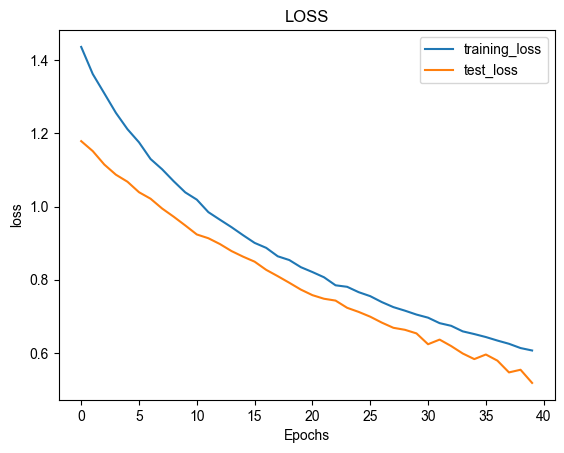

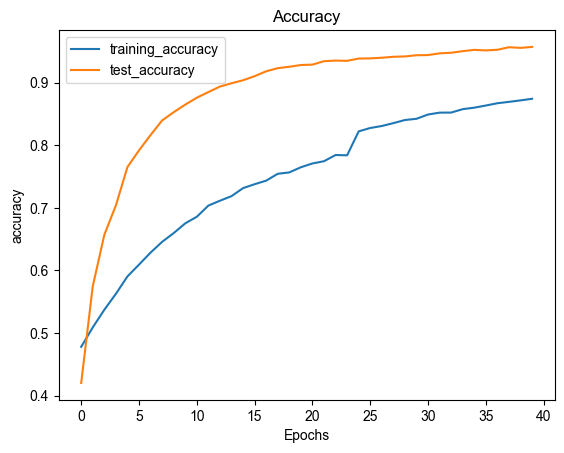

In [22]:
# 讀取數據
data = pd.read_csv('Phishing_Dataset.csv', encoding='utf-8')
features_df = pd.read_csv('Phishing_Dataset1_features.csv')

rs = 2666
lr = 0.000003
ep =40
model,scaler,X = model(data,features_df,rs,lr,ep)

rs = 1337 lr = 0.000003 ep =30  
accuracy                           0.94     26920   
   macro avg       0.94      0.94      0.94     26920   
weighted avg       0.94      0.94      0.94     26920



In [162]:

def scale_prediction(prediction):

    return prediction * 10.0

# quit()
def predict_url(model, url, scaler):
    # 提取 URL 的特徵
    features = extract_features(url)
    features_df = pd.DataFrame([features])
    # features_df = features_df.drop(columns=['url'])
    # 移除不必要的欄位 'url'
    if 'url' in features_df.columns:
        features_df = features_df.drop(columns=['url'])
    # 對 'tld' 進行 one-hot 編碼
    features_df = pd.get_dummies(features_df, columns=['tld'])
    # 確保列名與訓練模型時的一致，缺失特徵填補為 0
    features_df = features_df.reindex(columns=X.columns, fill_value=0)
    # 進行標準化
    print(features_df)
    features_scaled = scaler.transform(features_df)
    # 預測結果
    raw_prediction = model.predict(features_scaled)[0][0]
    # 將預測結果進行縮放
    scaled_prediction = scale_prediction(raw_prediction)
    # 處理 NAN 的情況
    if np.isnan(scaled_prediction):
        scaled_prediction = 0.0

    return features, scaled_prediction
# 測試網址列表
true_website = []
phishing_website = []

with open("0_testwebsite", 'r', encoding='utf-8') as file:
    test_urls = file.read().split("\n")

# 過濾無效的 URL
urls_to_test = [url for url in test_urls if url and url not in ['True Website', 'Phishing Website', '']]

# 打印預測結果
results = []
for url in urls_to_test:
    features, prediction = predict_url(model, url, scaler)
    result = {
        'url': url,
        'prediction': 'malicious' if prediction < 5.0 else 'benign',  # 分數低於 5.0 的是釣魚網站
        'score': prediction  # 添加預測分數
    }
    result.update(features)  # 更新特徵信息
    results.append(result)
    # print(f"URL: {url}\nPrediction: {result['prediction']}\nScore: {result['score']}\nFeatures: {features}\n")

# 將結果存儲到 CSV
results_df = pd.DataFrame(results)
results_df.to_csv('Phishing_Dataset1_result1.csv', index=False, encoding='utf-8')

# 記錄時間
end_time = time.time()
print(end_time - start_time)

Processing URL: https://www.facebook.com/?locale=zh_TW
Finished processing URL: https://www.facebook.com/?locale=zh_TW
{'url_length': 38, 'domain_length': 16, 'tld': 'com', 'has_ip': 0, 'num_special_chars': 3, 'has_https': 1, 'has_www': 1, 'pct_ext_hyperlinks': 0.9795918367346939, 'pct_ext_resource_urls': 0.015625, 'ext_favicon': 1, 'num_dots': 2, 'subdomain_level': 1, 'path_level': 1, 'num_dash': 0, 'num_dash_in_hostname': 0, 'at_symbol': 0, 'tilde_symbol': 0, 'num_underscore': 1, 'num_percent': 0, 'num_query_components': 1, 'num_ampersand': 0, 'num_hash': 0, 'num_numeric_chars': 0, 'no_https': 0, 'random_string': 0, 'ip_address': 0, 'domain_in_subdomains': 1, 'domain_in_paths': 0, 'https_in_hostname': 0, 'hostname_length': 16, 'path_length': 1, 'query_length': 12, 'double_slash_in_path': 0, 'num_sensitive_words': 0, 'embedded_brand_name': 1, 'insecure_forms': 0, 'relative_form_action': 1, 'ext_form_action': 1, 'abnormal_form_action': 0}
   url_length  domain_length  has_ip  num_speci

In [163]:
def adjust_feedback(existing_feedback, adjustment):
    # 控制feedback的最大/最小值範圍，避免超出邊界
    max_feedback = 10.0
    min_feedback = 0.0
    
    # 根據當前feedback的距離邊界的程度進行調整
    if adjustment > 0:
        # 如果反饋是正向的，即用戶認為是安全網站
        new_feedback = min(existing_feedback + adjustment, max_feedback)
    else:
        # 如果反饋是負向的，即用戶認為是釣魚網站
        new_feedback = max(existing_feedback + adjustment, min_feedback)

    return new_feedback

In [183]:
def predict_url_2(model, url, scaler):
    try:
        results_df = pd.read_csv('Phishing_Dataset1_result2.csv')
        url_in_csv = url in results_df['url'].values
        if url_in_csv:
            print("URL已存在，根據現有預測結果。")
            existing_result = results_df.loc[results_df['url'] == url].iloc[0].to_dict()
            print(f"當前預測：{existing_result['prediction']}, 分數：{existing_result['score']}")
            # 使用者提供反饋
            input_feedback = input("這是釣魚網站嗎？(Yes = 1, No = 2, Nothing = 3): ")
            if input_feedback.isdigit():
                input_feedback = int(input_feedback)
                if input_feedback == 1:
                    # 用戶反饋為釣魚網站，減少 feedback 權重
                    new_feedback = adjust_feedback(existing_result['feedback'], -0.5)
                    results_df.loc[results_df['url'] == url, 'feedback'] = new_feedback
                elif input_feedback == 2:
                    # 用戶反饋為安全網站，增加 feedback 權重
                    new_feedback = adjust_feedback(existing_result['feedback'], 0.5)
                    results_df.loc[results_df['url'] == url, 'feedback'] = new_feedback
                else:
                    new_feedback = adjust_feedback(existing_result['feedback'], 0.0)
                    results_df.loc[results_df['url'] == url, 'feedback'] = new_feedback

                # 使用更新的 feedback 欄位重新進行預測
                features = extract_features(url)
                features_df = pd.DataFrame([features])
                features_df = pd.get_dummies(features_df, columns=['tld'])
                features_df = features_df.reindex(columns=X.columns, fill_value=0)
                features_scaled = scaler.transform(features_df)
                raw_prediction = model.predict(features_scaled)[0][0]
                scaled_prediction = scale_prediction(raw_prediction)
                final_score = scaled_prediction * 0.5 + new_feedback * 0.5

                if np.isnan(scaled_prediction):
                    scaled_prediction = 0.0

                # 更新新的預測結果
                results_df.loc[results_df['url'] == url, 'score'] = final_score
                results_df.loc[results_df['url'] == url, 'prediction'] = 'malicious' if final_score < 5.0 else 'benign'

            result = results_df.loc[results_df['url'] == url].iloc[0].to_dict()
        else:
            raise FileNotFoundError
    except FileNotFoundError:
        print("結果文件不存在，創建新文件...")
        features = extract_features(url)
        features_df = pd.DataFrame([features])
        features_df = pd.get_dummies(features_df, columns=['tld'])
        features_df = features_df.reindex(columns=X.columns, fill_value=0)
        features_scaled = scaler.transform(features_df)
        raw_prediction = model.predict(features_scaled)[0][0]
        scaled_prediction = scale_prediction(raw_prediction)
        if np.isnan(scaled_prediction):
            scaled_prediction = 0.0
        feedback = 5.0
        final_score = scaled_prediction * 0.7 + feedback * 0.3
        result = {
            'url': url,
            'prediction': 'malicious' if final_score < 5.0 else 'benign',
            'score': final_score,
            'feedback': feedback
        }
        result.update(features)
        result.update({'feedback': feedback})
        new_result_df = pd.DataFrame([result])
        if 'results_df' in locals():
            results_df = pd.concat([results_df, new_result_df], ignore_index=True)
        else:
            results_df = new_result_df

    # 最後寫入 CSV
    results_df.to_csv('Phishing_Dataset1_result2.csv', index=False, encoding='utf-8')

    return features, scaled_prediction, result

In [186]:
while(1):
    input_url = input("Input your url(input exit to quit): ")
    if input_url == "exit":
        break
    features, prediction,result = predict_url_2(model, input_url, scaler)
    # print(f"URL: {result['url']}\nPrediction: {result['prediction']}\nScore: {result['score']}\nFeatures: {result}\n")

結果文件不存在，創建新文件...
Processing URL: https://docs.google.com/spreadsheets/d/1lBiT7WNfVDu6Xbt4Zdc-FgQsytjauvLX/edit?pli=1&gid=1325983850#gid=1325983850
Finished processing URL: https://docs.google.com/spreadsheets/d/1lBiT7WNfVDu6Xbt4Zdc-FgQsytjauvLX/edit?pli=1&gid=1325983850#gid=1325983850
{'url_length': 113, 'domain_length': 15, 'tld': 'com', 'has_ip': 0, 'num_special_chars': 7, 'has_https': 1, 'has_www': 0, 'pct_ext_hyperlinks': 0.75, 'pct_ext_resource_urls': 0.0004922874958976042, 'ext_favicon': 1, 'num_dots': 2, 'subdomain_level': 1, 'path_level': 4, 'num_dash': 1, 'num_dash_in_hostname': 0, 'at_symbol': 0, 'tilde_symbol': 0, 'num_underscore': 0, 'num_percent': 0, 'num_query_components': 2, 'num_ampersand': 1, 'num_hash': 1, 'num_numeric_chars': 25, 'no_https': 0, 'random_string': 0, 'ip_address': 0, 'domain_in_subdomains': 1, 'domain_in_paths': 0, 'https_in_hostname': 0, 'hostname_length': 15, 'path_length': 54, 'query_length': 20, 'double_slash_in_path': 0, 'num_sensitive_words': 0, '